<a href="https://colab.research.google.com/github/RosariaCDiLauro/psychographic-profiling-experiment/blob/main/psychographic-profiling-experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from itertools import combinations
import seaborn as sns
!pip install -q gdown
import gdown
import re
from tqdm import tqdm
from textblob import TextBlob
!pip install -q contractions
import contractions
!pip install -q emoji
import emoji
!pip install -q negspacy
import spacy
from negspacy.negation import Negex
from negspacy.termsets import termset
!pip install -q ekphrasis
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
import nltk
from nltk.tokenize import word_tokenize
from itertools import product
from nltk.corpus import words
nltk.download('punkt')
nltk.download('words')
nltk.download('punkt_tab', quiet=True)
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
nltk.download('wordnet', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon', quiet=True)
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
nltk.download('stopwords', quiet=True)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from scipy.sparse import hstack, csr_matrix
from sklearn.utils.class_weight import compute_class_weight
!pip install -q scikit-multilearn
from skmultilearn.model_selection import IterativeStratification
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import (
    classification_report,
    hamming_loss,
    f1_score
)
import joblib
!pip install -q ftfy
import ftfy
from IPython.display import display, Markdown
import ast
import json
import requests
import io
from io import BytesIO
import os
import shutil
import numpy as np
import contextlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 18.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.8/83.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 3.4 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 250.1 kB/s eta 0:00:00


In [2]:
train_url = "https://raw.githubusercontent.com/RosariaCDiLauro/psychographic-profiling-experiment/refs/heads/main/assets/train.tsv"
dev_url   = "https://raw.githubusercontent.com/RosariaCDiLauro/psychographic-profiling-experiment/refs/heads/main/assets/dev.tsv"
test_url  = "https://raw.githubusercontent.com/RosariaCDiLauro/psychographic-profiling-experiment/refs/heads/main/assets/test.tsv"


train = pd.read_csv(train_url, sep='\t', header=None, names=['text', 'emotion_ids', 'id'])
dev   = pd.read_csv(dev_url,   sep='\t', header=None, names=['text', 'emotion_ids', 'id'])
test  = pd.read_csv(test_url,  sep='\t', header=None, names=['text', 'emotion_ids', 'id'])


print(f"Righe train: {len(train)}")
print(f"Righe dev: {len(dev)}")
print(f"Righe test: {len(test)}")


goem_df = pd.concat([train, dev, test], ignore_index=True)

print(f"Totale righe unificate: {len(goem_df)}")

Righe train: 43410
Righe dev: 5426
Righe test: 5427
Totale righe unificate: 54263


In [ ]:
righe_senza_emozioni = goem_df[goem_df['emotion_ids'].astype(str).str.strip() == ""]
len(righe_senza_emozioni)

0

In [ ]:
print("Colonne di goem_df:")
print(goem_df.columns.tolist())

print("\nPrime 10 righe di goem_df:")
print(goem_df.head(10))

print("\nInfo generali del DataFrame:")
print(goem_df.info())

Colonne di goem_df:
['text', 'emotion_ids', 'id']

Prime 10 righe di goem_df:
                                                text emotion_ids       id
0  My favourite food is anything I didn't have to...          27  eebbqej
1  Now if he does off himself, everyone will thin...          27  ed00q6i
2                     WHY THE FUCK IS BAYLESS ISOING           2  eezlygj
3                        To make her feel threatened          14  ed7ypvh
4                             Dirty Southern Wankers           3  ed0bdzj
5  OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...          26  edvnz26
6  Yes I heard abt the f bombs! That has to be wh...          15  ee3b6wu
7  We need more boards and to create a bit more s...        8,20  ef4qmod
8  Damn youtube and outrage drama is super lucrat...           0  ed8wbdn
9  It might be linked to the trust factor of your...          27  eczgv1o

Info generali del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54263 entries, 0 to 54262
Da

In [ ]:
emotions_url = "https://raw.githubusercontent.com/RosariaCDiLauro/psychographic-profiling-experiment/refs/heads/main/assets/emotions.txt"

emotions = pd.read_csv(emotions_url, header=None).iloc[:,0].tolist()

for i, emo in enumerate(emotions):
    print(f"{i}: {emo}")

0: admiration
1: amusement
2: anger
3: annoyance
4: approval
5: caring
6: confusion
7: curiosity
8: desire
9: disappointment
10: disapproval
11: disgust
12: embarrassment
13: excitement
14: fear
15: gratitude
16: grief
17: joy
18: love
19: nervousness
20: optimism
21: pride
22: realization
23: relief
24: remorse
25: sadness
26: surprise
27: neutral


In [ ]:
goem_df.head(25)

text emotion_ids       id
0   My favourite food is anything I didn't have to...          27  eebbqej
1   Now if he does off himself, everyone will thin...          27  ed00q6i
2                      WHY THE FUCK IS BAYLESS ISOING           2  eezlygj
3                         To make her feel threatened          14  ed7ypvh
4                              Dirty Southern Wankers           3  ed0bdzj
5   OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...          26  edvnz26
6   Yes I heard abt the f bombs! That has to be wh...          15  ee3b6wu
7   We need more boards and to create a bit more s...        8,20  ef4qmod
8   Damn youtube and outrage drama is super lucrat...           0  ed8wbdn
9   It might be linked to the trust factor of your...          27  eczgv1o
10  Demographics? I don’t know anybody under 35 wh...           6  eel6g5h
11  Aww... she'll probably come around eventually,...         1,4  edex4ki
12  Hello everyone. Im from Toronto as well. Can c...          27  ef83m1s
13  R/sleeptrain Might be time for some sleep trai...           5  efh7xnk
14  [NAME] - same fucking problem, slightly better...           3  efdqav7
15  Shit, I guess I accidentally bought a Pay-Per-...        3,12  edivtm3
16                                   Thank you friend          15  eeqd04y
17                                    Fucking coward.           2  edk0z9k
18                that is what retardation looks like          27  eeb9aft
19  Maybe that’s what happened to the great white ...        6,22  eczq8zg
20  I never thought it was at the same moment, but...      6,9,27  efdlhs1
21       i got a bump and a bald spot. i feel dumb <3          12  ee4tgim
22                 You are going to do the dishes now          27  ee7it59
23                            Slowing things down now          27  ed4nz06
24  His name has already been released. Just can't...          27  ee18uaj

In [ ]:
def map_ids_to_names(id_string):
    ids = [int(i) for i in id_string.split(',')]
    return [emotions[i] for i in ids]

goem_df['emotion_names'] = goem_df['emotion_ids'].apply(map_ids_to_names)

goem_df.head(25)[['text', 'emotion_ids', 'emotion_names']]

text emotion_ids  \
0   My favourite food is anything I didn't have to...          27   
1   Now if he does off himself, everyone will thin...          27   
2                      WHY THE FUCK IS BAYLESS ISOING           2   
3                         To make her feel threatened          14   
4                              Dirty Southern Wankers           3   
5   OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe...          26   
6   Yes I heard abt the f bombs! That has to be wh...          15   
7   We need more boards and to create a bit more s...        8,20   
8   Damn youtube and outrage drama is super lucrat...           0   
9   It might be linked to the trust factor of your...          27   
10  Demographics? I don’t know anybody under 35 wh...           6   
11  Aww... she'll probably come around eventually,...         1,4   
12  Hello everyone. Im from Toronto as well. Can c...          27   
13  R/sleeptrain Might be time for some sleep trai...           5   
14  [NAME] - same fucking problem, slightly better...           3   
15  Shit, I guess I accidentally bought a Pay-Per-...        3,12   
16                                   Thank you friend          15   
17                                    Fucking coward.           2   
18                that is what retardation looks like          27   
19  Maybe that’s what happened to the great white ...        6,22   
20  I never thought it was at the same moment, but...      6,9,27   
21       i got a bump and a bald spot. i feel dumb <3          12   
22                 You are going to do the dishes now          27   
23                            Slowing things down now          27   
24  His name has already been released. Just can't...          27   

                           emotion_names  
0                              [neutral]  
1                              [neutral]  
2                                [anger]  
3                                 [fear]  
4                            [annoyance]  
5                             [surprise]  
6                            [gratitude]  
7                     [desire, optimism]  
8                           [admiration]  
9                              [neutral]  
10                           [confusion]  
11                 [amusement, approval]  
12                             [neutral]  
13                              [caring]  
14                           [annoyance]  
15            [annoyance, embarrassment]  
16                           [gratitude]  
17                               [anger]  
18                             [neutral]  
19              [confusion, realization]  
20  [confusion, disappointment, neutral]  
21                       [embarrassment]  
22                             [neutral]  
23                             [neutral]  
24                             [neutral]

In [ ]:
emotion_counts = goem_df['emotion_ids'].str.split(',').explode().astype(int).value_counts()

emotion_counts_df = pd.DataFrame({
    'emotion_id': emotion_counts.index,
    'emotion_label': emotion_counts.index.map(lambda x: emotions[x]),
    'count': emotion_counts.values
})

print("--- Conteggio delle istanze per ogni emozione ---")
print(emotion_counts_df)

--- Conteggio delle istanze per ogni emozione ---
    emotion_id   emotion_label  count
0           27         neutral  17772
1            0      admiration   5122
2            4        approval   3687
3           15       gratitude   3372
4            3       annoyance   3093
5            1       amusement   2895
6            7       curiosity   2723
7           10     disapproval   2581
8           18            love   2576
9           20        optimism   1976
10           2           anger   1960
11          17             joy   1785
12           6       confusion   1673
13          25         sadness   1625
14           9  disappointment   1583
15          22     realization   1382
16           5          caring   1375
17          26        surprise   1330
18          13      excitement   1052
19          11         disgust   1013
20           8          desire    801
21          14            fear    764
22          24         remorse    669
23          12   embarrassment    375


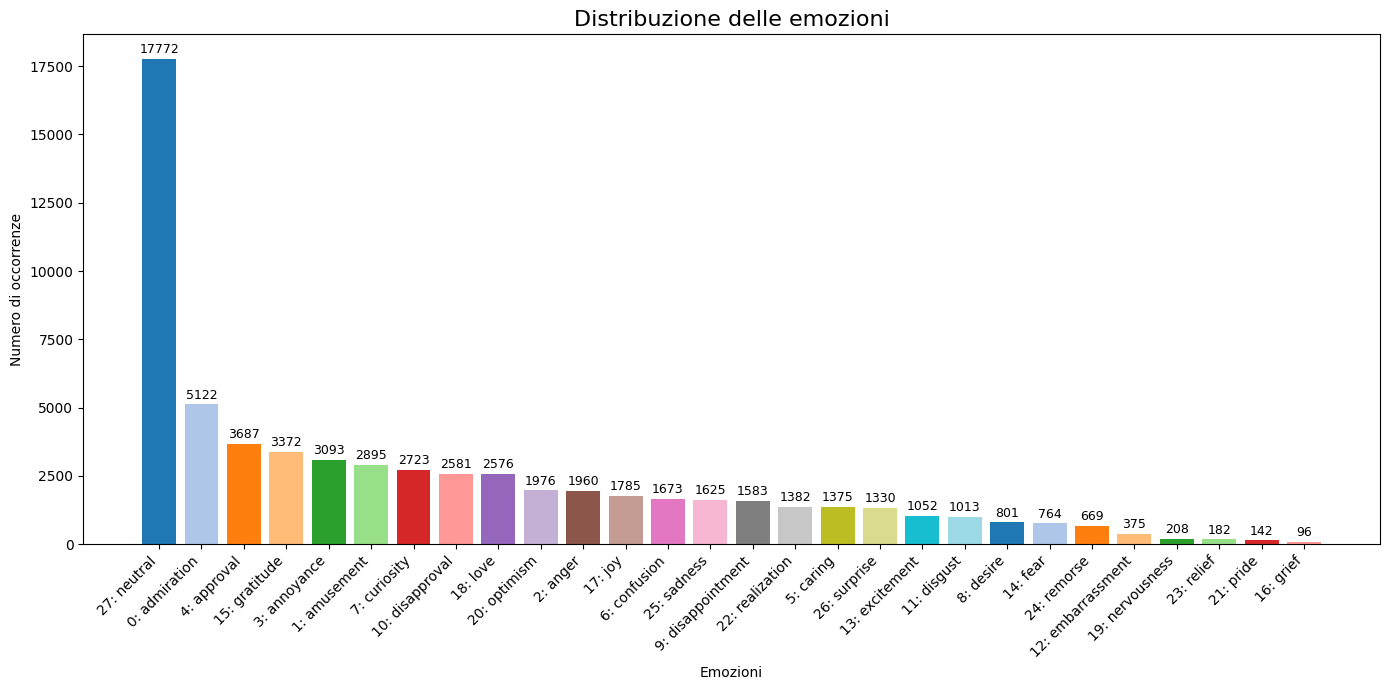

In [ ]:
if 'emotion_counts_df' not in locals():
    emotion_counts = goem_df['emotion_ids'].str.split(',').explode().astype(int).value_counts()

    emotion_counts_df = pd.DataFrame({
        'emotion_id': emotion_counts.index,
        'emotion_label': emotion_counts.index.map(lambda x: emotions[x]),
        'count': emotion_counts.values
    })

emotion_counts_df_sorted = emotion_counts_df.sort_values(by='count', ascending=False)

plt.figure(figsize=(14, 7))
bars = plt.bar(
    emotion_counts_df_sorted['emotion_label'],
    emotion_counts_df_sorted['count'],
    color=plt.cm.tab20.colors[:len(emotion_counts_df_sorted)]
)

plt.xticks(
    ticks=range(len(emotion_counts_df_sorted)),
    labels=[f"{row['emotion_id']}: {row['emotion_label']}" for _, row in emotion_counts_df_sorted.iterrows()],
    rotation=45,
    ha='right'
)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 100, str(height), ha='center', va='bottom', fontsize=9)

plt.xlabel("Emozioni")
plt.ylabel("Numero di occorrenze")
plt.title("Distribuzione delle emozioni", fontsize=16)
plt.tight_layout()
plt.show()

Analisi dello sbilanciamento nella distribuzione delle emozioni:

Il grafico illustra la distribuzione delle occorrenze emotive nel dataset rivelando un livello di sbilanciamento di classe estremamente elevato.

*   Dominanza della Neutralità
La classe '27: Neutral' costituisce la maggioranza assoluta con 17.772 occorrenze. Questa predominanza crea un forte bias: in un contesto di Machine Learning, un modello addestrato su questi dati imparerebbe a predire 'neutral' molto più facilmente e frequentemente, penalizzando la capacità di distinguere le emozioni specifiche.

*  Asimmetria tra le emozioni
Al di là della neutralità, il divario tra le emozioni di alto e basso livello di occorrenza è significativo:

Classi Maggioritarie: Le prime emozioni non-neutrali, come '4: Approval' (5.122) e '15: Gratitude' (3.687), pur essendo rilevanti, contano per meno di un terzo delle occorrenze 'Neutral'.

Classi Minoritarie (Rare): Molte classi si trovano nella coda della distribuzione con un numero di campioni estremamente ridotto. Ad esempio: '19: Nervousness' (208), '23: Relief' (182) e '16: Grief' (96), che sono gravemente sottorappresentate. Il numero di occorrenze per 'Grief' è oltre 185 volte inferiore rispetto a 'Neutral'.

Questo evidente sbilanciamento è critico.
Sulla base di questi dati, infatti, i modelli di classificazione potrebbero sviluppare un forte bias verso la classe nettamente predominante e una scarsa capacità di generalizzazione (bassa recall) per le emozioni rare, rendendo necessarie strategie di bilanciamento dei dati.

In [ ]:
all_emotions = goem_df['emotion_names']

def all_combinations(emo_list):
    combs = []
    n = len(emo_list)
    for r in range(2, n+1):
        combs.extend(combinations(sorted(emo_list), r))
    return combs


all_combs = []
for emo_list in all_emotions:
    if len(emo_list) > 1:
        all_combs.extend(all_combinations(emo_list))

combs_by_length = defaultdict(list)
for comb in all_combs:
    combs_by_length[len(comb)].append(comb)

for length, comb_list in sorted(combs_by_length.items()):
    counter = Counter(comb_list)
    total_combinations = sum(counter.values())

    print(f"\nCombinazioni di lunghezza {length}:")
    print(f"Totale combinazioni (incluse ripetizioni): {total_combinations}")
    print("Top 10 più frequenti:")
    top_10 = counter.most_common(10)
    for comb, count in top_10:
        print(f"{comb} --> {count}")

    other_combinations_count = len(counter) - len(top_10)
    print(f"Tipi diversi di coppie di emozioni: {other_combinations_count}")


Combinazioni di lunghezza 2:
Totale combinazioni (incluse ripetizioni): 10321
Top 10 più frequenti:
('anger', 'annoyance') --> 348
('admiration', 'gratitude') --> 341
('admiration', 'approval') --> 298
('approval', 'neutral') --> 258
('confusion', 'curiosity') --> 253
('admiration', 'love') --> 236
('annoyance', 'disapproval') --> 222
('annoyance', 'neutral') --> 177
('disappointment', 'sadness') --> 163
('curiosity', 'neutral') --> 162
Tipi diversi di coppie di emozioni: 331

Combinazioni di lunghezza 3:
Totale combinazioni (incluse ripetizioni): 813
Top 10 più frequenti:
('confusion', 'curiosity', 'neutral') --> 14
('admiration', 'gratitude', 'joy') --> 13
('anger', 'annoyance', 'disapproval') --> 12
('admiration', 'approval', 'optimism') --> 11
('admiration', 'approval', 'love') --> 10
('anger', 'annoyance', 'disappointment') --> 9
('admiration', 'gratitude', 'love') --> 8
('amusement', 'gratitude', 'joy') --> 8
('annoyance', 'disappointment', 'disapproval') --> 8
('admiration', 'e

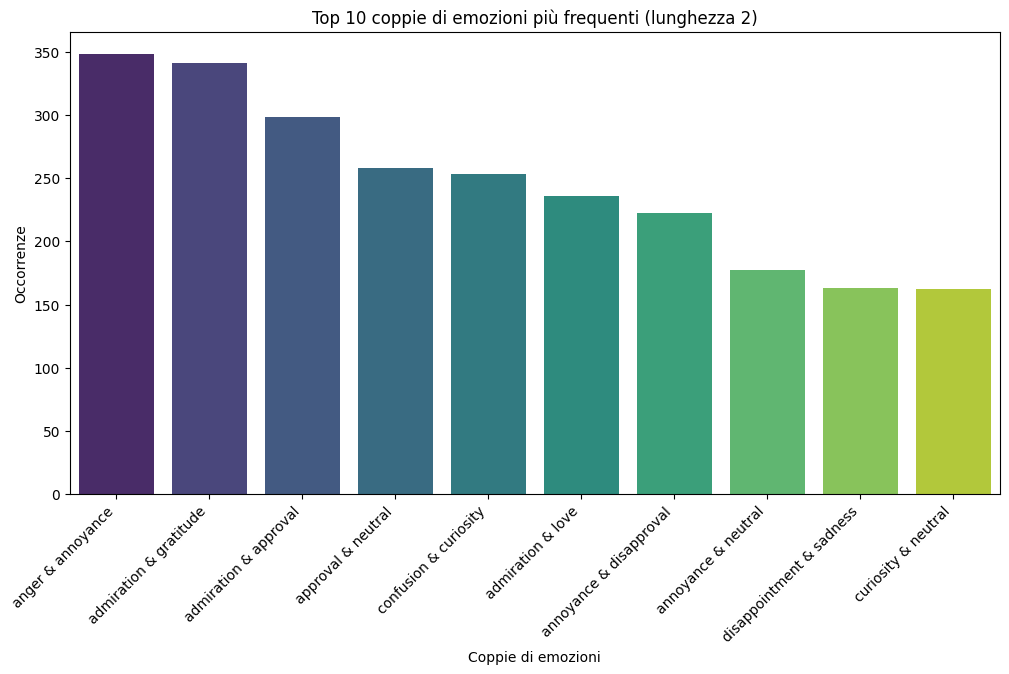

In [ ]:

all_emotions = goem_df['emotion_names']

pairs = []
for emo_list in all_emotions:
    if len(emo_list) >= 2:
        pairs.extend(combinations(sorted(emo_list), 2))

pair_counts = Counter(pairs)


top_10_pairs = pair_counts.most_common(10)


pairs_labels = [f"{a} & {b}" for (a, b), count in top_10_pairs]
counts = [count for (pair, count) in top_10_pairs]

plt.figure(figsize=(12,6))
sns.barplot(x=pairs_labels, y=counts, palette="viridis", hue=pairs_labels, legend=False)
plt.ylabel("Occorrenze")
plt.xlabel("Coppie di emozioni")
plt.title("Top 10 coppie di emozioni più frequenti (lunghezza 2)")
plt.xticks(rotation=45, ha='right')
plt.show()

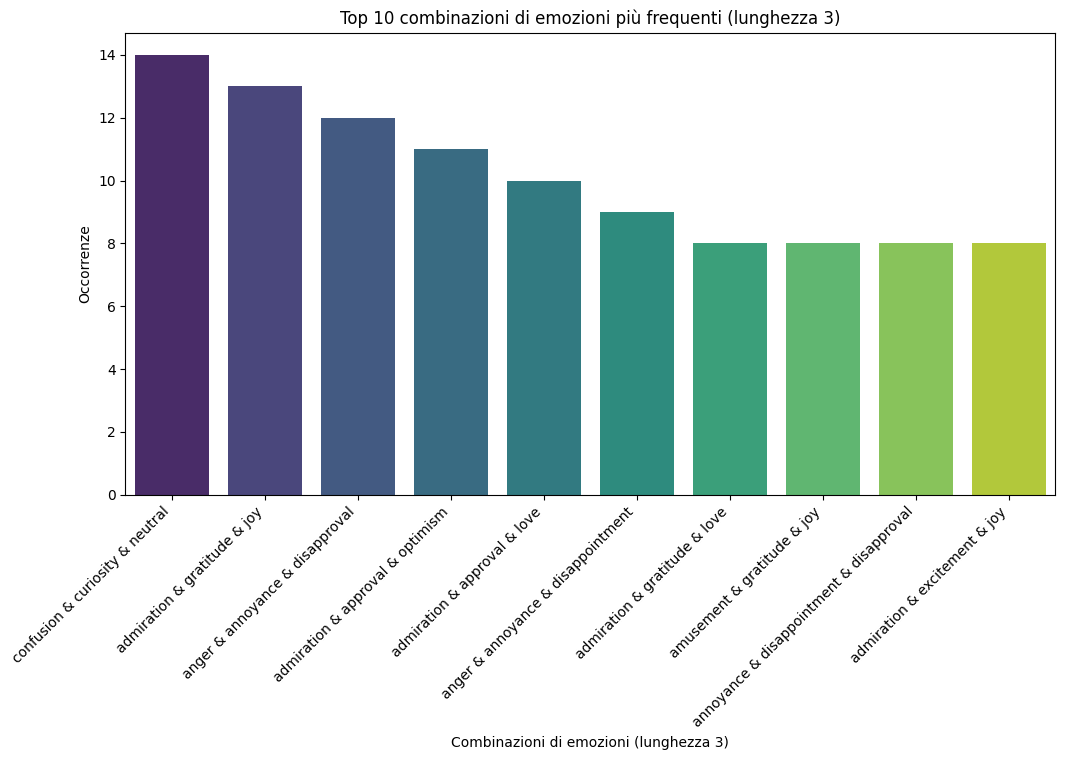

In [ ]:
all_emotions = goem_df['emotion_names']


pairs = []
for emo_list in all_emotions:
    if len(emo_list) >= 3:
        pairs.extend(combinations(sorted(emo_list), 3))

pair_counts = Counter(pairs)

top_10_pairs = pair_counts.most_common(10)

pairs_labels = [f"{a} & {b} & {c}" for (a, b, c), count in top_10_pairs]
counts = [count for (pair, count) in top_10_pairs]

plt.figure(figsize=(12,6))
sns.barplot(x=pairs_labels, y=counts, palette="viridis", hue=pairs_labels, legend=False)
plt.ylabel("Occorrenze")
plt.xlabel("Combinazioni di emozioni (lunghezza 3)")
plt.title("Top 10 combinazioni di emozioni più frequenti (lunghezza 3)")
plt.xticks(rotation=45, ha='right')
plt.show()

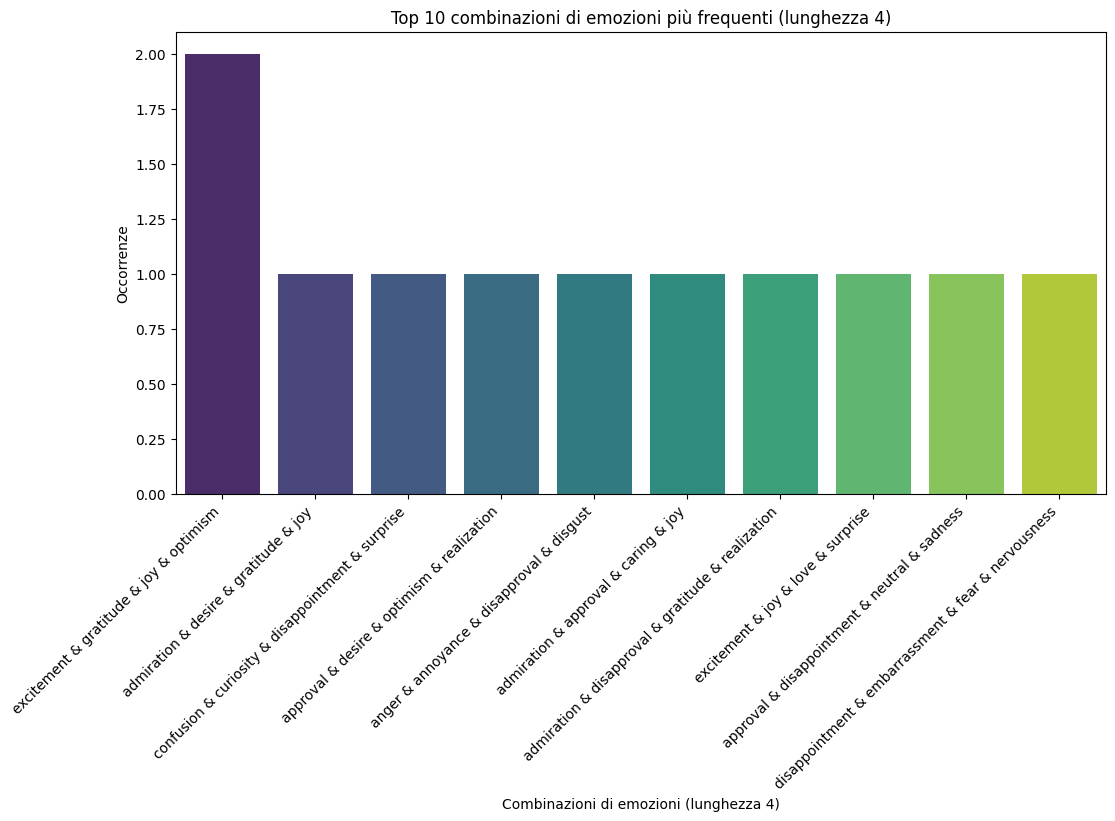

In [ ]:
all_emotions = goem_df['emotion_names']

pairs = []
for emo_list in all_emotions:
    if len(emo_list) >= 4:
        pairs.extend(combinations(sorted(emo_list), 4))

pair_counts = Counter(pairs)


top_10_pairs = pair_counts.most_common(10)


pairs_labels = [" & ".join(comb) for comb, count in top_10_pairs]
counts = [count for (pair, count) in top_10_pairs]


plt.figure(figsize=(12,6))
sns.barplot(x=pairs_labels, y=counts, palette="viridis", hue=pairs_labels, legend=False)
plt.ylabel("Occorrenze")
plt.xlabel("Combinazioni di emozioni (lunghezza 4)")
plt.title("Top 10 combinazioni di emozioni più frequenti (lunghezza 4)")
plt.xticks(rotation=45, ha='right')
plt.show()

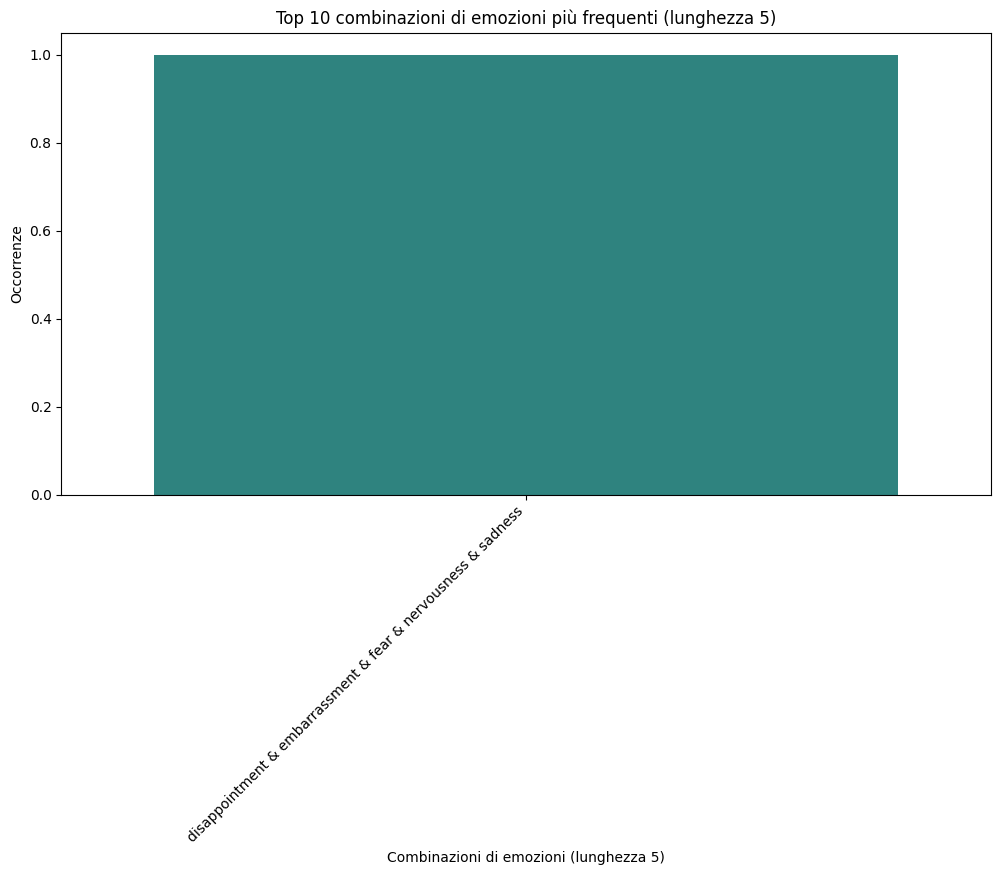

In [ ]:
all_emotions = goem_df['emotion_names']

pairs = []
for emo_list in all_emotions:
    if len(emo_list) >= 5:
        pairs.extend(combinations(sorted(emo_list), 5))


pair_counts = Counter(pairs)


top_10_pairs = pair_counts.most_common(10)


pairs_labels = [" & ".join(comb) for comb, count in top_10_pairs]
counts = [count for (pair, count) in top_10_pairs]

plt.figure(figsize=(12,6))
sns.barplot(x=pairs_labels, y=counts, palette="viridis", hue=pairs_labels, legend=False)
plt.ylabel("Occorrenze")
plt.xlabel("Combinazioni di emozioni (lunghezza 5)")
plt.title("Top 10 combinazioni di emozioni più frequenti (lunghezza 5)")
plt.xticks(rotation=45, ha='right')
plt.show()

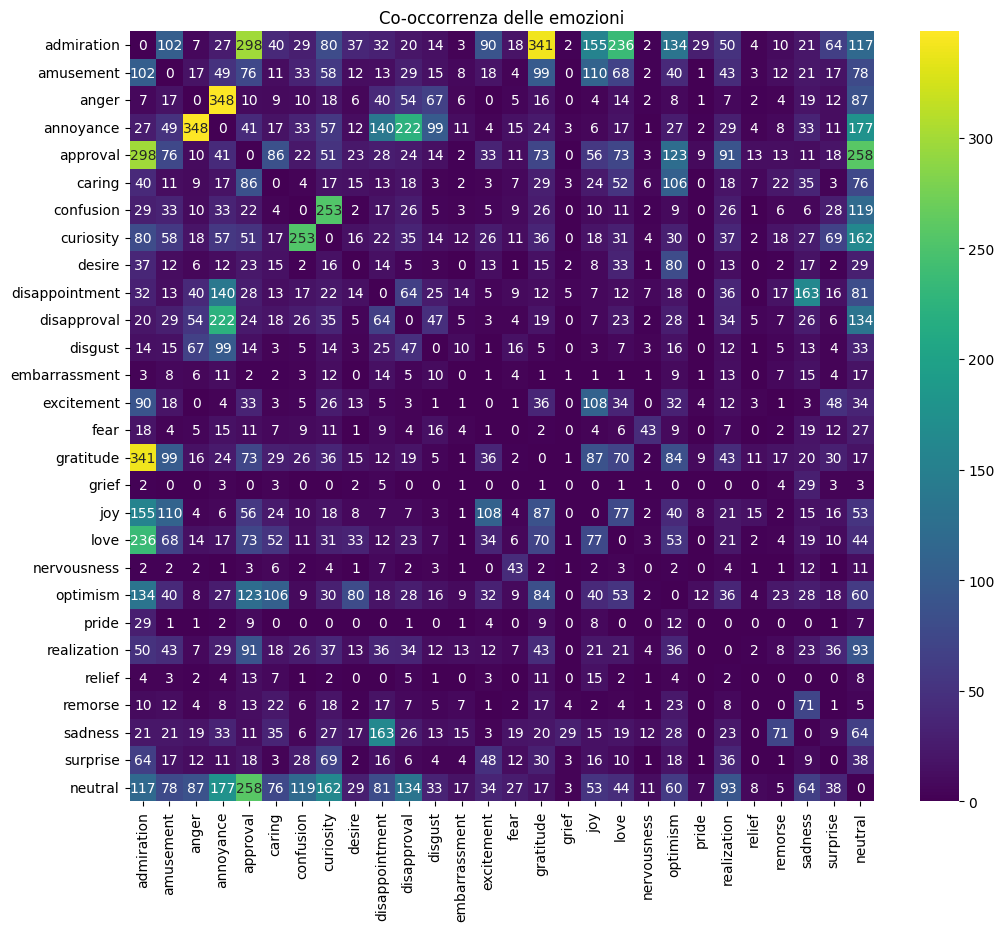

In [ ]:
emo_labels = emotions

co_matrix = pd.DataFrame(0, index=emo_labels, columns=emo_labels)

for emo_list in goem_df['emotion_names']:
    for a, b in combinations(emo_list, 2):
        co_matrix.at[a, b] += 1
        co_matrix.at[b, a] += 1

plt.figure(figsize=(12,10))
sns.heatmap(co_matrix, cmap='viridis', annot=True, fmt='d')
plt.title("Co-occorrenza delle emozioni")
plt.show()

La matrice di co-occorrenza mostra quante volte ogni coppia di emozioni compare insieme nei messaggi degli utenti, evidenziando pattern emotivi ricorrenti.
Ad esempio, Gratitude e Love co-occorrono 236 volte, indicando che nei discorsi in cui compare gratitudine è molto probabile trovare anche espressioni affettive; allo stesso modo Approval ricorre insieme a Curiosity per 253 volte, suggerendo che gli utenti che esprimono approvazione tendono anche a porre domande o mostrare interesse cognitivo. Le emozioni negative formano cluster distinti: Anger–Annoyance compaiono insieme 348 volte, riflettendo un forte nesso tra irritazione e rabbia, mentre Disapproval–Disgust si presentano in coppia 222 volte, associandosi a giudizio e rifiuto morale. Tra le emozioni positive, Amusement–Joy co-occorrono 110 volte, confermando che contenuti umoristici spesso generano anche emozioni di felicità. La diagonale evidenzia i valori di auto-frequenza (es. Gratitude 349, Curiosity 517, Love 236), che mostrano le emozioni più dominate nel dataset. Complessivamente, la distribuzione denuncia la presenza di due grandi poli emotivi: un cluster affettivo-prosociale (Love, Gratitude, Approval, Admiration) dove le co-occorrenze superano spesso le 150–250 unità, e un cluster negativo-reattivo (Anger, Annoyance, Disapproval, Disgust) con legami molto forti come le 348 co-occorrenze tra rabbia e fastidio. Questi pattern indicano che le emozioni non emergono in modo isolato, ma secondo strutture ricorrenti: alcuni utenti tendono verso risposte affettive e sociali, altri verso irritazione e conflitto, altri ancora verso curiosità e coinvolgimento cognitivo.

In [3]:
url = "https://raw.githubusercontent.com/RosariaCDiLauro/psychographic-profiling-experiment/refs/heads/main/assets/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"
gdown.download(url, "nrc.txt", quiet=False)

emolex_df = pd.read_csv(
    "nrc.txt",
    sep="\t",
    names=["word", "emotion", "association"],
    skiprows=45,
    keep_default_na=False
)

emolex_df.head(10)

Downloading...
From: https://raw.githubusercontent.com/RosariaCDiLauro/psychographic-profiling-experiment/refs/heads/main/assets/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt
To: /content/nrc.txt
2.57MB [00:00, 22.9MB/s]


word       emotion  association
0  abandonment      negative            1
1  abandonment      positive            0
2  abandonment       sadness            1
3  abandonment      surprise            1
4  abandonment         trust            0
5        abate         anger            0
6        abate  anticipation            0
7        abate       disgust            0
8        abate          fear            0
9        abate           joy            0

In [4]:
emolex_df.emotion.unique()
emolex_df.emotion.value_counts()

emotion
negative        14150
positive        14150
sadness         14150
surprise        14150
trust           14150
anger           14149
anticipation    14149
disgust         14149
fear            14149
joy             14149
Name: count, dtype: int64

In [ ]:
emolex_df[emolex_df.association == 1].emotion.value_counts()
words_emotions_list = emolex_df[emolex_df.association == 1][['word', 'emotion']].apply(tuple, axis=1).tolist()

CLASSIFICATORE EMOZIONI

In [ ]:
def pulisci_testo(text):
    if not isinstance(text, str):
        return text

    # Rimuovere URL
    text = re.sub(r'[\(\[]?\b(?:https?://|ftp://|www\.)\S+[\)\]]?', '', text, flags=re.IGNORECASE)

    # Rimuovere indirizzi email
    text = re.sub(r'[\(\[]?\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b[\)\]]?', '', text)

    # Rimuovere tag HTML
    text = re.sub(r'[\(\[]?<[^>]+>[\)\]]?', '', text)

    # Rimuovere parentesi tonde e quadre mantenendo il contenuto
    def replacer(match):
        full = match.group(0)
        content = full[1:-1].strip()

        # Parentesi tonde
        if full.startswith("("):
            return content  # testo → mantenuto senza tonde, vuote → diventano stringa vuota

        # Parentesi quadre
        elif full.startswith("["):
            return content  # testo → mantenuto senza quadre, vuote → diventano stringa vuota

        return full

    text = re.sub(r'[\(\[][^\)\]]*[\)\]]', replacer, text)

    # Rimuove eventuali spazi extra
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [ ]:
goem_df['text'] = goem_df['text'].apply(pulisci_testo)

In [ ]:
pd.set_option('display.max_colwidth', None)

print(goem_df['text'].head(25))

0                                                                     My favourite food is anything I didn't have to cook myself.
1                Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead
2                                                                                                  WHY THE FUCK IS BAYLESS ISOING
3                                                                                                     To make her feel threatened
4                                                                                                          Dirty Southern Wankers
5                              OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe PlAyOfFs! Dumbass Broncos fans circa December 2015.
6           Yes I heard abt the f bombs! That has to be why. Thanks for your reply:) until then hubby and I will anxiously wait 😝
7                                                We need more boards and to create a bit m

In [ ]:
emoticon_pattern = re.compile(
    r"""
    (?<![A-Za-z0-9])
    ([:;=xX8][\-~']?[\)\]\(\[dDpPoO/\|3]+|<3+)
    (?![A-Za-z0-9])
    """,
    re.VERBOSE
)

# --- Funzione per trovare tutte le emoticon testuali in una stringa ---
def find_textual_emoticons(text):
    if not isinstance(text, str):
        return []

    matches = re.findall(emoticon_pattern, text)
    return [match for match in matches if match]

def analizza_emoticons(df, text_column):
    df['textual_emoticons_in_text'] = df[text_column].apply(find_textual_emoticons)

    rows_with_emoticons = df['textual_emoticons_in_text'].apply(len) > 0
    num_rows_with_emoticons = rows_with_emoticons.sum()
    total_rows = len(df)

    print(f"Totale righe con almeno un'emoticon testuale: {num_rows_with_emoticons:,} su {total_rows:,} "
          f"({(num_rows_with_emoticons / total_rows * 100):.2f}%)\n")

    all_unique_textual_emoticons = set(
        emoticon
        for sublist in df['textual_emoticons_in_text']
        for emoticon in sublist
        if emoticon
    )

    print("Emoticon testuali trovate:")
    print(all_unique_textual_emoticons)
    print("Totale emoticons:", len(all_unique_textual_emoticons))

    print("\nEsempi di righe con emoticon trovate:")
    display(df[rows_with_emoticons][[text_column, 'textual_emoticons_in_text']].head(25))

    return df, all_unique_textual_emoticons

In [ ]:
goem_df, emoticons = analizza_emoticons(goem_df, text_column='text')

Totale righe con almeno un'emoticon testuale: 1,287 su 54,263 (2.37%)

Emoticon testuali trovate:
{':))))', ':-|', ':-/', "x'D", '<33', ':3', ':P', ':DDD', '=o)', 'xD', ':~(', ':-p', ':p', 'x3', 'x)', 'XP', ':)', '<3', ';D', 'XD', ":')", ':|', "X'D", ':((((', ':-D', ':-)', 'xd', ';P', ':D', ':o', ':-(', '8D', "='D", 'xp', '=(', ':o)', '=D', ':[', ';-)', 'xo', ';(', ':O', ':]', ';)', '=)', '83', ':(((((((', 'xdd', '=/', ':))', ';((', ':-P', ':(', ':/', '8(', '=]', ':((', ":'(", ';p'}
Totale emoticons: 59

Esempi di righe con emoticon trovate:


text  \
21                                                                       i got a bump and a bald spot. i feel dumb <3   
58                                                                                                    Oh holy heck :/   
83                                   At least it’s not anything worse, and that you are still close to that person :)   
158                                                                                   I adore this comment section <3   
178                                                                   No problem at all, glad I could help :) Cheers!   
182                                                            Thanks, :), as the days go by they are getting better.   
234                                                                                         ur mom is in purgatory xd   
252                No he was given a bad team to work with unfortunately, and never got the final shot he deserved :(   
261                                                  At least you get sunny on Netflix, they took it off in Canada :(   
282                          I live in Suiderstrand, which is past Aghulas, no option for fibre here unfortunately :(   
354                                                              I feel awful posting it, but I couldn’t not share :|   
359                                                                                            Ahh gotcha - thanks :)   
364   Their orange chicken is the absolute fucking bomb. I love having it on top of a nice bed of rice and veggies :D   
446                                                      I didn’t know it was gonna be that simple Forgive me NAME :D   
578                                                                                                Happy Cake Day! :)   
594                                 I've felt number 2 so hard. "Working hard for what you don't want" is a thing. :(   
657                                                     I mean, two times zero is zero and that can be a guarantee :D   
796                                Sadly my boyfriend's family is the direct opposite but we'll still make it work :3   
869                                                                                             Haha! I was right :D.   
888                                                                                                       I'm glad :)   
891                                                                                                        Anytime :)   
900                        What a transition...from "Ab-Fab" to "Au-Bo" :p don't forget the vodka, it's cold up there   
939                                           That has to be the saddest nba account ever. Like 4 likes every post :(   
972                                              My face is so round so I don’t even know what male haircut to get :(   
1051                                                                               That last panel tho. :( Same dude.   

     textual_emoticons_in_text  
21                        [<3]  
58                        [:/]  
83                        [:)]  
158                       [<3]  
178                       [:)]  
182                       [:)]  
234                       [xd]  
252                       [:(]  
261                       [:(]  
282                       [:(]  
354                       [:|]  
359                       [:)]  
364                       [:D]  
446                       [:D]  
578                       [:)]  
594                       [:(]  
657                       [:D]  
796                       [:3]  
869                       [:D]  
888                       [:)]  
891                       [:)]  
900                       [:p]  
939                       [:(]  
972                       [:(]  
1051                      [:(]

In [ ]:
tqdm.pandas()

emoticon_to_word = {
    # Felicità / gioia
    ":)": "happy", ":-)": "happy", ":d": "happy", ":-d": "happy", "=d": "happy",
    "xd": "laugh", "x'd": "laugh",
    "xp": "playful", "x-p": "playful", ":-p": "playful", ":p": "playful", ";p": "playful",
    ";d": "happy", ":3": "happy", ":')": "happy",
    "x3": "happy", ":o)": "happy", "=]": "happy", "=o)": "happy", "x)": "playful",

    # Tristezza / pianto / sconforto
    ":(": "sad", ":-(": "sad", ":^(": "sad", ":~(": "cry", ":'(": "cry",
    ";(": "cry", ":(]": "sad", ":[": "sad", "=(":"sad",

    # Sorpresa / shock / confusione
    ":o": "surprised", ":-o": "surprised", ":-/": "confused", ":/": "confused", "=/": "confused",
    "x-o": "shocked", "8o": "surprised",

    # Amore / baci
    "<3": "love", "xpo": "kiss", "x-po": "kiss", "xo": "kiss",

    # Neutral / smirk / cool / arrabbiato
    ":|": "neutral", ":-|": "neutral", "=|": "neutral",
    "8)": "cool", "8d": "cool", "8p": "playful", "8(": "sad",
    "x)": "happy", "83": "smirk", "x-[": "angry", "x]": "angry",

    # Smile / variazioni particolari
    ":]": "smile", ";)": "wink", ";-)": "wink"
}

def normalize_repeated_emoticons_single(text):
    if not isinstance(text, str):
        return text

    # Pattern: simbolo iniziale (: ; = X < ecc.) seguito da eventuali simboli ripetuti
    pattern = re.compile(r'([:;=xX8<])([-~\']?)([\)\]\(\[dDpPoO/|3]+)', re.IGNORECASE)

    def repl(m):
        start = m.group(1)        # simbolo iniziale
        middle = m.group(2)       # eventuale - o ~
        end = m.group(3)          # simboli finali
        return start + middle + end[0]

    return pattern.sub(repl, text)

def aggiungi_spazi_bracket(text):
    if not isinstance(text, str):
        return text
    text = re.sub(r'(?<!\s)(\[[^\]]+\])', r' \1', text)
    text = re.sub(r'(\[[^\]]+\])(?!\s)', r'\1 ', text)
    return re.sub(r'\s+', ' ', text).strip()

def convert_emoticons_to_words_safe(text):
    if not isinstance(text, str):
        return text

    # Normalizzazione ripetizioni a 1 simbolo
    text = normalize_repeated_emoticons_single(text)

    sorted_emoticons = sorted(emoticon_to_word.items(), key=lambda item: len(item[0]), reverse=True)

    for emot, word in sorted_emoticons:
        first_char = emot[0]
        if first_char in [':', '<']:
            pattern = re.escape(emot)
            text = re.sub(pattern, f'[{word}]', text, flags=re.IGNORECASE)
        else:
            pattern = r'(?:(?<=^)|(?<=[\s\W]))' + re.escape(emot) + r'(?=$|[\s\W])'
            text = re.sub(pattern, f'[{word}]', text, flags=re.IGNORECASE)


    text = aggiungi_spazi_bracket(text)
    return text

def sostituisci_emoticons(df, text_column):
    df = df.copy()

    # Regex unica per individuare le emoticon testuali
    emoticon_regex = re.compile(
        "|".join(sorted(map(re.escape, emoticon_to_word.keys()), key=len, reverse=True)),
        re.IGNORECASE
    )

    # Individuazione righe che contengono emoticon
    mask_has_emoticon = df[text_column].astype(str).str.contains(emoticon_regex, na=False)


    df["expanded_text_keywords"] = df[text_column]

    df.loc[mask_has_emoticon, "expanded_text_keywords"] = (
        df.loc[mask_has_emoticon, text_column]
          .progress_apply(convert_emoticons_to_words_safe)
    )

    modified_rows = df[mask_has_emoticon].copy()

    print(f"\n Trovate {len(modified_rows)} righe con emoticon convertite.\n")

    for _, row in modified_rows.head(25).iterrows():
        print(" Originale:", row[text_column])
        print(" Convertito:", row["expanded_text_keywords"])
        print("-" * 80)

    return df, modified_rows

In [ ]:
goem_df, righe_convertite = sostituisci_emoticons(goem_df, text_column='text')

100%|██████████| 2282/2282 [00:03<00:00, 668.22it/s]


 Trovate 2282 righe con emoticon convertite.

 Originale: Yes I heard abt the f bombs! That has to be why. Thanks for your reply:) until then hubby and I will anxiously wait 😝
 Convertito: Yes I heard abt the f bombs! That has to be why. Thanks for your reply [happy] until then hubby and I will anxiously wait 😝
--------------------------------------------------------------------------------
 Originale: i got a bump and a bald spot. i feel dumb <3
 Convertito: i got a bump and a bald spot. i feel dumb [love]
--------------------------------------------------------------------------------
 Originale: Oh holy heck :/
 Convertito: Oh holy heck [confused]
--------------------------------------------------------------------------------
 Originale: Awesome! I’m a cradle RELIGION, so really interesting to hear your experience. Thanks for sharing.
 Convertito: Awesome! I’m a cradle RELIGION, so really interesting to hear your experience. Thanks for sharing.
------------------------------------

In [ ]:
# Simboli reali da non trattare come emoji da convertire
REAL_SYMBOLS = {'®', '™', '✔', '©'}

# Nomi testuali di emoji da escludere (demojize)
EXCLUDED_EMOJI_NAMES = {'trade_mark', 'registered', 'check_mark', 'copyright'}


def extract_real_emojis(text):
    real_emojis = []
    for e in emoji.emoji_list(str(text)):
        em = e['emoji']
        if em in emoji.EMOJI_DATA and em not in REAL_SYMBOLS:
            real_emojis.append(em)
    return real_emojis


def extract_and_demojize(text, excluded_names=EXCLUDED_EMOJI_NAMES):
    # Conversione le emoji valide in nomi testuali, sostituendo trattini con underscore escludendo i nomi in excluded_names (trade_mark, registered, check_mark e copyright)
    filtered_emojis = extract_real_emojis(text)
    demojized_list = []
    for e in filtered_emojis:
        name = emoji.demojize(e).strip(":")
        name = name.replace("-", "_")
        if name in excluded_names:
            continue
        demojized_list.append(name)
    return demojized_list


def process_emojis(df, text_column, excluded_names=EXCLUDED_EMOJI_NAMES):
    df = df.copy()
    df['found_emojis_text'] = df[text_column].apply(
        lambda t: extract_and_demojize(t, excluded_names=excluded_names)
    )

    all_emojis_text = [e for sublist in df['found_emojis_text'] for e in sublist]

    total_emojis = len(all_emojis_text)
    unique_emojis_text = sorted(set(all_emojis_text))

    print(" Tutte le emoji uniche convertite in testo nel dataset:")
    print(unique_emojis_text)
    print(f"\n Totale emoji nel dataset (dopo filtro): {total_emojis}\n")

    return df, unique_emojis_text, total_emojis

In [ ]:
goem_df, unique_emojis, total_emojis = process_emojis(goem_df, 'expanded_text_keywords')

 Tutte le emoji uniche convertite in testo nel dataset:
['Australia', 'B_button_(blood_type)', 'Canada', 'France', 'OK_hand', 'OK_hand_medium_dark_skin_tone', 'OK_hand_medium_light_skin_tone', 'OK_hand_medium_skin_tone', 'Puerto_Rico', 'St._Martin', 'Thailand', 'american_football', 'angry_face', 'anguished_face', 'anxious_face_with_sweat', 'backhand_index_pointing_right', 'beaming_face_with_smiling_eyes', 'beating_heart', 'beer_mug', 'birthday_cake', 'black_heart', 'blue_heart', 'books', 'broken_heart', 'call_me_hand_light_skin_tone', 'carp_streamer', 'carrot', 'cat_with_tears_of_joy', 'clapping_hands', 'clapping_hands_light_skin_tone', 'clapping_hands_medium_light_skin_tone', 'clinking_beer_mugs', 'clinking_glasses', 'cloud', 'coffin', 'collision', 'confounded_face', 'confused_face', 'cowboy_hat_face', 'crab', 'cricket', 'crocodile', 'crossed_fingers', 'crossed_fingers_medium_light_skin_tone', 'crossed_fingers_medium_skin_tone', 'crossed_swords', 'crown', 'crying_cat', 'crying_face', 

In [ ]:
def convert_text_with_tokens_and_emojis(text, tokens=None, emojis_list=None, verbose=False):
    if not isinstance(text, str):
        return text

    if tokens:
        for token in tokens:
            pattern = re.compile(rf"(?<!\w){re.escape(token)}(?!\w)")
            def repl(m):
                start, end = m.start(), m.end()
                prev_char = text[start-1] if start > 0 else None
                next_char = text[end] if end < len(text) else None

                prefix = "" if prev_char is None or prev_char.isspace() else " "
                suffix = "" if next_char is None or next_char.isspace() else " "
                return f"{prefix}{token}{suffix}"

            text = pattern.sub(repl, text)

    text = _convert_emojis_in_text(text, emojis_list)

    return text


def _convert_emojis_in_text(text, emojis_list=None):
    def is_word_char(ch):
        return ch.isalnum() or ch in "’'" if ch else False

    sorted_emojis = sorted(emoji.emoji_list(text), key=lambda x: x['match_start'], reverse=True)

    for item in sorted_emojis:
        e = item['emoji']
        demojized_e = emoji.demojize(e).replace(":", "").replace("-", "_")
        start = item['match_start']
        end = item['match_end']

        prev_char = text[start-1] if start > 0 else None
        next_char = text[end] if end < len(text) else None

        if is_word_char(prev_char) and is_word_char(next_char):
            continue

        prefix = "" if is_word_char(prev_char) else " " if prev_char and not prev_char.isspace() else ""
        suffix = "" if is_word_char(next_char) else " " if next_char and not next_char.isspace() else ""

        text = text[:start] + f"{prefix}[{demojized_e}]{suffix}" + text[end:]

    return re.sub(r'\s+', ' ', text).strip()


def apply_emojis_conversion(df, text_column, tokens=None, emojis_list=None, verbose=False):
    df['text_with_emojis_as_text'] = df[text_column].apply(
        lambda x: convert_text_with_tokens_and_emojis(x, tokens=tokens, emojis_list=emojis_list, verbose=verbose)
    )
    modified_rows = df[df[text_column] != df['text_with_emojis_as_text']].copy()

    print(f" Trovate {len(modified_rows)} righe modificate:\n")
    for i, row in modified_rows.head(25).iterrows():
        print(" Originale:", row[text_column])
        print(" Convertito:", row['text_with_emojis_as_text'])
        print("-"*80)

    return df, modified_rows

In [ ]:
goem_df, modified_rows = apply_emojis_conversion(goem_df, 'expanded_text_keywords', unique_emojis)

 Trovate 1807 righe modificate:

 Originale: Yes I heard abt the f bombs! That has to be why. Thanks for your reply [happy] until then hubby and I will anxiously wait 😝
 Convertito: Yes I heard abt the f bombs! That has to be why. Thanks for your reply [happy] until then hubby and I will anxiously wait [squinting_face_with_tongue]
--------------------------------------------------------------------------------
 Originale: All sounds possible except the key, I can't see how it was missed in the first search.
 Convertito: All sounds possible except the key , I can't see how it was missed in the first search.
--------------------------------------------------------------------------------
 Originale: sorry NAME! 😘😘😘
 Convertito: sorry NAME! [face_blowing_a_kiss] [face_blowing_a_kiss] [face_blowing_a_kiss]
--------------------------------------------------------------------------------
 Originale: omg NAME and his dad walking out together is so cute 😍
 Convertito: omg NAME and his dad walk

In [ ]:
def clean_and_fix_bracketed_emojis(text):
    if not isinstance(text, str):
        return text

    emoji_pattern = re.compile(r"\[[a-zA-Z0-9_]+\]")


    def add_space(match):
        start, end = match.start(), match.end()
        emoji_block = match.group(0)
        prev_char = text[start-1] if start > 0 else None
        next_char = text[end] if end < len(text) else None

        prefix = " " if prev_char and prev_char.isalnum() else ""
        suffix = " " if next_char and next_char.isalnum() else ""
        return f"{prefix}{emoji_block}{suffix}"

    text = emoji_pattern.sub(add_space, text)

    text = re.sub(r'\s+', ' ', text).strip()
    return text

def apply_cleaning_and_show(df, text_column):
    df['text_with_emojis_as_text_cleaned'] = df[text_column].apply(clean_and_fix_bracketed_emojis)

    modified_rows = df[df[text_column] != df['text_with_emojis_as_text_cleaned']].copy()

    print(f" Trovate {len(modified_rows)} righe modificate:\n")
    for i, row in modified_rows.head(25).iterrows():
        print(" Originale:", row[text_column])
        print(" Convertito:", row['text_with_emojis_as_text_cleaned'])
        print("-"*80)

    return df, modified_rows

In [ ]:
goem_df, modified_rows = apply_cleaning_and_show(goem_df, 'text_with_emojis_as_text')

 Trovate 108 righe modificate:

 Originale: Does that violate the NAP or not, hmm[thinking_face]
 Convertito: Does that violate the NAP or not, hmm [thinking_face]
--------------------------------------------------------------------------------
 Originale: This makes me want Lancaster to be cannon! It’ll probably never happen though[sad_but_relieved_face] .
 Convertito: This makes me want Lancaster to be cannon! It’ll probably never happen though [sad_but_relieved_face] .
--------------------------------------------------------------------------------
 Originale: oh got it[face_with_tears_of_joy] [face_with_tears_of_joy] [face_with_tears_of_joy] [face_with_tears_of_joy]
 Convertito: oh got it [face_with_tears_of_joy] [face_with_tears_of_joy] [face_with_tears_of_joy] [face_with_tears_of_joy]
--------------------------------------------------------------------------------
 Originale: [rolling_on_the_floor_laughing]that is so cool
 Convertito: [rolling_on_the_floor_laughing] that is so co

In [ ]:
pd.set_option('display.max_colwidth', None)

print(goem_df['text_with_emojis_as_text_cleaned'].head(25))

0                                                                                                My favourite food is anything I didn't have to cook myself.
1                                           Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead
2                                                                                                                             WHY THE FUCK IS BAYLESS ISOING
3                                                                                                                                To make her feel threatened
4                                                                                                                                     Dirty Southern Wankers
5                                                         OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe PlAyOfFs! Dumbass Broncos fans circa December 2015.
6     Yes I heard abt the f bombs! That has to be why. Tha

In [ ]:
!pip install -q contractions textblob tqdm

In [ ]:
pd.set_option('display.max_colwidth', None)

tqdm.pandas(desc="Processing clean_text")

def expand_and_correct(text, correct_spelling=False):
    if not isinstance(text, str):
        return text

    expanded_text = contractions.fix(text)

    '''# Correzione ortografica con TextBlob (opzionale)
    if correct_spelling:
        expanded_text = str(TextBlob(expanded_text).correct())'''

    return expanded_text

def apply_text_cleaning(df, text_column, correct_spelling=False, show_examples=25):
    df['clean_text'] = df[text_column].progress_apply(
        lambda x: expand_and_correct(x, correct_spelling=correct_spelling)
    )

    display(df[[text_column, 'clean_text']].head(show_examples))
    return df

In [ ]:
goem_df = apply_text_cleaning(goem_df, 'text_with_emojis_as_text_cleaned', correct_spelling=False)

Processing clean_text: 100%|██████████| 54263/54263 [00:00<00:00, 66254.57it/s]


text_with_emojis_as_text_cleaned  \
0                                                                                              My favourite food is anything I didn't have to cook myself.   
1                                         Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead   
2                                                                                                                           WHY THE FUCK IS BAYLESS ISOING   
3                                                                                                                              To make her feel threatened   
4                                                                                                                                   Dirty Southern Wankers   
5                                                       OmG pEyToN iSn'T gOoD eNoUgH tO hElP uS iN tHe PlAyOfFs! Dumbass Broncos fans circa December 2015.   
6   Yes I heard abt the f bombs! That has to be why. Thanks for your reply [happy] until then hubby and I will anxiously wait [squinting_face_with_tongue]   
7                                                                         We need more boards and to create a bit more space for NAME. Then we’ll be good.   
8                                                                                             Damn youtube and outrage drama is super lucrative for reddit   
9                                                                                                   It might be linked to the trust factor of your friend.   
10                                                                                           Demographics? I don’t know anybody under 35 who has cable tv.   
11                             Aww... she'll probably come around eventually, I'm sure she was just jealous of NAME... I mean, what woman wouldn't be! lol   
12                                                                      Hello everyone. Im from Toronto as well. Can call and visit in personal if needed.   
13                                       R/sleeptrain Might be time for some sleep training. Take a look and try to feel out what's right for your family.   
14                                                                           NAME - same fucking problem, slightly better command of the English language.   
15                                                                                         Shit, I guess I accidentally bought a Pay-Per-View boxing match   
16                                                                                                                                        Thank you friend   
17                                                                                                                                         Fucking coward.   
18                                                                                                                     that is what retardation looks like   
19                                                                                            Maybe that’s what happened to the great white at Houston zoo   
20                                                         I never thought it was at the same moment, but sometimes after NAME sacrifice... sounds logical   
21                                                                                                        i got a bump and a bald spot. i feel dumb [love]   
22                                                                                                                      You are going to do the dishes now   
23                                                                                                                                 Slowing things down now   
24                                                                                            His name has already been released. Just can't post it here.   

             

In [ ]:
tqdm.pandas(desc="Processing cleaned_text_with_emojis")

def clean_text_with_emojis(text):
    if not isinstance(text, str):
        return ""

    text = text.lower().strip()
    text = re.sub(r'\s+', ' ', text).strip()

    protected_map = {}
    def protect_token(match):
        placeholder = f"__PROT{len(protected_map)}__"
        protected_map[placeholder] = match.group(0)
        return placeholder

    text = re.sub(r'\[[^\[\]]+\]', protect_token, text)

    tokens = text.split()
    cleaned_tokens = []

    for token in tokens:
        if token in protected_map:
            cleaned_tokens.append(token)
        elif emoji.emoji_list(token):
            cleaned_tokens.append(token)
        else:
            token = re.sub(r'[^a-z]', ' ', token)
            token = re.sub(r'\s+', ' ', token).strip()
            if token:
                cleaned_tokens.append(token)

    text = " ".join(cleaned_tokens)
    for placeholder, original in protected_map.items():
        text = text.replace(placeholder, original)

    return text.strip()


def apply_clean_text_with_emojis(df, text_column, new_column='text_cleaned', show_examples=25):
    df[new_column] = df[text_column].progress_apply(clean_text_with_emojis)
    display(df[[text_column, new_column]].head(show_examples))
    return df

In [ ]:
goem_df = apply_clean_text_with_emojis(goem_df, 'clean_text', new_column='text_cleaned')

Processing cleaned_text_with_emojis: 100%|██████████| 54263/54263 [00:10<00:00, 5255.95it/s]


clean_text  \
0                                                                                               My favourite food is anything I did not have to cook myself.   
1                                           Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead   
2                                                                                                                             WHY THE FUCK IS BAYLESS ISOING   
3                                                                                                                                To make her feel threatened   
4                                                                                                                                     Dirty Southern Wankers   
5                                                        OmG pEyToN is not gOoD eNoUgH tO hElP uS iN tHe PlAyOfFs! Dumbass Broncos fans circa December 2015.   
6   Yes I heard about the f bombs! That has to be why. Thanks for your reply [happy] until then hubby and I will anxiously wait [squinting_face_with_tongue]   
7                                                                         We need more boards and to create a bit more space for NAME. Then we will be good.   
8                                                                                               Damn youtube and outrage drama is super lucrative for reddit   
9                                                                                                     It might be linked to the trust factor of your friend.   
10                                                                                            Demographics? I do not know anybody under 35 who has cable tv.   
11                           Aww... she will probably come around eventually, I am sure she was just jealous of NAME... I mean, what woman would not be! lol   
12                                                                      Hello everyone. I Am from Toronto as well. Can call and visit in personal if needed.   
13                                        R/sleeptrain Might be time for some sleep training. Take a look and try to feel out what is right for your family.   
14                                                                             NAME - same fucking problem, slightly better command of the English language.   
15                                                                                           Shit, I guess I accidentally bought a Pay-Per-View boxing match   
16                                                                                                                                          Thank you friend   
17                                                                                                                                           Fucking coward.   
18                                                                                                                       that is what retardation looks like   
19                                                                                             Maybe that is what happened to the great white at Houston zoo   
20                                                           I never thought it was at the same moment, but sometimes after NAME sacrifice... sounds logical   
21                                                                                                          i got a bump and a bald spot. i feel dumb [love]   
22                                                                                                                        You are going to do the dishes now   
23                                                                                                                                   Slowing things down now   
24                                                                                             His name has already been released. Just cannot pos

In [ ]:
nltk.download('words', quiet=True)

tqdm.pandas(desc="Processing elongated words")


word_list = set(words.words())

def generate_variants(word):
    pattern = re.compile(r'(.)\1*')
    matches = list(pattern.finditer(word))
    groups = [m.group(0)[0] for m in matches]
    lengths = [m.end() - m.start() for m in matches]
    # Riduzioni da 1 fino alla lunghezza originale
    options = [[c * i for i in range(1, l+1)] for c, l in zip(groups, lengths)]
    # Tutte le combinazioni possibili
    variants = [''.join(p) for p in product(*options)]
    return variants

def normalize_word_with_dict(word, word_list):
    # Se la parola esiste già nel dizionario, resta invariata
    if word.lower() in word_list:
        return word
    # Altrimenti prova tutte le combinazioni di riduzioni
    variants = generate_variants(word)
    for v in variants:
        if v.lower() in word_list:
            return v
    return word  # Mantieni originale se nessuna variante valida

def correct_text_fast(text):
    if not isinstance(text, str):
        return text
    return " ".join(normalize_word_with_dict(w, word_list) for w in text.split())

def normalize_text(text):
    if not isinstance(text, str):
        return text
    return re.sub(r'\s+', ' ', text.strip().lower())

def apply_elongation_correction(df, text_column, corrected_column='text_corrected_elong',
                                show_changes=True, show_examples=25):

    df[corrected_column] = df[text_column].progress_apply(correct_text_fast)

    df['changed'] = df.apply(
        lambda row: normalize_text(row[text_column]) != normalize_text(row[corrected_column]),
        axis=1
    )

    changed_df = df[df['changed']].copy()

    if show_changes:
        display(changed_df[[text_column, corrected_column]].head(show_examples))

    df.drop(columns=['changed'], inplace=True)

    return df, changed_df

In [ ]:
goem_df, changed_df = apply_elongation_correction(goem_df, 'text_cleaned')

Processing elongated words: 100%|██████████| 54263/54263 [00:03<00:00, 14889.52it/s]


text_cleaned  \
11                                 aww she will probably come around eventually i am sure she was just jealous of name i mean what woman would not be lol   
49                                                                                                i know my question was if they used to compete in t ttt   
68                                                                                            aww try mindfulness i think i am going over to that sub now   
138                                                                                                                         looks like my greyhounds feet   
145                                                                                                    honestly same i was miserable at my admin asst job   
193                                                                                                 yeahhhh no you are banned for this whole conversation   
244                                                                                                            mmm no i highly dislike this tihi material   
246                                                                                      gamers know all too well how it feels to be oppressed by society   
336                                       meeeeeeeee most people do not get my humour but every now and then somebody does and we non stop laugh together   
359                                                                                                                             ahh gotcha thanks [happy]   
479   what that is exactly what i got from it obviously red haired people are just defective and need to be cured corrected sssssssssssssssssssssssssssss   
498        he sunk their house into the ground and blamed the architect and every episoode after that his beard gets a little less washed [thinking_face]   
524                                                                                              gg we played as best as we could utah just a better team   
526                                                                    aww yesss assalamu alaykum akhi i love when i see a reflective post by you in here   
533                                                                                                                                   noooo not the booze   
567                                                                     nooooo r trollgc is for memes check out r goodnewsforwomen if you want happy news   
633                                                                                                   actually name had the pp who bazooka name fired lol   
642                                                                                                            kind of reminds me of the foot videos sooo   
653                                                                                       i put cheese on everythingggggg and i are not even mad about it   
788                                                                                the guest judges these last two episodes are so gorgeousss like really   
854                            ooohhh shit they did not just say men should be decent human beings they have finally taken it too far gather the troops s   
899                                                                                                                            the oj netti pot challenge   
907                                                                                                                          ahhh the old samsung special   
1050                                                 i see it this way also i have never played pokemon go but i feel like dd creates the same excitement   
1090                                                                                           what loser feels superior because they have airpods though   

                                                          

In [ ]:
pd.set_option('display.max_colwidth', None)

display(goem_df[['clean_text', 'text_corrected_elong']].head(25))

clean_text  \
0                                                                                               My favourite food is anything I did not have to cook myself.   
1                                           Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead   
2                                                                                                                             WHY THE FUCK IS BAYLESS ISOING   
3                                                                                                                                To make her feel threatened   
4                                                                                                                                     Dirty Southern Wankers   
5                                                        OmG pEyToN is not gOoD eNoUgH tO hElP uS iN tHe PlAyOfFs! Dumbass Broncos fans circa December 2015.   
6   Yes I heard about the f bombs! That has to be why. Thanks for your reply [happy] until then hubby and I will anxiously wait [squinting_face_with_tongue]   
7                                                                         We need more boards and to create a bit more space for NAME. Then we will be good.   
8                                                                                               Damn youtube and outrage drama is super lucrative for reddit   
9                                                                                                     It might be linked to the trust factor of your friend.   
10                                                                                            Demographics? I do not know anybody under 35 who has cable tv.   
11                           Aww... she will probably come around eventually, I am sure she was just jealous of NAME... I mean, what woman would not be! lol   
12                                                                      Hello everyone. I Am from Toronto as well. Can call and visit in personal if needed.   
13                                        R/sleeptrain Might be time for some sleep training. Take a look and try to feel out what is right for your family.   
14                                                                             NAME - same fucking problem, slightly better command of the English language.   
15                                                                                           Shit, I guess I accidentally bought a Pay-Per-View boxing match   
16                                                                                                                                          Thank you friend   
17                                                                                                                                           Fucking coward.   
18                                                                                                                       that is what retardation looks like   
19                                                                                             Maybe that is what happened to the great white at Houston zoo   
20                                                           I never thought it was at the same moment, but sometimes after NAME sacrifice... sounds logical   
21                                                                                                          i got a bump and a bald spot. i feel dumb [love]   
22                                                                                                                        You are going to do the dishes now   
23                                                                                                                                   Slowing things down now   
24                                                                                             His name has already been released. Just cannot pos

In [ ]:
def tokenize_text(text):
    if not isinstance(text, str):
        return []
    return word_tokenize(text)

def apply_tokenization(df, text_column, tokenized_column='tokenized', show_examples=25):
    tokenized_list = []

    for text in tqdm(df[text_column], desc="Tokenizing text"):
        tokenized_list.append(tokenize_text(text))

    df[tokenized_column] = tokenized_list

    print()

    for i, tokens in enumerate(df[tokenized_column][:show_examples], 1):
        print(f"Frase {i}: {tokens}")

    return df

In [ ]:
goem_df = apply_tokenization(goem_df, 'text_corrected_elong', tokenized_column='tokenized')

Tokenizing text: 100%|██████████| 54263/54263 [00:08<00:00, 6281.57it/s]


Frase 1: ['my', 'favourite', 'food', 'is', 'anything', 'i', 'did', 'not', 'have', 'to', 'cook', 'myself']
Frase 2: ['now', 'if', 'he', 'does', 'off', 'himself', 'everyone', 'will', 'think', 'hes', 'having', 'a', 'laugh', 'screwing', 'with', 'people', 'instead', 'of', 'actually', 'dead']
Frase 3: ['why', 'the', 'fuck', 'is', 'bayless', 'isoing']
Frase 4: ['to', 'make', 'her', 'feel', 'threatened']
Frase 5: ['dirty', 'southern', 'wankers']
Frase 6: ['omg', 'peyton', 'is', 'not', 'good', 'enough', 'to', 'help', 'us', 'in', 'the', 'playoffs', 'dumbass', 'broncos', 'fans', 'circa', 'december']
Frase 7: ['yes', 'i', 'heard', 'about', 'the', 'f', 'bombs', 'that', 'has', 'to', 'be', 'why', 'thanks', 'for', 'your', 'reply', '[', 'happy', ']', 'until', 'then', 'hubby', 'and', 'i', 'will', 'anxiously', 'wait', '[', 'squinting_face_with_tongue', ']']
Frase 8: ['we', 'need', 'more', 'boards', 'and', 'to', 'create', 'a', 'bit', 'more', 'space', 'for', 'name', 'then', 'we', 'will', 'be', 'good']
Fra

In [ ]:
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


def lemmatize_text(tokens):
    if not isinstance(tokens, list):
        return []

    lemmatized_tokens = []
    skip_until = None

    for word in tokens:
        if skip_until is None:
            if word.startswith("["):
                skip_until = "]"
            elif word.startswith("("):
                skip_until = ")"

        # All'interno di parentesi nessuna lemmatizzazione
        if skip_until is not None:
            lemmatized_tokens.append(word)
            if word.endswith(skip_until):
                skip_until = None
        else:
            pos_tag_word = pos_tag([word])[0][1]
            lemmatized_tokens.append(lemmatizer.lemmatize(word, get_wordnet_pos(pos_tag_word)))

    return lemmatized_tokens

def apply_lemmatization(df, token_column, lemmatized_column='lemmatized', show_changes=True, show_examples=25):
    df[lemmatized_column] = df[token_column].apply(lemmatize_text)

    changed_mask = [orig != lemma for orig, lemma in zip(df[token_column], df[lemmatized_column])]
    changed_df = df[changed_mask].copy()

    if show_changes:
        for i, (orig, lemma) in enumerate(zip(changed_df[token_column][:show_examples], changed_df[lemmatized_column][:show_examples]), 1):
            print(f"Frase {i}:")
            print(" Originale  :", orig)
            print(" Lemmatizzata:", lemma)
            print("---")

    return df, changed_df

In [ ]:
goem_df, changed_df = apply_lemmatization(goem_df, 'tokenized')

Frase 1:
 Originale  : ['my', 'favourite', 'food', 'is', 'anything', 'i', 'did', 'not', 'have', 'to', 'cook', 'myself']
 Lemmatizzata: ['my', 'favourite', 'food', 'be', 'anything', 'i', 'do', 'not', 'have', 'to', 'cook', 'myself']
---
Frase 2:
 Originale  : ['now', 'if', 'he', 'does', 'off', 'himself', 'everyone', 'will', 'think', 'hes', 'having', 'a', 'laugh', 'screwing', 'with', 'people', 'instead', 'of', 'actually', 'dead']
 Lemmatizzata: ['now', 'if', 'he', 'do', 'off', 'himself', 'everyone', 'will', 'think', 'he', 'have', 'a', 'laugh', 'screw', 'with', 'people', 'instead', 'of', 'actually', 'dead']
---
Frase 3:
 Originale  : ['why', 'the', 'fuck', 'is', 'bayless', 'isoing']
 Lemmatizzata: ['why', 'the', 'fuck', 'be', 'bayless', 'isoing']
---
Frase 4:
 Originale  : ['to', 'make', 'her', 'feel', 'threatened']
 Lemmatizzata: ['to', 'make', 'her', 'feel', 'threaten']
---
Frase 5:
 Originale  : ['dirty', 'southern', 'wankers']
 Lemmatizzata: ['dirty', 'southern', 'wanker']
---
Frase 6:

UTILIZZO DI NRC LEXICON E VADER PER INDIVIDUARE LE PAROLE LEGATE ALLE EMOZIONI
L’NRC Lexicon è un dizionario costruito per associare ogni parola a una o più emozioni fondamentali come gioia, paura, rabbia, fiducia o sorpresa, e grazie a questa mappatura dettagliata, è possibile capire quali emozioni, nel concreto, vengono evocate dalle singole espressioni utilizzate.
VADER, invece, è uno strumento nato per analizzare il sentiment di un testo in modo rapido ed efficace, valutandone l’intensità del tono positivo, negativo e neutro.
Combinando NRC e VADER si ottiene da un lato la struttura emotiva precisa delle parole e dall’altro il clima affettivo generale del testo.

In [ ]:
emolex_df_lexicon = defaultdict(list)
for _, row in emolex_df.iterrows():
    if row['association'] == 1 and row['emotion'] not in ['positive', 'negative']:
        emolex_df_lexicon[row['word']].append(row['emotion'])
emolex_df_lexicon = dict(emolex_df_lexicon) #Dizionario lessico NRC

print(f" NRC Lexicon caricato con {len(emolex_df_lexicon):,} parole emotive uniche")

emolex_df_polarity = {}
for _, row in emolex_df.iterrows():
    if row['association'] == 1:
        if row['emotion'] == 'positive':
            emolex_df_polarity[row['word']] = 'positive'
        elif row['emotion'] == 'negative':
            emolex_df_polarity[row['word']] = 'negative'

for word in emolex_df_lexicon:
    if word not in emolex_df_polarity:
        emolex_df_polarity[word] = 'neutral'

def map_words_to_emotions_with_polarity(tokens):
    if not isinstance(tokens, list):
        return {}

    word_to_emotions_polarity = {}
    for word in tokens:
        if word in emolex_df_lexicon:
            emotions = emolex_df_lexicon[word]
            polarity = emolex_df_polarity.get(word, 'neutral')
            word_to_emotions_polarity[word] = (emotions, polarity)

    return word_to_emotions_polarity

goem_df['emolex_word_emotions_polarity'] = goem_df['lemmatized'].apply(map_words_to_emotions_with_polarity)

goem_df['emolex_df_emotions'] = goem_df['emolex_word_emotions_polarity'].apply(
    lambda d: list({emo for emos, _ in d.values() for emo in emos})
)

goem_df['emolex_df_emotion_count'] = goem_df['emolex_df_emotions'].apply(len)

goem_df['emolex_unique_words'] = goem_df['emolex_word_emotions_polarity'].apply(list)

for i, row in goem_df.head(10).iterrows():
    print(f"\n Frase {i+1}: {' '.join(row['lemmatized'])}")
    print(f" Parole emotive: {row['emolex_unique_words']}")
    print(f" Emozioni trovate: {row['emolex_df_emotions']}")
    print(f" Dizionario completo parola → (emozioni, polarità): {row['emolex_word_emotions_polarity']}")

 NRC Lexicon caricato con 4,451 parole emotive uniche

 Frase 1: my favourite food be anything i do not have to cook myself
 Parole emotive: ['food']
 Emozioni trovate: ['trust', 'joy']
 Dizionario completo parola → (emozioni, polarità): {'food': (['joy', 'trust'], 'positive')}

 Frase 2: now if he do off himself everyone will think he have a laugh screw with people instead of actually dead
 Parole emotive: ['laugh']
 Emozioni trovate: ['surprise', 'joy']
 Dizionario completo parola → (emozioni, polarità): {'laugh': (['joy', 'surprise'], 'positive')}

 Frase 3: why the fuck be bayless isoing
 Parole emotive: []
 Emozioni trovate: []
 Dizionario completo parola → (emozioni, polarità): {}

 Frase 4: to make her feel threaten
 Parole emotive: ['threaten']
 Emozioni trovate: ['fear', 'anger', 'anticipation']
 Dizionario completo parola → (emozioni, polarità): {'threaten': (['anger', 'anticipation', 'fear'], 'negative')}

 Frase 5: dirty southern wanker
 Parole emotive: ['dirty']
 Emozioni 

In [ ]:
sia = SentimentIntensityAnalyzer()

# Dizionario lessicale di VADER
vader_lexicon = sia.lexicon
print(f" Lessico VADER caricato con {len(vader_lexicon):,} termini (inclusi emoji ed emoticon).")

def map_vader_word_scores(tokens):
    if not isinstance(tokens, list):
        return None

    word_scores = {}
    for word in tokens:
        if word in vader_lexicon:
            word_scores[word] = vader_lexicon[word]

    return word_scores if word_scores else None

goem_df["vader_word_scores"] = goem_df["lemmatized"].apply(map_vader_word_scores)

goem_df["vader_phrase_word_scores"] = goem_df.apply(
    lambda row: {
        "phrase": " ".join(row["lemmatized"]) if isinstance(row["lemmatized"], list) else "",
        "word_scores": row["vader_word_scores"]
    },
    axis=1
)

def vader_sentence_sentiment_from_tokens(tokens):
    if isinstance(tokens, list):
        text = " ".join(tokens)
    elif isinstance(tokens, str):
        text = tokens
    else:
        return None

    return sia.polarity_scores(text)

goem_df["vader_full_scores"] = goem_df["lemmatized"].apply(vader_sentence_sentiment_from_tokens)

vader_df = goem_df["vader_full_scores"].apply(pd.Series)
vader_df.columns = ["vader_neg", "vader_neu", "vader_pos", "vader_compound"]
goem_df = pd.concat([goem_df, vader_df], axis=1)

for i, row in goem_df.head(10).iterrows():
    print(f"\n Frase {i+1}: {row['lemmatized']}")
    print(f" Punteggi parola → VADER: {row['vader_word_scores']}")
    print(f" Punteggi frase (con emoji): {row['vader_full_scores']}")
    print("-" * 80)


 Lessico VADER caricato con 7,502 termini (inclusi emoji ed emoticon).

 Frase 1: ['my', 'favourite', 'food', 'be', 'anything', 'i', 'do', 'not', 'have', 'to', 'cook', 'myself']
 Punteggi parola → VADER: None
 Punteggi frase (con emoji): {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
--------------------------------------------------------------------------------

 Frase 2: ['now', 'if', 'he', 'do', 'off', 'himself', 'everyone', 'will', 'think', 'he', 'have', 'a', 'laugh', 'screw', 'with', 'people', 'instead', 'of', 'actually', 'dead']
 Punteggi parola → VADER: {'laugh': 2.6, 'screw': -0.4, 'dead': -3.3}
 Punteggi frase (con emoji): {'neg': 0.225, 'neu': 0.632, 'pos': 0.142, 'compound': -0.2732}
--------------------------------------------------------------------------------

 Frase 3: ['why', 'the', 'fuck', 'be', 'bayless', 'isoing']
 Punteggi parola → VADER: {'fuck': -2.5}
 Punteggi frase (con emoji): {'neg': 0.412, 'neu': 0.588, 'pos': 0.0, 'compound': -0.5423}
--------------

In [ ]:
nltk_stopwords = set(stopwords.words('english'))

sklearn_stopwords = set(ENGLISH_STOP_WORDS)

print("Numero di stopwords NLTK:", len(nltk_stopwords))
print("Numero di stopwords scikit-learn:", len(sklearn_stopwords))

STOPWORDS=nltk_stopwords.union(sklearn_stopwords)
print("Totale numero di stopwords:", len(STOPWORDS))

Numero di stopwords NLTK: 198
Numero di stopwords scikit-learn: 318
Totale numero di stopwords: 397


In [ ]:
sia.constants.NEGATE  # lista interna di VADER che raccoglie parole di negazione

{"ain't",
 'aint',
 "aren't",
 'arent',
 "can't",
 'cannot',
 'cant',
 "couldn't",
 'couldnt',
 "daren't",
 'darent',
 'despite',
 "didn't",
 'didnt',
 "doesn't",
 'doesnt',
 "don't",
 'dont',
 "hadn't",
 'hadnt',
 "hasn't",
 'hasnt',
 "haven't",
 'havent',
 "isn't",
 'isnt',
 "mightn't",
 'mightnt',
 "mustn't",
 'mustnt',
 "needn't",
 'neednt',
 'neither',
 'never',
 'none',
 'nope',
 'nor',
 'not',
 'nothing',
 'nowhere',
 "oughtn't",
 'oughtnt',
 'rarely',
 'seldom',
 "shan't",
 'shant',
 "shouldn't",
 'shouldnt',
 'uh-uh',
 'uhuh',
 "wasn't",
 'wasnt',
 "weren't",
 'werent',
 'without',
 "won't",
 'wont',
 "wouldn't",
 'wouldnt'}

In [ ]:
sia.constants.BOOSTER_DICT  # lista interna di VADER che raccoglie gli intensificatori con il loro effetto

{'absolutely': 0.293,
 'amazingly': 0.293,
 'awfully': 0.293,
 'completely': 0.293,
 'considerably': 0.293,
 'decidedly': 0.293,
 'deeply': 0.293,
 'effing': 0.293,
 'enormously': 0.293,
 'entirely': 0.293,
 'especially': 0.293,
 'exceptionally': 0.293,
 'extremely': 0.293,
 'fabulously': 0.293,
 'flipping': 0.293,
 'flippin': 0.293,
 'fricking': 0.293,
 'frickin': 0.293,
 'frigging': 0.293,
 'friggin': 0.293,
 'fully': 0.293,
 'fucking': 0.293,
 'greatly': 0.293,
 'hella': 0.293,
 'highly': 0.293,
 'hugely': 0.293,
 'incredibly': 0.293,
 'intensely': 0.293,
 'majorly': 0.293,
 'more': 0.293,
 'most': 0.293,
 'particularly': 0.293,
 'purely': 0.293,
 'quite': 0.293,
 'really': 0.293,
 'remarkably': 0.293,
 'so': 0.293,
 'substantially': 0.293,
 'thoroughly': 0.293,
 'totally': 0.293,
 'tremendously': 0.293,
 'uber': 0.293,
 'unbelievably': 0.293,
 'unusually': 0.293,
 'utterly': 0.293,
 'very': 0.293,
 'almost': -0.293,
 'barely': -0.293,
 'hardly': -0.293,
 'just enough': -0.293,
 'ki

In [ ]:
ts = termset("en")  # Crea un set di termini di negazione in inglese predefiniti, presi direttamente dalla libreria Negspacy
patterns = ts.get_patterns()

print(" Preceding negations:") # - preceding_negations: parole che precedono il termine negando il significato
print(patterns["preceding_negations"])
print("\n Following negations:") # - following_negations: parole di negazione che seguono il termine al quale si riferiscono
print(patterns["following_negations"])
print("\n Pseudo negations:") # - pseudo_negations: parole che sembrano negazioni ma non lo sono
print(patterns["pseudo_negations"])
print("\n Termination:") # - termination: parole che terminano l’effetto della negazione
print(patterns["termination"])


 Preceding negations:
['absence of', 'declined', 'denied', 'denies', 'denying', 'no sign of', 'no signs of', 'not', 'not demonstrate', 'symptoms atypical', 'doubt', 'negative for', 'no', 'versus', 'without', "doesn't", 'doesnt', "don't", 'dont', "didn't", 'didnt', "wasn't", 'wasnt', "weren't", 'werent', "isn't", 'isnt', "aren't", 'arent', 'cannot', "can't", 'cant', "couldn't", 'couldnt', 'never']

 Following negations:
['declined', 'unlikely', 'was not', 'were not', "wasn't", 'wasnt', "weren't", 'werent']

 Pseudo negations:
['no further', 'not able to be', 'not certain if', 'not certain whether', 'not necessarily', 'without any further', 'without difficulty', 'without further', 'might not', 'not only', 'no increase', 'no significant change', 'no change', 'no definite change', 'not extend', 'not cause']

 Termination:
['although', 'apart from', 'as there are', 'aside from', 'but', 'except', 'however', 'involving', 'nevertheless', 'still', 'though', 'which', 'yet']


In [ ]:
negspacyneg = list(set(patterns["preceding_negations"] + patterns["following_negations"]))
print(" Lista completa di negazioni (preceding + following):")
for neg in sorted(negspacyneg):
    print("-", neg)

print(f"\nTotale termini unici di negazione: {len(negspacyneg)}")

 Lista completa di negazioni (preceding + following):
- absence of
- aren't
- arent
- can't
- cannot
- cant
- couldn't
- couldnt
- declined
- denied
- denies
- denying
- didn't
- didnt
- doesn't
- doesnt
- don't
- dont
- doubt
- isn't
- isnt
- negative for
- never
- no
- no sign of
- no signs of
- not
- not demonstrate
- symptoms atypical
- unlikely
- versus
- was not
- wasn't
- wasnt
- were not
- weren't
- werent
- without

Totale termini unici di negazione: 38


In [ ]:
not_s_negation=list(set(patterns["pseudo_negations"] + patterns["termination"]))
print(" Lista completa di pesudo negazioni e termination da conservare (pseudo + termination):")
for ng in sorted(not_s_negation):
    print("-", ng)

print(f"\nTotale termini da conservare: {len(not_s_negation)}")

 Lista completa di pesudo negazioni e termination da conservare (pseudo + termination):
- although
- apart from
- as there are
- aside from
- but
- except
- however
- involving
- might not
- nevertheless
- no change
- no definite change
- no further
- no increase
- no significant change
- not able to be
- not cause
- not certain if
- not certain whether
- not extend
- not necessarily
- not only
- still
- though
- which
- without any further
- without difficulty
- without further
- yet

Totale termini da conservare: 29


In [ ]:
sia = SentimentIntensityAnalyzer()

# --- Liste/dizionari di VADER ---
vader_negate = list(sia.constants.NEGATE)             # termini di negazione (es. not, never, no, ain't)
vader_boosters = list(sia.constants.BOOSTER_DICT.keys())  # intensificatori (es. very, extremely, barely)

vader_negation=list(set(vader_negate))
negation_extended = list(set(negspacyneg + vader_negation))
vader_booster=list(set(vader_boosters))
notsneg=list(set(not_s_negation))

print(" Totale termini unici di negazione combinati:", len(negation_extended))
print("\n Alcuni esempi di termini combinati:")
print(sorted(negation_extended)[:60])

 Totale termini unici di negazione combinati: 75

 Alcuni esempi di termini combinati:
['absence of', "ain't", 'aint', "aren't", 'arent', "can't", 'cannot', 'cant', "couldn't", 'couldnt', "daren't", 'darent', 'declined', 'denied', 'denies', 'denying', 'despite', "didn't", 'didnt', "doesn't", 'doesnt', "don't", 'dont', 'doubt', "hadn't", 'hadnt', "hasn't", 'hasnt', "haven't", 'havent', "isn't", 'isnt', "mightn't", 'mightnt', "mustn't", 'mustnt', "needn't", 'neednt', 'negative for', 'neither', 'never', 'no', 'no sign of', 'no signs of', 'none', 'nope', 'nor', 'not', 'not demonstrate', 'nothing', 'nowhere', "oughtn't", 'oughtnt', 'rarely', 'seldom', "shan't", 'shant', "shouldn't", 'shouldnt', 'symptoms atypical']


In [ ]:
negation_set = set(negation_extended)
booster_set = set(vader_booster)
notsneg_set=set(notsneg)
vader_words_set = set([word for sublist in goem_df['vader_word_scores'].dropna() for word in sublist.keys()])
emolex_words_set = set([word for sublist in goem_df['emolex_unique_words'] for word in sublist])

print(f" negation_extended → {len(negation_set)} termini")
print(sorted(list(negation_set))[:30])
print("-" * 80)

print(f" booster → {len(booster_set)} termini")
print(sorted(list(booster_set))[:30])
print("-" * 80)

print(f" VADER words → {len(vader_words_set)} termini")
print(sorted(list(vader_words_set))[:30])
print("-" * 80)

print(f" EmoLex words → {len(emolex_words_set)} termini")
print(sorted(list(emolex_words_set))[:30])
print("-" * 80)

print(f" Non negazionei strette da tenere → {len(notsneg_set)} termini")
print(sorted(list(notsneg_set))[:30])
print("-" * 80)

keep_words_set = negation_set.union(vader_words_set, emolex_words_set, booster_set, notsneg_set) # Tutte le parole chiave utili per catturare negazioni, emozioni e intensificatori
keep_words_list = sorted(keep_words_set)


print(f" Totale parole uniche complessive da NON rimuovere: {len(keep_words_list)}")
print("\n Alcuni esempi:")
print(keep_words_list[:80])

 negation_extended → 75 termini
['absence of', "ain't", 'aint', "aren't", 'arent', "can't", 'cannot', 'cant', "couldn't", 'couldnt', "daren't", 'darent', 'declined', 'denied', 'denies', 'denying', 'despite', "didn't", 'didnt', "doesn't", 'doesnt', "don't", 'dont', 'doubt', "hadn't", 'hadnt', "hasn't", 'hasnt', "haven't", 'havent']
--------------------------------------------------------------------------------
 booster → 66 termini
['absolutely', 'almost', 'amazingly', 'awfully', 'barely', 'completely', 'considerably', 'decidedly', 'deeply', 'effing', 'enormously', 'entirely', 'especially', 'exceptionally', 'extremely', 'fabulously', 'flippin', 'flipping', 'frickin', 'fricking', 'friggin', 'frigging', 'fucking', 'fully', 'greatly', 'hardly', 'hella', 'highly', 'hugely', 'incredibly']
--------------------------------------------------------------------------------
 VADER words → 2106 termini
['abandon', 'abandonment', 'abduction', 'abhorrent', 'ability', 'aboard', 'absolves', 'abuse', '

In [ ]:
filtered_stopwords = STOPWORDS - set(keep_words_list)
print(f"Totale numero di stopwords da rimuovere: {len(filtered_stopwords)}")

Totale numero di stopwords da rimuovere: 332


In [ ]:
def filter_stopwords(df, token_col, stopwords_list, output_col='filtered_text'):
    df[output_col] = df[token_col].apply(
        lambda tokens: [w for w in tokens if w not in stopwords_list]
    )
    return df

In [ ]:
goem_df = filter_stopwords(goem_df, token_col='lemmatized', stopwords_list=filtered_stopwords)

In [ ]:
def check_empty_token_lists(df, column='filtered_text', show_rows=50):
    empty_rows = df[df[column].apply(lambda x: isinstance(x, list) and len(x) == 0)]
    num_empty = len(empty_rows)

    print(f"Numero di righe con '{column}' vuoto: {num_empty}")

    if num_empty > 0:
        print(f"\nContenuto delle prime {min(show_rows, num_empty)} righe con '{column}' vuoto:")
        display(empty_rows.head(show_rows))

    return empty_rows

In [ ]:
empty_filtered = check_empty_token_lists(goem_df, column='filtered_text')

Numero di righe con 'filtered_text' vuoto: 266

Contenuto delle prime 50 righe con 'filtered_text' vuoto:


text emotion_ids       id  \
64                       NAME sees all          27  ef14a5b   
197                               NAME          11  edk1m7u   
381               And I’ll be there!!!          27  eed7a7e   
385              NAME WHO IS NAME!!!!!          27  ef8b6de   
550                       Is that NAME          27  eei2rdp   
923                  everyone does it.          27  eepsg2g   
999                    My name is NAME          27  edb135z   
1037                         I am NAME          27  eebs3dw   
1243         ... I'll get back to you.          27  ee27ouf   
1254                             NAME!           2  ee1b2uh   
1472                           Go you!          27  eds470l   
1684        You did this, YOU DID THIS          27  edcoo9n   
1697                        .. for now          27  eeo7nr2   
1773                      Now you can.          27  efe8n2p   
2226                       For what...          27  ef4aalq   
2670                    He already did          27  eedpzts   
2889                           You’re*          27  edyhuls   
3286                       That's two.          27  edv2ga4   
3372         Why is he doing this now?          27  eearpfv   
3519                     This one too!          27  eda9rc6   
3588                     Here you go (          27  edd550f   
3780             Back to where it was.          27  efbbhme   
3845                         All of it          27  eeore5o   
4152                      Here you go:          27  edz8lna   
4253                   you got me NAME          24  efd0ic3   
4290                I'm with you!!!!!!           5  edajgmo   
4440                             /NAME          27  eeh5l1i   
4731               “What is it, NAME?”          27  ee1jhei   
5269  Mmmm might go have one sometime!          27  efh458f   
5425                           and...?        7,27  edct9as   
5501             Now only up 250,000%!          27  ee4ygeu   
5867                                 >          27  ee5v5uy   
6247                            ~ NAME          27  efa0wva   
6460                     Me to anyone:          27  ed6toaf   
6666              why would he do that          27  ee03nhc   
7083                      NINE NINE!!!          27  ef88dqt   
7173                 What's this from?          27  ed398ec   
7659                            - NAME          27  ef9fvt3   
7689     HOWS THIS HOWS THIS HOWS THIS          27  ed88ypx   
7714                             Why.?          27  eeouuin   
7818             He’d be 7-0 against u          27  efc1z0p   
8104                 Nobody does that!          27  ee5dfej   
8151                        From 1900:          27  ee40760   
8518             Now you’re getting it          27  edrzwu1   
8647                            got em          27  ed8ticq   
8988                              NAME          27  eeykeya   
9059                  ...What is that?           7  eevva29   
9151                          NAME !!!           0  ed9pmlt   
9154                        NAME?!?!?!          27  ed4vbll   
9166                       NAME. NAME.          27  ee4ppqx   

             emotion_names textual_emoticons_in_text  \
64               [neutral]                        []   
197              [disgust]                        []   
381              [neutral]                        []   
385              [neutral]                        []   
550              [neutral]                        []   
923              [neutral]                        []   
999              [neutral]                        []   
1037             [neutral]                        []   
1243             [neutral]                        []   
1254               [anger]                        []   
1472             [neutral]                        []   
1684             [neutral]                        []   
1697             [neutral]                        []   
1773             [neutral]          

In [ ]:
def remove_empty_token_rows(df, column='filtered_text', verbose=True):
    rows_before = len(df)

    df_filtered = df[df[column].apply(lambda x: isinstance(x, list) and len(x) > 0)].copy()

    rows_after = len(df_filtered)
    rows_removed = rows_before - rows_after

    if verbose:
        print(f"Numero di righe prima della rimozione: {rows_before}")
        print(f"Numero di righe rimosse: {rows_removed}")
        print(f"Numero di righe rimaste: {rows_after}")

    return df_filtered

In [ ]:
goem_df_filtered = remove_empty_token_rows(goem_df, column='filtered_text')
goem_df = goem_df_filtered.copy()

Numero di righe prima della rimozione: 54263
Numero di righe rimosse: 266
Numero di righe rimaste: 53997


In [ ]:
goem_df[['clean_text','filtered_text']].head(25)

clean_text  \
0                                                                                               My favourite food is anything I did not have to cook myself.   
1                                           Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead   
2                                                                                                                             WHY THE FUCK IS BAYLESS ISOING   
3                                                                                                                                To make her feel threatened   
4                                                                                                                                     Dirty Southern Wankers   
5                                                        OmG pEyToN is not gOoD eNoUgH tO hElP uS iN tHe PlAyOfFs! Dumbass Broncos fans circa December 2015.   
6   Yes I heard about the f bombs! That has to be why. Thanks for your reply [happy] until then hubby and I will anxiously wait [squinting_face_with_tongue]   
7                                                                         We need more boards and to create a bit more space for NAME. Then we will be good.   
8                                                                                               Damn youtube and outrage drama is super lucrative for reddit   
9                                                                                                     It might be linked to the trust factor of your friend.   
10                                                                                            Demographics? I do not know anybody under 35 who has cable tv.   
11                           Aww... she will probably come around eventually, I am sure she was just jealous of NAME... I mean, what woman would not be! lol   
12                                                                      Hello everyone. I Am from Toronto as well. Can call and visit in personal if needed.   
13                                        R/sleeptrain Might be time for some sleep training. Take a look and try to feel out what is right for your family.   
14                                                                             NAME - same fucking problem, slightly better command of the English language.   
15                                                                                           Shit, I guess I accidentally bought a Pay-Per-View boxing match   
16                                                                                                                                          Thank you friend   
17                                                                                                                                           Fucking coward.   
18                                                                                                                       that is what retardation looks like   
19                                                                                             Maybe that is what happened to the great white at Houston zoo   
20                                                           I never thought it was at the same moment, but sometimes after NAME sacrifice... sounds logical   
21                                                                                                          i got a bump and a bald spot. i feel dumb [love]   
22                                                                                                                        You are going to do the dishes now   
23                                                                                                                                   Slowing things down now   
24                                                                                             His name has already been released. Just cannot pos

In [ ]:
def find_bracket_only_rows(df, column='filtered_text', show_preview=True):
    bracket_only_rows = df[
        df[column].apply(
            lambda x: isinstance(x, list) and all(item in ['[', ']'] for item in x) and len(x) > 0
        )
    ]

    bracket_only_indices = bracket_only_rows.index.tolist()
    num_rows = len(bracket_only_rows)

    print(f" Numero di righe con '{column}' contenente solo '[' e ']': {num_rows}")

    if show_preview and num_rows > 0:
        print(f"\n Contenuto delle prime righe trovate:")
        display(bracket_only_rows.head(25)[['lemmatized', column]] if 'lemmatized' in df.columns else bracket_only_rows.head(50))
        print(f"\n Indici salvati in 'bracket_only_indices' ({num_rows} righe).")

    return bracket_only_indices

In [ ]:
bracket_only_indices = find_bracket_only_rows(goem_df, column='filtered_text')

 Numero di righe con 'filtered_text' contenente solo '[' e ']': 0


In [ ]:
goem_df, unique_emojis_text, total_emojis = process_emojis(goem_df, 'expanded_text_keywords')


 Tutte le emoji uniche convertite in testo nel dataset:
['Australia', 'B_button_(blood_type)', 'Canada', 'France', 'OK_hand', 'OK_hand_medium_dark_skin_tone', 'OK_hand_medium_light_skin_tone', 'OK_hand_medium_skin_tone', 'Puerto_Rico', 'St._Martin', 'Thailand', 'american_football', 'angry_face', 'anguished_face', 'anxious_face_with_sweat', 'backhand_index_pointing_right', 'beaming_face_with_smiling_eyes', 'beating_heart', 'beer_mug', 'birthday_cake', 'black_heart', 'blue_heart', 'books', 'broken_heart', 'call_me_hand_light_skin_tone', 'carp_streamer', 'carrot', 'cat_with_tears_of_joy', 'clapping_hands', 'clapping_hands_light_skin_tone', 'clapping_hands_medium_light_skin_tone', 'clinking_beer_mugs', 'clinking_glasses', 'cloud', 'coffin', 'collision', 'confounded_face', 'confused_face', 'cowboy_hat_face', 'crab', 'cricket', 'crocodile', 'crossed_fingers', 'crossed_fingers_medium_light_skin_tone', 'crossed_fingers_medium_skin_tone', 'crossed_swords', 'crown', 'crying_cat', 'crying_face', 

In [ ]:
def compute_precomputed_sets(df):
    vader_set = set(
        word
        for sublist in df['vader_word_scores'].dropna()
        for word in sublist.keys()
    )

    emolex_set = set(
        word
        for sublist in df['emolex_unique_words'].dropna()
        for word in sublist
    )

    return vader_set, emolex_set

In [ ]:
precomputed_vader_words_set, precomputed_emolex_words_set = compute_precomputed_sets(goem_df)

In [ ]:
def advanced_token_filter(
    df,
    filtered_col='filtered_text',
    output_col='tokenized_text_clean',
    keep_words_list=None,
    precomputed_vader_words_set=None,
    precomputed_emolex_words_set=None,
    unique_emojis_text=None
):
    preserved_words = set(keep_words_list) if keep_words_list else set()
    if precomputed_vader_words_set:
        preserved_words.update(precomputed_vader_words_set)
    if precomputed_emolex_words_set:
        preserved_words.update(precomputed_emolex_words_set)
    if unique_emojis_text:
        preserved_words.update(unique_emojis_text)

    def filter_tokens(tokens):
        if not isinstance(tokens, list):
            return []

        filtered = []
        i = 0
        N = len(tokens)
        while i < N:
            token = tokens[i]

            # Gestione parentesi quadre
            if token == '[':
                j = i + 1
                while j < N and tokens[j] != ']':
                    j += 1
                if j < N:
                    inner_tokens = tokens[i + 1:j]
                    if inner_tokens:
                        filtered.append(f"[{'_'.join(inner_tokens)}]")
                    i = j + 1
                    continue
                else:
                    i += 1
                    continue

            # Rimozione token singoli fuori dalle parentesi
            if len(token) == 1:
                i += 1
                continue

            filtered.append(token)
            i += 1

        return filtered

    tqdm.pandas(desc=" Filtering tokens")
    df_copy = df.copy()
    df_copy[output_col] = df_copy[filtered_col].progress_apply(filter_tokens)

    df_copy['changed'] = df_copy.apply(lambda row: row[filtered_col] != row[output_col], axis=1)
    changed_df = df_copy[df_copy['changed']].copy()
    changed_df.drop(columns=['changed'], inplace=True)

    return df_copy, changed_df

In [ ]:
df_copy, changed_rows = advanced_token_filter(
    goem_df,
    filtered_col='filtered_text',
    output_col='tokenized_text_clean',
    keep_words_list=keep_words_list,
    precomputed_vader_words_set=precomputed_vader_words_set,
    precomputed_emolex_words_set=precomputed_emolex_words_set,
    unique_emojis_text=unique_emojis_text
)

goem_df['tokenized_text_clean'] = df_copy['tokenized_text_clean']

pd.set_option('display.max_colwidth', None)
display(goem_df[['filtered_text', 'tokenized_text_clean']].head(25))

 Filtering tokens: 100%|██████████| 53997/53997 [00:00<00:00, 489190.06it/s]


filtered_text  \
0                                                                                  [favourite, food, not, cook]   
1                                                        [think, laugh, screw, people, instead, actually, dead]   
2                                                                                       [fuck, bayless, isoing]   
3                                                                                        [make, feel, threaten]   
4                                                                                     [dirty, southern, wanker]   
5                             [omg, peyton, not, good, help, u, playoff, dumbass, bronco, fan, circa, december]   
6   [yes, heard, f, bomb, thanks, reply, [, happy, ], hubby, anxiously, wait, [, squinting_face_with_tongue, ]]   
7                                                           [need, more, board, create, bit, more, space, good]   
8                                                     [damn, youtube, outrage, drama, super, lucrative, reddit]   
9                                                                                 [link, trust, factor, friend]   
10                                                                 [demographic, not, know, anybody, cable, tv]   
11                                       [aw, probably, come, eventually, sure, jealous, mean, woman, not, lol]   
12                                                                [hello, toronto, well, visit, personal, need]   
13                                       [r, sleeptrain, time, sleep, training, look, try, feel, right, family]   
14                                                  [fuck, problem, slightly, well, command, english, language]   
15                                                [shit, guess, accidentally, bought, pay, view, boxing, match]   
16                                                                                              [thank, friend]   
17                                                                                               [fuck, coward]   
18                                                                                    [retardation, look, like]   
19                                                                  [maybe, happen, great, white, houston, zoo]   
20                                                     [never, thought, moment, but, sacrifice, sound, logical]   
21                                                                   [bump, bald, spot, feel, dumb, [, love, ]]   
22                                                                                                       [dish]   
23                                                                                                [slow, thing]   
24                                                                                         [release, not, post]   

                                                                                tokenized_text_clean  
0                                                                       [favourite, food, not, cook]  
1                                             [think, laugh, screw, people, instead, actually, dead]  
2                                                                            [fuck, bayless, isoing]  
3                                                                             [make, feel, threaten]  
4                                                                          [dirty, southern, wanker]  
5                     [omg, peyton, not, good, help, playoff, dumbass, bronco, fan, circa, december]  
6   [yes, heard, bomb, thanks, reply, [happy], hubby, anxiously, wait, [squinting_face_with_tongue]]  
7                                                [need, more, board, create, bit, more, space, good]  
8                                          [damn, youtube, outrage, drama, super, lucrative, reddit]  
9                                                                      [link,

In [ ]:
def map_bracketed_emojis(df, token_col='tokenized_text_clean', output_col='emoji_words_clean'):

# Mappatura interna di un sottoinsieme di emoji alle quali può essere assegnato un valore emotivo coerente.
# L'elenco non è esaustivo ed è pensato per essere esteso in futuro, se necessario.

    ALIASES_TO_WORD = {
        "face_with_tears_of_joy": "lol",
        "rolling_on_the_floor_laughing": "lmao",
        "grinning_face": "happy",
        "beaming_face_with_smiling_eyes": "happy",
        "smiling_face": "happy",
        "smiling_face_with_sunglasses": "cool",
        "sparkles": "awesome",
        "party_popper": "celebrate",
        "trophy": "win",
        "raising_hands": "yay",
        "thumbs_up": "good",
        "ok_hand": "ok",
        "fire": "amazing",
        "star_struck": "amazed",
        "rocket": "excited",
        "clapping_hands": "applause",
        "light_bulb": "idea",
        "red_heart": "love",
        "two_hearts": "love",
        "sparkling_heart": "love",
        "beating_heart": "love",
        "purple_heart": "love",
        "blue_heart": "love",
        "green_heart": "love",
        "yellow_heart": "love",
        "heart_suit": "love",
        "face_blowing_a_kiss": "kiss",
        "smiling_face_with_heart_eyes": "love",
        "smiling_face_with_hearts": "love",
        "kiss_mark": "kiss",
        "black_heart": "sad",
        "broken_heart": "heartbroken",
        "angry_face": "angry",
        "enraged_face": "furious",
        "face_with_steam_from_nose": "angry",
        "crying_face": "sad",
        "loudly_crying_face": "sad",
        "pensive_face": "sad",
        "disappointed_face": "sad",
        "sad_but_relieved_face": "sad",
        "weary_face": "tired",
        "tired_face": "tired",
        "sleepy_face": "sleepy",
        "nauseated_face": "nauseous",
        "face_vomiting": "vomit",
        "fearful_face": "scared",
        "face_screaming_in_fear": "scared",
        "anxious_face_with_sweat": "anxious",
        "downcast_face_with_sweat": "anxious",
        "flushed_face": "embarrassed",
        "face_with_open_mouth": "surprised",
        "exploding_head": "wow",
        "neutral_face": "neutral",
        "expressionless_face": "meh",
        "unamused_face": "unamused",
        "face_with_rolling_eyes": "eyeroll",
        "grimacing_face": "grimace",
        "confused_face": "confused",
        "thinking_face": "thinking",
        "shushing_face": "shh",
        "smirking_face": "smirk",
        "winking_face": "wink",
        "winking_face_with_tongue": "playful",
        "squinting_face_with_tongue": "playful",
        "upside_down_face": "playful",
        "face_with_tongue": "playful",
        "person_shrugging": "shrug",
        "person_facepalming": "facepalm",
        "raised_fist": "power",
        "oncoming_fist": "punch",
        "folded_hands": "thanks",
        "palms_up_together": "pray",
        "face_with_hand_over_mouth": "gasp",
        "face_with_head_bandage": "hurt",
        "persevering_face": "exhausted",
        "drooling_face": "drooling",
        "zany_face": "goofy",
        "cowboy_hat_face": "happy",
        "nerd_face": "nerd",
        "face_with_raised_eyebrow": "skeptical",
        "face_with_crossed_out_eyes": "tired",
        "frowning_face": "sad",
        "slightly_frowning_face": "sad",
        "slightly_smiling_face": "happy",
        "worried_face": "anxious",
        "pleading_face": "sad",
        "confounded_face": "sad",
        "anguished_face": "anxious",
        "grinning_face_with_big_eyes": "happy",
        "grinning_face_with_sweat": "relieved",
        "face_savoring_food": "yummy",
        "sleeping_face": "sleepy",
        "victory_hand": "win",
        "open_hands": "hug",
        "middle_finger": "angry",
        "see_no_evil_monkey": "shy",
        "speak_no_evil_monkey": "shy",
        "smiling_face_with_halo": "angel",
        "smiling_cat_with_heart_eyes": "love",
        "grinning_cat_with_smiling_eyes": "happy",
        "crying_cat": "sad",
        "pouting_cat": "angry",
        "cat_with_tears_of_joy": "lol",
        "pile_of_poo": "gross",
        "skull_and_crossbones": "danger",
        "kitchen_knife": "danger",
        "coffin": "sad",
        "crown": "proud",
        "rainbow_flag": "pride",
    }

    def replace_bracketed_emoji_tokens(tokens):
        if not isinstance(tokens, list):
            return []
        result = []
        for token in tokens:
            if token.startswith('[') and token.endswith(']'):
                inner = token[1:-1]
                if inner in ALIASES_TO_WORD:
                    result.append(f"[{ALIASES_TO_WORD[inner]}]")
                else:
                    result.append(token)
            else:
                result.append(token)
        return result


    tqdm.pandas(desc=" Mapping emoji token bracketed")
    df[output_col] = df[token_col].progress_apply(replace_bracketed_emoji_tokens)

    df['changed'] = df.apply(lambda row: row[token_col] != row[output_col], axis=1)
    changed_df = df[df['changed']]

    pd.set_option('display.max_colwidth', None)
    print(" Prime 25 righe modificate:")
    display(changed_df[[token_col, output_col]].head(25))

    return df, changed_df

In [ ]:
goem_df, changed_df = map_bracketed_emojis(
    df=goem_df,
    token_col='tokenized_text_clean',
    output_col='emoji_words_clean'
)

 Mapping emoji token bracketed: 100%|██████████| 53997/53997 [00:00<00:00, 398889.41it/s]


 Prime 25 righe modificate:


tokenized_text_clean  \
6     [yes, heard, bomb, thanks, reply, [happy], hubby, anxiously, wait, [squinting_face_with_tongue]]   
82                        [sorry, [face_blowing_a_kiss], [face_blowing_a_kiss], [face_blowing_a_kiss]]   
108                                         [omg, dad, walk, so, cute, [smiling_face_with_heart_eyes]]   
150                                                      [lmao, stole, joke, [face_with_tears_of_joy]]   
196                                                         [night, [see_no_evil_monkey], rant, glass]   
295                                                             [scar, ask, mom, yell, [worried_face]]   
384                                                              [brilliant, [face_with_tears_of_joy]]   
425                                          [appreciate, post, so, appropriate, eye, [grinning_face]]   
498       [sunk, house, ground, blame, architect, episode, beard, little, less, wash, [thinking_face]]   
555                                               [save, mom, lifetime, fix, [face_with_head_bandage]]   
702                                                                   [love, [face_with_tears_of_joy]]   
816                                                     [[grinning_face_with_sweat], thanks, bew, bew]   
844                                                        [unfortunately, not, sorry, [pensive_face]]   
845                                                                                [good, [thumbs_up]]   
896                                                         [food, prank, really, irk, [pensive_face]]   
946                          [yeah, strong, man, make, nervous, imagine, drop, foot, [grimacing_face]]   
970                                                          [violate, nap, not, hmm, [thinking_face]]   
983                                    [great, photo, look, so, happy, [smiling_face_with_heart_eyes]]   
1110                                                          [block, right, [face_with_tears_of_joy]]   
1229                                             [long, amaze, life, ahead, beautiful, [purple_heart]]   
1318                                                   [not, engage, time, [winking_face_with_tongue]]   
1337                                                                         [cute, [sparkling_heart]]   
1363       [thanks, feedback, dose, bottle, tomorrow, night, pm, est, post, result, [cowboy_hat_face]]   
1484                       [make, famous, tonight, buddy, [rolling_on_the_floor_laughing], no, manger]   
1518                                          [yes, wonder, tall, girl, end, [face_with_tears_of_joy]]   

                                                                            emoji_words_clean  
6               [yes, heard, bomb, thanks, reply, [happy], hubby, anxiously, wait, [playful]]  
82                                                            [sorry, [kiss], [kiss], [kiss]]  
108                                                        [omg, dad, walk, so, cute, [love]]  
150                                                                [lmao, stole, joke, [lol]]  
196                                                               [night, [shy], rant, glass]  
295                                                         [scar, ask, mom, yell, [anxious]]  
384                                                                        [brilliant, [lol]]  
425                                         [appreciate, post, so, appropriate, eye, [happy]]  
498   [sunk, house, ground, blame, architect, episode, beard, little, less, wash, [thinking]]  
555                                                        [save, mom, lifetime, fix, [hurt]]  
702                                                                             [love, [lol]]  
816                                                            [[relieved], thanks, bew, bew]  
844                                                        [unfortunately, no

In [ ]:
def get_emotion_words_by_polarity(emolex_df, emotion_name):   # Estrazione di tutte le parole associate a SURPRISE in EmoLex e suddivisione in positive, negative e neutre in base alla polarità lessicale


    words = emolex_df[(emolex_df['association'] == 1) & (emolex_df['emotion'] == emotion_name)]['word'].tolist()

    pos_words = [w for w in words if emolex_df_polarity.get(w, 'neutral') == 'positive']
    neg_words = [w for w in words if emolex_df_polarity.get(w, 'neutral') == 'negative']
    neu_words = [w for w in words if emolex_df_polarity.get(w, 'neutral') == 'neutral']

    return pos_words, neg_words, neu_words

surprise_pos, surprise_neg, surprise_neu = get_emotion_words_by_polarity(emolex_df, 'surprise')

print("Surprise positiva:", surprise_pos[:20], "…")
print("Surprise negativa:", surprise_neg[:20], "…")
print("Surprise neutra:", surprise_neu[:20], "…")

Surprise positiva: ['accolade', 'advance', 'alertness', 'allure', 'amazingly', 'angel', 'applause', 'art', 'aspiration', 'astonishingly', 'astonishment', 'award', 'birthday', 'blessings', 'bonus', 'brighten', 'buck', 'candid', 'captivate', 'celebration'] …
Surprise negativa: ['abandonment', 'abduction', 'accident', 'accidental', 'affront', 'aghast', 'alarm', 'alarming', 'ambush', 'anomaly', 'assail', 'attacking', 'avalanche', 'bang', 'banger', 'betray', 'bewildered', 'bizarre', 'blast', 'bloodshed'] …
Surprise neutra: ['abrupt', 'accidentally', 'alerts', 'amaze', 'apparition', 'assessment', 'bewilderment', 'blindfold', 'blitz', 'break', 'burlesque', 'cable', 'camouflage', 'camouflaged', 'catch', 'chance', 'changeable', 'chimera', 'coincidence', 'conjure'] …


In [ ]:
def words_by_sentiment_fixed(emolex_df, target_emotion, emolex_df_polarity):  # Estrazione di tutte le parole associate ad ANTICIPATION in EmoLex e suddivisione in positive, negative e neutre in base alla polarità lessicale

    words = emolex_df[(emolex_df['association'] == 1) & (emolex_df['emotion'] == target_emotion)]['word'].tolist()

    pos = [w for w in words if emolex_df_polarity.get(w, 'neutral') == 'positive']
    neg = [w for w in words if emolex_df_polarity.get(w, 'neutral') == 'negative']
    neu = [w for w in words if emolex_df_polarity.get(w, 'neutral') == 'neutral']

    return pos, neg, neu


anticipation_pos, anticipation_neg, anticipation_neu = words_by_sentiment_fixed(emolex_df, 'anticipation', emolex_df_polarity)

print("Anticipation positiva:", anticipation_pos[:20], "…")
print("Anticipation negativa:", anticipation_neg[:20], "…")
print("Anticipation neutra:", anticipation_neu[:20], "…")

Anticipation positiva: ['abundance', 'accolade', 'accompaniment', 'achievement', 'acquiring', 'addresses', 'adore', 'advance', 'advent', 'adventure', 'advocacy', 'alertness', 'alive', 'allure', 'aloha', 'ambition', 'amour', 'analyst', 'angel', 'antidote'] …
Anticipation negativa: ['adrift', 'angling', 'anxiety', 'anxious', 'apprehensive', 'banger', 'beware', 'broadside', 'bruise', 'calls', 'cataract', 'caution', 'chicane', 'clamor', 'competition', 'concealed', 'concealment', 'condemnation', 'confession', 'conspirator'] …
Anticipation neutra: ['accelerate', 'airport', 'alerts', 'announcement', 'anticipation', 'anticipatory', 'appeal', 'applicant', 'approaching', 'arbitration', 'arrival', 'arrive', 'attempt', 'attendance', 'auction', 'audience', 'await', 'begun', 'biennial', 'blindfold'] …


In [ ]:
sia = SentimentIntensityAnalyzer()                                    # Recupero dal lessico VADER delle parole che amplificano o attenuano il sentiment e separazione in booster positivi e negativi sulla base del loro valore

vader_boosters = sia.constants.BOOSTER_DICT

boost_pos = {w: v for w, v in vader_boosters.items() if v > 0}
boost_neg = {w: v for w, v in vader_boosters.items() if v < 0}

print(f" Rinforzatori positivi ({len(boost_pos)}): {list(boost_pos.items())[:10]} …")
print(f" Attenuatori negativi ({len(boost_neg)}): {list(boost_neg.items())[:10]} …")

 Rinforzatori positivi (46): [('absolutely', 0.293), ('amazingly', 0.293), ('awfully', 0.293), ('completely', 0.293), ('considerably', 0.293), ('decidedly', 0.293), ('deeply', 0.293), ('effing', 0.293), ('enormously', 0.293), ('entirely', 0.293)] …
 Attenuatori negativi (20): [('almost', -0.293), ('barely', -0.293), ('hardly', -0.293), ('just enough', -0.293), ('kind of', -0.293), ('kinda', -0.293), ('kindof', -0.293), ('kind-of', -0.293), ('less', -0.293), ('little', -0.293)] …


APPLICAZIONE DI VADER E NRC PER LA CREAZIONE DI FEATURES DA PASSARE AL CLASSIFICATORE

In [ ]:
try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except Exception:
    nltk.download('vader_lexicon', quiet=True)

sia = SentimentIntensityAnalyzer()
vader_lexicon = sia.lexicon

BOOSTER_INCREMENT = 0.293
NEGATION_ATTENUATION = 0.2
notsneg = notsneg_set   # set delle pseudo-negazioni


def nrc_valenza(token, nrc_dict,
                anticipation_pos, anticipation_neg, anticipation_neu,
                surprise_pos, surprise_neg, surprise_neu):

    t = token.lower()

    if t in anticipation_pos or t in surprise_pos:
        return "positive", ["anticipation/surprise_pos"]
    if t in anticipation_neg or t in surprise_neg:
        return "negative", ["anticipation/surprise_neg"]
    if t in anticipation_neu or t in surprise_neu:
        return "neutral", ["anticipation/surprise_neu"]

    emos = nrc_dict.get(t)
    if emos is None:
        return "neutral", []

    if isinstance(emos, str):
        return emos, []

    if isinstance(emos, list):
        emotions_found = emos
        pos_count = sum(1 for e in emos if nrc_dict.get(e) == "positive")
        neg_count = sum(1 for e in emos if nrc_dict.get(e) == "negative")
        if pos_count > neg_count:
            return "positive", emotions_found
        elif neg_count > pos_count:
            return "negative", emotions_found
        else:
            return "neutral", emotions_found

    if isinstance(emos, tuple) and len(emos) == 2:
        emotions_found, polarity = emos
        if polarity == "positive":
            return "positive", emotions_found
        elif polarity == "negative":
            return "negative", emotions_found
        else:
            return "neutral", emotions_found

    return "neutral", []



def vader_nrc_emoji(tokens, emolex_word_emotions_polarity, negation_extended,
                    anticipation_pos, anticipation_neg, anticipation_neu,
                    surprise_pos, surprise_neg, surprise_neu,
                    boost_pos=[], boost_neg=[],
                    nrc_weight=0.2, emoji_weight=0.1):

    word_scores = {}
    nrc_word_scores = {}
    nrc_emotions_found = {}
    emoji_modifiers = []

    negations_detected = []
    negation_links = []
    notes = []
    modified_tokens_notes = []

    if not tokens:
        return {
            'word_scores': {},
            'nrc_word_scores': {},
            'nrc_emotions_found': {},
            'emoji_modifiers': [],
            'negations_detected': [],
            'negation_links': [],
            'notes': [],
            'vader_sentence': {'neg':0,'neu':1,'pos':0,'compound':0},
            'combined_sentence': 0.0,
            'modified_tokens_notes': []
        }


    clean_text = " ".join([t for t in tokens if not re.match(r'^\[.*\]$', t)])
    vader_sentence = sia.polarity_scores(clean_text)

    all_modifiers = set(boost_pos) | set(boost_neg) | set(negation_extended)

    skip_indices = set()

    i = 0
    while i < len(tokens):

        if i in skip_indices:
            i += 1
            continue

        token = tokens[i]
        t = token.lower()


        # Pseudo-negazioni
        max_len = max(len(pn.split()) for pn in notsneg)
        matched = None
        for l in range(max_len, 0, -1):
            phrase = " ".join(tokens[i:i+l]).lower()
            if phrase in notsneg:
                matched = phrase
                break

        if matched:
            notes.append(f"Pseudo-negazione/terminazione rilevata: '{matched}' → nessuna modifica")

            for k in range(i, i + len(matched.split())):
                skip_indices.add(k)

            i += len(matched.split())
            continue

        # score base
        base_score = vader_lexicon.get(t)
        new_score = base_score if base_score is not None else None
        prev = tokens[i-1].lower() if i > 0 else None

        # negazioni reali
        if t in negation_extended and t not in negations_detected:
            negations_detected.append(t)

        # Booster & negazioni
        if prev and prev in all_modifiers:
            in_vader = (t in vader_lexicon)
            in_nrc = (t in emolex_word_emotions_polarity)

            if prev in boost_pos or prev in boost_neg:
                if in_vader or in_nrc:
                    effect = "rafforzatore → aumenta valore" if prev in boost_pos else "rafforzatore → diminuisce valore"
                    modified_tokens_notes.append(
                        f"Booster rilevato: {prev} → '{t}' ({effect})"
                    )
                else:
                    modified_tokens_notes.append(
                        f"Booster {prev} su '{t}', ma parola non nel lessico"
                    )

            elif prev in negation_extended and not in_vader and not in_nrc:
                modified_tokens_notes.append(
                    f"Token '{t}' preceduto da '{prev}', nessuna modifica (non in lessico)"
                )


        # Applicazione booster/negazioni a VADER
        if base_score is not None:

            if prev in boost_pos:
                new_score += BOOSTER_INCREMENT if base_score > 0 else -BOOSTER_INCREMENT

            elif prev in boost_neg:
                new_score -= BOOSTER_INCREMENT if base_score > 0 else BOOSTER_INCREMENT

            elif prev in negation_extended:
                new_score = -base_score * NEGATION_ATTENUATION
                negation_links.append((prev, t))

                modified_tokens_notes.append(
                    f"Negazione '{prev}' applicata a '{t}': "
                    f"{base_score:+.3f} → {new_score:+.3f} "
                    f"(attenuato del {NEGATION_ATTENUATION})"
                )

            word_scores[token] = new_score


        # NRC
        if t in emolex_word_emotions_polarity:
            emotions, polarity = emolex_word_emotions_polarity[t]
            nrc_word_scores[token] = polarity
            nrc_emotions_found[token] = emotions

        # EMOJI
        emoji_match = re.match(r'^\[(.*)\]$', token)
        if emoji_match:
            emoji_word = emoji_match.group(1).lower()

            valenza, emocats = nrc_valenza(
                emoji_word,
                emolex_word_emotions_polarity,
                anticipation_pos, anticipation_neg, anticipation_neu,
                surprise_pos, surprise_neg, surprise_neu
            )

            if valenza == 'neutral' and emoji_word in vader_lexicon:
                valenza = 'positive' if vader_lexicon[emoji_word] > 0 else 'negative'

            emoji_modifiers.append((emoji_word, valenza))

        i += 1

    # Combined score
    has_pos = any(s > 0.05 for s in word_scores.values()) or any(p=='positive' for p in nrc_word_scores.values())
    has_neg = any(s < -0.05 for s in word_scores.values()) or any(p=='negative' for p in nrc_word_scores.values())
    uncertain = has_pos and has_neg

    nrc_numeric_proxy = sum(
        0.1 if p=='positive' else -0.1 if p=='negative' else 0.0
        for p in nrc_word_scores.values()
    ) / max(len(nrc_word_scores), 1)

    combined_score = vader_sentence['compound'] + nrc_numeric_proxy * nrc_weight

    for emoji_word, valenza in emoji_modifiers:
        if not uncertain:
            delta = emoji_weight if valenza=='positive' else -emoji_weight if valenza=='negative' else 0
            combined_score += delta
            modified_tokens_notes.append(
                f"Emoji '{emoji_word}' ({valenza}) → Δ {delta:+.3f}"
            )
        else:
            modified_tokens_notes.append(
                f"Emoji '{emoji_word}' ({valenza}) ignorata (frase incerta)"
            )

    combined_score = max(-1, min(1, combined_score))


    return {
        'word_scores': word_scores,
        'vader_sentence': vader_sentence,
        'nrc_word_scores': nrc_word_scores,
        'nrc_emotions_found': nrc_emotions_found,
        'emoji_modifiers': emoji_modifiers,
        'negations_detected': negations_detected,
        'negation_links': negation_links,
        'notes': notes,
        'combined_sentence': combined_score,
        'modified_tokens_notes': modified_tokens_notes
    }



required_cols = ['emoji_words_clean']

if all(col in goem_df.columns for col in required_cols):

    results = []
    for _, row in tqdm(goem_df.iterrows(), total=len(goem_df), desc="Analisi VADER+NRC+Emoji su goem_df"):

        nrc_dict_per_phrase = row['emolex_word_emotions_polarity']

        res = vader_nrc_emoji(
            row['emoji_words_clean'],
            nrc_dict_per_phrase,
            negation_extended,
            anticipation_pos, anticipation_neg, anticipation_neu,
            surprise_pos, surprise_neg, surprise_neu,
            boost_pos=boost_pos, boost_neg=boost_neg
        )

        results.append(res)

    goem_df['vader_word_scores'] = [r['word_scores'] for r in results]
    goem_df['nrc_word_scores'] = [r['nrc_word_scores'] for r in results]
    goem_df['nrc_emotions_found'] = [r['nrc_emotions_found'] for r in results]
    goem_df['emoji_modifiers'] = [r['emoji_modifiers'] for r in results]
    goem_df['negations_detected'] = [r['negations_detected'] for r in results]
    goem_df['negation_links'] = [r['negation_links'] for r in results]
    goem_df['notes'] = [r['notes'] for r in results]
    goem_df['vader_sentence_scores'] = [r['vader_sentence'] for r in results]
    goem_df['combined_sentence_score'] = [r['combined_sentence'] for r in results]
    goem_df['modified_tokens_notes'] = [r['modified_tokens_notes'] for r in results]

    print("\n Analisi VADER+NRC+Emoji completata e salvata in goem_df.")

else:
    print("\n goem_df non contiene tutte le colonne richieste.")


Analisi VADER+NRC+Emoji su goem_df: 100%|██████████| 53997/53997 [00:20<00:00, 2597.25it/s]



 Analisi VADER+NRC+Emoji completata e salvata in goem_df.


In [ ]:
for idx, row in goem_df.head(25).iterrows():
    frase = ' '.join(row.get('emoji_words_clean', []))
    print(f" Frase {idx}: {frase}")


    negations_detected = row.get('negations_detected', [])
    negation_links = row.get('negation_links', [])
    print(f" Negazioni rilevate: {list(set(negations_detected)) if negations_detected else 'Nessuna'}")

    if negation_links:
        print(" Collegamenti Negazione → Parola successiva:")
        for neg, word in negation_links:
            print(f"   - '{neg}' → '{word}'")


    booster_descr = []
    tokens = row.get('emoji_words_clean', [])
    vader_scores = row.get('vader_word_scores', {})
    nrc_scores = row.get('nrc_word_scores', {})

    boost_pos_keys = list(boost_pos.keys())
    boost_neg_keys = list(boost_neg.keys())

    for i, token in enumerate(tokens):
        if token in boost_pos_keys + boost_neg_keys:


            target_idx = i + 1 if i + 1 < len(tokens) else (i - 1 if i > 0 else None)
            target_word = tokens[target_idx] if target_idx is not None else None

            if not target_word:
                booster_descr.append(f"{token} (nessuna parola target → nessuna modifica)")
                continue


            in_vader = target_word in vader_scores
            in_nrc = target_word in nrc_scores


            if token in boost_pos_keys:
                effect = "rafforzatore → aumenta valore"
            else:
                effect = "attenuatore → diminuisce valore"

            if not (in_vader or in_nrc):
                effect += " (nessun effetto: parola non in lessico)"

            booster_descr.append(f"{token} applicato a '{target_word}' ({effect})")

    print(f" Booster rilevati: {', '.join(booster_descr) if booster_descr else 'Nessuno'}")

    emoji_tokens = [t for t in tokens if re.match(r'^\[.*\]$', t)]
    emoji_modifiers_row = row.get('emoji_modifiers', [])

    if emoji_tokens:
        emoji_info = []
        for t in emoji_tokens:
            emoji_word = re.match(r'^\[(.*)\]$', t).group(1).lower()
            valenza = next((v for w, v in emoji_modifiers_row if w == emoji_word), 'neutra')
            emoji_info.append(f"{t} ({valenza})")
        print(f" Emoji: {', '.join(emoji_info)}")
    else:
        print(" Emoji: Nessuna")


    if vader_scores:
        print(" VADER per parola (Solo parole presenti nel lessico):")
        for parola, score in vader_scores.items():
            if score > 0.05:
                label = 'positiva'
            elif score < -0.05:
                label = 'negativa'
            else:
                label = 'neutra'
            print(f"   {parola}: punteggio={score:.3f}, label={label}")
    else:
        print(" VADER per parola: Nessuna")


    if nrc_scores:
        print(" NRC per parola:")
        for parola, label in nrc_scores.items():
            print(f"   {parola}: {label}")
    else:
        print(" NRC per parola: Nessuna")

    vader_original = row.get('vader_sentence', {}).get('compound', 0.0)
    combined_score = row.get('combined_sentence_score', vader_original)

    print(f" Punteggio frase VADER originale: {vader_original:.3f}")
    print(f" Punteggio frase combinato (VADER + NRC + Emoji): {combined_score:.3f}")


    modified_token_notes = row.get('modified_tokens_notes', [])
    if modified_token_notes:
        print(" Note su token modificati:")
        for note in modified_token_notes:
            print(f"   - {note}")

    notes = row.get('notes', [])
    if notes:
        print(f" Note contestuali: {', '.join(notes)}")

    print("-" * 80)

 Frase 0: favourite food not cook
 Negazioni rilevate: ['not']
 Booster rilevati: Nessuno
 Emoji: Nessuna
 VADER per parola: Nessuna
 NRC per parola:
   food: positive
 Punteggio frase VADER originale: 0.000
 Punteggio frase combinato (VADER + NRC + Emoji): 0.020
 Note su token modificati:
   - Token 'cook' preceduto da 'not', nessuna modifica (non in lessico)
--------------------------------------------------------------------------------
 Frase 1: think laugh screw people instead actually dead
 Negazioni rilevate: Nessuna
 Booster rilevati: Nessuno
 Emoji: Nessuna
 VADER per parola (Solo parole presenti nel lessico):
   laugh: punteggio=2.600, label=positiva
   screw: punteggio=-0.400, label=negativa
   dead: punteggio=-3.300, label=negativa
 NRC per parola:
   laugh: positive
 Punteggio frase VADER originale: 0.000
 Punteggio frase combinato (VADER + NRC + Emoji): -0.253
--------------------------------------------------------------------------------
 Frase 2: fuck bayless isoing
 N

Il modulo integra tre sorgenti di informazione emotiva: VADER, NRC EmoLex ed emoji, per ottenere un’analisi del sentiment più affidabile rispetto all’uso di un singolo lessico.

VADER analizza la frase come testo continuo e assegna un punteggio di sentiment basato su un lessico specializzato.
Prima del calcolo, il sistema intercetta:

*   Booster (es. very, extremely), che amplificano la polarità della parola successiva
*   Negazioni (es. not, never) che attenuano o invertono lo score della parola successiva.
*  Pseudo-negazioni e terminazioni: Espressioni come not only, not really, not exactly, not necessarily e terminazioni come although, apart from, as there are... sono state inserite in una lista dedicata ed escluse dall’inversione del sentiment.
Queste forme non funzionano come vere negazioni e il loro effetto sul significato è irregolare e difficile da prevedere senza un’analisi sintattica completa. Per evitare inversioni erronee e distorsioni nel calcolo emotivo, vengono semplicemente riconosciute e ignorate.


Per ogni parola VADER viene calcolato il punteggio base e poi modificato secondo booster e negazioni reali.

NRC EmoLex fornisce per ciascun token un insieme di emozioni di base (es. fear, anger, joy) e una valenza (positiva/negativa/neutra).
La funzione nrc_valenza() determina la valenza complessiva della parola combinando:

*  Eventuali categorie “anticipation” e “surprise” con lista personalizzata di parole positive/negative/neutre;

*  Le emozioni NRC assegnate al token;
*  La polarità associata da EmoLex (quando presente)

Questo permette di trattare correttamente parole che non hanno punteggio VADER ma sono rilevanti nelle emozioni discrete.

Emoji: ogni emoji viene convertita in testo e analizzata come se fosse una parola:

*  Se è presente in EmoLex, segue la logica NRC.
*  Se è assente, il sistema usa il valore VADER dell’emoji come fallback

L’emoji contribuisce al punteggio finale con un peso ridotto: è informativa ma non dominante.

Dopo aver analizzato ogni token con VADER, NRC ed emoji, il sistema integra i tre contributi in una valutazione unitaria della frase.
La componente principale deriva da VADER, che fornisce un giudizio complessivo sul tono della frase, mentre la parte NRC aggiunge informazioni sulla valenza emotiva delle singole parole che non hanno uno score nel lessico VADER.
Le emoji, quando presenti, contribuiscono in modo lieve ma coerente alla polarità generale, a meno che la frase non contenga segnali contraddittori (positivi e negativi insieme), nel qual caso il sistema evita di sovrappesare questi simboli.

Il modello restituisce anche una traccia completa di come ha valutato la frase, registrando:

* Quali parole sono state modificate da booster (rafforzatori) o da negazioni
* Quali emozioni NRC sono state associate ai singoli token
* Quali emoji sono state riconosciute e con quale valenza emotiva
* Come queste informazioni hanno influenzato la stima finale della polarità
* Il valore VADER della frase prima di effettuare qualsiasi operazione e il valore combinato di VADER + NRC + EMOJI

In questo modo è possibile verificare passo dopo passo come ogni token ha contribuito alla valutazione complessiva della frase

In [ ]:
sia = SentimentIntensityAnalyzer()

vader_original = []
for text in tqdm(goem_df['text'], desc="Calcolo VADER sulle frasi originali"):
    vader_original.append(sia.polarity_scores(text)['compound'])

goem_df['vader_original_compound'] = vader_original

Calcolo VADER sulle frasi originali: 100%|██████████| 53997/53997 [00:08<00:00, 6249.60it/s]


In [ ]:
VADER_REALISTIC_NEG_THRESHOLD = -0.05
VADER_REALISTIC_POS_THRESHOLD = 0.05

def get_sentiment_label(score, neg_threshold=VADER_REALISTIC_NEG_THRESHOLD, pos_threshold=VADER_REALISTIC_POS_THRESHOLD):   # Conversione del punteggio compound di VADER in sentiment Positivo, Neutro o Negativo usando le soglie standard -0.05 e 0.05.
    if score >= pos_threshold:
        return "Positiva"
    elif score <= neg_threshold:
        return "Negativa"
    else:
        return "Neutra"

goem_df['compound_diff'] = goem_df['combined_sentence_score'] - goem_df['vader_original_compound']


for idx, row in goem_df.head(15).iterrows():
    orig_compound = row['vader_original_compound']
    combined = row['combined_sentence_score']
    diff = row['compound_diff']

    orig_label = get_sentiment_label(orig_compound)
    combined_label = get_sentiment_label(combined)

    print(f" Frase originale {idx}: {row['text']}")
    print(f"Compound originale: {orig_compound:.3f} -> Sentiment: {orig_label}")
    print(f" Testo passato alla funzione {idx}: {row['emoji_words_clean']}")
    print(f"Compound pulito + NRC + emoji: {combined:.3f} -> Sentiment: {combined_label}")
    print(f"Differenza tra i punteggi: {diff:.3f}")
    print("-" * 50)

 Frase originale 0: My favourite food is anything I didn't have to cook myself.
Compound originale: 0.000 -> Sentiment: Neutra
 Testo passato alla funzione 0: ['favourite', 'food', 'not', 'cook']
Compound pulito + NRC + emoji: 0.020 -> Sentiment: Neutra
Differenza tra i punteggi: 0.020
--------------------------------------------------
 Frase originale 1: Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead
Compound originale: -0.382 -> Sentiment: Negativa
 Testo passato alla funzione 1: ['think', 'laugh', 'screw', 'people', 'instead', 'actually', 'dead']
Compound pulito + NRC + emoji: -0.253 -> Sentiment: Negativa
Differenza tra i punteggi: 0.129
--------------------------------------------------
 Frase originale 2: WHY THE FUCK IS BAYLESS ISOING
Compound originale: -0.542 -> Sentiment: Negativa
 Testo passato alla funzione 2: ['fuck', 'bayless', 'isoing']
Compound pulito + NRC + emoji: -0.542 -> Sentiment: Negativa
Differenz

Anche se il punteggio finale non è più il compound originale di VADER, continuano ad essere utilizzate le soglie di interpretazione di VADER (–0.05 / +0.05) perchè il valore prodotto dal modello esteso rimane sulla stessa scala del compound di VADER (–1.00 → +1.00).
Infatti:
* La funzione estesa parte dal compound di VADER,
* Aggiunge o sottrae contributi NRC e delle emoji ma sempre mantenendo il range numerico compatibile,

Il punteggio finale ha quindi lo stesso significato direzionale: valori negativi indicano una polarità negativa, valori positivi indicano una polarità positiva, mentre quelli prossimi allo zero riflettono una condizione di neutralità.

Di conseguenza, per l’interpretazione del punteggio finale si adottano le classiche soglie di VADER.

In [ ]:
diff_sentiment_mask = goem_df.apply(
    lambda row: get_sentiment_label(row['vader_original_compound']) != get_sentiment_label(row['combined_sentence_score']),
    axis=1
)

print('')
diff_sentiment_df = goem_df[diff_sentiment_mask].head(25)

for idx, row in diff_sentiment_df.iterrows():
    orig_compound = row['vader_original_compound']
    combined = row['combined_sentence_score']
    diff = combined - orig_compound

    orig_label = get_sentiment_label(orig_compound)
    combined_label = get_sentiment_label(combined)

    print(f" Frase originale {idx}: {row['text']}")
    print(f" Testo passato alla funzione {idx}: {row['emoji_words_clean']}")
    print(f"Compound originale: {orig_compound:.3f} -> Sentiment: {orig_label}")
    print(f"Compound pulito + NRC + emoji: {combined:.3f} -> Sentiment: {combined_label}")
    print(f"Differenza tra i punteggi: {diff:.3f}")
    print("-" * 50)


 Frase originale 14: NAME - same fucking problem, slightly better command of the English language.
 Testo passato alla funzione 14: ['fuck', 'problem', 'slightly', 'well', 'command', 'english', 'language']
Compound originale: -0.032 -> Sentiment: Neutra
Compound pulito + NRC + emoji: -0.679 -> Sentiment: Negativa
Differenza tra i punteggi: -0.647
--------------------------------------------------
 Frase originale 31: All sounds possible except the key, I can't see how it was missed in the first search.
 Testo passato alla funzione 31: ['sound', 'possible', 'except', 'key', 'not', 'miss', 'search']
Compound originale: -0.296 -> Sentiment: Negativa
Compound pulito + NRC + emoji: 0.114 -> Sentiment: Positiva
Differenza tra i punteggi: 0.410
--------------------------------------------------
 Frase originale 47: It's a better option because it's my life and none of your business? Lmfao, who are you
 Testo passato alla funzione 47: ['well', 'option', 'life', 'none', 'business', 'lmfao']
Co

In [ ]:
sentiment_changes = {}         # Analisi di come cambia la polarità dopo il modello combinato (VADER+NRC+emoji), registrando per ogni frase se il sentiment è rimasto invariato o è passato da positivo→negativo, negativo→neutro, ecc.

def get_sentiment_label(compound_score):
    if compound_score > 0.05:
        return "positiva"
    elif compound_score < -0.05:
        return "negativa"
    else:
        return "neutra"


for idx, row in goem_df.iterrows():

    orig_label = get_sentiment_label(row['vader_sentence_scores'].get('compound_original', 0.0))
    combined_label = get_sentiment_label(row.get('combined_sentence_score', 0.0))


    key = f"{orig_label}->{combined_label}" if orig_label != combined_label else "Invariata"

    if key not in sentiment_changes:
        sentiment_changes[key] = []

    sentiment_changes[key].append({
        'idx': idx,
        'text': row['text'],
        'emoji_words_clean': row.get('emoji_words_clean', []),
        'orig_compound': row['vader_sentence_scores'].get('compound_original', 0.0),
        'combined_compound': row.get('combined_sentence_score', 0.0),
        'diff': row.get('combined_sentence_score', 0.0) - row['vader_sentence_scores'].get('compound_original', 0.0)
    })


print(" Riepilogo cambiamenti sentiment:")
for k, v in sentiment_changes.items():
    print(f"{k}: {len(v)} frasi")


for group, items in sentiment_changes.items():
    print(f"\n=== {group} Prime 5 frasi per ogni gruppo ===")
    for item in items[:5]:
        print(f" Frase originale {item['idx']}: {item['text']}")
        print(f"Testo passato alla funzione: {item['emoji_words_clean']}")
        print(f"Compound originale: {item['orig_compound']:.3f} -> Compound combinato: {item['combined_compound']:.3f}")
        print(f"Differenza: {item['diff']:.3f}")
        print("-" * 50)

 Riepilogo cambiamenti sentiment:
Invariata: 10641 frasi
neutra->negativa: 16333 frasi
neutra->positiva: 27023 frasi

=== Invariata Prime 5 frasi per ogni gruppo ===
 Frase originale 0: My favourite food is anything I didn't have to cook myself.
Testo passato alla funzione: ['favourite', 'food', 'not', 'cook']
Compound originale: 0.000 -> Compound combinato: 0.020
Differenza: 0.020
--------------------------------------------------
 Frase originale 10: Demographics? I don’t know anybody under 35 who has cable tv.
Testo passato alla funzione: ['demographic', 'not', 'know', 'anybody', 'cable', 'tv']
Compound originale: 0.000 -> Compound combinato: 0.000
Differenza: 0.000
--------------------------------------------------
 Frase originale 13: R/sleeptrain Might be time for some sleep training. Take a look and try to feel out what's right for your family.
Testo passato alla funzione: ['sleeptrain', 'time', 'sleep', 'training', 'look', 'try', 'feel', 'right', 'family']
Compound originale: 0

I risultati mostrano come l’analisi del sentiment cambi in modo significativo quando si passa dal VADER originale al modello combinato sviluppato (VADER + NRC + emoji). VADER, infatti, misura solo la polarità generale della frase e tende a classificare molte espressioni come neutre, perché non considera le emozioni specifiche del lexicon NRC, le emoji, né una gestione avanzata delle negazioni. Dopo l’applicazione del modello esteso, diverse frasi precedentemente neutre risultano positive o negative, in quanto il nuovo sistema incorpora segnali emotivi che VADER non rilevava. In molti casi questo porta a una valutazione più coerente con il contenuto semantico della frase; in altri casi la variazione è meno ovvia e può richiedere un’analisi aggiuntiva per verificare se il contributo di emoji/ negazioni/booster abbia avuto un peso eccessivo

COSTRUZIONE DEL CLASSIFICATORE UTILIZZANDO TUTTE LE EMOZIONI PRESENTI NEL DATASET, ASSEGNANDO COME ETICHETTA LA PRIMA EMOZIONE E ADDESTRANDO UN MODELLO TF-IDF + LOGISTIC REGRESSION

In [ ]:
goem_df_sample = goem_df.copy()

In [ ]:
goem_df_sample['label'] = goem_df_sample['emotion_ids'].apply(lambda x: int(x.split(',')[0]))  # Scelgo di utilizzare soltanto la prima emozione

goem_df_sample[['emotion_ids','label']].head(20)

emotion_ids  label
0           27     27
1           27     27
2            2      2
3           14     14
4            3      3
5           26     26
6           15     15
7         8,20      8
8            0      0
9           27     27
10           6      6
11         1,4      1
12          27     27
13           5      5
14           3      3
15        3,12      3
16          15     15
17           2      2
18          27     27
19        6,22      6

In [ ]:
goem_df_sample['filtered_text_str'] = goem_df_sample['emoji_words_clean'].apply(lambda x: ' '.join(x))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    goem_df_sample['filtered_text_str'],
    goem_df_sample['label'],
    test_size=0.3,
    random_state=42
)

In [ ]:
print(f"Dimensioni X_train: {X_train.shape}")
print(f"Dimensioni X_test: {X_test.shape}")
print(f"Dimensioni y_train: {y_train.shape}")
print(f"Dimensioni y_test: {y_test.shape}")

Dimensioni X_train: (37797,)
Dimensioni X_test: (16200,)
Dimensioni y_train: (37797,)
Dimensioni y_test: (16200,)


In [ ]:
model = make_pipeline(              # Utilizzo di TF-IDF e Logistic Regression
    TfidfVectorizer(max_features=5000),
    LogisticRegression(max_iter=1000)
)

model.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(max_features=5000)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [ ]:
y_pred = model.predict(X_test)
print("\n--- Report di accuratezza ---")
print(classification_report(y_test, y_pred, zero_division=0))


--- Report di accuratezza ---
              precision    recall  f1-score   support

           0       0.64      0.62      0.63      1583
           1       0.67      0.68      0.68       829
           2       0.51      0.30      0.38       557
           3       0.33      0.11      0.16       793
           4       0.37      0.13      0.20       990
           5       0.54      0.15      0.23       396
           6       0.37      0.09      0.14       439
           7       0.56      0.09      0.16       626
           8       0.60      0.28      0.38       210
           9       0.28      0.06      0.10       381
          10       0.34      0.09      0.14       664
          11       0.54      0.26      0.35       228
          12       0.57      0.09      0.15        92
          13       0.51      0.16      0.24       258
          14       0.57      0.40      0.47       175
          15       0.78      0.83      0.81       788
          16       0.00      0.00      0.00       

L’addestramento del modello di classificazione sul dataset GoEmotions ha prodotto un’accuratezza complessiva pari al 50%, con una F1 macro di 0.31 e una F1 pesata di 0.44.

Sebbene questi valori possano apparire modesti, essi risultano coerenti con la natura del corpus e con la tipologia di modello impiegato.

Il dataset GoEmotions presenta 28 categorie emozionali (27 emozioni più la classe “neutral”), caratterizzate da una forte disomogeneità nella distribuzione delle etichette. Alcune emozioni come neutral, admiration o joy compaiono con grande frequenza, mentre altre, quali grief, desire o embarrassment, risultano molto più rare. Questo sbilanciamento intrinseco, unito alla struttura multi-label del dataset, rende la classificazione particolarmente complessa, soprattutto per modelli lineari tradizionali come la Logistic Regression.

Il report dettagliato sulle singole classi mostra chiaramente questa dinamica. Ad esempio:

La classe 0 ha precision 0.64, recall 0.62 e F1 0.63, il che significa che più della metà delle istanze sono correttamente identificate, ma circa metà dei veri esempi non vengono riconosciuti.

Classi come la 19 ,16, 21 e 23 mostrano valori di recall molto bassi (0.02, 0.00, 0.00, 0.00), indicando che il modello difficilmente individua esempi rari.

La classe 27 (neutral) ha un recall molto alto (0.87) perché è la categoria più frequente, mostrando che il modello è bravo a riconoscere le emozioni comuni ma fatica con quelle rare.

Questi risultati sono coerenti con l’F1 macro (0.31), che calcola la media non pesata delle F1 score sulle 28 classi: le classi rare, con punteggi bassi, abbassano notevolmente la media. Al contrario, l’F1 pesata (0.44) considera la frequenza delle classi, per cui le emozioni più comuni contribuiscono maggiormente, giustificando il valore più alto rispetto alla F1 macro.

Nonostante le difficoltà, il modello TF-IDF + Logistic Regression riesce a riconoscere con buona affidabilità le emozioni più frequenti e distintive, come neutral, admiration e joy. Le classi meno rappresentate presentano performance più basse, fenomeno comune in classificazioni multi-classe con dataset sbilanciati.

In sintesi:

*   L’accuratezza del 50% indica che circa la metà dei testi viene classificata
correttamente secondo l’etichetta principale.

*   La precision indica la percentuale di predizioni corrette per ciascuna classe rispetto al totale predetto.

*   Il recall indica la capacità del modello di individuare tutti i veri esempi di quella classe.
*   L’F1 score è la media armonica di precision e recall, utile per bilanciare questi due aspetti.

Il modello non punta a massimizzare la predizione delle emozioni, ma a fornire una base interpretativa per osservare le tendenze linguistiche ed emotive nel corpus.. Pur non essendo ottimizzato per alte performance predittive, offre una base utile per integrare altri dati, come i tratti di personalità del dataset PANDORA, e studiare il legame tra linguaggio digitale e componenti emotive e cognitive.

COSTRUZIONE DEL CLASSIFICATORE AVANZATO CON TF-IDF (1–3-GRAM), FEATURE NUMERICHE AGGIUNTIVE E SVM ONE-VS-REST CON CLASS WEIGHTING

In [ ]:
goem_df_sample1 = goem_df.copy()

In [ ]:
rows = [] # Creazione di un nuovo df che contenga i valori da utilizzare come features estratti dall'analisi VADER + NRC + EMOJI

for _, row in tqdm(goem_df_sample1.iterrows(), total=len(goem_df_sample1), desc="Analisi VADER+NRC+Emoji (features)"):
    nrc_dict_per_phrase = row['emolex_word_emotions_polarity']

    res = vader_nrc_emoji(
        row['emoji_words_clean'],
        nrc_dict_per_phrase,
        negation_extended,
        anticipation_pos, anticipation_neg, anticipation_neu,
        surprise_pos, surprise_neg, surprise_neu,
        boost_pos=boost_pos, boost_neg=boost_neg
    )


    nrc_labels = res['nrc_word_scores'].values()
    nrc_pos = sum(1 for pol in nrc_labels if pol == 'positive')
    nrc_neg = sum(1 for pol in nrc_labels if pol == 'negative')
    ratio_pos_neg = nrc_pos / (nrc_neg + 1)

    emo_counts = {}
    for emo_list in res['nrc_emotions_found'].values():
        if isinstance(emo_list, (list, tuple)):
            for e in emo_list:
                emo_counts[e] = emo_counts.get(e, 0) + 1

    booster_notes = res['modified_tokens_notes']
    booster_count = sum(
        1 for n in booster_notes
        if "rafforza" in n or "attenua" in n or "Booster rilevati" in n
    )
    booster_intensifica_count = sum(1 for n in booster_notes if "rafforza" in n)
    booster_attenua_count = sum(1 for n in booster_notes if "attenua" in n)


    emoji_pos_count = sum(1 for _, v in res['emoji_modifiers'] if v == 'positive')
    emoji_neg_count = sum(1 for _, v in res['emoji_modifiers'] if v == 'negative')

    num_pseudo_termination = sum(
        1 for n in res['notes'] if "Pseudo-negazione/Terminazione" in n
    )

    row_features = {
        "id": row['id'] if 'id' in goem_df_sample1.columns else _,


        "vader_neg": res['vader_sentence']['neg'],
        "vader_neu": res['vader_sentence']['neu'],
        "vader_pos": res['vader_sentence']['pos'],
        "vader_compound": res['vader_sentence']['compound'],


        "combined_sentence_score": res['combined_sentence'],

        "num_negations": len(res['negations_detected']),
        "num_pseudo_termination": num_pseudo_termination,


        "num_pos_nrc": nrc_pos,
        "num_neg_nrc": nrc_neg,
        "ratio_pos_neg_nrc": ratio_pos_neg,


        "booster_count": booster_count,
        "booster_intensifica_count": booster_intensifica_count,
        "booster_attenua_count": booster_attenua_count,

        # Emoji
        "emoji_pos_count": emoji_pos_count,
        "emoji_neg_count": emoji_neg_count,
    }
    for emo, cnt in emo_counts.items():
        row_features[f"nrc_{emo}"] = cnt

    rows.append(row_features)


features_df = pd.DataFrame(rows).fillna(0)

print(" Features_df creato:", features_df.shape)
features_df.head()

Analisi VADER+NRC+Emoji (features): 100%|██████████| 53997/53997 [00:21<00:00, 2532.58it/s]


 Features_df creato: (53997, 24)


id  vader_neg  vader_neu  vader_pos  vader_compound  \
0  eebbqej      0.000      1.000      0.000          0.0000   
1  ed00q6i      0.429      0.301      0.271         -0.2732   
2  eezlygj      0.636      0.364      0.000         -0.5423   
3  ed7ypvh      0.565      0.435      0.000         -0.3818   
4  ed0bdzj      0.865      0.135      0.000         -0.7506   

   combined_sentence_score  num_negations  num_pseudo_termination  \
0                   0.0200              1                       0   
1                  -0.2532              0                       0   
2                  -0.5423              0                       0   
3                  -0.4018              0                       0   
4                  -0.7706              0                       0   

   num_pos_nrc  num_neg_nrc  ...  emoji_pos_count  emoji_neg_count  nrc_joy  \
0            1            0  ...                0                0      1.0   
1            1            0  ...                0                0      1.0   
2            0            0  ...                0                0      0.0   
3            0            1  ...                0                0      0.0   
4            0            1  ...                0                0      0.0   

   nrc_trust  nrc_surprise  nrc_anger  nrc_anticipation  nrc_fear  \
0        1.0           0.0        0.0               0.0       0.0   
1        0.0           1.0        0.0               0.0       0.0   
2        0.0           0.0        0.0               0.0       0.0   
3        0.0           0.0        1.0               1.0       1.0   
4        0.0           0.0        0.0               0.0       0.0   

   nrc_disgust  nrc_sadness  
0          0.0          0.0  
1          0.0          0.0  
2          0.0          0.0  
3          0.0          0.0  
4          1.0          0.0  

[5 rows x 24 columns]

In [ ]:
feature_cols = [col for col in features_df.columns if col != 'id']
X_features_df = features_df[feature_cols]    # Feature da passare al modello

print("Shape delle feature numeriche:", X_features_df.shape)

Shape delle feature numeriche: (53997, 23)


In [ ]:
goem_df_sample1['label'] = goem_df_sample1['emotion_ids'].apply(lambda x: int(x.split(',')[0]))

In [ ]:
goem_df_sample1['filtered_text_str'] = goem_df_sample1['emoji_words_clean'].apply(lambda x: ' '.join(x))

In [ ]:
X_text = goem_df_sample1['filtered_text_str']

y = goem_df_sample1['label']

In [ ]:
global Xf
Xf = X_features_df


if not isinstance(Xf, csr_matrix):
    Xf =  csr_matrix(Xf.values, dtype=float)

In [ ]:
Xf_train, Xf_test, Xt_train, Xt_test, y_train, y_test = train_test_split(
    Xf, X_text, y, test_size=0.3, random_state=42
)

print(" Train/Test split completato")
print("X_features_train:", Xf_train.shape, "X_features_test:", Xf_test.shape)
print("y_train:", y_train.shape, "y_test:", y_test.shape)
print("X_text_train:", Xt_train.shape, "X_text_test:", Xt_test.shape)

 Train/Test split completato
X_features_train: (37797, 23) X_features_test: (16200, 23)
y_train: (37797,) y_test: (16200,)
X_text_train: (37797,) X_text_test: (16200,)


In [ ]:
Xt_train = pd.Series(Xt_train).fillna('').astype(str)
Xt_test  = pd.Series(Xt_test).fillna('').astype(str)

# --- TF-IDF con bigrammi e trigrammi ---
vectorizer = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1,3),        # unigrams + bigrams + trigrams
    sublinear_tf=True,
)
Xt_train_vec = vectorizer.fit_transform(Xt_train)
Xt_test_vec  = vectorizer.transform(Xt_test)


if not isinstance(Xf_train, csr_matrix):
    Xf_train = csr_matrix(Xf_train)
if not isinstance(Xf_test, csr_matrix):
    Xf_test = csr_matrix(Xf_test)


X_train_combined = hstack([Xt_train_vec, Xf_train])
X_test_combined  = hstack([Xt_test_vec,  Xf_test])


class_weights = compute_class_weight(
    class_weight='balanced', # Utilizzo di pesi per cercare di bilanciare le differenze tra le classi
    classes=np.unique(y_train),
    y=y_train
)
weights_dict = {cls: w for cls, w in zip(np.unique(y_train), class_weights)}

base_svc = LinearSVC(
    C=0.8,
    class_weight=weights_dict,
    random_state=42
)
clf = OneVsRestClassifier(base_svc, n_jobs=-1)

clf.fit(X_train_combined, y_train)


margins = clf.decision_function(X_test_combined)
if margins.ndim == 1:
    margins = np.c_[-margins, margins]
y_pred = clf.classes_[margins.argmax(axis=1)]

print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.62      0.65      0.63      1583
           1       0.68      0.77      0.72       829
           2       0.48      0.43      0.45       557
           3       0.29      0.16      0.20       793
           4       0.31      0.17      0.22       990
           5       0.47      0.20      0.28       396
           6       0.41      0.19      0.26       439
           7       0.40      0.11      0.17       626
           8       0.59      0.30      0.40       210
           9       0.32      0.15      0.20       381
          10       0.28      0.15      0.19       664
          11       0.52      0.30      0.38       228
          12       0.50      0.18      0.27        92
          13       0.51      0.21      0.30       258
          14       0.49      0.53      0.51       175
          15       0.77      0.85      0.81       788
          16       0.50      0.05      0.08        22
          17       0.46    

Utilizzo pipeline basata su TF-IDF con n-grammi (1–3) combinata con un classificatore LinearSVC in modalità One-Vs-Rest, integrando anche un set di feature numeriche aggiuntive.
Questa architettura è stata scelta perché:

- LinearSVC è molto efficace in scenari di testo ad alta dimensionalità, stabile e poco sensibile al rumore linguistico tipico dei commenti social.
- L’approccio One-Vs-Rest permette di gestire in modo semplice ed efficiente molte classi distinte, come nel caso delle 28 emozioni del dataset.
- L’uso combinato di TF-IDF (anche con bigrammi/trigrammi) e di feature aggiuntive consente al modello di catturare sia il contesto lessicale sia segnali strutturali rilevanti (marker emotivi, intensificatori, indicatori psicologici).
- L’impiego dei class_weight bilanciati aiuta a compensare lo sbilanciamento del dataset, in cui alcune emozioni sono molto frequenti e altre estremamente rare.

I risultati ottenuti mostrano un’accuracy complessiva intorno al 52%, un valore significativo considerando l’elevato numero di classi e l'inevitabile sbilanciamento critico della distribuzione delle emozioni.

Il modello è performante sulle classi più frequenti, dove precision, recall e F1-score risultano elevati (es. classi 0, 1, 15, 18, 27), più debole sulle classi rare, che presentano pochi esempi e quindi valori di recall molto bassi (es. classi 16, 19, 21, 23) e mantiene un buon compromesso complessivo, con un weighted F1-score vicino a 0.48, che riflette fedelmente la distribuzione sbilanciata del dataset.


In [ ]:
emotions = {                                                                           #Stampa per ogni emozione delle 3 features (parole) più influenti e i loro pesi
    0: "admiration", 1: "amusement", 2: "anger", 3: "annoyance", 4: "approval",
    5: "caring", 6: "confusion", 7: "curiosity", 8: "desire", 9: "disappointment",
    10: "disapproval", 11: "disgust", 12: "embarrassment", 13: "excitement", 14: "fear",
    15: "gratitude", 16: "grief", 17: "joy", 18: "love", 19: "nervousness",
    20: "optimism", 21: "pride", 22: "realization", 23: "relief", 24: "remorse",
    25: "sadness", 26: "surprise", 27: "neutral"
}


tfidf_features = vectorizer.get_feature_names_out()
numeric_features = features_df.columns.to_numpy()
all_features = np.concatenate([tfidf_features, numeric_features])

for i, cls in enumerate(clf.classes_):
    coefs = clf.estimators_[i].coef_[0]
    top_idx = np.argsort(coefs)[-3:]
    top_features = all_features[top_idx][::-1]
    top_weights = coefs[top_idx][::-1]

    print(f"\nClasse {cls} ({emotions[cls]}):")
    for f, w in zip(top_features, top_weights):
        print(f"  {f}: {w:.3f}")


Classe 0 (admiration):
  great: 4.359
  awesome: 3.477
  beautiful: 3.445

Classe 1 (amusement):
  lol: 6.120
  haha: 4.284
  funny: 3.730

Classe 2 (anger):
  fuck: 2.824
  dare: 2.309
  hate: 2.105

Classe 3 (annoyance):
  annoy: 2.937
  frustrate: 1.776
  disturb: 1.559

Classe 4 (approval):
  agree: 4.011
  correct: 1.791
  sure: 1.462

Classe 5 (caring):
  careful: 2.349
  concerned: 1.975
  care: 1.762

Classe 6 (confusion):
  confuse: 4.698
  not sure: 2.953
  confusion: 1.797

Classe 7 (curiosity):
  curious: 3.606
  curiosity: 2.244
  die know: 1.522

Classe 8 (desire):
  wish: 3.503
  want: 2.000
  ambitious: 1.175

Classe 9 (disappointment):
  disappoint: 2.578
  upset: 1.955
  disappointment: 1.815

Classe 10 (disapproval):
  disagree: 2.458
  unpopular: 1.723
  overestimate: 1.369

Classe 11 (disgust):
  disgust: 3.788
  awful: 2.282
  hideous: 1.589

Classe 12 (embarrassment):
  embarrass: 2.885
  embarrassment: 2.138
  awkward: 2.124

Classe 13 (excitement):
  excite: 3

**CLASSIFICAZIONE MULTILABEL CON LINEARSVC + ONE-VS-REST E TF-IDF (CON STRATIFICAZIONE ITERATIVA) CON NEUTRAL**

Nella fase di progettazione del sistema di classificazione emotiva sono stati valutati diversi approcci di apprendimento automatico, con l’obiettivo di individuare una soluzione coerente con le finalità complessive dell’analisi. In una prima fase sono stati sperimentati modelli tradizionali quali Naive Bayes e Random Forest; tali approcci hanno tuttavia mostrato risultati meno stabili e meno funzionali rispetto alle esigenze del progetto, in particolare in relazione alla successiva fase di aggregazione dei risultati a livello di profilo.

Parallelamente, sono stati presi in considerazione anche modelli più complessi basati su reti neurali ricorrenti (LSTM) e modelli di linguaggio di tipo Transformer, come BERT, ampiamente utilizzati nei compiti di Natural Language Processing per la classificazione testuale. Sebbene tali modelli risultino particolarmente efficaci nella predizione delle etichette a livello di singolo testo, il loro impiego avrebbe comportato uno spostamento dell’asse del lavoro verso un confronto tra architetture NLP avanzate e una valutazione prestazionale dei modelli, non coerente con gli obiettivi della tesi.

L’obiettivo del presente lavoro non è infatti l’ottimizzazione della classificazione emotiva in sé, ma l’utilizzo delle etichette emotive come strumento intermedio per la costruzione di profili psicografici e per l’analisi aggregata dei comportamenti linguistici. In questo contesto, il Support Vector Classifier si è rivelato una scelta adeguata, in quanto consente di mantenere una relazione chiara e interpretabile tra la rappresentazione testuale e le emozioni predette, facilitando le successive fasi di sintesi e confronto tra gruppi di vulnerabilità.

Questa impostazione trova riscontro anche in letteratura. In particolare, la tesi magistrale di Maheedhar Kolli, "Evaluating Embedding Techniques for Emotion Classification in Machine Learning", basata sul dataset GoEmotions, evidenzia come la classificazione emotiva presenti criticità strutturali legate allo sbilanciamento delle classi e alla sovrapposizione semantica tra emozioni, configurandosi come un problema di natura multi-label. In tale contesto, l’interesse metodologico non risiede esclusivamente nella massimizzazione delle prestazioni del singolo classificatore, ma nella coerenza dei risultati rispetto alle analisi successive, in linea con l’approccio adottato in questo lavoro.

In [ ]:

labels = goem_df_sample1['emotion_ids'].apply(
    lambda x: [int(i) for i in x.split(',')]
)

mlb = MultiLabelBinarizer(classes=range(28))  # 28 classi
y = mlb.fit_transform(labels)


Xt = goem_df_sample1['filtered_text_str']


vectorizer = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1, 3),
    sublinear_tf=True
)

X_text = vectorizer.fit_transform(Xt)


X_combined = hstack([X_text, Xf])


stratifier = IterativeStratification(n_splits=5, order=1)
train_idx, test_idx = next(stratifier.split(X_combined, y))

X_train, X_test = X_combined[train_idx], X_combined[test_idx]
y_train, y_test = y[train_idx], y[test_idx]



base_svc = LinearSVC(
    class_weight='balanced',
    random_state=42,
    dual=False
)

clf = OneVsRestClassifier(base_svc, n_jobs=-1)

clf.fit(X_train, y_train)


y_pred = clf.predict(X_test)


print("\n=== CLASSIFICATION REPORT ===\n")

print(
    classification_report(
        y_test,
        y_pred,
        target_names=[str(i) for i in range(28)],
        zero_division=0,
        digits=2
    )
)


h_loss = hamming_loss(y_test, y_pred)

f1_micro = f1_score(
    y_test,
    y_pred,
    average="micro",
    zero_division=0
)

print("\n=== METRICHE GLOBALI ===")
print(f"Hamming Loss   : {h_loss:.2f}")
print(f"F1 micro       : {f1_micro:.2f}")



=== CLASSIFICATION REPORT ===

              precision    recall  f1-score   support

           0       0.57      0.66      0.61      1023
           1       0.69      0.76      0.73       578
           2       0.34      0.46      0.39       392
           3       0.20      0.29      0.24       619
           4       0.22      0.30      0.25       735
           5       0.26      0.33      0.29       274
           6       0.20      0.26      0.22       332
           7       0.13      0.21      0.16       537
           8       0.32      0.33      0.33       160
           9       0.17      0.20      0.18       317
          10       0.23      0.31      0.26       516
          11       0.30      0.34      0.32       202
          12       0.47      0.32      0.38        75
          13       0.22      0.35      0.27       210
          14       0.53      0.48      0.51       153
          15       0.87      0.89      0.88       674
          16       0.11      0.05      0.07      

Per la classificazione multilabel è stato utilizzato un modello costruito con TF-IDF (1–3 grammi), LinearSVC e lo schema One-Vs-Rest, insieme alla stratificazione iterativa e alle feature aggiuntive Xf.
Questa scelta è motivata dal fatto che le frasi del dataset possono esprimere più emozioni contemporaneamente, e quindi un approccio multilabel è più realistico rispetto alla classificazione singola.

I risultati mostrano un comportamento coerente con la complessità del problema:

* Le emozioni più frequenti ottengono prestazioni buone o accettabili, mentre quelle rare restano difficili da riconoscere.
* In questo contesto multilabel, la Hamming Loss è stata scelta come metrica principale di valutazione, poiché consente di misurare in modo diretto l’errore medio di classificazione sulle singole etichette. A differenza dell’accuracy tradizionale, che richiede che tutte le emozioni associate a una frase siano predette correttamente, la Hamming Loss valuta la proporzione di etichette assegnate in modo errato, permettendo di stimare la capacità del modello di gestire la co-occorrenza delle emozioni senza introdurre una penalizzazione eccessiva nei casi parzialmente corretti. Il modello raggiunge una Hamming Loss pari a 0.05, indicando che circa il 5% delle decisioni di etichettatura risulta errato in media. A supporto di questa valutazione, la micro-F1 complessiva è pari a 0.46, valore che conferma come il sistema riesca a identificare correttamente soprattutto le classi principali, pur mostrando difficoltà nelle categorie meno rappresentate.

Un aspetto critico è la classe 27 (“neutral”), che domina il dataset con un numero di campioni molto superiore alle altre.
La sua predominanza spinge il modello a prevederla con una certa frequenza, influenzando negativamente la discriminazione delle emozioni reali.
Inoltre, la categoria non è utile per gli obiettivi di analisi emotiva e di vulnerabilità persuasiva, e per questo motivo verrà rimossa, così da ottenere un modello più equilibrato.

In [ ]:
joblib.dump(clf, "emotion_model_svc.pkl")
joblib.dump(vectorizer, "emotion_vectorizer.pkl")
joblib.dump(mlb, "emotion_mlb.pkl")

print(" Modello salvato con successo")

 Modello salvato con successo


COSTRUZIONE DEL CLASSIFICATORE ESCLUDENDO L'EMOZIONE NEUTRA E ALTERNANDO LE STESSE ARCHITETTURE UTILIZZATE PRECEDENTEMENTE

In [ ]:
goem_df_sample2 = goem_df.copy()

In [ ]:
goem_df_sample2 = goem_df_sample2.reset_index(drop=True)
features_df = features_df.reset_index(drop=True)

def clean_emotions(e):

    raw = str(e).replace("[", "").replace("]", "").replace("'", "").strip()

    ids = [int(x.strip()) for x in raw.split(",") if x.strip().isdigit()]

    if not ids:
        return None

    ids = [i for i in ids if i != 27]

    if not ids:
        return None

    return ids

goem_df_sample2['emotion_ids_clean'] = goem_df_sample2['emotion_ids'].apply(clean_emotions)


df_filtered = goem_df_sample2[goem_df_sample2['emotion_ids_clean'].notna()].copy()


df_filtered['emotion_ids'] = df_filtered['emotion_ids_clean'].apply(lambda x: ','.join(map(str, x)))
df_filtered = df_filtered.drop(columns=['emotion_ids_clean'])

features_df_filtered = features_df[features_df['id'].isin(df_filtered['id'])].copy()


df_filtered = df_filtered.reset_index(drop=True)
features_df_filtered = features_df_filtered.reset_index(drop=True)

print("goem_df_sample2 (filtered):", df_filtered.shape)
print("features_df (filtered):", features_df_filtered.shape)

goem_df_sample2 (filtered): (38163, 40)
features_df (filtered): (38163, 24)


In [ ]:
df_filtered['label'] = df_filtered['emotion_ids'].apply(lambda x: int(x.split(',')[0]))

In [ ]:
df_filtered['filtered_text_str'] = df_filtered['filtered_text'].apply(lambda x: ' '.join(x))

X_train, X_test, y_train, y_test = train_test_split(
    df_filtered['filtered_text_str'],
    df_filtered['label'],
    test_size=0.3,
    random_state=42
)

In [ ]:
print(f"Dimensioni X_train: {X_train.shape}")
print(f"Dimensioni X_test: {X_test.shape}")
print(f"Dimensioni y_train: {y_train.shape}")
print(f"Dimensioni y_test: {y_test.shape}")

Dimensioni X_train: (26714,)
Dimensioni X_test: (11449,)
Dimensioni y_train: (26714,)
Dimensioni y_test: (11449,)


In [ ]:
model = make_pipeline(
    TfidfVectorizer(max_features=5000),
    LogisticRegression(max_iter=1000)
)

model.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(max_features=5000)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [ ]:
y_pred = model.predict(X_test)
print("\n--- Report di accuratezza ---")
print(classification_report(y_test, y_pred, zero_division=0))


--- Report di accuratezza ---
              precision    recall  f1-score   support

           0       0.56      0.73      0.63      1576
           1       0.77      0.80      0.78       880
           2       0.51      0.47      0.49       589
           3       0.29      0.35      0.32       816
           4       0.30      0.49      0.37       918
           5       0.45      0.25      0.32       374
           6       0.44      0.26      0.32       456
           7       0.23      0.21      0.22       660
           8       0.61      0.42      0.50       201
           9       0.34      0.18      0.23       391
          10       0.33      0.42      0.37       615
          11       0.52      0.29      0.38       218
          12       0.67      0.25      0.37        95
          13       0.47      0.19      0.27       254
          14       0.71      0.47      0.56       214
          15       0.80      0.84      0.82       790
          16       0.00      0.00      0.00       

- Accuracy complessiva = 49%, weighted F1-score = 0.48.
Il valore può sembrare leggermente più basso rispetto alla versione precedente, ma questo effetto è atteso e non indica un peggioramento: togliendo la classe neutra — che rappresentava quasi un terzo di tutto il dataset — il classificatore non può più “rifugiarsi” nella predizione dominante. Il risultato è quindi più difficile da ottenere ma molto più informativo.

- Le categorie più rappresentate (es. 1, 15, 18) continuano ad avere valori di F1 molto alti (0.70–0.82).
Questo conferma che la rimozione della classe neutra non penalizza la capacità del modello di distinguere pattern emotivi forti, anzi li mette maggiormente in evidenza, evitando che vengano sovrascritti da predizioni “neutral”.

- Emozioni come 0, 2, 14, 20, 24, 25 presentano F1 compresi tra 0.45 e 0.63.
Sebbene non altissimi, questi valori sono più stabili e meno distorti rispetto a prima: in precedenza molte di queste frasi finivano erroneamente nella classe neutra; ora il modello è costretto a imparare caratteristiche più fini e a distribuire meglio le decisioni.

- Le emozioni molto poco frequenti (es. 16, 21, 23) non migliorano e rimangono non apprese.
Questo non è legato alla rimozione della classe 27, ma alla mancanza strutturale di dati (poche decine di esempi).
Queste categorie richiederebbero tecniche avanzate o una loro fusione in macro‐categorie.

La classe neutra aveva tre problemi fondamentali:
- Era enormemente predominante (oltre 4500 esempi) → il modello imparava a predire quasi sempre “neutral”.
-  Era semanticamente poco utile per la nostra analisi emotiva e, soprattutto, per la sezione sulle vulnerabilità psicologiche (non trasmette segnali persuasivi).
- Distorceva gravemente il training, portando a gonfiamento artificiale dell’accuratezza, riduzione del recall delle emozioni reali, maggiore confusione fra classi simili.

Eliminandola, il modello diventa più sensibile alle sfumature emotive reali, non è più sbilanciato verso la risposta neutra e fornisce un quadro molto più coerente con gli obiettivi del progetto.

In [ ]:
feature_cols = [c for c in features_df_filtered.columns if c != 'id']

In [ ]:
X_features_df = features_df_filtered[feature_cols]

print("Shape filtrata:", X_features_df.shape)

Shape filtrata: (38163, 23)


In [ ]:
df_filtered['label'] = df_filtered['emotion_ids'].apply(lambda x: int(x.split(',')[0]))

In [ ]:
df_filtered['filtered_text_str'] = df_filtered['emoji_words_clean'].apply(lambda x: ' '.join(x))

In [ ]:
X_text = df_filtered['filtered_text_str']

y = df_filtered['label']

In [ ]:
global Xf2

Xf2 = X_features_df


if not isinstance(Xf2, csr_matrix):
    Xf2 = csr_matrix(Xf2.values, dtype=float)

In [ ]:
Xf_train, Xf_test, Xt_train, Xt_test, y_train, y_test = train_test_split(
    Xf2, X_text, y, test_size=0.3, random_state=42
)

print(" Train/Test split completato")
print("X_features_train:", Xf_train.shape, "X_features_test:", Xf_test.shape)
print("y_train:", y_train.shape, "y_test:", y_test.shape)
print("X_text_train:", Xt_train.shape, "X_text_test:", Xt_test.shape)

 Train/Test split completato
X_features_train: (26714, 23) X_features_test: (11449, 23)
y_train: (26714,) y_test: (11449,)
X_text_train: (26714,) X_text_test: (11449,)


In [ ]:
Xt_train = pd.Series(Xt_train).fillna('').astype(str)
Xt_test  = pd.Series(Xt_test).fillna('').astype(str)

# --- TF-IDF con bigrammi e trigrammi ---
vectorizer = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1,3),        # unigrams + bigrams + trigrams
    sublinear_tf=True,
)
Xt_train_vec = vectorizer.fit_transform(Xt_train)
Xt_test_vec  = vectorizer.transform(Xt_test)

if not isinstance(Xf_train, csr_matrix):
    Xf_train = csr_matrix(Xf_train)
if not isinstance(Xf_test, csr_matrix):
    Xf_test = csr_matrix(Xf_test)

X_train_combined = hstack([Xt_train_vec, Xf_train])
X_test_combined  = hstack([Xt_test_vec,  Xf_test])

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
weights_dict = {cls: w for cls, w in zip(np.unique(y_train), class_weights)}


base_svc = LinearSVC(
    C=0.8,                      # regolarizzazione ottimizzata
    class_weight=weights_dict,  # pesi calcolati
    random_state=42
)
clf = OneVsRestClassifier(base_svc, n_jobs=-1)

clf.fit(X_train_combined, y_train)

margins = clf.decision_function(X_test_combined)
if margins.ndim == 1:
    margins = np.c_[-margins, margins]
y_pred = clf.classes_[margins.argmax(axis=1)]

print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.61      0.70      0.65      1576
           1       0.74      0.82      0.77       880
           2       0.47      0.51      0.48       589
           3       0.30      0.30      0.30       816
           4       0.35      0.43      0.39       918
           5       0.42      0.30      0.35       374
           6       0.40      0.33      0.36       456
           7       0.26      0.19      0.22       660
           8       0.57      0.42      0.49       201
           9       0.33      0.20      0.25       391
          10       0.34      0.43      0.38       615
          11       0.43      0.31      0.36       218
          12       0.63      0.39      0.48        95
          13       0.54      0.26      0.35       254
          14       0.62      0.60      0.61       214
          15       0.79      0.86      0.82       790
          16       0.50      0.18      0.26        28
          17       0.50    

Il modello raggiunge un’accuracy del 51% e un weighted F1-score di 0.49.
Rispetto alle versioni precedenti, senza la classe 27 il modello mostra una distribuzione delle prestazioni più equilibrata e una capacità migliore di riconoscere le emozioni reali.

• Classi frequenti:
Le emozioni più presenti nel dataset (es. 1, 15, 18) mantengono F1 molto alti (0.70–0.82) e recall superiori all’80%.
Ciò indica che il modello ha interiorizzato bene i pattern linguistici più ricorrenti.

• Classi intermedie:
Molte emozioni di frequenza media (es. 0, 2, 10, 14, 20, 24, 25, 26) mostrano F1 tra 0.35 e 0.65, con un netto incremento di recall rispetto ai modelli precedenti..

• Classi rare: ancora difficili da apprendere
Le categorie con pochissimi esempi (es. 16, 19, 21, 23) restano con F1 molto basso o vicino allo zero.
Questo non dipende dall’architettura del modello, ma dalla scarsità dei dati: con meno di 30–40 esempi non è possibile apprendere pattern affidabili.

• Valutazione complessiva
Il classificatore risulta più robusto, meno sbilanciato e più coerente con gli obiettivi del progetto.

In [ ]:
labels = df_filtered["emotion_ids"].apply(
    lambda x: [int(i) for i in x.split(",") if int(i) != 27]
)
mask = labels.apply(len) > 0
labels = labels[mask]
df_filtered = df_filtered.loc[mask].copy()

mlb1 = MultiLabelBinarizer(classes=range(27))  # classi 0–26 rimozione classe neutra
y = mlb1.fit_transform(labels)


Xt = df_filtered["filtered_text_str"]



vectorizer1 = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1, 3),
    sublinear_tf=True
)

X_text = vectorizer1.fit_transform(Xt)

if not isinstance(Xf2, csr_matrix):
    Xf2 = csr_matrix(Xf2)

X_combined = hstack([X_text, Xf2])



stratifier = IterativeStratification(n_splits=5, order=1)
train_idx, test_idx = next(stratifier.split(X_combined, y))

X_train, X_test = X_combined[train_idx], X_combined[test_idx]
y_train, y_test = y[train_idx], y[test_idx]



base_svc = LinearSVC(
    class_weight="balanced",
    random_state=42,
    dual=False
)

clf1 = OneVsRestClassifier(base_svc, n_jobs=-1)


clf1.fit(X_train, y_train)


y_pred = clf1.predict(X_test)


print("\n=== CLASSIFICATION REPORT ===\n")

print(
    classification_report(
        y_test,
        y_pred,
        target_names=[str(i) for i in range(27)],
        zero_division=0,
        digits=2
    )
)


hl  = hamming_loss(y_test, y_pred)
f1_micro = f1_score(
    y_test, y_pred,
    average="micro",
    zero_division=0
)

print("\n=== METRICHE GLOBALI ===")
print(f"Hamming Loss                         : {hl:.2f}")
print(f"F1 micro                             : {f1_micro:.2f}")



=== CLASSIFICATION REPORT ===

              precision    recall  f1-score   support

           0       0.63      0.66      0.64      1024
           1       0.77      0.78      0.77       578
           2       0.42      0.50      0.46       391
           3       0.29      0.35      0.32       618
           4       0.29      0.33      0.31       735
           5       0.30      0.36      0.33       275
           6       0.31      0.36      0.33       332
           7       0.24      0.30      0.27       537
           8       0.43      0.42      0.43       160
           9       0.20      0.21      0.20       317
          10       0.35      0.41      0.37       516
          11       0.35      0.39      0.37       203
          12       0.46      0.35      0.40        74
          13       0.29      0.38      0.33       210
          14       0.59      0.56      0.58       153
          15       0.88      0.88      0.88       674
          16       0.17      0.11      0.13      

La rimozione della classe neutral comporta cambiamenti significativi e informativi nelle metriche di valutazione multilabel. A differenza di quanto avveniva nelle configurazioni precedenti, l’eliminazione della classe dominante non porta a un peggioramento delle prestazioni complessive, ma al contrario evidenzia un miglioramento generale del comportamento del modello sulle emozioni rilevanti.

In particolare, la micro-F1 passa da 0.47 (con neutral) a 0.48 (senza neutral), indicando una maggiore capacità complessiva del modello di individuare correttamente le emozioni effettivamente presenti nel testo. Questo incremento conferma che la presenza della classe neutral, estremamente frequente e relativamente facile da predire, tendeva a diluire il contributo delle emozioni più informative, limitando la capacità del modello di ottimizzare le predizioni multilabel sulle classi di interesse.

La Hamming Loss rimane stabile attorno a 0.05, segnalando che il numero medio di errori per etichetta non aumenta con la rimozione di neutral. Questo risultato è particolarmente rilevante, poiché mostra che il miglioramento della micro-F1 non avviene a scapito di un aumento degli errori, ma riflette un effettivo miglioramento nella gestione delle co-occorrenze emotive.

Anche a livello di singole classi, si osserva un incremento diffuso di precisione e recall per molte emozioni, soprattutto nelle categorie non dominanti, a conferma del fatto che il modello, una volta rimosso l’effetto di sbilanciamento introdotto da neutral, riesce a focalizzarsi meglio sulle emozioni semanticamente e analiticamente più rilevanti.

In sintesi, escludendo la classe neutral, il modello fornisce predizioni più precise e significative nell’analisi emotiva multilabel, evitando distorsioni legate alla predominanza di una classe e facilitando l’individuazione delle emozioni e delle vulnerabilità persuasive.

In [ ]:
joblib.dump(clf1, "emotion_model_svc_sample2.pkl")      # Salvataggio del classificatore al fine di utilizzarlo sul df con dati PANDORA
joblib.dump(vectorizer1, "emotion_vectorizer_sample2.pkl")
joblib.dump(mlb1, "emotion_mlb_sample2.pkl")

print("Secondo modello salvato con successo")

Secondo modello salvato con successo


TRATTI OCEAN: UTILIZZO DEL DATASET PANDORA PER OTTENERE UTILIZZANDO LE EMOZIONI DEGLI UTENTI UN POSSIBILE PROFILO PSICOGRAFICO


In [ ]:
file_id = "1qnM3kf1KnRcU4Lwi2zg1IvHIl_wCCTQQ"   # Lettura da Drive di file Pandora che contiene tutti gli autori per i quali sono stati resi noti i valori corrispondenti ai diversi tratti OCEAN
output = "pandora_authors.csv"

gdown.download(id=file_id, output=output, quiet=False)

author_profiles_df = pd.read_csv(output, encoding="utf-8")
display(author_profiles_df.head())

Downloading...
From: https://drive.google.com/uc?id=1qnM3kf1KnRcU4Lwi2zg1IvHIl_wCCTQQ
To: /content/pandora_authors.csv
100%|██████████| 1.21M/1.21M [00:00<00:00, 125MB/s]


author  mbti  introverted  intuitive  thinking  perceiving gender  \
0    -Afrodisiac-  intp          1.0        1.0       1.0         1.0      m   
1     -Areopagan-   NaN          NaN        NaN       NaN         NaN      m   
2   -Automaticity  entp          0.0        1.0       1.0         1.0    NaN   
3         -Avacyn  entj          0.0        1.0       1.0         0.0      f   
4  -Avatar-Korra-  intp          1.0        1.0       1.0         1.0    NaN   

    age enneagram country  ... enneagram_wing is_native_english_country  \
0  19.0       NaN     NaN  ...            NaN                       NaN   
1   NaN       NaN     NaN  ...            NaN                       NaN   
2   NaN       NaN     NaN  ...            NaN                       NaN   
3   NaN       NaN     NaN  ...            NaN                       NaN   
4   NaN       NaN     NaN  ...            NaN                       NaN   

   predicted_test          test_name   test_scale  16pers_ta  \
0             NaN                NaN          NaN        NaN   
1             0.0  understand myself  percentiles        NaN   
2             NaN                NaN          NaN        NaN   
3             NaN                NaN          NaN        NaN   
4             NaN                NaN          NaN        NaN   

   test_result_type  is_female is_female_pred  is_female_proba  
0               NaN        0.0              1         0.531728  
1       percentiles        0.0              0         0.162758  
2               NaN        NaN              0         0.013042  
3               NaN        1.0              1         0.727445  
4               NaN        NaN              0         0.068694  

[5 rows x 38 columns]

In [ ]:
personality_cols = ['agreeableness', 'openness', 'conscientiousness', 'extraversion', 'neuroticism']

rows_before = len(author_profiles_df)
print(f"Numero di autori prima della rimozione: {rows_before}")

author_profiles_df_cleaned = author_profiles_df.dropna(subset=personality_cols, how='all').reset_index(drop=True)  # Rimozione degli autori che hanno valore non definito per i tratti OCEAN

print("\nPrime righe del DataFrame dopo la rimozione:")
display(author_profiles_df_cleaned[['author'] + personality_cols].head(50))

Numero di autori prima della rimozione: 10295

Prime righe del DataFrame dopo la rimozione:


author  agreeableness  openness  conscientiousness  \
0            -Areopagan-            0.0      99.0               96.0   
1              -BigSexy-           39.0      92.0                1.0   
2             -BlitzN9ne           50.0      85.0               15.0   
3           -CrestiaBell           50.0      85.0               50.0   
4                 -dyad-           60.0      67.0               45.0   
5                  -fwer           46.0      27.0               31.0   
6   -tactical-throw-away            2.0      92.0               31.0   
7           12345jk12345            0.0      37.0               72.0   
8                   1mas            1.0      71.0                0.0   
9            22Starter22           11.0       3.0               32.0   
10           3062226abcd           47.0      50.0               57.0   
11         4OoztoFreedom           67.0      20.0                4.0   
12               5426742           28.0      88.0               63.0   
13                 9Hero            8.0      75.0                1.0   
14            ACE_C0ND0R           10.0      80.0               74.0   
15              AGKS2017            0.0      80.0                5.0   
16       A_Bra_and_a_Ham            1.0      50.0               61.0   
17      A_Pale_H_o_r_s_e           13.0      98.0               97.0   
18  AbstractStateMachine           80.0      92.0               25.0   
19             Abutilion           50.0      49.0               38.0   
20             Achillira            0.0      98.0               80.0   
21            Adage_Cage           29.0       0.0                4.0   
22                AdamWe           44.0      30.0               52.0   
23             Agewalker           11.0      49.0               20.0   
24             Ajubbajub           63.0      88.0               58.0   
25       Alfred_Marshall           73.0      51.0               98.0   
26       AliceFishyWishy           71.0      61.0               50.0   
27             Allie1113           15.0      15.0               50.0   
28        AlmightyWibble           69.0      11.0                1.0   
29             Alsedarna           77.0      94.0               10.0   
30                Amator           85.0      97.0               61.0   
31        AmazonExplorer           20.0      45.0               28.0   
32              Ambedo_1           11.0       6.0               61.0   
33         AmericanRed91           15.0      15.0               50.0   
34             Angry_Ram            1.0      84.0                1.0   
35             ArchPrime           13.0      61.0                1.0   
36              ArchieT7           97.0      99.0               16.0   
37                AresXI           88.0      83.0               45.0   
38            Astronomy1           59.0      86.0               44.5   
39              AtlasPSD           29.0      96.0               90.0   
40     AureliusPendragon           17.0       8.0               16.0   
41       AverageJoeflake           87.0      93.0               20.0   
42               Avonite           82.0       9.0               35.0   
43          AyyyLmaoB0ss           61.0      64.0                7.0   
44           BadgerKid96           77.0      73.0               73.0   
45          Baron_Benite           88.0       1.0                9.0   
46     Benevolent_Tyrant           44.0      54.0                6.0   
47               Berkky_           26.0      96.0               28.0   
48             BethyBell           95.0      85.0               50.0   
49       BetweenTwoWords           20.0      50.0               50.0   

    extraversion  neuroticism  
0           60.0          1.0  
1           18.0          4.0  
2           50.0         30.0  
3           85.0         50.0  
4           10.0         47.0  
5           10.0         84.0  
6           60.0         53.0  
7           72.0          3.0  
8           28.0         59.0  
9            6.0         

In [ ]:
authors_bigfive = set(author_profiles_df_cleaned["author"])

Da questo momento in poi i file letti da Google Drive non corrispondono al dataset PANDORA originale, ma sono alcune versioni create a partire dalla lettura di file troppo grandi per essere facilmente elaborati su Google Colab. Questi file intermedi permettono di velocizzare l’esecuzione dello script e ridurre l’uso intensivo di risorse, garantendo comunque la possibilità di analizzare correttamente i dati.

# FILE INTERMEDIO CHE CONTIENE PER GLI AUTORI CON TRATTI BIG FIVE I VALORI RIPORTATI NEL FILE ORIGINALE

In [ ]:
# drive_links = [
#     "https://drive.google.com/uc?id=<1yOLnXW-vgZqfRMDs5JT16KdDp_UbdERQ>", # File contenenti tutti i 1611 autori con tratti BIG FIVE e le diverse colonne associate
#     "https://drive.google.com/uc?id=<10BJ4Su2HhiGZXbmX4bE4D3EBZkEmXkel>",
#     "https://drive.google.com/uc?id=<1p0HoIZfWWAMW-L5fIeSQ_amTx2fhc9G2>",
#     "https://drive.google.com/uc?id=<1uSGBzChncWExuwY52A84lyADynr32vXt>"
# ]
#
# all_comments_dfs = []
#
# print("Lettura dei file CSV direttamente da Google Drive")
# for i, link in enumerate(drive_links):
#     try:
#         file_path = f"temp_file_{i}.csv"
#         gdown.download(link, file_path, quiet=False)
#         df = pd.read_csv(file_path)
#         all_comments_dfs.append(df)
#         print(f"File {i+1} letto con successo, righe: {len(df)}")
#     except Exception as e:
#         print(f"Errore nella lettura del file {i+1}: {e}")
#
# if all_comments_dfs:
#     all_comments_df = pd.concat(all_comments_dfs, ignore_index=True)
#     print(f"Totale righe combinate da tutti i quarti: {len(all_comments_df)}")
# else:
#     print("Nessun file è stato letto")
# if "authors_bigfive" in locals():
#     comments_from_bigfive_authors = all_comments_df[
#         all_comments_df["author"].isin(authors_bigfive)
#     ]
#
#     comment_counts_per_author = (
#         comments_from_bigfive_authors["author"]
#         .value_counts()
#         .reset_index()
#     )
#     comment_counts_per_author.columns = ["author", "comment_count"]
#
#     print("Conteggio totale dei commenti per autore in authors_bigfive")
#     display(comment_counts_per_author.head(50))
#
#     print(
#         f"Numero totale di autori in authors_bigfive con almeno un commento: "
#         f"{len(comment_counts_per_author)}"
#     )
# else:
#     print("authors_bigfive non definito")
#
# if 'comment_counts_per_author' in locals():
#     min_comment_count = comment_counts_per_author['comment_count'].min()
#     print(f"Il valore minimo di commenti per un autore in 'authors_bigfive' è: {min_comment_count}")
#
#     # Conteggio di quanti autori hanno il valore minimo di commenti
#     authors_with_min_comments = comment_counts_per_author[comment_counts_per_author['comment_count'] == min_comment_count]
#     print(f"Numero di autori con il valore minimo di commenti ({min_comment_count}): {len(authors_with_min_comments)}")
#
#     # Conteggio di quanti autori hanno meno di 30 commenti
#     authors_less_than_30_comments = comment_counts_per_author[comment_counts_per_author['comment_count'] < 30]
#     print(f"Numero di autori con meno di 30 commenti: {len(authors_less_than_30_comments)}")
#

In [ ]:
# url = "https://drive.google.com/uc?id=1imZVucTsRbZuJCE6iEzBmcALPTCXyqEM" # File creato sottrando ai 1611 autori con tratti Big Five i 259 autori che hanno meno di 30 frasi
# output = "comments_30_plus_full.csv"
#
# gdown.download(url, output, quiet=True)

PARTENDO DAL PRECEDENTE FILE, VIENE CREATO UN CSV CONTENENTE PER OGNI AUTORE BIG FIVE SOLTANTO LE COLONNE BODY E AUTHOR

In [ ]:
url = "https://drive.google.com/uc?id=1O2hmXxl_TmshZBob4dgIRxywaiHWmimT"    # Lettura file contenente gli autori con tratti Big Five e per ognuno "author" e "body" e campi come "id" e "subreddit"
output = "comments_30_modified.csv"
gdown.download(url, output, quiet=True)

'comments_30_modified.csv'

In [ ]:
df_pandora = pd.read_csv("comments_30_modified.csv", encoding="utf-8")
df_pandora.fillna('', inplace=True)

In [ ]:
CHIAVI_EVENTO = ["author", "body", "subreddit", "created_utc"]

df = df_pandora.copy()


mask_duplicati = df.duplicated(
    subset=CHIAVI_EVENTO,
    keep=False
)

duplicati_completi = df[mask_duplicati].copy()

if duplicati_completi.empty:
    print(" Nessun duplicato tecnico trovato.")
else:
    print(f" Righe coinvolte in duplicazioni tecniche: {len(duplicati_completi)}")

    duplicati_completi["dup_flag"] = "DUPLICATE"
    duplicati_completi.loc[
        ~duplicati_completi.duplicated(subset=CHIAVI_EVENTO, keep="first"),
        "dup_flag"
    ] = "ORIGINAL"


    duplicati_completi = duplicati_completi.sort_values(
        CHIAVI_EVENTO + ["dup_flag", "id"]
    )


    colonne_stampa = [
        "dup_flag",
        "id",
        "author",
        "subreddit",
        "link_id",
        "created_utc",
        "body"
    ]

    print("\n ORIGINALI / DUPLICATE (Riga originale invariata per gruppo):")
    display(duplicati_completi[colonne_stampa])

    righe_da_rimuovere = duplicati_completi[
        duplicati_completi["dup_flag"] == "DUPLICATE"
    ]

    print(f"\n Numero di righe duplicate da rimuovere: {len(righe_da_rimuovere)}")

    df_comments_deduplicato = df.drop(index=righe_da_rimuovere.index)
    print(f"\n Dataset deduplicato pronto: {len(df_comments_deduplicato)} righe")

 Righe coinvolte in duplicazioni tecniche: 444082

 ORIGINALI / DUPLICATE (Riga originale invariata per gruppo):


dup_flag       id      author  subreddit    link_id   created_utc  \
2625405  DUPLICATE  dmeihcx   -BigSexy-  AskReddit  t3_6x5ycv  1.504225e+09   
589977    ORIGINAL  dmeihcx   -BigSexy-  AskReddit  t3_6x5ycv  1.504225e+09   
1340507  DUPLICATE  dajum4i  -BlitzN9ne  titanfall  t3_5fe4i5  1.480382e+09   
279511    ORIGINAL  dajum4i  -BlitzN9ne  titanfall  t3_5fe4i5  1.480382e+09   
1314234  DUPLICATE  cxump00  -BlitzN9ne     me_irl  t3_3w6usy  1.449786e+09   
...            ...      ...         ...        ...        ...           ...   
181126    ORIGINAL  cxkiti7   zymmaster  AskReddit  t3_3v4b1d  1.449075e+09   
503098   DUPLICATE  ddeyg1z   zymmaster        nfl  t3_5set9c  1.486416e+09   
94410     ORIGINAL  ddeyg1z   zymmaster        nfl  t3_5set9c  1.486416e+09   
1167535  DUPLICATE  cyomfk7   zymmaster        nfl  t3_3zqjfb  1.452120e+09   
285176    ORIGINAL  cyomfk7   zymmaster        nfl  t3_3zqjfb  1.452120e+09   

                                                                                                                                                                                                                                                                                                                                                                                     body  
2625405                                                                                                                                                                                                                                                                                                                                           Did you learn nothing from this thread?  
589977                                                                                                                                                                                                                                                                                                                                            Did you learn nothing from this thread?  
1340507                                                                                                                                                                                                                                                                                                                                                           I don't trust this list  
279511                                                                                                                                                                                                                                                                                                                                                            I don't trust this list  
1314234                                                                                                                                                                                                                                                                                                                                       "/r/me_irl, where everything gets updooted"  
...                                                                                                                                                                                                                                                                                                                                                                                   ...  
181126   Yup, that's me. Most people appear to just roll with it and carry on with the conversation. Some appear to get irritated, often time make a comment such as "that's not what I was going to say". Cannot say with certainty why I am this way, maybe just me getting impatient when someone hesitates trying to explain or describe something, I jump in and fill in the blanks.  
503098               


 Numero di righe duplicate da rimuovere: 222415

 Dataset deduplicato pronto: 2901603 righe


In [ ]:
CHIAVI_EVENTO = ["author", "body", "subreddit", "created_utc"]    # Ricerca di eventi duplicati: commenti attribuibili allo stesso autore, con identico contenuto testuale, nello stesso subreddit e allo stesso istante temporale


duplicati_residui = df_comments_deduplicato[
    df_comments_deduplicato.duplicated(
        subset=CHIAVI_EVENTO,
        keep=False
    )
]


if duplicati_residui.empty:
    print("Nessun duplicato residuo trovato nel dataset deduplicato.")
else:
    print(f"Trovate {len(duplicati_residui)} righe ancora duplicate.")

    display(
        duplicati_residui
        .sort_values(CHIAVI_EVENTO + ["id"])
        [["id", "author", "subreddit", "link_id", "created_utc", "body"]]
        .head(20)
    )


    print("\nDimensione dei gruppi duplicati residui:")
    display(
        duplicati_residui
        .groupby(CHIAVI_EVENTO)
        .size()
        .value_counts()
        .sort_index()
    )

Nessun duplicato residuo trovato nel dataset deduplicato.


In [ ]:
N_AUTORI = 1000
N_COMMENTI_PER_AUTORE = 30

COLONNE_OUTPUT = [
    "author",
    "body",
    "subreddit",
    "created_utc",
    "id",
    "link_id",
    "parent_id"
]


df_ord = df_comments_deduplicato.sort_values(
    ["author", "created_utc"]
)


conteggi = df_ord.groupby("author").size()

autori_validi = conteggi[conteggi >= N_COMMENTI_PER_AUTORE].index

print(f"Autori validi con ≥{N_COMMENTI_PER_AUTORE} commenti: {len(autori_validi)}")

if len(autori_validi) < N_AUTORI:
    raise ValueError(
        f" Autori insufficienti: richiesti {N_AUTORI}, trovati {len(autori_validi)}"
    )


autori_selezionati = autori_validi[:N_AUTORI]


df_output = (
    df_ord[df_ord["author"].isin(autori_selezionati)]
    .groupby("author", group_keys=False)
    .head(N_COMMENTI_PER_AUTORE)
    [COLONNE_OUTPUT]
)

print("Shape finale:", df_output.shape)
print("Min / Max commenti per autore:")
print(df_output["author"].value_counts().min(),
      df_output["author"].value_counts().max())

assert df_output.shape[0] == N_AUTORI * N_COMMENTI_PER_AUTORE

output_file = "comments_30_plus_author_body.csv"
df_output.to_csv(output_file, index=False)

print(" File creato con esattamente 30.000 righe:", output_file)

Autori validi con ≥30 commenti: 1352
Shape finale: (30000, 7)
Min / Max commenti per autore:
30 30
 File creato con esattamente 30.000 righe: comments_30_plus_author_body.csv


In [ ]:
url = "https://raw.githubusercontent.com/RosariaCDiLauro/psychographic-profiling-experiment/refs/heads/main/assets/comments_30_plus_author_body.csv"    #Lettura file creato utilizzando il df senza duplicati e selezionando 1000 autori per i quali vengono riportati 30 frasi
output = "comments_30_plus_author_body.csv"
gdown.download(url, output, quiet=False)

df_test = pd.read_csv(output)

Downloading...
From: https://drive.google.com/uc?id=1UznvY_PTPku7QPaWxHYpNBSuIjKOSW_d
To: /content/comments_30_plus_author_body.csv
100%|██████████| 9.95M/9.95M [00:00<00:00, 68.0MB/s]


In [ ]:
df_test1=df_test.copy()

In [ ]:
# Uso di ftfy per correggere automaticamente caratteri corrotti o codifiche errate nel testo, garantendo che le stringhe siano leggibili e uniformi per l'analisi successiva.

pd.set_option('display.max_colwidth', None)

df_test1["body"] = (
    df_test1["body"]
        .astype(str)
        .apply(ftfy.fix_text)
)

print(" Riparazione completata!\n")


display(df_test1["body"].head(25).to_frame())

 Riparazione completata!



body
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  This here. I was thoroughly disturbed. Put off horror films for quite a while.
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                Then let's play.
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [ ]:
df_test1['body'] = df_test1['body'].apply(pulisci_testo)

In [ ]:
df_test1, emoticons = analizza_emoticons(df_test1, text_column='body')

Totale righe con almeno un'emoticon testuale: 1,630 su 30,000 (5.43%)

Emoticon testuali trovate:
{':))))', '8)', 'xP', ':-/', ':3', ':P', '://', ';]', 'xD', ':OOOO', ':)]', ';p', 'x3', ':p', ':D3', 'x)', 'XP', ':)', '=|', '<3', ';D', ':///', '8/3', ":')", 'XD', ':|', ':-D', ';o', ':PD', ':DD', ':-)', 'xd', ';P', ':OD', ':D', ':o', '=p', 'xp', ':-(', '8D', ':)Do', '=(', ":'))", 'XO', ':o)', '=D', ':[', ';-)', ';(', ':Ddo', ':]', ';)', '=)', '83', ';/', ':(((', '=/', ':))', ':(', ':/', 'XDDD', '8|', '=]', ":'(", ':O', ':d', ';-P', ':DDDDDDDDDDDDDDD'}
Totale emoticons: 68

Esempi di righe con emoticon trovate:


body  \
31                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      Like a thousand times this. I'll see it happen IRL and be like "WHAT?"TYPE_MENTION usually female: "Hey HerpDerp, can you do XYZ for me? :)" -seductive posturing-Inner monologue: Okay, c'mon, you're obviously using sex appeal to get him to do your bullshit.HerpDerp: "Duhh, yeah! Sure! Anything for you!"Inner monologue: WHAT? You moron!   
32                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              Like a thousand times this. I'll see it happen IRL and be like "WHAT?"ESFP usually female: "Hey HerpDerp, can you do XYZ for me? :)" -seductive posturing-Inner monologue: Okay, c'mon, you're obviously using sex appeal to get him to do your bullshit.HerpDerp: "Duhh, yeah! Sure! Anything for you!"Inner monologue: WHAT? You moron!   
37                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [ ]:
df_test1, righe_convertite = sostituisci_emoticons(df_test1, text_column='body')

 Mapping emoji token bracketed: 100%|██████████| 4121/4121 [00:05<00:00, 790.64it/s]


 Trovate 4121 righe con emoticon convertite.

 Originale: Prisoners of Geography: Ten Maps That Explain Everything About the World by Tim MarshallIt was recommended and reviewed by youtuber Caspian Report and I've been meaning to read it.
 Convertito: Prisoners of Geography: Ten Maps That Explain Everything About the World by Tim MarshallIt was recommended and reviewed by youtuber Caspian Report and I've been meaning to read it.
--------------------------------------------------------------------------------
 Originale: Japan had A LOT of help after the war thanks to the US, much like Western Europe. In time they became self sustaining but their rise couldn't have happened as quickly without US assistance.South Korea was discussed on this forum within the last two months or so. There was an article posted that explained that the government was quite involved with the economy. They used protectionist measures and had a plan of moving first to self sustaining agriculture, then to small 

In [ ]:
df_test1, unique_emojis, total_emojis = process_emojis(df_test1, 'expanded_text_keywords')

 Tutte le emoji uniche convertite in testo nel dataset:
['alien', 'beaming_face_with_smiling_eyes', 'cloud', 'eggplant', 'female_sign', 'grinning_face_with_smiling_eyes', 'heart_exclamation', 'heart_suit', 'red_heart', 'smiling_face', 'smiling_face_with_smiling_eyes', 'smirking_face', 'syringe', 'warning']

 Totale emoji nel dataset (dopo filtro): 44



In [ ]:
real_symbols = ['®', '™', '✔', '©']

symbol_placeholders = {
    '®': '__SYM_REG__',
    '™': '__SYM_TM__',
    '✔': '__SYM_CHECK__',
    '©': '__SYM_COPY__',
}


excluded_emojis = real_symbols + ['trade_mark', 'registered', 'check_mark', 'copyright']
filtered_emojis = [e for e in unique_emojis if e not in excluded_emojis]


df_test1['_temp_text'] = df_test1['expanded_text_keywords']


for sym, placeholder in symbol_placeholders.items():
    df_test1['_temp_text'] = df_test1['_temp_text'].str.replace(sym, placeholder, regex=False)


df_test1, modified_rows = apply_emojis_conversion(df_test1, '_temp_text', filtered_emojis)

for sym, placeholder in symbol_placeholders.items():
    df_test1['_temp_text'] = df_test1['_temp_text'].str.replace(placeholder, sym, regex=False)

df_test1['expanded_text_keywords'] = df_test1['_temp_text']
df_test1.drop(columns=['_temp_text'], inplace=True)

 Trovate 53 righe modificate:

 Originale: Just a few of my favourites from the collection. You can view the rest here & all of their artwork here. NSFW warning.
 Convertito: Just a few of my favourites from the collection. You can view the rest here & all of their artwork here. NSFW warning .
--------------------------------------------------------------------------------
 Originale: Ahh, I wish! But that's *super* flattering. Thank you so much! ♥
 Convertito: Ahh, I wish! But that's *super* flattering. Thank you so much! [heart_suit]
--------------------------------------------------------------------------------
 Originale: 💉🍆
 Convertito: [syringe] [eggplant]
--------------------------------------------------------------------------------
 Originale: 👽
 Convertito: [alien]
--------------------------------------------------------------------------------
 Originale: I did that already. I did have tried to separate my character, which is the result of my personal experiences along wit

In [ ]:
df_test1['expanded_text_keywords_orig'] = df_test1['expanded_text_keywords']

for symbol in symbol_placeholders.keys():
    df_test1['expanded_text_keywords'] = df_test1['expanded_text_keywords'].str.replace(symbol, '', regex=False)


modified_mask = df_test1['expanded_text_keywords'] != df_test1['expanded_text_keywords_orig']

pd.set_option('display.max_colwidth', None)
display(df_test1.loc[modified_mask, ['expanded_text_keywords_orig', 'expanded_text_keywords']])

expanded_text_keywords_orig  \
9133                                                                                                                My boyfriend got me something similar to this: New Silver One VicTsing® 180° Fish-Eye Lens+Wide Angle Lens+Micro... has a magnet you stick around the lens. It works really good!   
9794   A tea room with chintzy tea cups combined with a charity shop. I'd call it "Chari-tea©". I'd sell high quality teas and make sure the clothes and bric-a-brac didn't smell dank. Or a curry shop. That's all I sell. Fucking awesome curries. Or a massage parlor called "Happily ever after".   
19840                                                                                                                                                                                                                                                            What's wrong with The Greater Good™?   

                                                                                                                                                                                                                                                                              expanded_text_keywords  
9133                                                                                                                My boyfriend got me something similar to this: New Silver One VicTsing 180° Fish-Eye Lens+Wide Angle Lens+Micro... has a magnet you stick around the lens. It works really good!  
9794   A tea room with chintzy tea cups combined with a charity shop. I'd call it "Chari-tea". I'd sell high quality teas and make sure the clothes and bric-a-brac didn't smell dank. Or a curry shop. That's all I sell. Fucking awesome curries. Or a massage parlor called "Happily ever after".  
19840                                                                                                                                                                                                                                                            What's wrong with The Greater Good?

In [ ]:
df_test1, modified_rows = apply_cleaning_and_show(df_test1, 'text_with_emojis_as_text')

 Trovate 4 righe modificate:

 Originale: I lost my dog Pennie in October, and I understand the grief you are feeling. When it first started, I felt like it would never stop. Every single time I thought about her, I would start bawling. But it really does get better, little by little. Now every time I think about her, I smile, because I know how much pain she was in Congestive Heart Failure, and I know that if there is anything after this life, that she's running around like she did as a puppy, having the best time. It does get better, as much as it feels like it doesn't. I'm so sorry for your loss[heart_suit]
 Convertito: I lost my dog Pennie in October, and I understand the grief you are feeling. When it first started, I felt like it would never stop. Every single time I thought about her, I would start bawling. But it really does get better, little by little. Now every time I think about her, I smile, because I know how much pain she was in Congestive Heart Failure, and I know that 

In [ ]:
df_test1 = apply_text_cleaning(df_test1, 'text_with_emojis_as_text_cleaned', correct_spelling=False)

 Mapping emoji token bracketed: 100%|██████████| 30000/30000 [00:00<00:00, 49889.63it/s]


text_with_emojis_as_text_cleaned  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  This here. I was thoroughly disturbed. Put off horror films for quite a while.   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                Then let's play.   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [ ]:
texts = df_test1['clean_text'].fillna('').astype(str)               # Individua e conta le parole scritte in maiuscolo con simboli perché. come mostrato dalle stampe precedenti, compaiono molto spesso nel dataset (es. TYPE_MENTION, COGFUNC_MENTION) e potrebbero distorcere l'analisi testuale se non considerate separatamente.


all_counts = Counter()
for t in texts:
    words = t.split()
    upper_words = [w for w in words if w.isupper()]
    all_counts.update(upper_words)

symbol_pattern = re.compile(r'.*[_/\-].*')


symbol_upper_counts = {word: count for word, count in all_counts.items()
                       if symbol_pattern.match(word) and count > 1}


symbol_upper_counts = dict(sorted(symbol_upper_counts.items(), key=lambda item: item[1], reverse=True))

print("Parole maiuscole con simboli e numero di occorrenze:")
for word, count in symbol_upper_counts.items():
    print(f"{word}: {count}")

Parole maiuscole con simboli e numero di occorrenze:
TYPE_MENTION: 363
COGFUNC_MENTION: 310
TYPE_MENTION.: 89
TYPE_MENTION,: 66
COGFUNC_MENTION,: 29
COGFUNC_MENTION.: 28
COGFUNC_MENTION-COGFUNC_MENTION: 13
COGFUNC_MENTION/COGFUNC_MENTION: 9
-I: 8
COGFUNC_MENTION?: 6
TYPE_MENTION/TYPE_MENTION: 6
I/E: 6
0-10PM: 4
TYPE_MENTION?: 4
CP-: 4
**COGFUNC_MENTION**: 4
S/N: 3
**COGFUNC_MENTION: 3
O_O: 3
TYPE_MENTION-: 3
TYPE_MENTION...: 3
TYPE_MENTION!: 3
S1-S3: 2
Q-E: 2
K/D: 2
INTP-A: 2
N/A: 2
TRG-42: 2
USERSPACE__: 2
COGFUNC_MENTION+COGFUNC_MENTION: 2
COGFUNC_MENTION-COGFUNC_MENTION.: 2
>_>I: 2
IPIP-NEO: 2
I/E.: 2
COGFUNC_MENTION-COGFUNC_MENTION-COGFUNC_MENTION-COGFUNC_MENTION,: 2
COGFUNC_MENTION-COGFUNC_MENTION-COGFUNC_MENTION-COGFUNC_MENTION.: 2
P/J: 2
J/P: 2
X-23: 2
E/TYPE_MENTION,: 2
F-16: 2
/I/: 2
ADHD-C: 2
Q/A: 2
"COGFUNC_MENTION: 2
A-1: 2
DDR4-2800: 2
G2/G3: 2
TL/DR:: 2


In [ ]:
words_to_remove = list(symbol_upper_counts.keys())

def remove_symbol_upper_words(text):
    if not isinstance(text, str):
        return text
    words = text.split()
    cleaned_words = [w for w in words if w not in words_to_remove]
    return ' '.join(cleaned_words)

df_test1['clean_text'] = df_test1['clean_text'].apply(remove_symbol_upper_words)

print(" Pulizia completata. Colonna 'clean_text' aggiornata.")

 Pulizia completata. Colonna 'clean_text' aggiornata.


In [ ]:
df_test1 = apply_clean_text_with_emojis(df_test1, 'clean_text', new_column='text_cleaned')

 Mapping emoji token bracketed: 100%|██████████| 30000/30000 [00:09<00:00, 3036.27it/s]


clean_text  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         This here. I was thoroughly disturbed. Put off horror films for quite a while.   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      Then let us play.   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [ ]:
df_test1, changed_df = apply_elongation_correction(df_test1, 'text_cleaned')

 Mapping emoji token bracketed: 100%|██████████| 30000/30000 [00:02<00:00, 11545.03it/s]


text_cleaned  \
13                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     this episode was soo good the lesson was very sobering for me i remember being a young punk trolling chat rooms message boards and saying kill yourself if someone said anything dumb i disagreed with edit one more thing the surveillance thing was also frightening to me it was probably the least farfetched part of any episode of black mirror i am going to i cannot remember the exact quote but the asian cop said that the government would not have funded the artificial bees project just for a few hundred green voters this does make sense as it still happens today the government does not invest in something it does not foresee a useful profitable return on   
38                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     i actually really like wearing suits and other formal wear toi it feels empowering and oddly enough i am my most mobile and expressive wearing them   
48                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [ ]:
df_test1 = apply_tokenization(df_test1, 'text_corrected_elong', tokenized_column='tokenized')

Tokenizing text: 100%|██████████| 30000/30000 [00:04<00:00, 6374.70it/s]



Frase 1: ['this', 'here', 'i', 'was', 'thoroughly', 'disturbed', 'put', 'off', 'horror', 'films', 'for', 'quite', 'a', 'while']
Frase 2: ['then', 'let', 'us', 'play']
Frase 3: ['prisoners', 'of', 'geography', 'ten', 'maps', 'that', 'explain', 'everything', 'about', 'the', 'world', 'by', 'tim', 'marshallit', 'was', 'recommended', 'and', 'reviewed', 'by', 'youtuber', 'caspian', 'report', 'and', 'i', 'have', 'been', 'meaning', 'to', 'read', 'it']
Frase 4: ['japan', 'had', 'a', 'lot', 'of', 'help', 'after', 'the', 'war', 'thanks', 'to', 'the', 'us', 'much', 'like', 'western', 'europe', 'in', 'time', 'they', 'became', 'self', 'sustaining', 'but', 'their', 'rise', 'could', 'not', 'have', 'happened', 'as', 'quickly', 'without', 'us', 'assistance', 'south', 'korea', 'was', 'discussed', 'on', 'this', 'forum', 'within', 'the', 'last', 'two', 'months', 'or', 'so', 'there', 'was', 'an', 'article', 'posted', 'that', 'explained', 'that', 'the', 'government', 'was', 'quite', 'involved', 'with', 'the

In [ ]:
df_test1, changed_df = apply_lemmatization(df_test1, 'tokenized')

Frase 1:
 Originale  : ['this', 'here', 'i', 'was', 'thoroughly', 'disturbed', 'put', 'off', 'horror', 'films', 'for', 'quite', 'a', 'while']
 Lemmatizzata: ['this', 'here', 'i', 'be', 'thoroughly', 'disturbed', 'put', 'off', 'horror', 'film', 'for', 'quite', 'a', 'while']
---
Frase 2:
 Originale  : ['then', 'let', 'us', 'play']
 Lemmatizzata: ['then', 'let', 'u', 'play']
---
Frase 3:
 Originale  : ['prisoners', 'of', 'geography', 'ten', 'maps', 'that', 'explain', 'everything', 'about', 'the', 'world', 'by', 'tim', 'marshallit', 'was', 'recommended', 'and', 'reviewed', 'by', 'youtuber', 'caspian', 'report', 'and', 'i', 'have', 'been', 'meaning', 'to', 'read', 'it']
 Lemmatizzata: ['prisoner', 'of', 'geography', 'ten', 'map', 'that', 'explain', 'everything', 'about', 'the', 'world', 'by', 'tim', 'marshallit', 'be', 'recommend', 'and', 'review', 'by', 'youtuber', 'caspian', 'report', 'and', 'i', 'have', 'be', 'meaning', 'to', 'read', 'it']
---
Frase 4:
 Originale  : ['japan', 'had', 'a',

In [ ]:
emolex_df_lexicon = defaultdict(list)
for _, row in emolex_df.iterrows():
    if row['association'] == 1 and row['emotion'] not in ['positive', 'negative']:
        emolex_df_lexicon[row['word']].append(row['emotion'])
emolex_df_lexicon = dict(emolex_df_lexicon)

print(f" NRC Lexicon caricato con {len(emolex_df_lexicon):,} parole emotive uniche")


emolex_df_polarity = {}
for _, row in emolex_df.iterrows():
    if row['association'] == 1:
        if row['emotion'] == 'positive':
            emolex_df_polarity[row['word']] = 'positive'
        elif row['emotion'] == 'negative':
            emolex_df_polarity[row['word']] = 'negative'

for word in emolex_df_lexicon:
    if word not in emolex_df_polarity:
        emolex_df_polarity[word] = 'neutral'

def map_words_to_emotions_with_polarity(tokens):
    if not isinstance(tokens, list):
        return {}

    word_to_emotions_polarity = {}
    for word in tokens:
        if word in emolex_df_lexicon:
            emotions = emolex_df_lexicon[word]
            polarity = emolex_df_polarity.get(word, 'neutral')
            word_to_emotions_polarity[word] = (emotions, polarity)

    return word_to_emotions_polarity


df_test1['emolex_word_emotions_polarity'] = df_test1['lemmatized'].apply(map_words_to_emotions_with_polarity)


df_test1['emolex_df_emotions'] = df_test1['emolex_word_emotions_polarity'].apply(
    lambda d: list({emo for emos, _ in d.values() for emo in emos})
)

df_test1['emolex_df_emotion_count'] = df_test1['emolex_df_emotions'].apply(len)

# Lista di parole emotive trovate
df_test1['emolex_unique_words'] = df_test1['emolex_word_emotions_polarity'].apply(list)

for i, row in df_test1.head(10).iterrows():
    print(f"\n Frase {i+1}: {' '.join(row['lemmatized'])}")
    print(f" Parole emotive: {row['emolex_unique_words']}")
    print(f" Emozioni trovate: {row['emolex_df_emotions']}")
    print(f" Dizionario completo parola → (emozioni, polarità): {row['emolex_word_emotions_polarity']}")

 NRC Lexicon caricato con 4,451 parole emotive uniche

 Frase 1: this here i be thoroughly disturbed put off horror film for quite a while
 Parole emotive: ['disturbed', 'horror']
 Emozioni trovate: ['disgust', 'sadness', 'fear', 'surprise', 'anger']
 Dizionario completo parola → (emozioni, polarità): {'disturbed': (['anger', 'sadness'], 'negative'), 'horror': (['anger', 'disgust', 'fear', 'sadness', 'surprise'], 'negative')}

 Frase 2: then let u play
 Parole emotive: []
 Emozioni trovate: []
 Dizionario completo parola → (emozioni, polarità): {}

 Frase 3: prisoner of geography ten map that explain everything about the world by tim marshallit be recommend and review by youtuber caspian report and i have be meaning to read it
 Parole emotive: ['prisoner', 'explain', 'recommend']
 Emozioni trovate: ['disgust', 'sadness', 'fear', 'trust', 'anger']
 Dizionario completo parola → (emozioni, polarità): {'prisoner': (['anger', 'disgust', 'fear', 'sadness'], 'negative'), 'explain': (['trust']

In [ ]:
sia = SentimentIntensityAnalyzer()

vader_lexicon = sia.lexicon
print(f" Lessico VADER caricato con {len(vader_lexicon):,} termini (inclusi emoji ed emoticon).")

def map_vader_word_scores(tokens):
    if not isinstance(tokens, list):
        return None

    word_scores = {}
    for word in tokens:
        if word in vader_lexicon:
            word_scores[word] = vader_lexicon[word]

    return word_scores if word_scores else None

df_test1["vader_word_scores"] = df_test1["lemmatized"].apply(map_vader_word_scores)

df_test1["vader_phrase_word_scores"] = df_test1.apply(
    lambda row: {
        "phrase": " ".join(row["lemmatized"]) if isinstance(row["lemmatized"], list) else "",
        "word_scores": row["vader_word_scores"]
    },
    axis=1
)


def vader_sentence_sentiment_from_tokens(tokens):
    if isinstance(tokens, list):
        text = " ".join(tokens)
    elif isinstance(tokens, str):
        text = tokens
    else:
        return None

    return sia.polarity_scores(text)

df_test1["vader_full_scores"] = df_test1["lemmatized"].apply(vader_sentence_sentiment_from_tokens)

# Espandi i punteggi in colonne separate
vader_df = df_test1["vader_full_scores"].apply(pd.Series)
vader_df.columns = ["vader_neg", "vader_neu", "vader_pos", "vader_compound"]
df_test1 = pd.concat([df_test1, vader_df], axis=1)


for i, row in df_test1.head(15).iterrows():
    print(f"\n Frase {i+1}: {row['lemmatized']}")
    print(f" Punteggi parola → VADER: {row['vader_word_scores']}")
    print(f" Punteggi frase (con emoji): {row['vader_full_scores']}")
    print("-" * 80)

 Lessico VADER caricato con 7,502 termini (inclusi emoji ed emoticon).

 Frase 1: ['this', 'here', 'i', 'be', 'thoroughly', 'disturbed', 'put', 'off', 'horror', 'film', 'for', 'quite', 'a', 'while']
 Punteggi parola → VADER: {'disturbed': -1.6, 'horror': -2.7}
 Punteggi frase (con emoji): {'neg': 0.397, 'neu': 0.603, 'pos': 0.0, 'compound': -0.7645}
--------------------------------------------------------------------------------

 Frase 2: ['then', 'let', 'u', 'play']
 Punteggi parola → VADER: {'play': 1.4}
 Punteggi frase (con emoji): {'neg': 0.0, 'neu': 0.455, 'pos': 0.545, 'compound': 0.34}
--------------------------------------------------------------------------------

 Frase 3: ['prisoner', 'of', 'geography', 'ten', 'map', 'that', 'explain', 'everything', 'about', 'the', 'world', 'by', 'tim', 'marshallit', 'be', 'recommend', 'and', 'review', 'by', 'youtuber', 'caspian', 'report', 'and', 'i', 'have', 'be', 'meaning', 'to', 'read', 'it']
 Punteggi parola → VADER: {'prisoner': -2.5,

In [ ]:
negation_set = set(negation_extended)
booster_set = set(vader_booster)
notsneg_set=set(notsneg)
vader_words_set = set([word for sublist in df_test1['vader_word_scores'].dropna() for word in sublist.keys()])
emolex_words_set = set([word for sublist in df_test1['emolex_unique_words'] for word in sublist])

print(f" negation_extended → {len(negation_set)} termini")
print(sorted(list(negation_set))[:30])
print("-" * 80)


print(f" booster → {len(booster_set)} termini")
print(sorted(list(booster_set))[:30])
print("-" * 80)

print(f" VADER words → {len(vader_words_set)} termini")
print(sorted(list(vader_words_set))[:30])
print("-" * 80)

print(f" EmoLex words → {len(emolex_words_set)} termini")
print(sorted(list(emolex_words_set))[:30])
print("-" * 80)

print(f" Non negazionei strette da tenere → {len(notsneg_set)} termini")
print(sorted(list(notsneg_set))[:30])
print("-" * 80)


keep_words_set = negation_set.union(vader_words_set, emolex_words_set, booster_set, notsneg_set)
keep_words_list = sorted(keep_words_set)

print(f" Totale parole uniche complessive da NON rimuovere: {len(keep_words_list)}")
print("\n Alcuni esempi unificati:")
print(keep_words_list[:80])

 negation_extended → 75 termini
['absence of', "ain't", 'aint', "aren't", 'arent', "can't", 'cannot', 'cant', "couldn't", 'couldnt', "daren't", 'darent', 'declined', 'denied', 'denies', 'denying', 'despite', "didn't", 'didnt', "doesn't", 'doesnt', "don't", 'dont', 'doubt', "hadn't", 'hadnt', "hasn't", 'hasnt', "haven't", 'havent']
--------------------------------------------------------------------------------
 booster → 66 termini
['absolutely', 'almost', 'amazingly', 'awfully', 'barely', 'completely', 'considerably', 'decidedly', 'deeply', 'effing', 'enormously', 'entirely', 'especially', 'exceptionally', 'extremely', 'fabulously', 'flippin', 'flipping', 'frickin', 'fricking', 'friggin', 'frigging', 'fucking', 'fully', 'greatly', 'hardly', 'hella', 'highly', 'hugely', 'incredibly']
--------------------------------------------------------------------------------
 VADER words → 2415 termini
['abandon', 'abandonment', 'abhor', 'abhorrent', 'ability', 'aboard', 'absentee', 'absolve', 'ab

In [ ]:
df_test1 = filter_stopwords(df_test1, token_col='lemmatized', stopwords_list=filtered_stopwords)

In [ ]:
empty_filtered_text_rows = df_test1[df_test1['filtered_text'].apply(lambda x: isinstance(x, list) and len(x) == 0)]


num_empty_filtered_text_rows = len(empty_filtered_text_rows)

print(f"Numero di righe con 'filtered_text' vuoto: {num_empty_filtered_text_rows}")

if num_empty_filtered_text_rows > 0:
    print("\nContenuto delle righe con 'filtered_text' vuoto:")
    display(empty_filtered_text_rows)
else:
    print("\nNessuna riga ha 'filtered_text' vuoto.")

Numero di righe con 'filtered_text' vuoto: 410

Contenuto delle righe con 'filtered_text' vuoto:


author            body       subreddit   created_utc       id  \
6          -BigSexy-         T O M I       IRstudies  1.491714e+09  dg0vahw   
53        -BlitzN9ne                            mbti  1.420952e+09  cnl7n0q   
401    4OoztoFreedom                  deadbydaylight  1.481585e+09  db4ah3f   
402    4OoztoFreedom                  deadbydaylight  1.481586e+09  db4b397   
498      64BitCoffee             !!!     Philippines  1.523205e+09  dx0st6f   
...              ...             ...             ...           ...      ...   
29623      joshually      It's $2.99       AppHookup  1.437517e+09  ctbf6b0   
29733        justian                       AskReddit  1.459138e+09  d1g06se   
29755        justian  Here you go!(:     TaylorSwift  1.471812e+09  d6qzzw5   
29809         kai333                   todayilearned  1.420471e+09  cnf4gxu   
29995      katinahat                            infj  1.424850e+09  cowi589   

         link_id   parent_id textual_emoticons_in_text expanded_text_keywords  \
6      t3_63o99j   t3_63o99j                        []                T O M I   
53     t3_2s17zo  t1_cnl7he8                        []                          
401    t3_5hx37f   t3_5hx37f                        []                          
402    t3_5hx37f  t1_db4ah3f                        []                          
498    t3_8aqe81   t3_8aqe81                        []                    !!!   
...          ...         ...                       ...                    ...   
29623  t3_3e1ivh  t1_ctb6lds                        []             It's $2.99   
29733  t3_4c7rsh   t3_4c7rsh                        []                          
29755  t3_4ynlrq  t1_d6pyqvu                        []         Here you go!(:   
29809  t3_2refsv  t1_cnf3ppi                        []                          
29995  t3_2wt7x0  t1_coumcyl                        []                          

      found_emojis_text  ... emolex_df_emotion_count emolex_unique_words  \
6                    []  ...                       0                  []   
53                   []  ...                       0                  []   
401                  []  ...                       0                  []   
402                  []  ...                       0                  []   
498                  []  ...                       0                  []   
...                 ...  ...                     ...                 ...   
29623                []  ...                       0                  []   
29733                []  ...                       0                  []   
29755                []  ...                       0                  []   
29809                []  ...                       0                  []   
29995                []  ...                       0                  []   

      vader_word_scores                        vader_phrase_word_scores  \
6                  None      {'phrase': 't o m i', 'word_scores': None}   
53                 None             {'phrase': '', 'word_scores': None}   
401                None             {'phrase': '', 'word_scores': None}   
402                None             {'phrase': '', 'word_scores': None}   
498                None             {'phrase': '', 'word_scores': None}   
...                 ...                                             ...   
29623              None        {'phrase': 'it be', 'word_scores': None}   
29733              None             {'phrase': '', 'word_scores': None}   
29755              None  {'phrase': 'here you go', 'word_scores': None}   
29809              None             {'phrase': '', 'word_scores': None}   
29995              None             {'phrase': '', 'word_scores': None}   

                                           vader_full_scores vader_neg  \
6      {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}       0.0   
53     {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}       0.0   
401    {'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 

In [ ]:
df_test_filtered = remove_empty_token_rows(df_test1, column='filtered_text')

df_test1 = df_test_filtered.copy()

Numero di righe prima della rimozione: 30000
Numero di righe rimosse: 410
Numero di righe rimaste: 29590


In [ ]:
df_test1, unique_emojis_text, total_emojis = process_emojis(df_test1, 'expanded_text_keywords')

 Tutte le emoji uniche convertite in testo nel dataset:
['alien', 'beaming_face_with_smiling_eyes', 'cloud', 'eggplant', 'female_sign', 'grinning_face_with_smiling_eyes', 'heart_exclamation', 'heart_suit', 'red_heart', 'smiling_face', 'smiling_face_with_smiling_eyes', 'smirking_face', 'syringe', 'warning']

 Totale emoji nel dataset (dopo filtro): 44



In [ ]:
precomputed_vader_words_set, precomputed_emolex_words_set = compute_precomputed_sets(df_test1)

In [ ]:
df_copy, changed_rows = advanced_token_filter(
    df_test1,
    filtered_col='filtered_text',
    output_col='tokenized_text_clean',
    keep_words_list=keep_words_list,
    precomputed_vader_words_set=precomputed_vader_words_set,
    precomputed_emolex_words_set=precomputed_emolex_words_set,
    unique_emojis_text=unique_emojis_text
)

df_test1['tokenized_text_clean'] = df_copy['tokenized_text_clean']

pd.set_option('display.max_colwidth', None)
display(df_test1[['filtered_text', 'tokenized_text_clean']].head(25))

 Filtering tokens: 100%|██████████| 29590/29590 [00:00<00:00, 110557.53it/s]


filtered_text  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               [thoroughly, disturbed, horror, film, quite]   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             [let, u, play]   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   [prisoner, geography, map, explain, world, tim, marshallit, recommend, review, youtuber, caspian, report, meaning, read]   
3                                                                                                                                                                                                                                                                                                                                                                                                                         [japan, lot, help, war, thanks, u, like, western, europe, time, self, sustain, but, rise, not, happen, quickly, without, u, assistance, south, korea, discuss, forum, month, so, article, post, explain, government, quite, involve, economy, use, protectionist, measure, plan, self, sustain, agriculture, small, scale, manufacturing, large, scale, manufacturing, push, exprt, base, economy]   
4                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             [

In [ ]:
df_test1, changed_df = map_bracketed_emojis(
    df=df_test1,
    token_col='tokenized_text_clean',
    output_col='emoji_words_clean'
)

 Mapping emoji token bracketed: 100%|██████████| 29590/29590 [00:00<00:00, 136585.59it/s]


 Prime 25 righe modificate:


tokenized_text_clean  \
159                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            [ah, wish, but, super, flatter, thank, so, [heart_suit]]   
3439                                                                                                                                                                             [so, know, visible, wrinkle, care, skin, avoid, unprotected, sun, expsure, active, galore, unfortunately, skin, care, not, magic, uphill, battle, genetics, skin, care, not, prevent, single, sign, natural, age, say, really, think, analyse, skin, know, like, feel, bit, cheat, perfect, skin, but, actually, perfect, skin, best, enjoy, good, thing, skin, learn, love, skin, tone, chest, year, indoors, slather, sunscreen, good, legitimately, jealous, lack, dark, eye, dark, circle, day, look, so, dark, concerned, people, think, black, eye, public, no, makeup, so, guess, say, love, not, mourn, think, [smiling_face]]   
4751                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                [wingman, anytime, [smirking_face]]   
11423                                                                                                                                                                                                                                                                                          [great, source, insight, support, instrumental, help, understand, drinking, problem, step, live, life, want, really, good, reading, post, so, sure, start, understand, nature, drinking, way, fellow, wine, guzzler, pinot, grigio, mainly, bottle, day, average, not, imagine, without, barely, think, not, say, not, need, vigilant, but, point, more, comfortable, thought, not, glass, not, think, make, realise, time, use, drinking, hold, drink, think, drinking, prefer, life, [beaming_face_with_smiling_eyes]]   
11634                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             [try, think, coffee, men, pun, applies, but, not, fathom, [red_heart], coffee, men, not, apply, lol, note, coffee, enema, thing, pretty, gross, know]   
1

In [ ]:
try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except Exception:
    nltk.download('vader_lexicon', quiet=True)

sia = SentimentIntensityAnalyzer()
vader_lexicon = sia.lexicon

BOOSTER_INCREMENT = 0.293
NEGATION_ATTENUATION = 0.2
notsneg = notsneg_set   # set delle pseudo-negazioni


def nrc_valenza(token, nrc_dict,
                anticipation_pos, anticipation_neg, anticipation_neu,
                surprise_pos, surprise_neg, surprise_neu):

    t = token.lower()

    if t in anticipation_pos or t in surprise_pos:
        return "positive", ["anticipation/surprise_pos"]
    if t in anticipation_neg or t in surprise_neg:
        return "negative", ["anticipation/surprise_neg"]
    if t in anticipation_neu or t in surprise_neu:
        return "neutral", ["anticipation/surprise_neu"]

    emos = nrc_dict.get(t)
    if emos is None:
        return "neutral", []

    if isinstance(emos, str):
        return emos, []

    if isinstance(emos, list):
        emotions_found = emos
        pos_count = sum(1 for e in emos if nrc_dict.get(e) == "positive")
        neg_count = sum(1 for e in emos if nrc_dict.get(e) == "negative")
        if pos_count > neg_count:
            return "positive", emotions_found
        elif neg_count > pos_count:
            return "negative", emotions_found
        else:
            return "neutral", emotions_found

    if isinstance(emos, tuple) and len(emos) == 2:
        emotions_found, polarity = emos
        if polarity == "positive":
            return "positive", emotions_found
        elif polarity == "negative":
            return "negative", emotions_found
        else:
            return "neutral", emotions_found

    return "neutral", []



def vader_nrc_emoji(tokens, emolex_word_emotions_polarity, negation_extended,
                    anticipation_pos, anticipation_neg, anticipation_neu,
                    surprise_pos, surprise_neg, surprise_neu,
                    boost_pos=[], boost_neg=[],
                    nrc_weight=0.2, emoji_weight=0.1):

    word_scores = {}
    nrc_word_scores = {}
    nrc_emotions_found = {}
    emoji_modifiers = []

    negations_detected = []
    negation_links = []
    notes = []
    modified_tokens_notes = []


    if not tokens:
        return {
            'word_scores': {},
            'nrc_word_scores': {},
            'nrc_emotions_found': {},
            'emoji_modifiers': [],
            'negations_detected': [],
            'negation_links': [],
            'notes': [],
            'vader_sentence': {'neg':0,'neu':1,'pos':0,'compound':0},
            'combined_sentence': 0.0,
            'modified_tokens_notes': []
        }


    clean_text = " ".join([t for t in tokens if not re.match(r'^\[.*\]$', t)])
    vader_sentence = sia.polarity_scores(clean_text)

    all_modifiers = set(boost_pos) | set(boost_neg) | set(negation_extended)


    skip_indices = set()

    i = 0
    while i < len(tokens):

        # salto se necessario
        if i in skip_indices:
            i += 1
            continue

        token = tokens[i]
        t = token.lower()


        max_len = max(len(pn.split()) for pn in notsneg)
        matched = None
        for l in range(max_len, 0, -1):
            phrase = " ".join(tokens[i:i+l]).lower()
            if phrase in notsneg:
                matched = phrase
                break

        if matched:
            notes.append(f"Pseudo-negazione/terminazione rilevata: '{matched}' → nessuna modifica")

            for k in range(i, i + len(matched.split())):
                skip_indices.add(k)

            i += len(matched.split())
            continue


        base_score = vader_lexicon.get(t)
        new_score = base_score if base_score is not None else None
        prev = tokens[i-1].lower() if i > 0 else None

        # negazioni reali
        if t in negation_extended and t not in negations_detected:
            negations_detected.append(t)


        if prev and prev in all_modifiers:
            in_vader = (t in vader_lexicon)
            in_nrc = (t in emolex_word_emotions_polarity)

            if prev in boost_pos or prev in boost_neg:
                if in_vader or in_nrc:
                    effect = "rafforzatore → aumenta valore" if prev in boost_pos else "rafforzatore → diminuisce valore"
                    modified_tokens_notes.append(f"Booster rilevato: {prev} → '{t}' ({effect})")
                else:
                    modified_tokens_notes.append(
                        f"Booster {prev} su '{t}', ma parola non nel lessico"
                    )

            elif prev in negation_extended and not in_vader and not in_nrc:
                modified_tokens_notes.append(
                    f"Token '{t}' preceduto da '{prev}', nessuna modifica (non in lessico)"
                )


        if base_score is not None:

            if prev in boost_pos:
                new_score += BOOSTER_INCREMENT if base_score > 0 else -BOOSTER_INCREMENT

            elif prev in boost_neg:
                new_score -= BOOSTER_INCREMENT if base_score > 0 else BOOSTER_INCREMENT

            elif prev in negation_extended:
                new_score = -base_score * NEGATION_ATTENUATION
                negation_links.append((prev, t))


                modified_tokens_notes.append(
                    f"Negazione '{prev}' applicata a '{t}': "
                    f"{base_score:+.3f} → {new_score:+.3f} "
                    f"(attenuato del {NEGATION_ATTENUATION})"
                )

            word_scores[token] = new_score

        if t in emolex_word_emotions_polarity:
            emotions, polarity = emolex_word_emotions_polarity[t]
            nrc_word_scores[token] = polarity
            nrc_emotions_found[token] = emotions


        emoji_match = re.match(r'^\[(.*)\]$', token)
        if emoji_match:
            emoji_word = emoji_match.group(1).lower()

            valenza, emocats = nrc_valenza(
                emoji_word,
                emolex_word_emotions_polarity,
                anticipation_pos, anticipation_neg, anticipation_neu,
                surprise_pos, surprise_neg, surprise_neu
            )

            if valenza == 'neutral' and emoji_word in vader_lexicon:
                valenza = 'positive' if vader_lexicon[emoji_word] > 0 else 'negative'

            emoji_modifiers.append((emoji_word, valenza))

        i += 1

    has_pos = any(s > 0.05 for s in word_scores.values()) or any(p=='positive' for p in nrc_word_scores.values())
    has_neg = any(s < -0.05 for s in word_scores.values()) or any(p=='negative' for p in nrc_word_scores.values())
    uncertain = has_pos and has_neg

    nrc_numeric_proxy = sum(
        0.1 if p=='positive' else -0.1 if p=='negative' else 0.0
        for p in nrc_word_scores.values()
    ) / max(len(nrc_word_scores), 1)

    combined_score = vader_sentence['compound'] + nrc_numeric_proxy * nrc_weight

    for emoji_word, valenza in emoji_modifiers:
        if not uncertain:
            delta = emoji_weight if valenza=='positive' else -emoji_weight if valenza=='negative' else 0
            combined_score += delta
            modified_tokens_notes.append(
                f"Emoji '{emoji_word}' ({valenza}) → Δ {delta:+.3f}"
            )
        else:
            modified_tokens_notes.append(
                f"Emoji '{emoji_word}' ({valenza}) ignorata (frase incerta)"
            )

    combined_score = max(-1, min(1, combined_score))


    return {
        'word_scores': word_scores,
        'vader_sentence': vader_sentence,
        'nrc_word_scores': nrc_word_scores,
        'nrc_emotions_found': nrc_emotions_found,
        'emoji_modifiers': emoji_modifiers,
        'negations_detected': negations_detected,
        'negation_links': negation_links,
        'notes': notes,
        'combined_sentence': combined_score,
        'modified_tokens_notes': modified_tokens_notes
    }


required_cols = ['emoji_words_clean']

if all(col in df_test1.columns for col in required_cols):

    results = []
    for _, row in tqdm(df_test1.iterrows(), total=len(df_test1), desc="Analisi VADER+NRC+Emoji su df_test1"):

        nrc_dict_per_phrase = row['emolex_word_emotions_polarity']

        res = vader_nrc_emoji(
            row['emoji_words_clean'],
            nrc_dict_per_phrase,
            negation_extended,
            anticipation_pos, anticipation_neg, anticipation_neu,
            surprise_pos, surprise_neg, surprise_neu,
            boost_pos=boost_pos, boost_neg=boost_neg
        )

        results.append(res)

    df_test1['vader_word_scores'] = [r['word_scores'] for r in results]
    df_test1['nrc_word_scores'] = [r['nrc_word_scores'] for r in results]
    df_test1['nrc_emotions_found'] = [r['nrc_emotions_found'] for r in results]
    df_test1['emoji_modifiers'] = [r['emoji_modifiers'] for r in results]
    df_test1['negations_detected'] = [r['negations_detected'] for r in results]
    df_test1['negation_links'] = [r['negation_links'] for r in results]
    df_test1['notes'] = [r['notes'] for r in results]
    df_test1['vader_sentence_scores'] = [r['vader_sentence'] for r in results]
    df_test1['combined_sentence_score'] = [r['combined_sentence'] for r in results]
    df_test1['modified_tokens_notes'] = [r['modified_tokens_notes'] for r in results]

    print("\n Analisi VADER+NRC+Emoji completata e salvata in df_test1.")

else:
    print("\n df_test1 non contiene tutte le colonne richieste.")

Analisi VADER+NRC+Emoji su df_test1: 100%|██████████| 29590/29590 [00:22<00:00, 1316.52it/s]



 Analisi VADER+NRC+Emoji completata e salvata in df_test1.


In [ ]:
for idx, row in df_test1.head(25).iterrows():
    frase = ' '.join(row.get('emoji_words_clean', []))
    print(f" Frase {idx}: {frase}")

    negations_detected = row.get('negations_detected', [])
    negation_links = row.get('negation_links', [])
    print(f" Negazioni rilevate: {list(set(negations_detected)) if negations_detected else 'Nessuna'}")

    if negation_links:
        print(" Collegamenti Negazione → Parola successiva:")
        for neg, word in negation_links:
            print(f"   - '{neg}' → '{word}'")

    booster_descr = []
    tokens = row.get('emoji_words_clean', [])
    vader_scores = row.get('vader_word_scores', {})
    nrc_scores = row.get('nrc_word_scores', {})

    boost_pos_keys = list(boost_pos.keys())
    boost_neg_keys = list(boost_neg.keys())

    for i, token in enumerate(tokens):
        if token in boost_pos_keys + boost_neg_keys:

            target_idx = i + 1 if i + 1 < len(tokens) else (i - 1 if i > 0 else None)
            target_word = tokens[target_idx] if target_idx is not None else None

            if not target_word:
                booster_descr.append(f"{token} (nessuna parola target → nessuna modifica)")
                continue


            in_vader = target_word in vader_scores
            in_nrc = target_word in nrc_scores

            if token in boost_pos_keys:
                effect = "rafforzatore → aumenta valore"
            else:
                effect = "attenuatore → diminuisce valore"

            if not (in_vader or in_nrc):
                effect += " (nessun effetto: parola non in lessico)"

            booster_descr.append(f"{token} applicato a '{target_word}' ({effect})")

    print(f" Booster rilevati: {', '.join(booster_descr) if booster_descr else 'Nessuno'}")


    emoji_tokens = [t for t in tokens if re.match(r'^\[.*\]$', t)]
    emoji_modifiers_row = row.get('emoji_modifiers', [])

    if emoji_tokens:
        emoji_info = []
        for t in emoji_tokens:
            emoji_word = re.match(r'^\[(.*)\]$', t).group(1).lower()
            valenza = next((v for w, v in emoji_modifiers_row if w == emoji_word), 'neutra')
            emoji_info.append(f"{t} ({valenza})")
        print(f" Emoji: {', '.join(emoji_info)}")
    else:
        print(" Emoji: Nessuna")

    if vader_scores:
        print(" VADER per parola (solo parole nel lessico):")
        for parola, score in vader_scores.items():
            if score > 0.05:
                label = 'positiva'
            elif score < -0.05:
                label = 'negativa'
            else:
                label = 'neutra'
            print(f"   {parola}: punteggio={score:.3f}, label={label}")
    else:
        print(" VADER per parola: Nessuna")

    if nrc_scores:
        print(" NRC per parola:")
        for parola, label in nrc_scores.items():
            print(f"   {parola}: {label}")
    else:
        print(" NRC per parola: Nessuna")


    vader_original = row.get('vader_sentence_scores', {}).get('compound', 0.0)
    combined_score = row.get('combined_sentence_score', vader_original)

    print(f" Punteggio frase VADER originale: {vader_original:.3f}")
    print(f" Punteggio frase combinato (VADER + NRC + Emoji): {combined_score:.3f}")


    modified_token_notes = row.get('modified_tokens_notes', [])
    if modified_token_notes:
        print(" Note su token modificati:")
        for note in modified_token_notes:
            print(f"   - {note}")


    notes = row.get('notes', [])
    if notes:
        print(f" Note contestuali: {', '.join(notes)}")

    print("-" * 80)

 Frase 0: thoroughly disturbed horror film quite
 Negazioni rilevate: Nessuna
 Booster rilevati: thoroughly applicato a 'disturbed' (rafforzatore → aumenta valore), quite applicato a 'film' (rafforzatore → aumenta valore (nessun effetto: parola non in lessico))
 Emoji: Nessuna
 VADER per parola (solo parole nel lessico):
   disturbed: punteggio=-1.893, label=negativa
   horror: punteggio=-2.700, label=negativa
 NRC per parola:
   disturbed: negative
   horror: negative
 Punteggio frase VADER originale: -0.783
 Punteggio frase combinato (VADER + NRC + Emoji): -0.803
 Note su token modificati:
   - Booster rilevato: thoroughly → 'disturbed' (rafforzatore → aumenta valore)
--------------------------------------------------------------------------------
 Frase 1: let play
 Negazioni rilevate: Nessuna
 Booster rilevati: Nessuno
 Emoji: Nessuna
 VADER per parola (solo parole nel lessico):
   play: punteggio=1.400, label=positiva
 NRC per parola: Nessuna
 Punteggio frase VADER originale: 0.34

In [ ]:
rows = []

for _, row in tqdm(df_test1.iterrows(), total=len(df_test1), desc="Analisi VADER+NRC+Emoji (features)"):
    nrc_dict_per_phrase = row['emolex_word_emotions_polarity']

    res = vader_nrc_emoji(
        row['emoji_words_clean'],
        nrc_dict_per_phrase,
        negation_extended,
        anticipation_pos, anticipation_neg, anticipation_neu,
        surprise_pos, surprise_neg, surprise_neu,
        boost_pos=boost_pos, boost_neg=boost_neg
    )

    nrc_labels = res['nrc_word_scores'].values()
    nrc_pos = sum(1 for pol in nrc_labels if pol == 'positive')
    nrc_neg = sum(1 for pol in nrc_labels if pol == 'negative')
    ratio_pos_neg = nrc_pos / (nrc_neg + 1)


    emo_counts = {}
    for emo_list in res['nrc_emotions_found'].values():
        if isinstance(emo_list, (list, tuple)):
            for e in emo_list:
                emo_counts[e] = emo_counts.get(e, 0) + 1

    booster_notes = res['modified_tokens_notes']
    booster_count = sum(
        1 for n in booster_notes
        if "rafforza" in n or "attenua" in n or "Booster rilevati" in n
    )
    booster_intensifica_count = sum(1 for n in booster_notes if "rafforza" in n)
    booster_attenua_count = sum(1 for n in booster_notes if "attenua" in n)

    emoji_pos_count = sum(1 for _, v in res['emoji_modifiers'] if v == 'positive')
    emoji_neg_count = sum(1 for _, v in res['emoji_modifiers'] if v == 'negative')


    num_pseudo_termination = sum(
        1 for n in res['notes'] if "Pseudo-negazione/Terminazione" in n
    )


    row_features = {
        "author": row['author'] if 'author' in df_test1.columns else _,

        "vader_neg": res['vader_sentence']['neg'],
        "vader_neu": res['vader_sentence']['neu'],
        "vader_pos": res['vader_sentence']['pos'],
        "vader_compound": res['vader_sentence']['compound'],

        "combined_sentence_score": res['combined_sentence'],


        "num_negations": len(res['negations_detected']),
        "num_pseudo_termination": num_pseudo_termination,


        "num_pos_nrc": nrc_pos,
        "num_neg_nrc": nrc_neg,
        "ratio_pos_neg_nrc": ratio_pos_neg,

        "booster_count": booster_count,
        "booster_intensifica_count": booster_intensifica_count,
        "booster_attenua_count": booster_attenua_count,


        "emoji_pos_count": emoji_pos_count,
        "emoji_neg_count": emoji_neg_count,
    }

    for emo, cnt in emo_counts.items():
        row_features[f"nrc_{emo}"] = cnt

    rows.append(row_features)

features_df1 = pd.DataFrame(rows).fillna(0)

print(" features_df creato:", features_df1.shape)
features_df1.head()

Analisi VADER+NRC+Emoji (features): 100%|██████████| 29590/29590 [00:24<00:00, 1194.95it/s]


 features_df creato: (29590, 24)


author  vader_neg  vader_neu  vader_pos  vader_compound  \
0  -BigSexy-      0.696      0.304      0.000         -0.7828   
1  -BigSexy-      0.000      0.294      0.706          0.3400   
2  -BigSexy-      0.194      0.667      0.139         -0.2500   
3  -BigSexy-      0.047      0.846      0.107          0.2732   
4  -BigSexy-      0.000      1.000      0.000          0.0000   

   combined_sentence_score  num_negations  num_pseudo_termination  \
0                -0.802800              0                       0   
1                 0.340000              0                       0   
2                -0.243333              0                       0   
3                 0.270978              2                       0   
4                 0.000000              0                       0   

   num_pos_nrc  num_neg_nrc  ...  emoji_pos_count  emoji_neg_count  nrc_anger  \
0            0            2  ...                0                0        2.0   
1            0            0  ...                0                0        0.0   
2            2            1  ...                0                0        1.0   
3            1            2  ...                0                0        0.0   
4            0            0  ...                0                0        0.0   

   nrc_sadness  nrc_disgust  nrc_fear  nrc_surprise  nrc_trust  \
0          2.0          1.0       1.0           1.0        0.0   
1          0.0          0.0       0.0           0.0        0.0   
2          1.0          1.0       1.0           0.0        2.0   
3          0.0          0.0       2.0           0.0        4.0   
4          0.0          0.0       0.0           0.0        0.0   

   nrc_anticipation  nrc_joy  
0               0.0      0.0  
1               0.0      0.0  
2               0.0      0.0  
3               3.0      0.0  
4               0.0      0.0  

[5 rows x 24 columns]

In [ ]:
clf = joblib.load("emotion_model_svc.pkl")              # Caricamento dek modello multilabel delle emozioni (tutte le classi, compresa Neutral), il vettorizzatore TF-IDF e il MultiLabelBinarizer salvati precedentemente
vectorizer = joblib.load("emotion_vectorizer.pkl")
mlb = joblib.load("emotion_mlb.pkl")

In [ ]:
feature_cols = [c for c in features_df1.columns if c != 'author']

In [ ]:
texts_test = (
    df_test1['emoji_words_clean']
    .apply(lambda tokens: " ".join(tokens) if isinstance(tokens, list) else str(tokens))
    .fillna("")
    .astype(str)
)

X_text_test = vectorizer.transform(texts_test)
Xf_test = csr_matrix(features_df1[feature_cols].values, dtype=float)
X_test_combined = hstack([X_text_test, Xf_test])

decision_scores = clf.decision_function(X_test_combined)

min_score = 0.0
top_k = 3
strong_ratio = 0.7
moderate_ratio = 0.4

emotion_id_to_label = {
    0: 'admiration', 1: 'amusement', 2: 'anger', 3: 'annoyance', 4: 'approval',
    5: 'caring', 6: 'confusion', 7: 'curiosity', 8: 'desire', 9: 'disappointment',
    10: 'disapproval', 11: 'disgust', 12: 'embarrassment', 13: 'excitement',
    14: 'fear', 15: 'gratitude', 16: 'grief', 17: 'joy', 18: 'love',
    19: 'nervousness', 20: 'optimism', 21: 'pride', 22: 'realization',
    23: 'relief', 24: 'remorse', 25: 'sadness', 26: 'surprise', 27: 'neutral'
}

predicted_all = []
predicted_strong = []
predicted_moderate = []
predicted_weak = []
emozioni_indecise_list = []
classificato = []

for scores in decision_scores:

    pos = [(i, scores[i]) for i in range(len(scores)) if scores[i] > min_score]

    if not pos:
        predicted_all.append([])
        predicted_strong.append([])
        predicted_moderate.append([])
        predicted_weak.append([])
        zero_ids = [i for i, s in enumerate(scores) if s == 0.0]
        emozioni_indecise_list.append(zero_ids)
        classificato.append(False)
        continue

    pos_sorted = sorted(pos, key=lambda x: x[1], reverse=True)
    top_pos = pos_sorted[:top_k]

    max_score = top_pos[0][1]

    strong_threshold = strong_ratio   * max_score
    moderate_threshold = moderate_ratio * max_score

    strong_ids = [i for i, s in top_pos if s >= strong_threshold]
    moderate_ids = [i for i, s in top_pos if moderate_threshold <= s < strong_threshold]
    weak_ids = [i for i, s in top_pos if 0 < s < moderate_threshold]

    all_ids = [i for i, s in top_pos]

    predicted_all.append(all_ids)
    predicted_strong.append(strong_ids)
    predicted_moderate.append(moderate_ids)
    predicted_weak.append(weak_ids)

    zero_ids = [i for i, s in enumerate(scores) if s == 0.0]
    emozioni_indecise_list.append(zero_ids)

    classificato.append(len(all_ids) > 0)

df_test1['predicted_emotions_all'] = [
    [emotion_id_to_label[i] for i in ids] for ids in predicted_all
]
df_test1['predicted_emotions_strong'] = [
    [emotion_id_to_label[i] for i in ids] for ids in predicted_strong
]
df_test1['predicted_emotions_moderate'] = [
    [emotion_id_to_label[i] for i in ids] for ids in predicted_moderate
]
df_test1['predicted_emotions_weak'] = [
    [emotion_id_to_label[i] for i in ids] for ids in predicted_weak
]
df_test1['emozioni_indecise'] = [
    [emotion_id_to_label[i] for i in ids] for ids in emozioni_indecise_list
]
df_test1['classificato'] = classificato

totali_classificati = sum(df_test1['classificato'])
totali_non_classificati = len(df_test1) - totali_classificati

print(f"Totale testi: {len(df_test1)}")
print(f"Testi classificati (almeno un punteggio positivo): {totali_classificati}")
print(f"Testi NON classificati: {totali_non_classificati}")

for i, row in df_test1.head(15).iterrows():
    print(row.get('author', 'N/A'))
    print(row.get('body', 'N/A'))
    print(f"Forti: {row['predicted_emotions_strong']}")
    print(f"Moderati: {row['predicted_emotions_moderate']}")
    print(f"Deboli: {row['predicted_emotions_weak']}")
    print(f"Tutte (top 3): {row['predicted_emotions_all']}")
    print(f"Indecise (score = 0): {row['emozioni_indecise']}")
    print("-" * 80)

Totale testi: 29590
Testi classificati (almeno un punteggio positivo): 26815
Testi NON classificati: 2775
-BigSexy-
This here. I was thoroughly disturbed. Put off horror films for quite a while.
Forti: ['annoyance']
Moderati: []
Deboli: []
Tutte (top 3): ['annoyance']
Indecise (score = 0): []
--------------------------------------------------------------------------------
-BigSexy-
Then let's play.
Forti: ['neutral']
Moderati: []
Deboli: []
Tutte (top 3): ['neutral']
Indecise (score = 0): []
--------------------------------------------------------------------------------
-BigSexy-
Prisoners of Geography: Ten Maps That Explain Everything About the World by Tim MarshallIt was recommended and reviewed by youtuber Caspian Report and I've been meaning to read it.
Forti: ['neutral']
Moderati: []
Deboli: []
Tutte (top 3): ['neutral']
Indecise (score = 0): []
--------------------------------------------------------------------------------
-BigSexy-
Japan had A LOT of help after the war thanks 

Il codice applica il modello SVM ai nuovi testi combinando TF-IDF e feature aggiuntive.
Per ogni frase ottiene i decision score delle 27 emozioni e:

– Seleziona solo le emozioni con punteggio positivo (quelle effettivamente attivate)

– Ordina i punteggi e prende le top-3

– Suddivide le emozioni in forti, moderate e deboli confrontando ogni score con il massimo (70% = forti, 40% = moderate)

– Registra le emozioni con score pari a zero come indecise (assenza di evidenza)

Per ogni testo vengono quindi salvate emozioni attive con intensità, top-3 complessive e flag di classificazione.
In questo modo si ottiene una predizione multilabel graduata, utile per analizzare testi dove possono coesistere più emozioni con diversa intensità. Con la presenza della classe 27, molte frasi risultano classificate come 'Neutral'

In [ ]:
clf1 = joblib.load("emotion_model_svc_sample2.pkl")  # Caricamento dek modello multilabel delle emozioni (senza Neutral), il vettorizzatore TF-IDF e il MultiLabelBinarizer salvati precedentemente
vectorizer1 = joblib.load("emotion_vectorizer_sample2.pkl")
mlb1 = joblib.load("emotion_mlb_sample2.pkl")

In [ ]:
feature_cols = [c for c in features_df1.columns if c != 'author']

In [ ]:
texts_test = (
    df_test1['emoji_words_clean']
    .apply(lambda tokens: " ".join(tokens) if isinstance(tokens, list) else str(tokens))
    .fillna("")
    .astype(str)
)


X_text_test = vectorizer1.transform(texts_test)
Xf_test = csr_matrix(features_df1[feature_cols].values, dtype=float)
X_test_combined = hstack([X_text_test, Xf_test])


decision_scores = clf1.decision_function(X_test_combined)

emotion_id_to_label = {
    i: label for i, label in enumerate([
        'admiration', 'amusement', 'anger', 'annoyance', 'approval',
        'caring', 'confusion', 'curiosity', 'desire', 'disappointment',
        'disapproval', 'disgust', 'embarrassment', 'excitement',
        'fear', 'gratitude', 'grief', 'joy', 'love',
        'nervousness', 'optimism', 'pride', 'realization',
        'relief', 'remorse', 'sadness', 'surprise', 'neutral'
    ]) if i != 27
}

top_k = 3
strong_ratio   = 0.7
moderate_ratio = 0.4
min_score      = 0.0

predicted_all_list      = []
predicted_strong_list   = []
predicted_moderate_list = []
predicted_weak_list     = []
emotions_indecise_list  = []
classificato_flags      = []

for scores in decision_scores:
    indecise_ids = [i for i, s in enumerate(scores) if s == 0.0]
    emotions_indecise = [emotion_id_to_label[i] for i in indecise_ids if i in emotion_id_to_label]


    active = [(i, s) for i, s in enumerate(scores) if s > min_score and i != 27]

    if not active:
        predicted_all_list.append([])
        predicted_strong_list.append([])
        predicted_moderate_list.append([])
        predicted_weak_list.append([])
        emotions_indecise_list.append(emotions_indecise)
        classificato_flags.append(False)
        continue

    active_sorted = sorted(active, key=lambda x: x[1], reverse=True)
    top_pos = active_sorted[:top_k]

    max_score = top_pos[0][1]
    strong_threshold   = strong_ratio * max_score
    moderate_threshold = moderate_ratio * max_score

    strong_ids   = [i for i, s in top_pos if s >= strong_threshold]
    moderate_ids = [i for i, s in top_pos if moderate_threshold <= s < strong_threshold]
    weak_ids     = [i for i, s in top_pos if 0.0 < s < moderate_threshold]
    all_ids      = [i for i, s in top_pos]

    predicted_all_list.append([emotion_id_to_label[i] for i in all_ids])
    predicted_strong_list.append([emotion_id_to_label[i] for i in strong_ids])
    predicted_moderate_list.append([emotion_id_to_label[i] for i in moderate_ids])
    predicted_weak_list.append([emotion_id_to_label[i] for i in weak_ids])
    emotions_indecise_list.append(emotions_indecise)
    classificato_flags.append(len(all_ids) > 0)


df_test1['predicted_emotions1_all']      = predicted_all_list
df_test1['predicted_emotions1_strong']   = predicted_strong_list
df_test1['predicted_emotions1_moderate'] = predicted_moderate_list
df_test1['predicted_emotions1_weak']     = predicted_weak_list
df_test1['emotions_indecise1']           = emotions_indecise_list
df_test1['classificato1']                = classificato_flags

totali_classificati = sum(classificato_flags)
totali_non_classificati = len(df_test1) - totali_classificati

print(f"\nTotale testi: {len(df_test1)}")
print(f"Testi classificati (almeno un punteggio positivo): {totali_classificati}")
print(f"Testi NON classificati: {totali_non_classificati}")

for i, row in df_test1.head(15).iterrows():
    print(row.get('author', 'N/A'))
    print(row.get('body', 'N/A'))
    print(f"Emozioni forti:   {row['predicted_emotions1_strong']}")
    print(f"Emozioni moderate:{row['predicted_emotions1_moderate']}")
    print(f"Emozioni deboli:  {row['predicted_emotions1_weak']}")
    print(f"Tutte (top 3):    {row['predicted_emotions1_all']}")
    print(f"Indecise (score=0): {row['emotions_indecise1']}")
    print("-" * 80)


Totale testi: 29590
Testi classificati (almeno un punteggio positivo): 25542
Testi NON classificati: 4048
-BigSexy-
This here. I was thoroughly disturbed. Put off horror films for quite a while.
Emozioni forti:   ['fear']
Emozioni moderate:[]
Emozioni deboli:  []
Tutte (top 3):    ['fear']
Indecise (score=0): []
--------------------------------------------------------------------------------
-BigSexy-
Then let's play.
Emozioni forti:   []
Emozioni moderate:[]
Emozioni deboli:  []
Tutte (top 3):    []
Indecise (score=0): []
--------------------------------------------------------------------------------
-BigSexy-
Prisoners of Geography: Ten Maps That Explain Everything About the World by Tim MarshallIt was recommended and reviewed by youtuber Caspian Report and I've been meaning to read it.
Emozioni forti:   ['curiosity']
Emozioni moderate:[]
Emozioni deboli:  ['approval']
Tutte (top 3):    ['curiosity', 'approval']
Indecise (score=0): []
-----------------------------------------------

lL codice applica il modello SVM multilabel aggiornato ai nuovi testi, combinando TF-IDF e feature aggiuntive.
Per ogni frase calcola i decision score delle emozioni e:

– Esclude la classe 27 (neutral) per evitare che domini la predizione

– Seleziona solo le emozioni con punteggio positivo, cioè quelle realmente attivate dal modello

– Ordina i punteggi e prende le top-3 emozioni più forti

– Classifica l’intensità confrontando ogni score con il massimo della frase
(≥70% = forti, ≥40% = moderate, < 40% = deboli)

– Registra come “indecise” le emozioni che hanno score esattamente pari a zero

Per ogni testo vengono salvate emozioni forti, moderate, deboli, top-3 complessive e un flag di classificazione.
Il risultato è una predizione multilabel graduata, senza il bias della classe neutrale, che permette di analizzare testi dove possono coesistere più emozioni con livelli diversi di intensita.
Rimuovendo la classe neutra, aumenta il numero di testi non etichettati, ma si evita che molte frasi vengano assegnate impropriamente alla categoria 'Neutral'

In [ ]:
def norm_token(t):
    if t is None or (isinstance(t, float) and np.isnan(t)):
        return ""
    if not isinstance(t, str):
        t = str(t)
    t = t.lower().strip()
    return re.sub(r"[^a-z']+", "", t)


def safe_list(x):
    if isinstance(x, list):
        return x
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return []
    if isinstance(x, str):
        s = x.strip()
        if s == "" or s.lower() == "nan":
            return []
        if "|" in s:
            return [e for e in s.split("|") if e]
        try:
            v = ast.literal_eval(s)
            return v if isinstance(v, list) else []
        except:
            return []
    return []


def safe_tokens(x):
    if isinstance(x, list):
        return x
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return []
    if isinstance(x, str):
        s = x.strip()
        if s == "" or s.lower() == "nan":
            return []
        if "|" in s:
            return [e for e in s.split("|") if e]
        return [s]
    return []


emolex_df_lexicon = defaultdict(list)
emolex_df_polarity = {}

for _, row in emolex_df.iterrows():
    word = norm_token(row["word"])
    emo  = row["emotion"]

    if row["association"] == 1 and emo not in ["positive", "negative"]:
        emolex_df_lexicon[word].append(emo)

    if row["association"] == 1:
        if emo == "positive":
            emolex_df_polarity[word] = "positive"
        elif emo == "negative":
            emolex_df_polarity[word] = "negative"


for word in emolex_df_lexicon:
    emolex_df_polarity.setdefault(word, "neutral")

emolex_df_lexicon = dict(emolex_df_lexicon)

print(f"NRC EmoLex caricato: {len(emolex_df_lexicon):,} parole emotive")


df_work = df_test1.copy()

df_work["predicted_emotions1_all"] = df_work["predicted_emotions1_all"].apply(safe_list)
df_work["lemmatized"] = df_work["lemmatized"].apply(safe_tokens)


df_work = df_work[df_work["predicted_emotions1_all"].apply(len) > 0].copy()

print("Testi classificati usati:", len(df_work))


important_words_per_row = []

for _, row in df_work.iterrows():

    predicted_emotions = {norm_token(e) for e in row["predicted_emotions1_all"]}
    tokens = [norm_token(t) for t in row["lemmatized"] if t]

    row_dict = defaultdict(list)

    for word in tokens:
        if word not in emolex_df_lexicon:
            continue

        emolex_emotions = set(emolex_df_lexicon[word])
        polarity = emolex_df_polarity.get(word, "neutral")

        matched_emotions = emolex_emotions & predicted_emotions

        for emo in matched_emotions:
            row_dict[emo].append(word)


    row_dict = {emo: list(dict.fromkeys(words)) for emo, words in row_dict.items()}
    important_words_per_row.append(row_dict)


df_contributi = pd.DataFrame({
    "author": df_work["author"].values,
    "body": df_work["body"].values,
    "predicted_all": df_work["predicted_emotions1_all"].values,
    "important_words": important_words_per_row
})

if "id" in df_work.columns:
    df_contributi["id"] = df_work["id"].values
if "subreddit" in df_work.columns:
    df_contributi["subreddit"] = df_work["subreddit"].values

print("Righe df_contributi:", len(df_contributi))


def has_important_words(d):
    return isinstance(d, dict) and any(len(v) > 0 for v in d.values())

df_with_important = df_contributi[
    df_contributi["important_words"].apply(has_important_words)
].copy()

print("Testi con parole EmoLex coerenti col modello:", len(df_with_important))

for i, row in enumerate(df_with_important.head(15).itertuples(index=False), start=1):
    print("\n" + "-" * 70)
    print(f"{i}) Author: {row.author}")
    if hasattr(row, "subreddit"):
        print(f"   Subreddit: {row.subreddit}")
    print("Body:")
    print(row.body)
    print("\nPredicted emotions:", row.predicted_all)
    print("Important words (EmoLex e modello):")
    for emo, words in row.important_words.items():
        print(f"  - {emo}: {words}")

NRC EmoLex caricato: 4,451 parole emotive
Testi classificati usati: 25542
Righe df_contributi: 25542
Testi con parole EmoLex coerenti col modello: 3877

----------------------------------------------------------------------
1) Author: -BigSexy-
   Subreddit: AskReddit
Body:
This here. I was thoroughly disturbed. Put off horror films for quite a while.

Predicted emotions: ['fear']
Important words (EmoLex e modello):
  - fear: ['horror']

----------------------------------------------------------------------
2) Author: -BigSexy-
   Subreddit: blackmirror
Body:
My emotions were all over the place. First I felt bad for Kenny, then I started to like him, then I got annoyed at him when he didn't play it cool with Bronn's PTA friend, then I kinda liked him again when he finished robbing the bank and it seemed like it was all over, then when i found out he was wanking it to CP like the older dude, I felt less bad for him but I also felt clarity as to why he was going so hard over one little w

Il codice crea una mappa tra parole e categorie emotive unificando tre sorgenti lessicali:

– NRC EmoLex

– EmoLex Polarity

– VADER

Per ogni frase il modello:

– Prende le emozioni previste dal classificatore

– Seleziona solo i token emotivi presenti nel lessico

– Verifica quali parole sono associate a ciascuna emozione prevista

– Costruisce per ogni riga un dizionario che indica quali parole hanno contribuito a quale emozione

Infine vengono mostrate solo le frasi che hanno almeno una parola realmente associata alle emozioni previste.
Questo permette di collegare le predizioni del modello alle parole effettivamente responsabili della classificazione, utile per analisi qualitative e interpretabilità.

Emozioni con almeno 1 parola emozionale trovata: 6


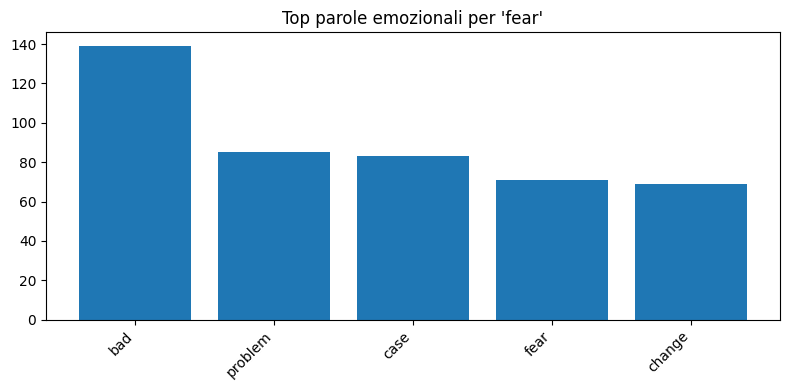

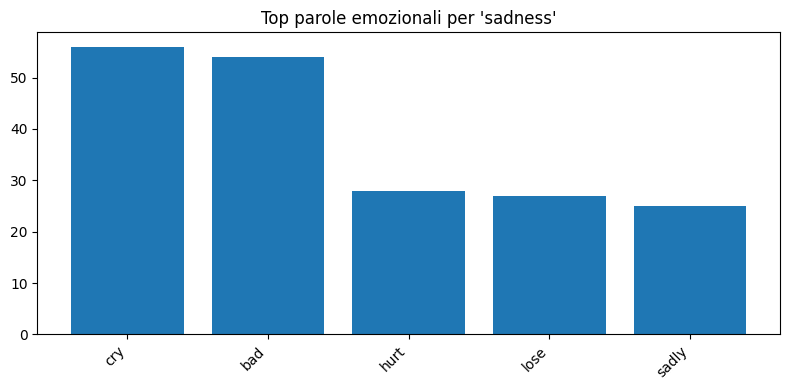

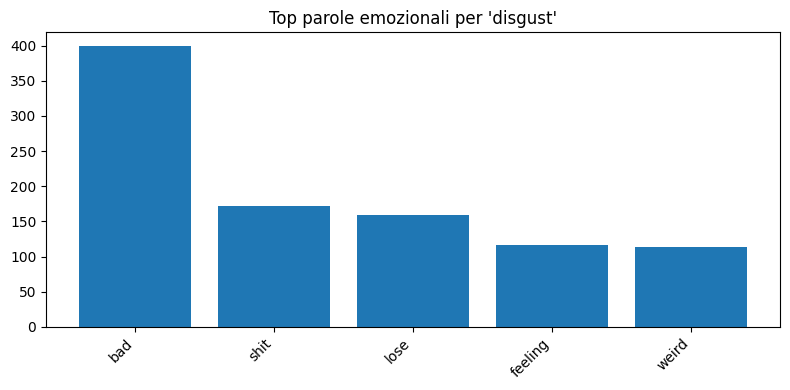

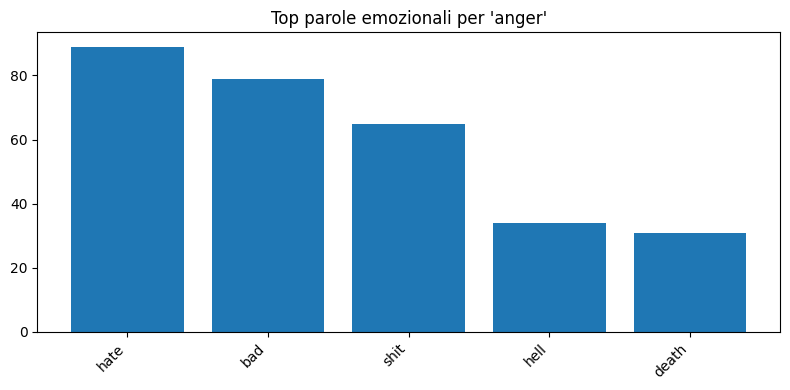

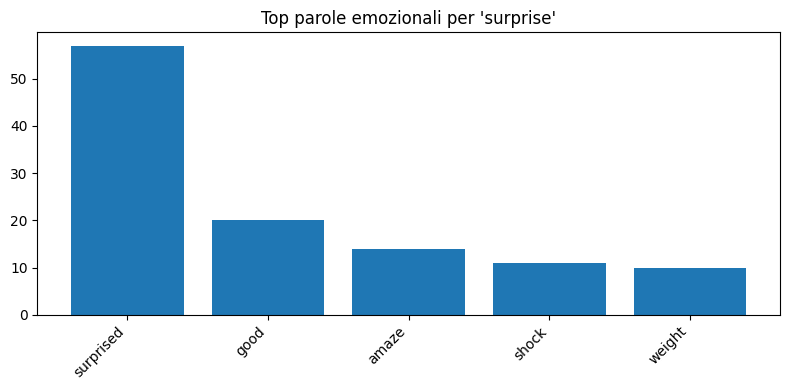

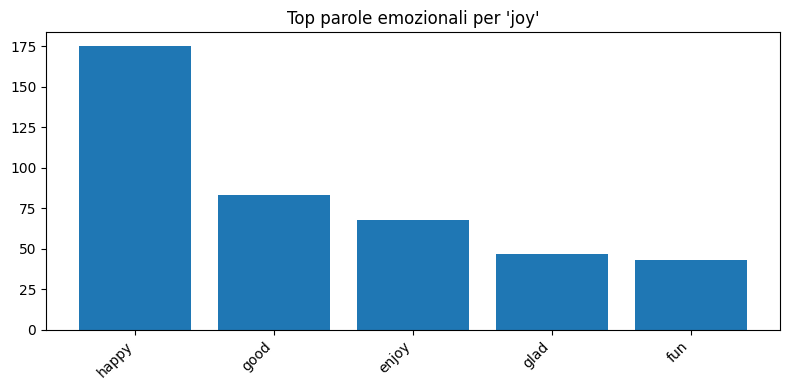

In [ ]:
emotion_words = defaultdict(list)           # Per ogni emozione, il codice raccoglie tutte le parole importanti associate nel dataset, calcola le 5 parole più frequenti e genera un grafico a barre per visualizzarle, permettendo di capire quali termini contribuiscono maggiormente a ciascuna emozione.

for _, row in df_contributi.iterrows():
    imp = row["important_words"]
    for emo, words in imp.items():
        for w in words:
            emotion_words[emo].append(w)


emotion_words = {emo: ws for emo, ws in emotion_words.items() if len(ws) > 0}

print(f"Emozioni con almeno 1 parola emozionale trovata: {len(emotion_words)}")

for emo, words in emotion_words.items():
    freq = Counter(words).most_common(5)
    labels = [w for w, _ in freq]
    counts = [c for _, c in freq]

    plt.figure(figsize=(8, 4))
    plt.bar(labels, counts)
    plt.title(f"Top parole emozionali per '{emo}'")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [ ]:
# Filtro per le sole frasi classificate in quanto non tutte hanno emozioni predette
df_classified = df_test1[df_test1['classificato1']].copy().reset_index(drop=True)

phrases_per_author = df_classified.groupby('author').size()

# Ricerca di autori che abbiano meno di 15 frasi (DataFrame composto da 30 quindi si cercano autori con meno della metà delle frasi)
authors_below_15 = phrases_per_author[phrases_per_author < 15]

# Numero minimo di frasi tra tutti gli autori
min_phrases = phrases_per_author.min()

indices_below_15 = list(authors_below_15.index)

print("Numero di frasi per autore:")
print(phrases_per_author)

print(f"\nNumero di autori con meno di 15 frasi: {len(authors_below_15)}")
print(f"Numero minimo di frasi tra gli autori: {min_phrases}")


Numero di frasi per autore:
author
-BigSexy-               26
-BlitzN9ne              20
-CrestiaBell            26
-dyad-                  24
-tactical-throw-away    24
                        ..
kalp456                 25
kalvinescobar           25
kaoru17                 22
kaqn                    29
katinahat               25
Length: 1000, dtype: int64

Numero di autori con meno di 15 frasi: 3
Numero minimo di frasi tra gli autori: 9


In [ ]:
df_classified_filtered = df_classified[~df_classified['author'].isin(indices_below_15)].reset_index(drop=True)  #Rimozione autori che hanno meno di 15 frasi

print(f"Numero di autori rimasti dopo il filtro: {df_classified_filtered['author'].nunique()}")
print(f"Numero di frasi rimaste: {len(df_classified_filtered)}")

Numero di autori rimasti dopo il filtro: 997
Numero di frasi rimaste: 25510


In [ ]:
def merge_strong_moderate_weak(row):
    strong   = row['predicted_emotions1_strong']   or []
    moderate = row['predicted_emotions1_moderate'] or []
    weak     = row['predicted_emotions1_weak']     or []

    return strong + moderate + weak

df_classified_filtered = df_classified_filtered.copy()
df_classified_filtered['predicted_emotions_lst'] = df_classified_filtered.apply(
    merge_strong_moderate_weak,
    axis=1
)


df_exploded = df_classified_filtered.explode('predicted_emotions_lst')
df_exploded = df_exploded.dropna(subset=['predicted_emotions_lst'])

# Costruzione matrice autore-emozione
emotion_presence = (
    df_exploded
    .groupby(['author', 'predicted_emotions_lst'])['body']
    .nunique()
    .unstack(fill_value=0)
)

# Conteggio totale frasi per autore
phrases_per_author = df_classified_filtered.groupby('author')['body'].nunique()

# Percentuali per autore
author_emotion_pct = emotion_presence.div(phrases_per_author, axis=0) * 100
author_emotion_pct = author_emotion_pct.round(2)

with pd.option_context('display.max_rows', 20, 'display.max_columns', None):
    display(emotion_presence.head(15))       # Per ogni autore stampa della matrice autore-emozione con il numero di frasi in cui ciascun autore esprime ogni emozione
    display(author_emotion_pct.head(15))     # Per ogni autore stampa la stessa matrice in percentuale rispetto al totale di frasi per autore, mostrando quanto frequentemente ogni autore esprime ciascuna emozione

predicted_emotions_lst  admiration  amusement  anger  annoyance  approval  \
author                                                                      
-BigSexy-                        0          0      0          2         9   
-BlitzN9ne                       2          2      1          3         5   
-CrestiaBell                     7          1      3          1         6   
-dyad-                           6          0      1          3         2   
-tactical-throw-away             4          1      4          3         5   
-yasu                            5          2      1          2         7   
12345jk12345                     2          1      6          4         6   
137288                           2          0      1          3         8   
1fastman1                        6          0      2          2         6   
1mas                             0          0      0          0         2   
22Starter22                      4          0      0          4         5   
247sleepy                        1          3      0          4         7   
3062226abcd                      3          2      2          4         3   
4OoztoFreedom                    7          3      0          1         8   
5426742                          5          1      0          4         8   

predicted_emotions_lst  caring  confusion  curiosity  desire  disappointment  \
author                                                                         
-BigSexy-                    0          1          7       0               0   
-BlitzN9ne                   0          2          2       0               0   
-CrestiaBell                 0          1          2       0               0   
-dyad-                       1          2          3       0               0   
-tactical-throw-away         1          2          2       0               0   
-yasu                        3          0          5       3               1   
12345jk12345                 2          0          7       0               1   
137288                       2          2         12       0               5   
1fastman1                    0          4          7       2               2   
1mas                         1          1          1       0               1   
22Starter22                  4          0          0       0               2   
247sleepy                    6          2          2       0               1   
3062226abcd                  0          4          4       1               5   
4OoztoFreedom                0          0          2       1               0   
5426742                      0          3          3       0               2   

predicted_emotions_lst  disapproval  disgust  embarrassment  excitement  fear  \
author                                                                          
-BigSexy-                         3        2              1           1     2   
-BlitzN9ne                        4        3              0           0     0   
-CrestiaBell                      4        3              0           0     0   
-dyad-                            4        6              0           1     1   
-tactical-throw-away              5        0              0           0     0   
-yasu                             1        1              1           2     0   
12345jk12345                      2        4              0           1     0   
137288                            6        0              0           0     1   
1fastman1                         1        1              0           1     1   
1mas                              5        0              0           1     0   
22Starter22                       1        3              0           2     0   
247sleepy                         2        4              0           0     2   
3062226abcd                       3        0              0           5     0   
4OoztoFreedom                     2        0              0           0     0   
5426742                          

predicted_emotions_lst  admiration  amusement  anger  annoyance  approval  \
author                                                                      
-BigSexy-                     0.00       0.00   0.00       8.00     36.00   
-BlitzN9ne                   10.53      10.53   5.26      15.79     26.32   
-CrestiaBell                 26.92       3.85  11.54       3.85     23.08   
-dyad-                       31.58       0.00   5.26      15.79     10.53   
-tactical-throw-away         16.67       4.17  16.67      12.50     20.83   
-yasu                        20.00       8.00   4.00       8.00     28.00   
12345jk12345                  8.33       4.17  25.00      16.67     25.00   
137288                        6.90       0.00   3.45      10.34     27.59   
1fastman1                    21.43       0.00   7.14       7.14     21.43   
1mas                          0.00       0.00   0.00       0.00     13.33   
22Starter22                  16.67       0.00   0.00      16.67     20.83   
247sleepy                     3.85      11.54   0.00      15.38     26.92   
3062226abcd                  11.54       7.69   7.69      15.38     11.54   
4OoztoFreedom                31.82      13.64   0.00       4.55     36.36   
5426742                      19.23       3.85   0.00      15.38     30.77   

predicted_emotions_lst  caring  confusion  curiosity  desire  disappointment  \
author                                                                         
-BigSexy-                 0.00       4.00      28.00    0.00            0.00   
-BlitzN9ne                0.00      10.53      10.53    0.00            0.00   
-CrestiaBell              0.00       3.85       7.69    0.00            0.00   
-dyad-                    5.26      10.53      15.79    0.00            0.00   
-tactical-throw-away      4.17       8.33       8.33    0.00            0.00   
-yasu                    12.00       0.00      20.00   12.00            4.00   
12345jk12345              8.33       0.00      29.17    0.00            4.17   
137288                    6.90       6.90      41.38    0.00           17.24   
1fastman1                 0.00      14.29      25.00    7.14            7.14   
1mas                      6.67       6.67       6.67    0.00            6.67   
22Starter22              16.67       0.00       0.00    0.00            8.33   
247sleepy                23.08       7.69       7.69    0.00            3.85   
3062226abcd               0.00      15.38      15.38    3.85           19.23   
4OoztoFreedom             0.00       0.00       9.09    4.55            0.00   
5426742                   0.00      11.54      11.54    0.00            7.69   

predicted_emotions_lst  disapproval  disgust  embarrassment  excitement  fear  \
author                                                                          
-BigSexy-                     12.00     8.00            4.0        4.00  8.00   
-BlitzN9ne                    21.05    15.79            0.0        0.00  0.00   
-CrestiaBell                  15.38    11.54            0.0        0.00  0.00   
-dyad-                        21.05    31.58            0.0        5.26  5.26   
-tactical-throw-away          20.83     0.00            0.0        0.00  0.00   
-yasu                          4.00     4.00            4.0        8.00  0.00   
12345jk12345                   8.33    16.67            0.0        4.17  0.00   
137288                        20.69     0.00            0.0        0.00  3.45   
1fastman1                      3.57     3.57            0.0        3.57  3.57   
1mas                          33.33     0.00            0.0        6.67  0.00   
22Starter22                    4.17    12.50            0.0        8.33  0.00   
247sleepy                      7.69    15.38            0.0        0.00  7.69   
3062226abcd                   11.54     0.00            0.0       19.23  0.00   
4OoztoFreedom                  9.09     0.00            0.0        0.00  0.00   
5426742                        3.

In [ ]:
top_n = 3
rows = []

authors = author_emotion_pct.index

for author in authors:
    pct = author_emotion_pct.loc[author]

    pct_pos = pct[pct > 0]

    if pct_pos.empty:
        rows.append({
            'author': author,
            'top_emotions': ["nessuna emozione predetta"],
            'top_emotions_pct': [],
            'strong_emotions': [],
            'moderate_emotions': [],
            'weak_emotions': [],
            'top_emotions_labeled': ["nessuna emozione predetta"]
        })
        continue

    pct_sorted = pct_pos.sort_values(ascending=False)
    top_idx    = pct_sorted.head(top_n).index
    top_values = pct_sorted.head(top_n).values

    top_emotions     = list(top_idx)
    top_emotions_pct = list(top_values)


    soglia_forte    = 50.0
    soglia_moderata = 25.0

    strong_emotions   = [emo for emo, val in zip(top_emotions, top_emotions_pct) if val >= soglia_forte]
    moderate_emotions = [emo for emo, val in zip(top_emotions, top_emotions_pct) if soglia_moderata <= val < soglia_forte]
    weak_emotions     = [emo for emo, val in zip(top_emotions, top_emotions_pct) if 0 < val < soglia_moderata]

    labeled = []
    for emo, val in zip(top_emotions, top_emotions_pct):
        if emo in strong_emotions:
            labeled.append(f"{emo} (forte: {val:.2f}%)")
        elif emo in moderate_emotions:
            labeled.append(f"{emo} (moderata: {val:.2f}%)")
        else:
            labeled.append(f"{emo} (debole: {val:.2f}%)")

    rows.append({
        'author': author,
        'top_emotions': top_emotions,
        'top_emotions_pct': top_emotions_pct,
        'strong_emotions': strong_emotions,
        'moderate_emotions': moderate_emotions,
        'weak_emotions': weak_emotions,
        'top_emotions_labeled': labeled
    })

df_author_top_emotions = pd.DataFrame(rows)

with pd.option_context('display.max_rows', 15, 'display.max_columns', None):
    display(df_author_top_emotions.head(15))

author                             top_emotions  \
0              -BigSexy-       [approval, curiosity, realization]   
1             -BlitzN9ne       [approval, disapproval, annoyance]   
2           -CrestiaBell             [love, admiration, approval]   
3                 -dyad-              [admiration, love, disgust]   
4   -tactical-throw-away      [approval, disapproval, admiration]   
5                  -yasu        [approval, admiration, curiosity]   
6           12345jk12345             [curiosity, anger, approval]   
7                 137288       [curiosity, approval, disapproval]   
8              1fastman1        [curiosity, admiration, surprise]   
9                   1mas    [disapproval, realization, gratitude]   
10           22Starter22        [approval, admiration, annoyance]   
11             247sleepy            [approval, caring, gratitude]   
12           3062226abcd  [disappointment, excitement, curiosity]   
13         4OoztoFreedom        [approval, admiration, amusement]   
14               5426742          [approval, disgust, admiration]   

         top_emotions_pct strong_emotions             moderate_emotions  \
0      [36.0, 28.0, 20.0]              []         [approval, curiosity]   
1   [26.32, 21.05, 15.79]              []                    [approval]   
2   [30.77, 26.92, 23.08]              []            [love, admiration]   
3   [31.58, 31.58, 31.58]              []   [admiration, love, disgust]   
4   [20.83, 20.83, 16.67]              []                            []   
5      [28.0, 20.0, 20.0]              []                    [approval]   
6     [29.17, 25.0, 25.0]              []  [curiosity, anger, approval]   
7   [41.38, 27.59, 20.69]              []         [curiosity, approval]   
8    [25.0, 21.43, 21.43]              []                   [curiosity]   
9   [33.33, 26.67, 13.33]              []    [disapproval, realization]   
10  [20.83, 16.67, 16.67]              []                            []   
11  [26.92, 23.08, 23.08]              []                    [approval]   
12  [19.23, 19.23, 15.38]              []                            []   
13  [36.36, 31.82, 13.64]              []        [approval, admiration]   
14  [30.77, 23.08, 19.23]              []                    [approval]   

                              weak_emotions  \
0                             [realization]   
1                  [disapproval, annoyance]   
2                                [approval]   
3                                        []   
4       [approval, disapproval, admiration]   
5                   [admiration, curiosity]   
6                                        []   
7                             [disapproval]   
8                    [admiration, surprise]   
9                               [gratitude]   
10        [approval, admiration, annoyance]   
11                      [caring, gratitude]   
12  [disappointment, excitement, curiosity]   
13                              [amusement]   
14                    [disgust, admiration]   

                                                                            top_emotions_labeled  
0      [approval (moderata: 36.00%), curiosity (moderata: 28.00%), realization (debole: 20.00%)]  
1        [approval (moderata: 26.32%), disapproval (debole: 21.05%), annoyance (debole: 15.79%)]  
2            [love (moderata: 30.77%), admiration (moderata: 26.92%), approval (debole: 23.08%)]  
3           [admiration (moderata: 31.58%), love (moderata: 31.58%), disgust (moderata: 31.58%)]  
4         [approval (debole: 20.83%), disapproval (debole: 20.83%), admiration (debole: 16.67%)]  
5         [approval (moderata: 28.00%), admiration (debole: 20.00%), curiosity (debole: 20.00%)]  
6          [curiosity (moderata: 29.17%), anger (moderata: 25.00%), approval (moderata: 25.00%)]  
7      [curiosity (moderata: 41.38%), approval (moderata: 27.59%), disapproval (debole: 20.69%)]  
8         [curiosity (moderata: 25.00%), admiration (debole: 21.43%)

Il codice analizza le emozioni predominanti per ciascun autore partendo dalle percentuali di emozioni predette.
Per ogni autore:

– Seleziona solo le emozioni presenti (percentuale > 0)

– Ordina le emozioni per frequenza e prende le top-3

– Classifica l’intensità di ciascuna in forte, moderata o debole usando due soglie (≥50%, ≥25%)

– Genera un’etichetta testuale che combina emozione e intensità (es. joy – forte: 62%)

Il risultato è una tabella che riassume per ogni autore le emozioni più rappresentative, la loro intensità e una versione etichettata pronta per l’interpretazione qualitativa.

In [ ]:
author_emotion_words = defaultdict(lambda: defaultdict(list))

for idx, row in df_contributi.iterrows():
    author = row["author"]
    imp = row["important_words"]

    if not isinstance(imp, dict):
        continue

    for emo, words in imp.items():
        for w in words:
            author_emotion_words[author][emo].append(w)



rows = []

for idx, row in df_author_top_emotions.iterrows():

    author = row["author"]
    top_emotions = row["top_emotions"]


    if top_emotions == ["nessuna emozione predetta"]:
        rows.append({
            "author": author,
            "top_emotions": top_emotions,
            "emotion_words": {}
        })
        continue


    emo_words_filtered = {}

    for emo in top_emotions:
        words = author_emotion_words[author].get(emo, [])
        freq = Counter(words).most_common(10)
        emo_words_filtered[emo] = [w for w, c in freq]

    rows.append({
        "author": author,
        "top_emotions": top_emotions,
        "emotion_words": emo_words_filtered
    })

df_author_words_clean = pd.DataFrame(rows)


df_non_empty = df_author_words_clean[
    df_author_words_clean["emotion_words"].apply(lambda d: any(len(v) > 0 for v in d.values()))
]

print(f"Autori con parole emozionali trovate: {len(df_non_empty)}")

df_non_empty.head(15)

Autori con parole emozionali trovate: 264


author                       top_emotions  \
3                 -dyad-        [admiration, love, disgust]   
6           12345jk12345       [curiosity, anger, approval]   
8              1fastman1  [curiosity, admiration, surprise]   
14               5426742    [approval, disgust, admiration]   
22            AbiRNormal   [admiration, gratitude, disgust]   
23  AbstractStateMachine    [approval, admiration, disgust]   
29             AkumaRose     [approval, disgust, curiosity]   
33       AliceFishyWishy     [disgust, annoyance, approval]   
34           AliceKettle              [fear, disgust, love]   
36             Alsedarna          [disgust, love, approval]   
57     AureliusPendragon  [annoyance, disapproval, disgust]   
59       AverageJoeflake         [approval, disgust, anger]   
65            Baxter0402  [annoyance, disgust, disapproval]   
69      Bhikkhu_Jayasara   [disgust, approval, disapproval]   
70               BigMcK_  [annoyance, disapproval, disgust]   

                                                                                                                                                                                                                    emotion_words  
3                                                                          {'admiration': [], 'love': [], 'disgust': ['interested', 'glitter', 'frustrate', 'terrible', 'mad', 'treat', 'hate', 'dislike', 'unnatural', 'rigor']}  
6                                                                                                                                                                           {'curiosity': [], 'anger': ['bitch'], 'approval': []}  
8                                                                                                                                                               {'curiosity': [], 'admiration': [], 'surprise': ['surprisingly']}  
14                                                                                      {'approval': [], 'disgust': ['lawyer', 'weight', 'fraudulent', 'criminal', 'theft', 'abuse', 'smell', 'treat', 'lose'], 'admiration': []}  
22                                                                                                                                 {'admiration': [], 'gratitude': [], 'disgust': ['crap', 'finally', 'stomach', 'bad', 'smell']}  
23                                                                                                                                       {'approval': [], 'admiration': [], 'disgust': ['copycat', 'deceitful', 'bad', 'weight']}  
29                                                                                                               {'approval': [], 'disgust': ['honest', 'selfish', 'devil', 'bad', 'lord', 'disaster', 'flesh'], 'curiosity': []}  
33                                                                             {'disgust': ['lonely', 'enemy', 'parrot', 'smell', 'fugitive', 'bad', 'horrible', 'unwashed', 'greasy', 'burnt'], 'annoyance': [], 'approval': []}  
34  {'fear': ['bad', 'feeling', 'kill', 'villain', 'problem', 'watch', 'bitch', 'bug', 'dangerous', 'death'], 'disgust': ['bad', 'selfish', 'feeling', 'bitch', 'angry', 'lie', 'death', 'drunken', 'shit', 'treat'], 'love': []}  
36                                                                                            {'disgust': ['enemy', 'damage', 'honest', 'opponent', 'bad', 'kite', 'lie', 'death', 'murder', 'damn'], 'love': [], 'approval': []}  
57                                                                                 {'annoyance': [], 'disapproval': [], 'disgust': ['bad', 'blame', 'lie', 'terrible', 'shit', 'poverty', 'toxic', 'slum', 'damn', 'ridiculous']}  
59                                                         {'approval': [], 'disgust': ['weird', 'lose', 'asshole', 'bad', 'hate'], 'anger': ['hate', 'lose', 'anxiety', 'darkness', 'asshole', 'crazy', 'bad', 'shit', 'awful']}  
65                                           

Il codice collega le emozioni predominanti di ogni autore alle parole emozionali che hanno contribuito a generarle.
Per ogni autore:

– Raccoglie tutte le parole emozionali trovate nelle sue frasi, organizzate per emozione

– Seleziona solo le emozioni top (quelle già individuate nella tabella precedente)

– Estrae fino a 10 parole più frequenti per ciascuna emozione tramite Counter

– Costruisce una tabella che mostra, per ogni autore, le sue emozioni principali e le parole che le caratterizzano

In [ ]:
df_class=df_classified_filtered.copy()
rows, cols = df_class.shape
print("Righe:", rows)
print("Colonne:", cols)

Righe: 25510
Colonne: 55


In [ ]:
# Conteggio numero di frasi per ogni autore
phrases_per_author = (
    df_class
    .groupby('author')['body']
    .nunique()
    .rename('n_frasi')
)

# Filtro per gli autori con almeno 1 emozione forte
authors_with_strong = df_author_top_emotions[
    df_author_top_emotions['strong_emotions'].apply(lambda x: len(x) > 0)
].copy()


authors_with_strong = authors_with_strong.merge(
    phrases_per_author,
    on='author',
    how='left'
)

print("Numero di autori con almeno una strong emotion:", len(authors_with_strong))

display(
    authors_with_strong[['author', 'strong_emotions', 'n_frasi']]       # Stampa autore, emozioni forti se presenti e numero di frasi
    .sort_values('n_frasi', ascending=False)
    .head(20)
)

Numero di autori con almeno una strong emotion: 46


author strong_emotions  n_frasi
18            Lorpo314      [approval]       30
37           buckarina       [disgust]       30
32            aelendel   [disapproval]       30
20     MetricExpansion       [disgust]       30
16            Kazejin0      [approval]       30
36            blushdot       [disgust]       29
19           Lowego408     [gratitude]       29
45  itstrue_ididnotlie      [approval]       29
0          AliceKettle          [fear]       28
1            Alsedarna       [disgust]       28
11           Fireskink      [approval]       28
8          DSMan195276   [disapproval]       28
25         RedPillSafe      [approval]       28
14   Itsnotadeathglare       [disgust]       28
29     TheInfernalRain      [approval]       28
43           goyo_goyo      [approval]       28
35             beastgp    [admiration]       28
4       BubblesAndSass      [approval]       27
13          HippeHoppe          [fear]       27
34           antoineks   [disapproval]       27

In [ ]:
mask = df_author_top_emotions['top_emotions'].apply(
    lambda lst: (
        isinstance(lst, list)
        and all(e != "nessuna emozione predetta" for e in lst)
        and len(lst) > 0
    )
)

df_emotions_ocean = df_author_top_emotions[mask].merge(
    author_profiles_df_cleaned[['author'] + personality_cols],
    on='author',
    how='inner'
)

with pd.option_context('display.max_rows', 15, 'display.max_colwidth', 80):
    display(df_emotions_ocean.head(15)) # Stampa di un nuovo df che contiene per ogni autore le top_emotions, le percentuali, quali sono forti, moderate o deboli e le unisce ai valori OCEAN propri dell'autore

author                             top_emotions  \
0              -BigSexy-       [approval, curiosity, realization]   
1             -BlitzN9ne       [approval, disapproval, annoyance]   
2           -CrestiaBell             [love, admiration, approval]   
3                 -dyad-              [admiration, love, disgust]   
4   -tactical-throw-away      [approval, disapproval, admiration]   
5                  -yasu        [approval, admiration, curiosity]   
6           12345jk12345             [curiosity, anger, approval]   
7                 137288       [curiosity, approval, disapproval]   
8              1fastman1        [curiosity, admiration, surprise]   
9                   1mas    [disapproval, realization, gratitude]   
10           22Starter22        [approval, admiration, annoyance]   
11             247sleepy            [approval, caring, gratitude]   
12           3062226abcd  [disappointment, excitement, curiosity]   
13         4OoztoFreedom        [approval, admiration, amusement]   
14               5426742          [approval, disgust, admiration]   

         top_emotions_pct strong_emotions             moderate_emotions  \
0      [36.0, 28.0, 20.0]              []         [approval, curiosity]   
1   [26.32, 21.05, 15.79]              []                    [approval]   
2   [30.77, 26.92, 23.08]              []            [love, admiration]   
3   [31.58, 31.58, 31.58]              []   [admiration, love, disgust]   
4   [20.83, 20.83, 16.67]              []                            []   
5      [28.0, 20.0, 20.0]              []                    [approval]   
6     [29.17, 25.0, 25.0]              []  [curiosity, anger, approval]   
7   [41.38, 27.59, 20.69]              []         [curiosity, approval]   
8    [25.0, 21.43, 21.43]              []                   [curiosity]   
9   [33.33, 26.67, 13.33]              []    [disapproval, realization]   
10  [20.83, 16.67, 16.67]              []                            []   
11  [26.92, 23.08, 23.08]              []                    [approval]   
12  [19.23, 19.23, 15.38]              []                            []   
13  [36.36, 31.82, 13.64]              []        [approval, admiration]   
14  [30.77, 23.08, 19.23]              []                    [approval]   

                              weak_emotions  \
0                             [realization]   
1                  [disapproval, annoyance]   
2                                [approval]   
3                                        []   
4       [approval, disapproval, admiration]   
5                   [admiration, curiosity]   
6                                        []   
7                             [disapproval]   
8                    [admiration, surprise]   
9                               [gratitude]   
10        [approval, admiration, annoyance]   
11                      [caring, gratitude]   
12  [disappointment, excitement, curiosity]   
13                              [amusement]   
14                    [disgust, admiration]   

                                                               top_emotions_labeled  \
0   [approval (moderata: 36.00%), curiosity (moderata: 28.00%), realization (deb...   
1   [approval (moderata: 26.32%), disapproval (debole: 21.05%), annoyance (debol...   
2   [love (moderata: 30.77%), admiration (moderata: 26.92%), approval (debole: 2...   
3   [admiration (moderata: 31.58%), love (moderata: 31.58%), disgust (moderata: ...   
4   [approval (debole: 20.83%), disapproval (debole: 20.83%), admiration (debole...   
5   [approval (moderata: 28.00%), admiration (debole: 20.00%), curiosity (debole...   
6   [curiosity (moderata: 29.17%), anger (moderata: 25.00%), approval (moderata:...   
7   [curiosity (moderata: 41.38%), approval (moderata: 27.59%), disapproval (deb...   
8   [curiosity (moderata: 25.00%), admiration (debole: 21.43%), surprise (debole...   
9   [disapproval (moderata: 33.33%), realization (moderata: 26.67%), gratitude (...   
10

In [ ]:
df_full = author_emotion_pct.copy()

df_full = df_full.merge(
    author_profiles_df_cleaned[['author'] + personality_cols],
    left_index=True,
    right_on='author',
    how='inner'
).set_index('author')


# Liste di emozioni per macro-categorie
social_list        = ['love', 'gratitude', 'caring', 'approval', 'admiration', 'pride']
cognitive_list     = ['curiosity', 'realization', 'confusion', 'surprise', 'desire']
fun_list           = ['amusement', 'joy', 'excitement', 'optimism', 'relief']
fear_list          = ['fear', 'nervousness']
sad_list           = ['sadness', 'grief', 'remorse', 'disappointment']
anger_list         = ['anger', 'annoyance', 'disapproval', 'disgust']
embarrassment_list = ['embarrassment']

def safe_sum(df, cols):
    cols = [c for c in cols if c in df.columns]
    return df[cols].sum(axis=1)



df_full['raw_social']    = safe_sum(df_full, social_list)
df_full['raw_cognitive'] = safe_sum(df_full, cognitive_list)
df_full['raw_fun']       = safe_sum(df_full, fun_list)
df_full['raw_outrage']   = safe_sum(df_full, anger_list + embarrassment_list)
df_full['raw_fearsad']   = safe_sum(df_full, fear_list + sad_list)

raw_cols = ['raw_social','raw_cognitive','raw_fun','raw_outrage','raw_fearsad']

df_full['raw_total'] = df_full[raw_cols].sum(axis=1)
df_full['raw_total'] = df_full['raw_total'].replace(0, 1)



df_full['pct_social']    = (df_full['raw_social']    / df_full['raw_total'] * 100).round(2)
df_full['pct_cognitive'] = (df_full['raw_cognitive'] / df_full['raw_total'] * 100).round(2)
df_full['pct_fun']       = (df_full['raw_fun']       / df_full['raw_total'] * 100).round(2)
df_full['pct_outrage']   = (df_full['raw_outrage']   / df_full['raw_total'] * 100).round(2)
df_full['pct_fearsad']   = (df_full['raw_fearsad']   / df_full['raw_total'] * 100).round(2)

pct_cols = ['pct_social','pct_cognitive','pct_fun','pct_outrage','pct_fearsad']


df_full[pct_cols + personality_cols] = df_full[pct_cols + personality_cols].apply(
    pd.to_numeric,
    errors='coerce'
)

numeric_cols = pct_cols + personality_cols



target_rows = pct_cols
target_cols = personality_cols


corr = df_full[numeric_cols].corr(method='spearman') # Uso della correlazione Sperman perchè più adatta ai dati non lineari

corr_pct = corr.loc[target_rows, target_cols].round(2)

corr_dict = corr_pct.to_dict(orient="index")

data = corr_pct.to_dict(orient='list')

display(corr_pct)


agreeableness  openness  conscientiousness  extraversion  \
pct_social              0.10      0.04               0.07          0.06   
pct_cognitive          -0.09     -0.04              -0.02          0.01   
pct_fun                 0.01     -0.03               0.03         -0.04   
pct_outrage            -0.02      0.08              -0.04         -0.01   
pct_fearsad             0.03     -0.05              -0.09         -0.09   

               neuroticism  
pct_social           -0.03  
pct_cognitive         0.06  
pct_fun               0.04  
pct_outrage          -0.08  
pct_fearsad           0.09

In [ ]:
def stampa_corr(cluster):
    righe = []
    for tratto, valore in corr_dict[cluster].items():
        righe.append(f"* **{tratto.capitalize()}:** {valore:+.2f}")
    return "\n".join(righe)

Per esplorare la relazione tra componente emotiva e componente cognitiva dello stile linguistico, le emozioni predette sono state raggruppate in cinque cluster principali, così da rappresentare aree emotive più ampie e stabili rispetto alle singole etichette.
Tale scelta si ispira a due studi di riferimento su linguaggio e personalità, i quali si aggiungono a quelli già previsti nell’indice e si inseriscono come documenti nella parte applicativa: “Personality in 100,000 Words: A large-scale analysis of personality and word use among bloggers” e “Personality, Gender, and Age in the Language of Social Media: The Open-Vocabulary Approach”. In entrambi i documenti il comportamento linguistico viene analizzato principalmente attraverso categorie aggregate (es. Positive emotion, Negative emotion, Social processes, Cognitive processes).

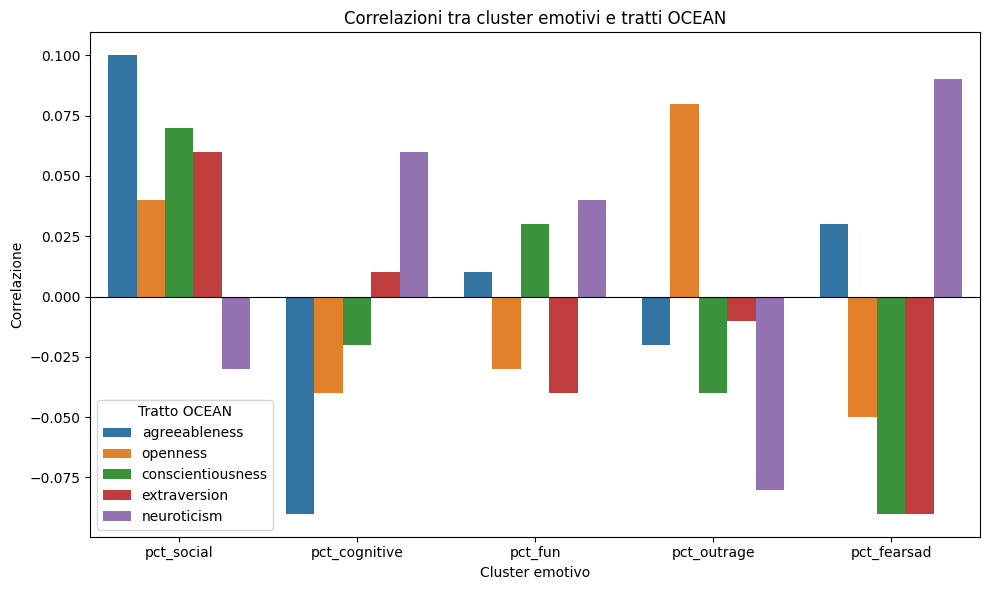

In [ ]:
df_corr = corr_pct.copy()

df_long = df_corr.reset_index().melt(id_vars='index', var_name='Trait', value_name='Correlation')
df_long.rename(columns={'index': 'Emotion'}, inplace=True)


plt.figure(figsize=(10,6))
sns.barplot(data=df_long, x='Emotion', y='Correlation', hue='Trait')
plt.title("Correlazioni tra cluster emotivi e tratti OCEAN")
plt.axhline(0, color='black', linewidth=0.8)
plt.ylabel("Correlazione")
plt.xlabel("Cluster emotivo")
plt.legend(title="Tratto OCEAN")
plt.tight_layout()
plt.show()

In [ ]:
testo_corr = f"""
# **Correlazioni tra cluster emotivi e tratti OCEAN**

Le correlazioni tra i cluster emotivi e i tratti di personalità OCEAN indicano
tendenze statistiche complessivamente deboli, interpretabili esclusivamente
a livello aggregato.

## **Cluster sociale – `pct_social`**
*(love, gratitude, caring, approval, admiration, pride)*

Correlazioni con i tratti OCEAN:

{stampa_corr("pct_social")}

## **Cluster cognitivo – `pct_cognitive`**
*(curiosity, realization, confusion, surprise, desire)*

Correlazioni con i tratti OCEAN:

{stampa_corr("pct_cognitive")}

## **Cluster ludico-positivo – `pct_fun`**
*(amusement, joy, excitement, optimism, relief)*

Correlazioni con i tratti OCEAN:

{stampa_corr("pct_fun")}

## **Cluster di indignazione / conflitto – `pct_outrage`**
*(anger, disapproval, annoyance, disgust, embarrassment)*

Correlazioni con i tratti OCEAN:

{stampa_corr("pct_outrage")}

## **Cluster ansioso/triste – `pct_fearsad`**
*(fear, nervousness, sadness, grief, remorse, disappointment)*

Correlazioni con i tratti OCEAN:

{stampa_corr("pct_fearsad")}
"""
display(Markdown(testo_corr))



# **Correlazioni tra cluster emotivi e tratti OCEAN**

Le correlazioni tra i cluster emotivi e i tratti di personalità OCEAN indicano
tendenze statistiche complessivamente deboli, interpretabili esclusivamente
a livello aggregato.

## **Cluster sociale – `pct_social`**
*(love, gratitude, caring, approval, admiration, pride)*

Correlazioni con i tratti OCEAN:

* **Agreeableness:** +0.10
* **Openness:** +0.04
* **Conscientiousness:** +0.07
* **Extraversion:** +0.06
* **Neuroticism:** -0.03

## **Cluster cognitivo – `pct_cognitive`**
*(curiosity, realization, confusion, surprise, desire)*

Correlazioni con i tratti OCEAN:

* **Agreeableness:** -0.09
* **Openness:** -0.04
* **Conscientiousness:** -0.02
* **Extraversion:** +0.01
* **Neuroticism:** +0.06

## **Cluster ludico-positivo – `pct_fun`**
*(amusement, joy, excitement, optimism, relief)*

Correlazioni con i tratti OCEAN:

* **Agreeableness:** +0.01
* **Openness:** -0.03
* **Conscientiousness:** +0.03
* **Extraversion:** -0.04
* **Neuroticism:** +0.04

## **Cluster di indignazione / conflitto – `pct_outrage`**
*(anger, disapproval, annoyance, disgust, embarrassment)*

Correlazioni con i tratti OCEAN:

* **Agreeableness:** -0.02
* **Openness:** +0.08
* **Conscientiousness:** -0.04
* **Extraversion:** -0.01
* **Neuroticism:** -0.08

## **Cluster ansioso/triste – `pct_fearsad`**
*(fear, nervousness, sadness, grief, remorse, disappointment)*

Correlazioni con i tratti OCEAN:

* **Agreeableness:** +0.03
* **Openness:** -0.05
* **Conscientiousness:** -0.09
* **Extraversion:** -0.09
* **Neuroticism:** +0.09


# **Correlazioni tra cluster emotivi e tratti OCEAN**

## **Cluster sociale – `pct_social`**  
*(love, gratitude, caring, approval, admiration, pride)*

* I profili più cooperativi e **Agreeableness elevato** mostrano una lieve tendenza ad utilizzare un linguaggio sociale, affettivo, basato su gratitudine, approvazione e vicinanza.
* È un pattern coerente con la letteratura: chi è empatico e orientato alla relazione tende a utilizzare un **lessico affiliativo e prosociale**.


## **Cluster cognitivo – `pct_cognitive`**  
*(curiosity, realization, confusion, surprise, desire)*


* In questo dataset, le emozioni cognitive non sembrano riflettere un curiosità esplorativa, bensì una forma di elaborazione cognitiva, spesso associata a  **situazioni di incertezza, dubbio o riflessione problematica** come suggerito dalla presenza di emozioni quali confusion e realization.
* Le deboli correlazioni **negative** con Openness ed Extraversion insieme alla correlazione positiva con Neuroticism suggeriscono che questo linguaggio cognitivo emerga più facilmente in contesti di tensione cognitiva, piuttosto che come espressione di apertura mentale serena.




## **Cluster ludico-positivo – `pct_fun`**  
*(amusement, joy, excitement, optimism, relief)*


* Le lievi associazioni positive con **Neuroticism** e **Conscientiousness** possono essere interpretate risultano teoricamente interpretabili. Il legame con **Neuroticism** può essere ricondotto al fatto che questo tratto riflette una maggiore reattività emotiva generale: individui più reattivi tendono a esprimere con maggiore frequenza gli stati emotivi, non solo negativi ma anche positivi, come entusiasmo, sollievo o eccitazione. La lieve associazione con **Conscientiousnesséé può invece essere spiegata in termini situazionali, poiché emozioni come relief e optimism emergono spesso in risposta al completamento di un compito o al raggiungimento di un obiettivo, senza implicare una disposizione ludica stabile.



## **Cluster di indignazione / conflitto – `pct_outrage`**  
*(anger, disapproval, annoyance, disgust, embarrassment)*


* La correlazione negativa con **Agreeableness** suggerisce una tendenza, seppur debole, a un maggiore utilizzo di **linguaggio ostile, critico o polarizzante**.
* La relazione debolmente negativa con Conscientiousness indica che questo tipo di linguaggio può emergere con maggiore frequenza in profili caratterizzati da **minore regolazione comportamentale**, in quanto potrebbero esprimere più frustrazione, fastidio e disapprovazione.


## **Cluster ansioso/triste – `pct_fearsad`**  
*(fear, nervousness, sadness, grief, remorse, disappointment)*


* Il legame più chiaro è con **Neuroticism**: chi è più emotivamente sensibile, instabile o facilmente turbabile tende a usare più linguaggio legato a **paura, tristezza, preoccupazione e rimpianto**.
* Le correlazioni negative con Openness ed Extraversion suggeriscono che questo tipo di linguaggio possa essere leggermente più frequente in individui meno aperti e più introversi rispetto agli altri.

* In conclusione, sebbene le correlazioni siano deboli, le direzioni dei coefficienti non risultano in contrasto con le principali aspettative teoriche sui tratti OCEAN:
  * linguaggio sociale/positivo ↔ maggiore Agreeableness, Openness, Extraversion  
  * linguaggio ostile ↔ minore Agreeableness  
  * linguaggio ansioso/triste ↔ maggiore Neuroticism



Le correlazioni tra i cluster emotivi e i tratti OCEAN, pur non essendo elevate , risultano coerenti con quanto riportato nella letteratura psicologica sul linguaggio. Nello studio di Yarkoni (2010), basato su oltre 100.000 testi, il Neuroticism mostra associazioni positive con parole legate a emozioni negative, come quelle delle categorie LIWC Anxiety/Fear, Sadness, Anger e Negative Emotions. Al contrario, l’Extraversion è legata all’uso di parole che esprimono emozioni positive e processi interpersonali (Positive Emotions, Social Processes, Friends, Sexuality).

L’Agreeableness, tratto legato alla cooperazione e alla cordialità, presenta correlazioni positive con parole di natura sociale e positiva (Family, Friends, Positive Emotions) e negative con parole ostili, in particolare nelle categorie Anger e Swear Words. Anche a livello dei sotto-fattori, Yarkoni osserva pattern analoghi: i facet ansiosi e depressivi del Neuroticism correlano sistematicamente con lessico negativo, mentre i facet più sociali dell’Extraversion (Friendliness, Gregariousness, Cheerfulness) sono associati a linguaggio positivo e orientato alla socialità. I facet dell’Agreeableness, invece, tendono a correlare negativamente con termini legati alla rabbia e al conflitto.

Per quanto riguarda l’Openness, i risultati di Yarkoni mostrano che questo tratto è associato soprattutto all’uso di parole concettuali, astratte e legate a interessi intellettuali (poet, culture, narrative, art, universe, literature). Si tratta quindi di un tratto che non si lega a emozioni specifiche, ma a un linguaggio più riflessivo e cognitivo. Questo giustifica l’associazione del cluster “cognitivo” (curiosity, realization, surprise, desire) con Openness.

Il tratto di Conscientiousness, in entrambe le fonti, non mostra correlazioni significative con emozioni: Yarkoni evidenzia un numero molto limitato di parole associate (meno di 30) e nessuna di esse appartiene a categorie emotive; si tratta piuttosto di termini legati a lavoro, obiettivi e compiti (categorie LIWC Occupation, Job/work, Achievement). Per questo motivo non esistono, nei due articoli, evidenze che giustifichino una mappatura diretta tra Conscientiousness e specifiche emozioni.

Nel complesso, questi risultati confermano che pattern come “linguaggio ansioso/triste ↔ Neuroticism”, “linguaggio sociale/positivo ↔ Extraversion e Agreeableness” , “linguaggio ostile ↔ bassa Agreeableness”, “linguaggio ostile ↔ bassa Agreeableness” e “linguaggio cognitivo/astratto ↔ Openness” sono pienamente coerenti con le evidenze empiriche sul rapporto tra linguaggio emotivo e personalità. Sebbene le correlazioni siano modeste, questo è del tutto normale nelle ricerche sul linguaggio: anche in Yarkoni, infatti, i valori si collocano generalmente tra ±0.05 e ±0.20, costituendo comunque segnali psicologici deboli ma interpretabili.

# ANALISI DEL CONTESTO COMUNICATIVO

Analisi del contesto discorsivo in cui emergono i comportamenti osservati, ricostruito attraverso l’esame dei temi di discussione e dei pattern emotivi associati ai contenuti

In [5]:
def read_csv_from_github(url, output):
    gdown.download(url, output, quiet=False)
    return pd.read_csv(output)

df_perambiente  = read_csv_from_github("https://raw.githubusercontent.com/RosariaCDiLauro/psychographic-profiling-experiment/refs/heads/main/assets/df_perambiente.csv", "df_perambiente.csv")
df_perambiente1 = read_csv_from_github("https://raw.githubusercontent.com/RosariaCDiLauro/psychographic-profiling-experiment/refs/heads/main/assets/df_perambiente1.csv", "df_perambiente1.csv")


def safe_parse_list_non_json(x):
    if isinstance(x, list):
        return x
    if x is None or (isinstance(x, float) and np.isnan(x)):
        return []
    if isinstance(x, str):
        x = x.strip()
        if x == "" or x.lower() == "nan":
            return []
        if x.startswith("[") and x.endswith("]"):
            try:
                return ast.literal_eval(x)
            except:
                return []
        if "|" in x:
            return [e for e in x.split("|") if e]
        return [x]
    return []


df_perambiente["predicted_all"]   = df_perambiente["predicted_all"].apply(json.loads)
df_perambiente["important_words"] = df_perambiente["important_words"].apply(json.loads)

for col in ["top_emotions", "strong_emotions", "moderate_emotions", "weak_emotions"]:
    if col in df_perambiente1.columns:
        df_perambiente1[col] = df_perambiente1[col].apply(safe_parse_list_non_json)



assert isinstance(df_perambiente.loc[0, "predicted_all"], list)
assert isinstance(df_perambiente.loc[0, "important_words"], dict)
assert isinstance(
    next(iter(df_perambiente.loc[0, "important_words"].values())), list
)

assert isinstance(df_perambiente1.loc[0, "top_emotions"], list)
assert isinstance(df_perambiente1.loc[0, "strong_emotions"], list)

print(" File letti, parsati e validati correttamente")
print("df_perambiente shape:", df_perambiente.shape)
print("df_perambiente1 shape:", df_perambiente1.shape)

display(df_perambiente.head())
display(df_perambiente1.head())


Downloading...
From: https://raw.githubusercontent.com/RosariaCDiLauro/psychographic-profiling-experiment/refs/heads/main/assets/df_perambiente.csv
To: /content/df_perambiente.csv
8.91MB [00:00, 34.9MB/s]
Downloading...
From: https://raw.githubusercontent.com/RosariaCDiLauro/psychographic-profiling-experiment/refs/heads/main/assets/df_perambiente1.csv
To: /content/df_perambiente1.csv
235kB [00:00, 20.9MB/s]                    


 File letti, parsati e validati correttamente
df_perambiente shape: (25546, 6)
df_perambiente1 shape: (997, 7)


author                                               body  \
0  -BigSexy-  This here. I was thoroughly disturbed. Put off...   
1  -BigSexy-                                   Then let's play.   
2  -BigSexy-  Prisoners of Geography: Ten Maps That Explain ...   
3  -BigSexy-  Japan had A LOT of help after the war thanks t...   
4  -BigSexy-                              Their stuff is newer.   

            predicted_all       important_words       id      subreddit  
0                  [fear]  {'fear': ['horror']}  dg0pzlx      AskReddit  
1                   [joy]                    {}  dg0qva7  gonewildcolor  
2             [curiosity]                    {}  dg0rck4      IRstudies  
3           [disapproval]                    {}  dg0rnjx    geopolitics  
4  [annoyance, curiosity]                    {}  dg0svhs      AskReddit

author                         top_emotions  \
0             -BigSexy-     [curiosity, approval, annoyance]   
1            -BlitzN9ne  [disapproval, approval, admiration]   
2          -CrestiaBell         [approval, love, admiration]   
3                -dyad-         [disapproval, disgust, love]   
4  -tactical-throw-away    [approval, admiration, curiosity]   

        top_emotions_pct strong_emotions       moderate_emotions  \
0  [26.92, 19.23, 19.23]              []             [curiosity]   
1  [22.73, 13.64, 13.64]              []                      []   
2  [29.63, 29.63, 22.22]              []        [approval, love]   
3  [27.78, 27.78, 22.22]              []  [disapproval, disgust]   
4  [34.78, 17.39, 17.39]              []              [approval]   

                         weak_emotions  \
0                [approval, annoyance]   
1  [disapproval, approval, admiration]   
2                         [admiration]   
3                               [love]   
4              [admiration, curiosity]   

                                top_emotions_labeled  
0  ["curiosity (moderata: 26.92%)", "approval (de...  
1  ["disapproval (debole: 22.73%)", "approval (de...  
2  ["approval (moderata: 29.63%)", "love (moderat...  
3  ["disapproval (moderata: 27.78%)", "disgust (m...  
4  ["approval (moderata: 34.78%)", "admiration (d...

In [ ]:
df_comments=df_class.copy()

In [ ]:
print("ID unici df_comments:", df_comments["id"].nunique())
print("ID unici df_perambiente:", df_perambiente["id"].nunique())

common_ids = set(df_comments["id"]) & set(df_perambiente["id"])
print("ID comuni REALI:", len(common_ids))

ID unici df_comments: 24787
ID unici df_perambiente: 24819
ID comuni REALI: 23022


In [ ]:
dc = df_comments.copy()  # Allineamento per righe del dataframe che contiene le informazioni generali con quello che contiene le emozioni autore, frase, emozioni previste, parole, id e subreddit
dp = df_perambiente.copy()

dc = dc[dc["id"].notna()].copy()
dp = dp[dp["id"].notna()].copy()

dc = dc.drop_duplicates(subset="id", keep="first").copy()
dp = dp.drop_duplicates(subset="id", keep="first").copy()

print("Dopo normalizzazione:")
print("df_comments  - righe:", len(dc), "id unici:", dc["id"].nunique())
print("df_perambiente - righe:", len(dp), "id unici:", dp["id"].nunique())

common_ids = set(dc["id"]) & set(dp["id"])

print("ID comuni:", len(common_ids))

dc = dc[dc["id"].isin(common_ids)].copy()
dp = dp[dp["id"].isin(common_ids)].copy()

dc = dc.sort_values("id").reset_index(drop=True)
dp = dp.sort_values("id").reset_index(drop=True)


print("\nDopo allineamento finale:")
print("df_comments  - righe:", len(dc))
print("df_perambiente - righe:", len(dp))

assert len(dc) == len(dp), "Errore: numero righe diverso"
assert dc["id"].tolist() == dp["id"].tolist(), "Errore: ID non allineati"

print("DataFrame allineati correttamente")

Dopo normalizzazione:
df_comments  - righe: 24787 id unici: 24787
df_perambiente - righe: 24819 id unici: 24819
ID comuni: 23022

Dopo allineamento finale:
df_comments  - righe: 23022
df_perambiente - righe: 23022
DataFrame allineati correttamente


In [ ]:
df_comments=dc.copy()
df_perambiente=dp.copy()

In [ ]:
# Allineamento autori di tutti i dataframe che verranno utilizzati nei passaggi successivi

authors_comments = set(df_comments["author"].dropna())
authors_perambiente = set(df_perambiente["author"].dropna())
authors_perambiente1 = set(df_perambiente1["author"].dropna())

common_authors = (
    authors_comments
    & authors_perambiente
    & authors_perambiente1
)

print("Numero autori comuni:", len(common_authors))


df_comments_filtered = df_comments[df_comments["author"].isin(common_authors)].copy()
df_perambiente_filtered = df_perambiente[df_perambiente["author"].isin(common_authors)].copy()
df_perambiente1_filtered = df_perambiente1[df_perambiente1["author"].isin(common_authors)].copy()


assert (
    set(df_comments_filtered["author"]) ==
    set(df_perambiente_filtered["author"]) ==
    set(df_perambiente1_filtered["author"])
), "Errore: gli autori non sono allineati nei nuovi DataFrame"

print("Creati nuovi DataFrame con autori allineati.")


Numero autori comuni: 997
Creati nuovi DataFrame con autori allineati.


In [ ]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


subreddit_count_per_author = (
    df_comments_filtered.groupby("author")["subreddit"]
    .nunique()
    .sort_values(ascending=False)
)


subreddit_list_per_author = (
    df_comments_filtered.groupby("author")["subreddit"]
    .apply(lambda x: sorted(x.unique()))
)


author_subreddit_summary = pd.DataFrame({
    "num_subreddits": subreddit_count_per_author,
    "subreddits": subreddit_list_per_author
})

# Visualizzazione di autori con totale subreddit e nome identificativo
display(author_subreddit_summary.head(20))

num_subreddits  \
author                                 
-BigSexy-                          6   
-BlitzN9ne                         4   
-CrestiaBell                       7   
-dyad-                             3   
-tactical-throw-away               6   
-yasu                             14   
12345jk12345                      11   
137288                             6   
1fastman1                          7   
1mas                               3   
22Starter22                        5   
247sleepy                          2   
3062226abcd                        3   
4OoztoFreedom                      2   
5426742                            7   
5il3nc3r                           2   
64BitCoffee                        9   
9Hero                              9   
ACE_C0ND0R                        12   
A_Bra_and_a_Ham                    3   

                                                                                                                                                                                                   subreddits  
author                                                                                                                                                                                                         
-BigSexy-                                                                                                                              [AskReddit, IRstudies, beermoney, blackmirror, geopolitics, worldnews]  
-BlitzN9ne                                                                                                                                                                   [entj, entp, iamverysmart, mbti]  
-CrestiaBell                                                                                                                                  [FanTheories, Jokes, anime, gaming, halo, runescape, worldnews]  
-dyad-                                                                                                                                                                                [AskReddit, Muse, mbti]  
-tactical-throw-away                                                                                                                            [BillBurr, JoeRogan, Showerthoughts, The_Donald, funny, gifs]  
-yasu                 [ACTrade, Ai_Shinozaki, BABYMETAL, CasualConversation, GrumpStream, Heavymind, NoStupidQuestions, ZettaiRyouiki, cringe, dykesgonemild, facepalm, gamegrumps, idolmaster, thatHappened]  
12345jk12345                                                          [JordanPeterson, Nootropics, TheRedPill, Vechain, asktrp, bodybuilding, estp, financialindependence, helloicon, malefashionadvice, sex]  
137288                                                                                                                                      [AskReddit, LateStageCapitalism, Le_Pawn, gay, pokemon, popheads]  
1fastman1                                                                                                                       [Civcraft, Showerthoughts, WTF, animation, pokemon, teenagers, todayilearned]  
1mas                                                                                                                                                              [Brawlhalla, electronic_cigarette, podemos]  
22Starter22                                                                                                                                       [LivestreamFail, NoFap, introvert, runescape, socialskills]  
247sleepy                                                                                                                                                                                 [Anxiety, Schizoid]  
3062226abcd                                                                                                                                                               [AskReddit, DesignPorn, PUBGMobile]  
4OoztoFreedom        

In [ ]:
all_subreddits = author_subreddit_summary["subreddits"].explode()
all_subreddits = (
    author_subreddit_summary["subreddits"]
    .explode()
    .dropna()
    .astype(str)
    .str.strip()
    .str.lower()
)

num_subreddit_totali = all_subreddits.nunique()

print("Numero totale di subreddit distinti:", num_subreddit_totali)

# Minimo e massimo numero di subreddit
min_subs = author_subreddit_summary["num_subreddits"].min()
max_subs = author_subreddit_summary["num_subreddits"].max()

print("Minimo numero di subreddit per autore:", min_subs)
print("Massimo numero di subreddit per autore:", max_subs)

# Autori con minimo numero di subreddit
autori_min = author_subreddit_summary[author_subreddit_summary["num_subreddits"] == min_subs]
print("\nAUTORI CON NUMERO MINIMO DI SUBREDDIT:", len(autori_min))
if len(autori_min) > 0:
    display(autori_min.head(20))
else:
    print("Nessun autore")

# Autori con massimo numero di subreddit
autori_max = author_subreddit_summary[author_subreddit_summary["num_subreddits"] == max_subs]
print("\nAUTORI CON NUMERO MASSIMO DI SUBREDDIT:", len(autori_max))
if len(autori_max) > 0:
    display(autori_max.head(20))
else:
    print("Nessun autore")

# Autori monotematici
monotematici = author_subreddit_summary[author_subreddit_summary["num_subreddits"] == 1]
print("\nAUTORI MONOTEMATICI: 1 SUBREDDIT:", len(monotematici))
if len(monotematici) > 0:
    display(monotematici.head(20))
else:
    print("Nessun autore")

if len(monotematici) > 0:
    print("\nSubreddit più frequenti tra i monotematici:")
    display(pd.Series(monotematici["subreddits"].explode()).value_counts().head(15))
else:
    print("\nNessun autore monotematico, impossibile calcolare i subreddit più frequenti.")

Numero totale di subreddit distinti: 2372
Minimo numero di subreddit per autore: 1
Massimo numero di subreddit per autore: 20

AUTORI CON NUMERO MINIMO DI SUBREDDIT: 79


num_subreddits        subreddits
author                                                
AndroidYumi                        1    [MortalKombat]
Benevolent_Tyrant                  1       [AskReddit]
Bhikkhu_Jayasara                   1            [IAmA]
BlatantTRPThrowaway                1      [TheRedPill]
Blehhh55                           1            [infp]
Ciryher                            1             [HFY]
Crups                              1            [INTP]
Cyllya                             1            [ADHD]
DeeMI5I0                           1       [teenagers]
Doeido                             1            [ENFP]
DownInDemerara                     1          [asoiaf]
Drake_Erif                         1           [ffxiv]
EbolaNF                            1  [DestinyTheGame]
Emma__L                            1      [APLang2014]
EpicDarkrai491                     1         [pokemon]
Eve_CoeurlNA                       1           [ffxiv]
FirmGlutes                         1            [INTP]
FonsoTheWhitesican                 1       [MLPLounge]
Fullmentalanarchist                1           [NoFap]
GloriousAchievements               1      [The_Donald]


AUTORI CON NUMERO MASSIMO DI SUBREDDIT: 1


num_subreddits  \
author                        
Elradrielia              20   

                                                                                                                                                                                                                                                             subreddits  
author                                                                                                                                                                                                                                                                   
Elradrielia  [AhriMains, ENFP, FreckledGirls, French, GetMotivated, Handwriting, HumanPorn, LeagueConnect, MakeupAddiction, androidthemes, france, gameofthrones, leagueoflegends, pokemongo, progresspics, relationships, sex, socialskills, sufficiencybot, thisisus]


AUTORI MONOTEMATICI: 1 SUBREDDIT: 79


num_subreddits        subreddits
author                                                
AndroidYumi                        1    [MortalKombat]
Benevolent_Tyrant                  1       [AskReddit]
Bhikkhu_Jayasara                   1            [IAmA]
BlatantTRPThrowaway                1      [TheRedPill]
Blehhh55                           1            [infp]
Ciryher                            1             [HFY]
Crups                              1            [INTP]
Cyllya                             1            [ADHD]
DeeMI5I0                           1       [teenagers]
Doeido                             1            [ENFP]
DownInDemerara                     1          [asoiaf]
Drake_Erif                         1           [ffxiv]
EbolaNF                            1  [DestinyTheGame]
Emma__L                            1      [APLang2014]
EpicDarkrai491                     1         [pokemon]
Eve_CoeurlNA                       1           [ffxiv]
FirmGlutes                         1            [INTP]
FonsoTheWhitesican                 1       [MLPLounge]
Fullmentalanarchist                1           [NoFap]
GloriousAchievements               1      [The_Donald]


Subreddit più frequenti tra i monotematici:


subreddits
APLang2014         6
mbti               6
OkCupid            5
INTP               4
ffxiv              4
AskReddit          3
infp               2
DestinyTheGame     2
The_Donald         2
TheRedPill         2
aspergers          2
IMDbFilmGeneral    2
NoFap              2
HFY                1
ENFP               1
Name: count, dtype: int64

In [ ]:
subreddit_occurrences = Counter()

for _, row in author_subreddit_summary.iterrows():
    subs = row["subreddits"]

    if subs is not None and len(subs) > 0:
        for sub in subs:
            subreddit_occurrences[sub.lower()] += 1


top_sub, top_count = subreddit_occurrences.most_common(1)[0]

print("SUBREDDIT PIÙ FREQUENTE NEL DATASET (FREQUENZA ASSOLUTA)")
print(f" - Subreddit: {top_sub}")
print(f" - Numero totale di apparizioni: {top_count}")
print("Nota: il conteggio considera tutte le apparizioni nel dataset, incluse ripetizioni dovute allo stesso autore o a più record.")

SUBREDDIT PIÙ FREQUENTE NEL DATASET (FREQUENZA ASSOLUTA)
 - Subreddit: askreddit
 - Numero totale di apparizioni: 342
Nota: il conteggio considera tutte le apparizioni nel dataset, incluse ripetizioni dovute allo stesso autore o a più record.


Il subreddit più frequente nel dataset è AskReddit, che risulta essere il contesto discorsivo più ricorrente in termini di numero totale di apparizioni. Tale conteggio considera tutte le occorrenze nei dati, incluse ripetizioni dovute allo stesso autore o a più record associati allo stesso contesto.

Nel corso dell’analisi è stata valutata la possibilità di filtrare o selezionare i subreddit al fine di isolare contesti discorsivi potenzialmente rilevanti. Tuttavia, le analisi esplorative hanno evidenziato un limite strutturale del dataset: i subreddit con maggiore copertura risultano prevalentemente generalisti, mentre quelli più specifici presentano una presenza estremamente ridotta e frammentata. In particolare, i contesti più ricorrenti sono caratterizzati da dinamiche di discussione ampie e poco specializzate, che non si prestano a un utilizzo diretto in un’ottica di persuasione mirata o profilazione psicografica.

Di conseguenza, l’applicazione di criteri di selezione basati su frequenza o copertura avrebbe comportato l’introduzione di un bias metodologico, escludendo alternativamente contesti quantitativamente dominanti ma poco informativi o contesti tematici troppo marginali per essere analizzati in modo affidabile. Tale criticità è ulteriormente accentuata dalla dimensione del campione, composto da un numero limitato di autori, ciascuno con una produzione testuale relativamente ridotta.

Si è scelto dunque di non applicare un filtraggio dei subreddit e di considerarli come semplici dati di contesto, utili a descrivere l’ambiente discorsivo senza influenzare la selezione o la classificazione. In questo modo, il contesto viene utilizzato come informazione descrittiva di supporto, evitando di attribuirgli un peso analitico non giustificato dai dati disponibili.

In [ ]:
def safe_list_robust(x):  # Allineamento dei DataFrame df_comments e df_emotions: poichè ogni commento in df_comments deve avere la corrispondente predizione emotiva in df_emotions
    if isinstance(x, list):
        return [str(e).strip() for e in x if str(e).strip()]

    if x is None:
        return []

    if isinstance(x, str):
        x = x.strip()
        if x == "" or x.lower() == "nan":
            return []

        if x.startswith("[") and x.endswith("]"):
            try:
                v = ast.literal_eval(x)
                if isinstance(v, list):
                    return [str(e).strip() for e in v if str(e).strip()]
            except:
                pass

        if "|" in x:
            return [e.strip() for e in x.split("|") if e.strip()]

        if "," in x:
            return [e.strip() for e in x.split(",") if e.strip()]

        return [x]

    return []


def safe_dict_robust(x):
    if isinstance(x, dict):
        return x

    if x is None:
        return {}

    if isinstance(x, str):
        x = x.strip()
        if x == "" or x.lower() == "nan":
            return {}
        try:
            d = ast.literal_eval(x)
            return d if isinstance(d, dict) else {}
        except:
            return {}

    return {}



df_comments = df_comments_filtered[
    ["id", "author", "body", "created_utc", "subreddit"]
].copy()

print("df_comments")
print("Righe:", len(df_comments))



df_emotions = df_perambiente_filtered[
    ["id", "author", "body", "predicted_all", "important_words"]
].copy()

df_emotions["predicted_all"] = df_emotions["predicted_all"].apply(safe_list_robust)
df_emotions["important_words"] = df_emotions["important_words"].apply(safe_dict_robust)

df_emotions = df_emotions[
    df_emotions["id"].isin(df_comments["id"])
].copy()



assert len(df_emotions) == len(df_comments), (
    "Errore: df_emotions NON ha la stessa cardinalità di df_comments\n"
    f"df_comments: {len(df_comments)}\n"
    f"df_emotions: {len(df_emotions)}"
)

assert set(df_emotions["id"]) == set(df_comments["id"]), (
    "Errore: mismatch sugli ID tra df_comments e df_emotions"
)

print("df_emotions ha ", len(df_emotions)," righe ed è allineato a df_comments.")


df_autori_src = df_perambiente1_filtered.copy()

for col in [
    "top_emotions",
    "strong_emotions",
    "moderate_emotions",
    "weak_emotions"
]:
    df_autori_src[col] = df_autori_src[col].apply(safe_list_robust)

df_autori_context = (
    df_autori_src[
        ["author", "top_emotions", "strong_emotions",
         "moderate_emotions", "weak_emotions"]
    ]
    .drop_duplicates("author")
    .copy()
)

df_comments
Righe: 23022
df_emotions ha  23022  righe ed è allineato a df_comments.


In [ ]:
def safe_list(x):                 # Report autore-subreddit sulla presenza di emozioni: per ogni autore si contano i subreddit frequentati, quelli con almeno un commento contenente emozioni e quelli senza, per valutare la copertura emotiva dei commenti.
    if isinstance(x, list):
        return x
    if isinstance(x, str):
        x = x.strip()
        if x == "" or x.lower() == "nan":
            return []
        return x.split("|")
    return []

authors_subs = (
    df_comments[["author", "subreddit"]]
    .drop_duplicates()
)


df_em = df_emotions.copy()

# parsing corretto
df_em["predicted_all"] = df_em["predicted_all"].apply(safe_list)

# flag a LIVELLO COMMENTO (id)
df_em["has_emotions"] = df_em["predicted_all"].apply(lambda x: len(x) > 0)


df_comments_subset = df_comments[["id", "subreddit"]]

authors_subs_with_emotions = (
    df_em
    .merge(
        df_comments_subset,
        on="id",
        how="inner"        # usa SOLO id
    )
    .loc[:, ["author", "subreddit", "has_emotions"]]
    .drop_duplicates()
)


merged = authors_subs.merge(
    authors_subs_with_emotions,
    on=["author", "subreddit"],
    how="left"
)

merged["has_emotions"] = merged["has_emotions"].fillna(False)


report = (
    merged
    .groupby("author")
    .agg(
        total_subreddits=("subreddit", "nunique"),
        subreddits_with_emotions=("has_emotions", "sum"),
        subreddits_without_emotions=("has_emotions", lambda x: (~x).sum())
    )
    .reset_index()
    .sort_values("author")
)

print("=== PRIMI 5 AUTORI ===")
display(report.head())

=== PRIMI 5 AUTORI ===


author  total_subreddits  subreddits_with_emotions  \
0             -BigSexy-                 6                         6   
1            -BlitzN9ne                 4                         4   
2          -CrestiaBell                 7                         7   
3                -dyad-                 3                         3   
4  -tactical-throw-away                 6                         6   

   subreddits_without_emotions  
0                            0  
1                            0  
2                            0  
3                            0  
4                            0

In [ ]:
def to_list(x):
    if isinstance(x, list):
        return x
    if isinstance(x, str):
        x = x.strip()
        if x == "" or x.lower() == "nan":
            return []
        return [e for e in x.split("|") if e]
    return []


df_em = df_emotions.copy()
df_em["predicted_all"] = df_em["predicted_all"].apply(to_list)

# tengo solo contenuti con almeno un’emozione
df_em = df_em[df_em["predicted_all"].apply(len) > 0]

# rimuovo eventuali duplicati di (author, body)
df_em = df_em.drop_duplicates(subset=["author", "body"])

df_com = df_comments[["author", "subreddit", "body"]].copy()

# Aggancio commenti con emozioni

df_joined = (
    df_com
    .merge(
        df_em[["author", "body", "predicted_all"]],
        on=["author", "body"],
        how="inner"
    )
)


df_exp = (
    df_joined
    .explode("predicted_all")
    .rename(columns={"predicted_all": "emotion"})
)


df_author_subreddit_all = (
    df_exp
    .groupby(["author", "subreddit"])["emotion"]
    .apply(lambda x: sorted(set(x)))
    .reset_index(name="all_emotions")
)


In [ ]:
def safe_list(x):
    if isinstance(x, list):
        return x
    if isinstance(x, str):
        x = x.strip()
        if x == "" or x.lower() == "nan":
            return []
        return [e for e in x.split("|") if e]
    return []

df_ctx = df_autori_context.copy()
df_ctx["top_emotions"] = df_ctx["top_emotions"].apply(safe_list)

df_ctx = (
    df_ctx
    .explode("top_emotions")
    .rename(columns={"top_emotions": "emotion"})
)


df_tmp = df_author_subreddit_all.copy()
df_tmp["all_emotions"] = df_tmp["all_emotions"].apply(safe_list)

df_tmp = (
    df_tmp
    .explode("all_emotions")
    .rename(columns={"all_emotions": "emotion"})
)

# tolgo righe vuote
df_tmp = df_tmp[df_tmp["emotion"].notna() & (df_tmp["emotion"] != "")]

df_merge = df_tmp.merge(
    df_ctx[["author", "emotion"]],
    on=["author", "emotion"],
    how="inner"
)


final = (
    df_merge
    .groupby(["author", "emotion"])["subreddit"]
    .unique()
    .reset_index()
    .sort_values(["author", "emotion"])
    .reset_index(drop=True)
)

max_authors = 50

for i, (author, group) in enumerate(final.groupby("author")):
    if i >= max_authors:
        break

    print("\n" + "=" * 60)
    print(f"AUTORE: {author}")
    print("=" * 60)

    for _, row in group.head(25).iterrows():
        subs = ", ".join(sorted(row["subreddit"]))
        print(f"- {row['emotion']}: {subs}")


AUTORE: -BigSexy-
- annoyance: AskReddit, blackmirror, geopolitics
- approval: AskReddit, beermoney, geopolitics, worldnews
- curiosity: AskReddit, IRstudies, blackmirror

AUTORE: -BlitzN9ne
- admiration: entp, mbti
- approval: entp
- disapproval: entp, mbti

AUTORE: -CrestiaBell
- admiration: FanTheories, anime, gaming, runescape
- approval: FanTheories, Jokes, anime, gaming, runescape
- love: Jokes, anime, gaming, runescape, worldnews

AUTORE: -dyad-
- disapproval: AskReddit, Muse
- disgust: AskReddit, mbti
- love: Muse, mbti

AUTORE: -tactical-throw-away
- admiration: The_Donald
- approval: BillBurr, The_Donald, gifs
- curiosity: The_Donald

AUTORE: -yasu
- admiration: Ai_Shinozaki, CasualConversation, NoStupidQuestions, dykesgonemild, gamegrumps
- approval: ACTrade, CasualConversation, ZettaiRyouiki, cringe, gamegrumps
- gratitude: ACTrade, BABYMETAL

AUTORE: 12345jk12345
- admiration: JordanPeterson, bodybuilding, estp
- approval: Nootropics, TheRedPill, asktrp, estp, sex
- curio

A partire dalle emozioni già individuate nella fase di analisi precedente, per ciascun autore viene esaminato il contesto di discussione in cui tali emozioni emergono, rappresentato dai subreddit di pubblicazione dei contenuti. Questa analisi consente di collegare i pattern emotivi già identificati agli ambienti comunicativi in cui vengono espressi, fornendo una lettura contestuale dei comportamenti discorsivi.

In questa fase, il subreddit non viene utilizzato come categoria tematica rigida o come indicatore diretto di appartenenza a uno specifico ambito, ma come informazione contestuale utile a descrivere l’ambiente comunicativo complessivo in cui l’autore interagisce.

In [ ]:
author_emotion_subs = {}

for _, row in final.iterrows():
    author = row["author"]
    emotion = row["emotion"]
    subs = row["subreddit"]

    author_emotion_subs.setdefault(author, {})[emotion] = subs

In [ ]:
df_sub_emotions = final.explode("subreddit").copy()

subreddit_emotions = (
    df_sub_emotions
    .groupby(["subreddit", "emotion"])
    .size()
    .reset_index(name="count")
)

all_subreddits = df_sub_emotions["subreddit"].unique()
all_emotions = df_sub_emotions["emotion"].unique()

full_index = pd.MultiIndex.from_product([all_subreddits, all_emotions], names=["subreddit", "emotion"])
subreddit_emotions_full = pd.DataFrame(index=full_index).reset_index()


subreddit_emotions_full = subreddit_emotions_full.merge(subreddit_emotions, on=["subreddit", "emotion"], how="left").fillna(0)


subreddit_total = subreddit_emotions_full.groupby("subreddit")["count"].transform("sum")
subreddit_emotions_full["pct"] = (subreddit_emotions_full["count"] / subreddit_total).round(3)

print("Emozioni associate a ciascun subreddit")
display(subreddit_emotions_full.head(25))

Emozioni associate a ciascun subreddit


subreddit         emotion  count    pct
0     AskReddit       annoyance   87.0  0.152
1     AskReddit        approval  133.0  0.232
2     AskReddit       curiosity  115.0  0.201
3     AskReddit      admiration   58.0  0.101
4     AskReddit     disapproval   52.0  0.091
5     AskReddit            love   10.0  0.017
6     AskReddit         disgust   24.0  0.042
7     AskReddit       gratitude    6.0  0.010
8     AskReddit     realization   13.0  0.023
9     AskReddit          caring   12.0  0.021
10    AskReddit      excitement    1.0  0.002
11    AskReddit             joy    4.0  0.007
12    AskReddit        optimism    5.0  0.009
13    AskReddit  disappointment    8.0  0.014
14    AskReddit       amusement   11.0  0.019
15    AskReddit            fear    0.0  0.000
16    AskReddit       confusion   21.0  0.037
17    AskReddit          desire    0.0  0.000
18    AskReddit           anger   11.0  0.019
19    AskReddit        surprise    0.0  0.000
20    AskReddit   embarrassment    0.0  0.000
21    AskReddit         sadness    2.0  0.003
22    AskReddit          relief    0.0  0.000
23  blackmirror       annoyance    1.0  0.500
24  blackmirror        approval    0.0  0.000

L’analisi considera l’insieme delle emozioni effettivamente emerse nei dati analizzati, senza forzare la presenza di emozioni non osservate. Per ciascun subreddit viene quindi calcolata la distribuzione percentuale delle emozioni presenti, consentendo il confronto tra i diversi contesti discorsivi sulla base della loro composizione emotiva.

In [ ]:
print("\n Emozioni riscontrate nei 10 subreddit più rilevanti:")  #Stampa delle emozioni riscontrate nei 10 subreddit più frequenti

top_10_subs = (
    subreddit_emotions_full
    .groupby("subreddit")["count"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)

for sub in top_10_subs:
    df_sub = subreddit_emotions_full[
        (subreddit_emotions_full["subreddit"] == sub) &
        (subreddit_emotions_full["count"] > 0)
    ]

    if df_sub.empty:
        continue

    emozioni = sorted(df_sub["emotion"].unique())

    print(f"\n {sub}:")
    for emo in emozioni:
        print(f"  - {emo}")


 Emozioni riscontrate nei 10 subreddit più rilevanti:

 AskReddit:
  - admiration
  - amusement
  - anger
  - annoyance
  - approval
  - caring
  - confusion
  - curiosity
  - disappointment
  - disapproval
  - disgust
  - excitement
  - gratitude
  - joy
  - love
  - optimism
  - realization
  - sadness

 mbti:
  - admiration
  - amusement
  - annoyance
  - approval
  - caring
  - confusion
  - curiosity
  - desire
  - disapproval
  - disgust
  - excitement
  - fear
  - gratitude
  - joy
  - love
  - optimism
  - realization

 JordanPeterson:
  - admiration
  - amusement
  - annoyance
  - approval
  - caring
  - confusion
  - curiosity
  - disapproval
  - disgust
  - fear
  - gratitude
  - love
  - optimism
  - realization

 INTP:
  - admiration
  - amusement
  - annoyance
  - approval
  - caring
  - confusion
  - curiosity
  - desire
  - disappointment
  - disapproval
  - disgust
  - fear
  - gratitude
  - love
  - realization

 leagueoflegends:
  - admiration
  - amusement
  - ange

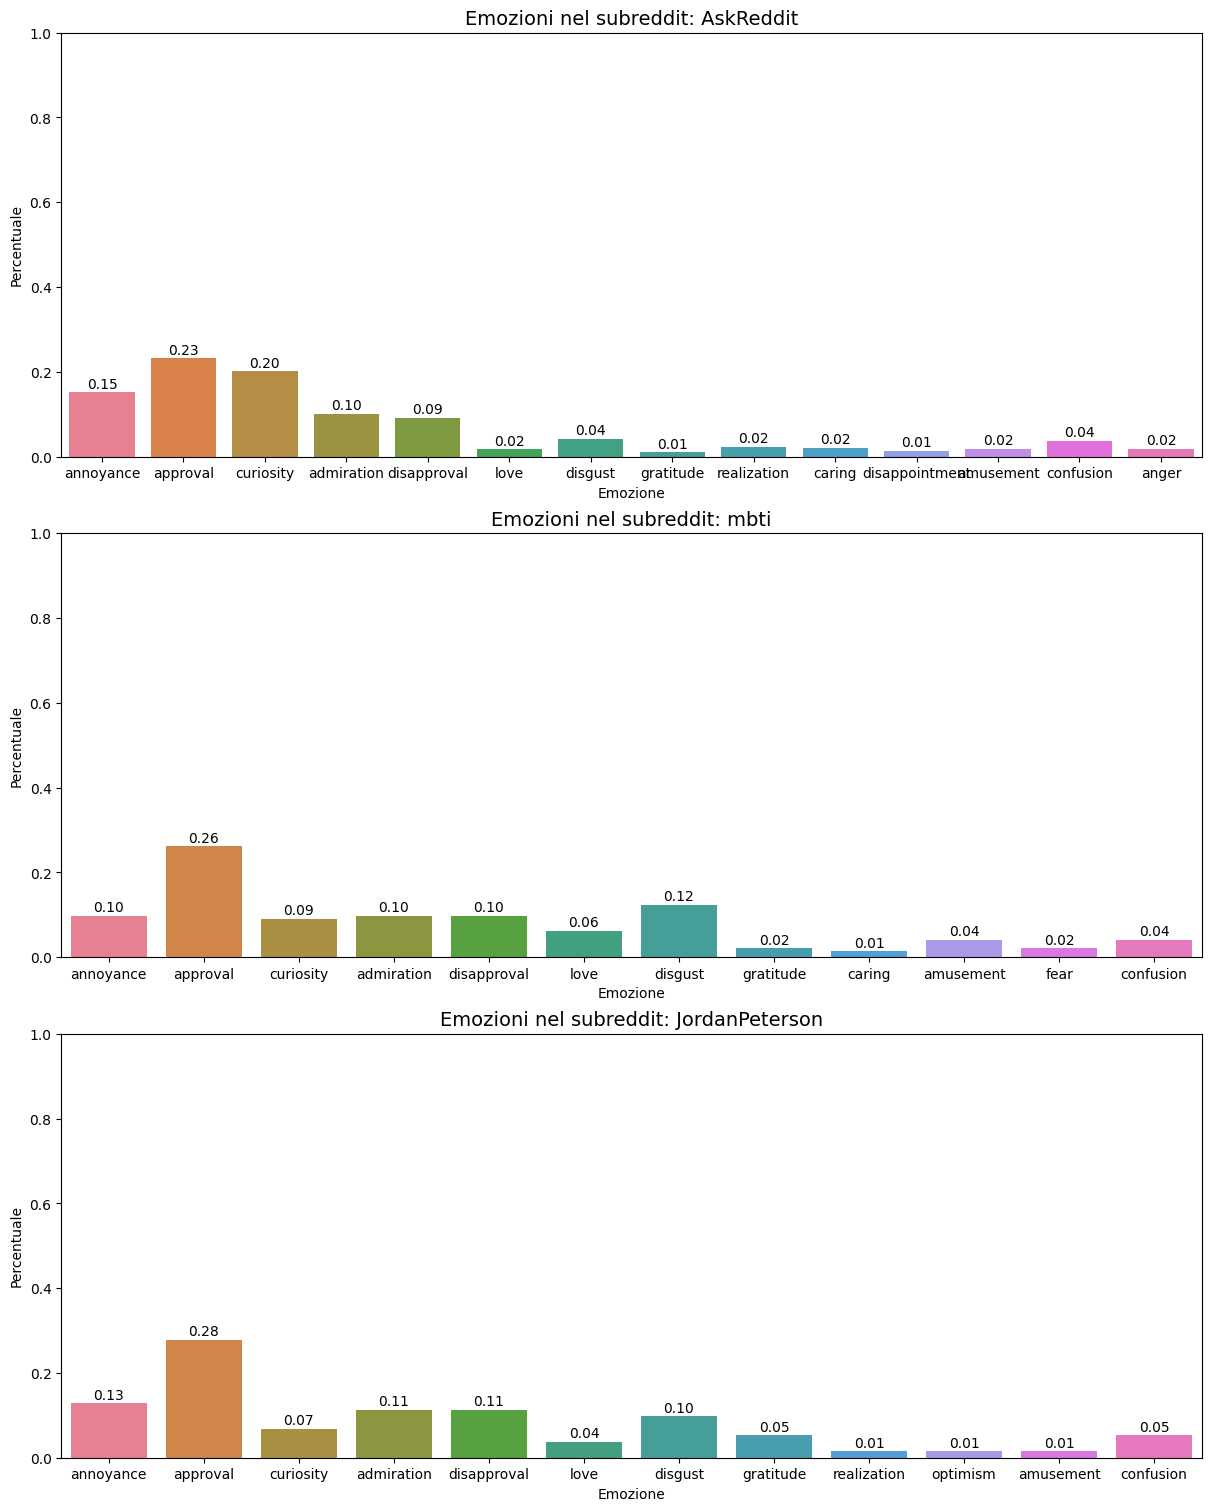

In [ ]:
top_subreddits = df_sub_emotions["subreddit"].value_counts().head(3).index.tolist()       # Visualizza la distribuzione percentuale delle emozioni nei 3 subreddit più frequenti, mostrando solo quelle con incidenza ≥ 1%

fig, axes = plt.subplots(len(top_subreddits), 1, figsize=(12, 5*len(top_subreddits)), constrained_layout=True)

if len(top_subreddits) == 1:
    axes = [axes]

# Selezione oglia minima 1%
THRESH = 0.01

for ax, subreddit in zip(axes, top_subreddits):
    # Filtro per emozioni con pct >= 1%
    data = subreddit_emotions_full[
        (subreddit_emotions_full["subreddit"] == subreddit) &
        (subreddit_emotions_full["pct"] >= THRESH)
    ]

    sns.barplot(
        x="emotion",
        y="pct",
        data=data,
        ax=ax,
        hue="emotion",
        dodge=False,
        legend=False
    )

    ax.set_title(f"Emozioni nel subreddit: {subreddit}", fontsize=14)
    ax.set_ylabel("Percentuale")
    ax.set_xlabel("Emozione")
    ax.set_ylim(0, 1)

    for i, v in enumerate(data["pct"]):
        ax.text(i, v + 0.01, f"{v:.2f}", ha="center", fontsize=10)

plt.show()

In [ ]:
df_emotions = df_perambiente_filtered[["id", "author", "predicted_all", "important_words"]].copy()   # Costruzione di un dataset che colleghi emozioni, parole corrispondenti, autori e subreddit
df_emotions["predicted_all"] = df_emotions["predicted_all"].apply(safe_list_robust)
df_emotions["important_words"] = df_emotions["important_words"].apply(safe_dict_robust)
df_emotions = df_emotions[df_emotions["predicted_all"].apply(len) > 0]


df_map = df_emotions.merge(
    df_comments[["id", "subreddit"]],
    on="id",
    how="inner"
)

rows = []

for _, r in df_map.iterrows():
    imp = r["important_words"]
    if not isinstance(imp, dict):
        continue
    for emotion, words in imp.items():
        if not isinstance(words, list):
            continue
        for w in words:
            w = w.strip().lower()
            if w:
                rows.append({
                    "author": r["author"],
                    "emotion": emotion.lower(),
                    "word": w,
                    "subreddit": r["subreddit"]
                })

df_words = pd.DataFrame(rows)


# CALCOLO SUBREDDIT MULTI-EMOZIONE CON PAROLE


words_per_sub_emo = df_words.groupby(["subreddit", "emotion"])["word"].nunique()

multi_emo_subs = (
    words_per_sub_emo
    .reset_index()
    .groupby("subreddit")
    .filter(lambda x: (x["word"] > 0).sum() > 1)
    .groupby("subreddit")
    .size()
)

print("Numero totale di subreddit con più di 1 emozione e parole associate:", len(multi_emo_subs))



print("\nDataset finale che contiene emozioni, parole, autore e subreddit)")
print("Righe totali:", len(df_words))
print("Autori unici:", df_words["author"].nunique())
print("Subreddit unici:", df_words["subreddit"].nunique())
display(df_words.head(25))


Numero totale di subreddit con più di 1 emozione e parole associate: 420

Dataset finale che contiene emozioni, parole, autore e subreddit)
Righe totali: 10614
Autori unici: 922
Subreddit unici: 883


author   emotion       word          subreddit
0          RedPillSafe   disgust    intense         TheRedPill
1          RedPillSafe   disgust    divorce         TheRedPill
2          RedPillSafe   disgust        bad         TheRedPill
3       Black_Elements      fear       shot              ffxiv
4       Black_Elements      fear       rule              ffxiv
5             Subs-man       joy      happy       pcmasterrace
6   FonsoTheWhitesican   disgust     filthy          MLPLounge
7           escapist11   sadness      music              funny
8          JackWilfred  surprise   surprise    britishproblems
9   FonsoTheWhitesican   sadness     guilty          MLPLounge
10          escapist11   disgust       fool              funny
11          escapist11   disgust    finally              funny
12          escapist11   disgust       shit              funny
13       Autodidact420      fear     lawyer             canada
14       Autodidact420      fear       case             canada
15       Autodidact420      fear      broke             canada
16       Autodidact420      fear     punish             canada
17       Autodidact420      fear  violation             canada
18   WittyOriginalName   disgust   sentence               entp
19   WittyOriginalName   disgust    asshole               entp
20   WittyOriginalName   disgust       shit               entp
21   WittyOriginalName   disgust      treat               entp
22   WittyOriginalName   disgust  notoriety               entp
23             JunkyGS       joy      happy  AnimalsBeingDerps
24          Kreindeker       joy       hope   MHOCStrangersBar

In [ ]:

words_per_sub = df_words.groupby("subreddit")["word"].count()   # Analisi dei subreddit con il maggior numero di parole associate, mostrando le emozioni presenti e i relativi termini distintivi


top_5_subs = words_per_sub.sort_values(ascending=False).head(5).index

print("\nTop 5 subreddit per quantità di parole e emozioni:")

for sub in top_5_subs:
    df_sub = df_words[df_words["subreddit"] == sub]

    # Conteggio emozioni che hanno almeno una parola
    emos = df_sub.groupby("emotion")["word"].nunique()
    emos = emos[emos > 0]

    if len(emos) < 2:
        continue

    print(f"\nSubreddit: {sub}")
    for emo in sorted(emos.index):
        words = sorted(df_sub[df_sub["emotion"] == emo]["word"].unique())
        print(f"Emozione: {emo}")
        print(f"Parole: {', '.join(words)}")


Top 5 subreddit per quantità di parole e emozioni:

Subreddit: AskReddit
Emozione: anger
Parole: abuse, accusation, angry, annoy, anxiety, argue, asshole, attack, awful, bad, battle, bear, beating, belt, bitch, blast, bloody, bomb, bully, casualty, challenge, complain, confine, conflict, criminal, curse, damn, death, demand, destroyed, endless, explode, explosive, fear, fight, force, fraud, gun, harass, hate, hell, hit, honest, horrible, hostility, hurt, injure, insult, invasion, lie, loss, mangle, money, murder, mutilation, penalty, politics, punch, raid, rape, rifle, rocket, scare, scream, sentence, shit, shoot, soldier, strangle, sucker, suicidal, suicide, tackle, terrible, threaten, vote, warrior, wound, wreck, yell
Emozione: disgust
Parole: abortion, abuse, adverse, ammonia, angry, annoy, arrogant, arsenic, asshole, atrophy, awful, bacteria, bad, blame, bug, bum, bureaucrat, celebrity, crap, cruelty, curse, damage, damn, death, demon, dirty, disgust, dishonest, divorce, evade, ex

In [ ]:
df_w = df_words.copy()

df_w["word"] = df_w["word"].astype(str).str.lower().str.strip()


top_words_per_sub = (
    df_w.groupby("subreddit")["word"]
    .apply(lambda x: Counter(x).most_common(20))
    .reset_index(name="top_words")
)

sub_totals = (
    df_w["subreddit"]
    .value_counts()
    .reset_index()
)

sub_totals.columns = ["subreddit", "total_important_words"]

result = (
    top_words_per_sub
    .merge(sub_totals, on="subreddit", how="left")
    .sort_values("total_important_words", ascending=False)
    .reset_index(drop=True)
)


print("  STAMPA DI TUTTE LE PAROLE IMPORTANTI INDIVIDUATE PER I DIVERSI SUBREDDIT")


display(result.head(20))


  STAMPA DI TUTTE LE PAROLE IMPORTANTI INDIVIDUATE PER I DIVERSI SUBREDDIT


subreddit  \
0             AskReddit   
1                  mbti   
2        JordanPeterson   
3                  infj   
4           Catholicism   
5                 ffxiv   
6                  INTP   
7                  intj   
8   AmericanHorrorStory   
9         relationships   
10           philosophy   
11                 infp   
12       summonerschool   
13       WritingPrompts   
14         RedPillWomen   
15                 ENFP   
16            aspergers   
17        BDSMcommunity   
18                 entp   
19           TheRedPill   

                                                                                                                                                                                                                                                                              top_words  \
0                                      [(shit, 22), (bad, 19), (hate, 13), (hell, 12), (death, 11), (cry, 11), (lose, 9), (terrible, 8), (good, 7), (treat, 7), (fight, 6), (scream, 6), (damn, 6), (bitch, 5), (happy, 5), (sick, 5), (finally, 5), (hurt, 4), (smell, 4), (weird, 4)]   
1                           [(bad, 25), (feeling, 23), (interested, 12), (lose, 11), (shit, 10), (hate, 10), (weird, 9), (problem, 8), (honest, 8), (death, 7), (terrible, 7), (dominant, 6), (alien, 6), (hurt, 5), (treat, 5), (damn, 5), (die, 5), (force, 5), (abuse, 5), (mad, 5)]   
2               [(bad, 20), (lose, 12), (case, 7), (honest, 7), (interested, 6), (tyrant, 6), (disgust, 5), (damn, 5), (failure, 5), (destructive, 5), (problem, 5), (evil, 5), (intense, 5), (treat, 5), (hell, 5), (enjoy, 5), (enthusiasm, 5), (force, 4), (rule, 4), (powerful, 4)]   
3                                       [(feeling, 20), (bad, 15), (good, 7), (honest, 6), (lose, 6), (mess, 6), (treat, 5), (hurt, 5), (case, 5), (change, 5), (problem, 4), (hate, 4), (enjoy, 4), (happy, 4), (love, 4), (lie, 3), (shit, 3), (weird, 3), (failure, 3), (lonely, 3)]   
4      [(socialism, 9), (bad, 8), (evil, 6), (socialist, 6), (slavery, 5), (force, 4), (god, 4), (death, 4), (government, 4), (violent, 4), (failure, 4), (treat, 4), (interested, 3), (threat, 3), (fight, 3), (murder, 3), (kill, 3), (insult, 3), (possession, 3), (persecution, 2)]   
5                                              [(damage, 11), (bad, 9), (happy, 6), (hell, 5), (shit, 4), (enemy, 4), (good, 3), (fight, 3), (mob, 3), (die, 3), (laugh, 3), (raid, 3), (abuse, 3), (case, 3), (waste, 3), (avoid, 3), (lose, 3), (nightmare, 3), (mess, 3), (shot, 2)]   
6                                    [(bad, 11), (happy, 8), (hate, 6), (feeling, 6), (enjoy, 5), (shit, 4), (fight, 3), (evil, 3), (honest, 3), (horrific, 3), (hell, 3), (laugh, 2), (excite, 2), (nurture, 2), (found, 2), (fun, 2), (waste, 2), (love, 2), (good, 2), (painful, 2)]   
7                                  [(bad, 13), (lose, 7), (hell, 5), (happy, 5), (interested, 5), (hate, 4), (shit, 4), (feeling, 4), (lie, 4), (honest, 3), (ill, 3), (death, 3), (problem, 2), (bomb, 2), (horrible, 2), (finally, 2), (cheat, 2), (devil, 2), (case, 2), (enemy, 2)]   
8                           [(bad, 8), (feeling, 7), (bitch, 6), (death, 6), (drunken, 4), (antisocial, 4), (lose, 4), (die, 4), (kill, 4), (bug, 4), (angry, 3), (lie, 3), (shock, 3), (romance, 3), (dangerous, 3), (villain, 3), (honest, 2), (infant, 2), (problem, 2), (opera, 2)]   
9                          [(honest, 8), (feeling, 7), (bad, 6), (hurt, 5), (terrible, 5), (bitch, 5), (abuse, 5), (treat, 4), (crazy, 4), (horrid, 4), (hurtful, 4), (lose, 3), (insecure, 3), (doubt, 3), (problem, 3), (misery, 2), (shot, 2), (marry, 2), (relapse, 2), (blame, 2)]   
10               [(immoral, 9), (bad, 8), (infanticide, 6), (murder, 5), (problem, 4), (rape, 4), (case, 4), (terrible, 4), (treat, 4), (tree, 3), (kill, 3), (infant, 3), (collapse, 2), (bleeding, 2), (oppress, 2), (alien, 2), (grim, 2), (honest, 2), (abortion, 2), (cruelty, 2)]   
11                             [(bad, 10), (cry, 4

In [ ]:
df_base = (
    df_comments[["author", "body", "subreddit", "id"]]
    .merge(
        df_emotions[["id", "predicted_all", "important_words"]],
        on="id",
        how="inner"
    )
)

df_base["predicted_all"] = df_base["predicted_all"].apply(
    lambda x: x if isinstance(x, list) else []
)
df_base["important_words"] = df_base["important_words"].apply(
    lambda x: x if isinstance(x, dict) else {}
)


df_emo = df_base.explode("predicted_all").rename(
    columns={"predicted_all": "emotion"}
)

emotion_counts = (
    df_emo.groupby(["subreddit", "emotion"])
    .size()
    .reset_index(name="freq")
)

top_emotions = (
    emotion_counts
    .sort_values(["subreddit", "freq"], ascending=[True, False])
    .groupby("subreddit")
    .first()
    .reset_index()
    .rename(columns={"emotion": "top_emotion"})
)


rows = []

top_emo_map = dict(
    zip(top_emotions["subreddit"], top_emotions["top_emotion"])
)

for _, r in df_base.iterrows():

    sub = r["subreddit"]
    imp = r["important_words"]

    if sub not in top_emo_map:
        continue

    top_emo = top_emo_map[sub]

    words = imp.get(top_emo, [])

    for w in words:
        if isinstance(w, str) and w.strip():
            rows.append(
                (sub, top_emo, w.strip().lower())
            )

df_words = pd.DataFrame(
    rows,
    columns=["subreddit", "emotion", "word"]
)


result = (
    df_words
    .groupby(["subreddit", "emotion"])["word"]
    .apply(lambda x: Counter(x).most_common(15))
    .reset_index(name="top_words")
    .sort_values("subreddit")
    .reset_index(drop=True)
)


print(" STAMPA TOP WORDS PER SUBREDDIT LEGATE ALLA TOP EMOTION ASSOCIATA A QUEL SUBREDDIT:")

display(result.head(20))

 STAMPA TOP WORDS PER SUBREDDIT LEGATE ALLA TOP EMOTION ASSOCIATA A QUEL SUBREDDIT:


subreddit  emotion  \
0                  ADHD  disgust   
1                Agario    anger   
2   AmericanHorrorStory  disgust   
3          Anthropology  disgust   
4          ArianaGrande  disgust   
5                Ashens    anger   
6    AsianParentStories     fear   
7         BDSMcommunity  disgust   
8            BlackMetal    anger   
9                 Bless  disgust   
10              CGPGrey    anger   
11              Cardiff    anger   
12          Catholicism  disgust   
13    CollegeBasketball    anger   
14        CompetitiveHS    anger   
15                  DMT    anger   
16           DarkSouls2    anger   
17     DebateAChristian  disgust   
18      DeepIntoYouTube    anger   
19              Destiny    anger   

                                                                                                                                                                                                       top_words  
0                 [(bad, 7), (weird, 3), (lose, 2), (annoy, 2), (torture, 2), (lie, 2), (mess, 2), (illegal, 2), (horrible, 2), (occult, 1), (powerful, 1), (savor, 1), (fat, 1), (miserable, 1), (sentence, 1)]  
1                                                                                                                  [(curse, 1), (rage, 1), (choke, 1), (money, 1), (revolt, 1), (revolution, 1), (communism, 1)]  
2             [(drunken, 4), (bad, 4), (bitch, 3), (angry, 3), (lie, 3), (death, 3), (feeling, 3), (antisocial, 2), (lose, 2), (inconsiderate, 2), (selfish, 2), (asshole, 2), (bug, 2), (blame, 2), (dandy, 2)]  
3                               [(interested, 1), (unsatisfied, 1), (sentence, 1), (fat, 1), (fatty, 1), (stomach, 1), (pregnancy, 1), (lie, 1), (fierce, 1), (spider, 1), (harmful, 1), (snake, 1), (enemy, 1)]  
4                                                                                                                                                                                                     [(bad, 1)]  
5                                                                                                                                                                                                   [(anger, 1)]  
6                                                                                                                                                                                                  [(afraid, 1)]  
7              [(bad, 5), (cruel, 2), (lose, 2), (hate, 2), (dirty, 2), (honest, 1), (resentment, 1), (deceive, 1), (insult, 1), (messy, 1), (failure, 1), (disrespectful, 1), (horror, 1), (shit, 1), (lie, 1)]  
8                                                                                                                                                                                                    [(hate, 1)]  
9                                                                                                                                                                                                     [(bad, 1)]  
10                                                                                                                                                                                                  [(curse, 1)]  
11                                                                                                                                                                                      [(shit, 1), (honest, 1)]  
12  [(socialism, 5), (bad, 4), (socialist, 4), (interested, 3), (slavery, 3), (evil, 3), (insult, 3), (death, 2), (violent, 2), (filthy, 2), (failure, 2), (possession, 2), (pollute, 2), (treat, 2), (tree, 1)]  
13                                                                                                                                                                                                   [(shit, 1)]  
14                                                                                          

In [ ]:
def safe_list_robust(x):
    if isinstance(x, list):
        return [str(e).strip() for e in x if str(e).strip()]

    if x is None:
        return []

    if isinstance(x, str):
        x = x.strip()
        if x == "" or x.lower() == "nan":
            return []


        if x.startswith("[") and x.endswith("]"):
            try:
                v = ast.literal_eval(x)
                if isinstance(v, list):
                    return [str(e).strip() for e in v if str(e).strip()]
            except (ValueError, SyntaxError):
                pass

        if "|" in x:
            return [e.strip() for e in x.split("|") if e.strip()]
        if "," in x:
            return [e.strip() for e in x.split(",") if e.strip()]

        return [x]

    return []


def safe_dict_robust(x):
    if isinstance(x, dict):
        return x

    if x is None:
        return {}

    if isinstance(x, str):
        x = x.strip()
        if x == "" or x.lower() == "nan":
            return {}
        try:
            d = ast.literal_eval(x)
            return d if isinstance(d, dict) else {}
        except (ValueError, SyntaxError):
            return {}

    return {}

df_emotions = (
    df_emotions[
        ["id", "predicted_all", "important_words"]
    ]
    .copy()
)

df_emotions["predicted_all"]   = df_emotions["predicted_all"].apply(safe_list_robust)
df_emotions["important_words"] = df_emotions["important_words"].apply(safe_dict_robust)


df_comments = (
    df_comments[
        ["id", "author", "body", "created_utc", "subreddit"]
    ]
    .copy()
)


df_comments["created_utc"] = pd.to_numeric(
    df_comments["created_utc"],
    errors="coerce"
)

df_comments["created_at"] = pd.to_datetime(
    df_comments["created_utc"],
    unit="s",
    utc=True,
    errors="coerce"
).dt.tz_convert("Europe/Rome")

df_comments = df_comments[df_comments["created_at"].notna()].copy()

# feature temporali
df_comments["year"]       = df_comments["created_at"].dt.year
df_comments["year_month"] = df_comments["created_at"].dt.strftime("%Y-%m")
df_comments["date"]       = df_comments["created_at"].dt.date
df_comments["hour"]       = df_comments["created_at"].dt.hour

df_comments["time_band"] = pd.cut(
    df_comments["hour"],
    bins=[0, 6, 12, 18, 24],
    labels=["notte", "mattina", "pomeriggio", "sera"],
    right=False
)



assert df_comments["id"].is_unique, "ID duplicati in df_comments"
assert df_emotions["id"].is_unique, "ID duplicati in df_emotions"



df = df_comments.merge(
    df_emotions[["id", "predicted_all"]],
    on="id",
    how="left",
    validate="one_to_one"
)


assert len(df) == len(df_comments), "Il merge ha alterato il numero di commenti"
assert df["id"].is_unique, "ID duplicati dopo il merge"

print(f"Merge corretto: {len(df)} commenti")


comments_per_month = (
    df.groupby("year_month", observed=True)
      .size()
      .reset_index(name="num_comments")
)

comments_per_month_subreddit = (
    df.groupby(["subreddit", "year_month"], observed=True)
      .size()
      .reset_index(name="num_comments")
)

comments_per_author_month = (
    df.groupby(["author", "year_month"], observed=True)
      .size()
      .reset_index(name="num_comments")
)

comments_author_subreddit_month = (
    df.groupby(["author", "subreddit", "year_month"], observed=True)
      .size()
      .reset_index(name="num_comments")
)

activity_by_hour = (
    df.groupby("hour")
      .size()
      .reset_index(name="num_comments")
)

activity_by_time_band = (
    df.groupby("time_band", observed=True)
      .size()
      .reset_index(name="num_comments")
)


df_emotions_exploded = (
    df.explode("predicted_all")
      .copy()
)

df_emotions_exploded = df_emotions_exploded[
    df_emotions_exploded["predicted_all"].notna() &
    (df_emotions_exploded["predicted_all"] != "")
]

emotion_trend = (
    df_emotions_exploded
    .groupby(["year_month", "predicted_all"], observed=True)
    .size()
    .reset_index(name="num_comments")
)

emotion_subreddit_trend = (
    df_emotions_exploded
    .groupby(["subreddit", "year_month", "predicted_all"], observed=True)
    .size()
    .reset_index(name="num_comments")
)


print("\nIntervallo temporale complessivo:")
print(df["created_at"].min(), "→", df["created_at"].max())

print("\nTrend mensile:")
print(comments_per_month.head())

print("\nRitmi cognitivi (fasce orarie):")
print(activity_by_time_band)

Merge corretto: 23022 commenti

Intervallo temporale complessivo:
2015-01-01 00:57:00+01:00 → 2019-04-03 22:11:46+02:00

Trend mensile:
  year_month  num_comments
0    2015-01          5214
1    2015-02          1313
2    2015-03           892
3    2015-04           754
4    2015-05           709

Ritmi cognitivi (fasce orarie):
    time_band  num_comments
0       notte          6434
1     mattina          3953
2  pomeriggio          5097
3        sera          7538


Per analizzare la distribuzione temporale dei commenti, i dati originali, memorizzati come timestamp Unix, sono stati convertiti in datetime e adattati al fuso orario locale (Europe/Rome). Da queste informazioni sono state estratte diverse feature temporali, tra cui l’anno, il mese, la data e l’ora del commento. L’ora del giorno è stata inoltre raggruppata in quattro fasce orarie principali – notte (0–6), mattina (6–12), pomeriggio (12–18) e sera (18–24) – al fine di osservare i ritmi cognitivi e l’attività degli utenti in momenti differenti della giornata. Queste suddivisioni consentono di identificare pattern temporali sia a livello aggregato, ad esempio il numero di commenti per mese, sia più dettagliato, come la distribuzione dei commenti per autore, subreddit o combinazioni di autore e subreddit.

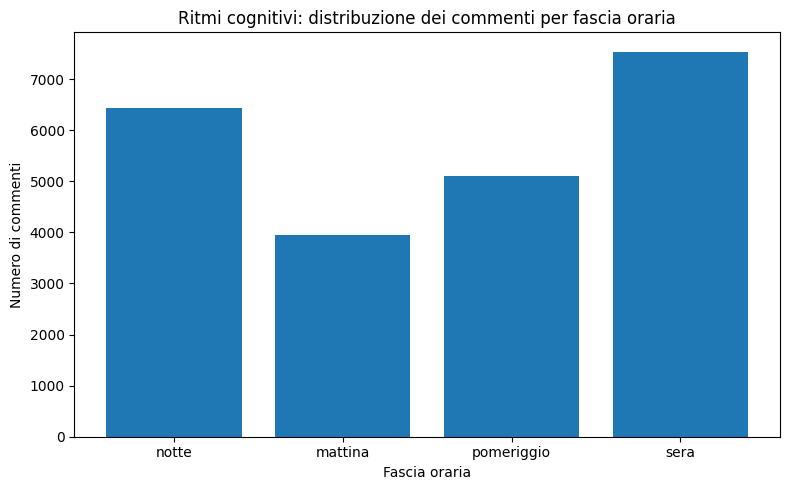

In [ ]:
plt.figure(figsize=(8, 5))

plt.bar(
    activity_by_time_band["time_band"].astype(str),
    activity_by_time_band["num_comments"]
)

plt.xlabel("Fascia oraria")
plt.ylabel("Numero di commenti")
plt.title("Ritmi cognitivi: distribuzione dei commenti per fascia oraria")

plt.tight_layout()
plt.show()

In [ ]:
activity_by_subreddit_time = (                                    # Conteggio dei commenti per ciascun subreddit suddivisi per fascia oraria, utile per analizzare la distribuzione temporale dell’attività nei diversi subreddit.

    df.groupby(["subreddit", "time_band"], observed=True)
      .size()
      .reset_index(name="num_comments")
)

subreddit_time_table = (
    activity_by_subreddit_time
    .pivot(
        index="subreddit",
        columns="time_band",
        values="num_comments"
    )
    .fillna(0)
    .astype(int)
)

subreddit_time_table = subreddit_time_table[
    ["notte", "mattina", "pomeriggio", "sera"]
]


subreddit_time_table_sorted = subreddit_time_table.loc[
    subreddit_time_table.sum(axis=1).sort_values(ascending=False).index
]

display(subreddit_time_table_sorted.head(20))

time_band           notte  mattina  pomeriggio  sera
subreddit                                           
AskReddit             552      276         329   565
mbti                  175       88         107   164
JordanPeterson        102       86         124   154
INTP                   85      102          62   115
ffxiv                  90       32          70   164
leagueoflegends        69       47          74   144
OkCupid               115       23          51   119
infj                   70       57          74   106
intj                   86       64          37    94
infp                   63       70          41    90
MHOC                   61       18          51   101
teenagers             100       26          39    66
NoFap                  33       45          56    59
entp                   46       40          61    40
anime                  32       35          62    54
funny                  63       25          39    43
ENFP                   49       31          52    37
CasualConversation     54       30          16    56
APLang2014             47        1          42    64
TheRedPill             45       20          37    45

In [ ]:
fasce_orarie = ["notte", "mattina", "pomeriggio", "sera"]

for fascia in fasce_orarie:
    top3 = subreddit_time_table.sort_values(fascia, ascending=False).head(3)

    print(f"\nI primi 3 subreddit per attività {fascia} sono:\n")

    for i, (subreddit, row) in enumerate(top3.iterrows(), start=1):
        print(f"{i}. {subreddit} → {row[fascia]}")



I primi 3 subreddit per attività notte sono:

1. AskReddit → 552
2. mbti → 175
3. OkCupid → 115

I primi 3 subreddit per attività mattina sono:

1. AskReddit → 276
2. INTP → 102
3. mbti → 88

I primi 3 subreddit per attività pomeriggio sono:

1. AskReddit → 329
2. JordanPeterson → 124
3. mbti → 107

I primi 3 subreddit per attività sera sono:

1. AskReddit → 565
2. mbti → 164
3. ffxiv → 164


In [ ]:
top_authors = (           # Conteggio dei commenti per ciascun autore suddivisi per fascia oraria, utile per analizzare la distribuzione temporale delle sue attività
    df["author"]
    .value_counts()
    .head(20)
    .index
)

activity_by_author_time = (
    df[df["author"].isin(top_authors)]
    .groupby(["author", "time_band"], observed=True)
    .size()
    .reset_index(name="num_comments")
)

author_time_table = (
    activity_by_author_time
    .pivot(
        index="author",
        columns="time_band",
        values="num_comments"
    )
    .fillna(0)
    .astype(int)
)


author_time_table = author_time_table[
    ["notte", "mattina", "pomeriggio", "sera"]
]

display(author_time_table)

time_band            notte  mattina  pomeriggio  sera
author                                               
137288                  14        0           2    13
Bhikkhu_Jayasara        10        8           3     8
Blitz179                22        0           0     7
Embarrassed_Delay        5       16           2     6
Fullmentalanarchist      1        3           8    17
Hysteric_Blue            1        6           5    18
Ishtarrr                 3        5           8    12
KittyMomo               13        4           3     9
KristianJ17              0        9           5    15
Lorpo314                 3       13          12     1
Mr_IamNotGandalf        11        0           4    15
Posturepedic             6        2          14     7
Verdantshade             3        7          10     9
We_are_out_of_nopes     13        2           5     9
bdsmthrowthrowthrow      9        1           5    15
buckarina                3       22           4     0
darkbrownvoice           0        5          13    11
girlonyourshoulders      1        1          18     9
guiltykissu              3        0           5    20
justiceisrad             1       16           0    12

In [ ]:
fasce_orarie = ["notte", "mattina", "pomeriggio", "sera"]

for fascia in fasce_orarie:
    top3 = author_time_table.sort_values(fascia, ascending=False).head(3)

    print(f"\nI primi 3 autori per attività {fascia} sono:\n")

    for i, (autore, row) in enumerate(top3.iterrows(), start=1):
        print(f"{i}. {autore} → {row[fascia]}")


I primi 3 autori per attività notte sono:

1. Blitz179 → 22
2. 137288 → 14
3. We_are_out_of_nopes → 13

I primi 3 autori per attività mattina sono:

1. buckarina → 22
2. Embarrassed_Delay → 16
3. justiceisrad → 16

I primi 3 autori per attività pomeriggio sono:

1. girlonyourshoulders → 18
2. Posturepedic → 14
3. darkbrownvoice → 13

I primi 3 autori per attività sera sono:

1. guiltykissu → 20
2. Hysteric_Blue → 18
3. Fullmentalanarchist → 17


In [ ]:
author_daily_activity = (
    df
    .groupby(["author", "date"])
    .size()
    .reset_index(name="comments_in_day")
)


author_activity_summary = (
    author_daily_activity
    .groupby("author")
    .agg(
        active_days=("comments_in_day", "count"),        # giorni distinti di attività
        total_comments=("comments_in_day", "sum"),       # commenti totali
        avg_comments_per_day=("comments_in_day", "mean"),# media sui giorni attivi
        max_comments_per_day=("comments_in_day", "max")  # picco massimo giornaliero
    )
    .reset_index()
)


author_activity_summary["avg_comments_per_day"] = (
    author_activity_summary["avg_comments_per_day"].round(2)
)


author_activity_summary = author_activity_summary.sort_values(
    by=["avg_comments_per_day", "active_days"],
    ascending=False
)

print("Attività temporale degli autori")
display(author_activity_summary.head(15))

Attività temporale degli autori


author  active_days  total_comments  avg_comments_per_day  \
219  FonsoTheWhitesican            1              26                  26.0   
461         Poppysprose            1              25                  25.0   
460    PokemonMaster999            1              24                  24.0   
66    Benevolent_Tyrant            1              23                  23.0   
529      Sexua1Ref0rmer            1              22                  22.0   
158               Derse            1              21                  21.0   
274  I_Photoshop_Movies            1              21                  21.0   
809            cyanisis            1              18                  18.0   
981      joantheunicorn            1              18                  18.0   
69     Bhikkhu_Jayasara            2              29                  14.5   
984           joshually            2              28                  14.0   
857  equalityNOTfascism            2              27                  13.5   
185    EloquentSolitude            2              26                  13.0   
243              Gusmaz            2              26                  13.0   
828       deviantmoomba            2              26                  13.0   

     max_comments_per_day  
219                    26  
461                    25  
460                    24  
66                     23  
529                    22  
158                    21  
274                    21  
809                    18  
981                    18  
69                     18  
984                    16  
857                    26  
185                    21  
243                    22  
828                    17

Per comprendere i pattern di partecipazione degli autori, è stata calcolata l’attività giornaliera, ovvero il numero di commenti scritti da ciascun autore in ogni singolo giorno. Successivamente, questi dati sono stati aggregati a livello autore per ottenere una panoramica più completa dell’impegno nel tempo. In particolare, per ogni autore sono stati determinati il numero di giorni attivi, il totale dei commenti scritti, la media dei commenti per giorno attivo e il picco massimo di commenti in un singolo giorno. Questa sintesi consente di identificare autori particolarmente attivi o concentrati in periodi specifici, fornendo indicazioni sui comportamenti di partecipazione, sulla costanza nel tempo e sulle giornate di maggiore intensità. Ordinando gli autori in base alla media dei commenti giornalieri e ai giorni attivi, è possibile evidenziare chi contribuisce più costantemente alla discussione e chi mostra picchi di attività significativi.

In [ ]:
author_style = author_activity_summary.copy()

author_style["burst_ratio"] = (
    author_style["max_comments_per_day"] /
    author_style["avg_comments_per_day"].replace(0, pd.NA)
).round(2)

author_style["max_day_share"] = (
    author_style["max_comments_per_day"] /
    author_style["total_comments"].replace(0, pd.NA)
).round(2)

author_style[
        [
            "author",
            "active_days",
            "total_comments",
            "avg_comments_per_day",
            "max_comments_per_day",
            "burst_ratio",
            "max_day_share"
        ]
]


def classify_author(row):
    if row["active_days"] == 1:
        return "one_shot"

    # Un giorno domina quasi tutta l'attività
    if row["max_day_share"] >= 0.85:
        return "spike"

    # Attività scarsa e frammentata
    if row["active_days"] < 3 and row["avg_comments_per_day"] <= 2:
        return "sporadic"

    # Burst: più giorni attivi ma con un picco marcato
    if (
        row["active_days"] > 2 and
        row["max_day_share"] >= 0.6 and
        row["burst_ratio"] >= 3.5
    ):
        return "burst"

    # Attività distribuita
    return "steady"

author_style["activity_style"] = author_style.apply(classify_author, axis=1)



print("\nAutori classificati per stile temporale")
display(
    author_style
    .sort_values(
        by=["activity_style", "avg_comments_per_day"],
        ascending=[True, False]
    )
    .head(15)
)

style_distribution = (
    author_style["activity_style"]
    .value_counts()
    .rename_axis("activity_style")
    .reset_index(name="num_authors")
)

print("\nDistribuzione stili")
display(style_distribution)


Autori classificati per stile temporale


author  active_days  total_comments  avg_comments_per_day  \
626     TwoPunnyFourWords            5              27                  5.40   
375               Mangeto            5              24                  4.80   
260            HippeHoppe            6              26                  4.33   
698      alex_steppenwolf            5              21                  4.20   
446       PeachPlumParity            6              24                  4.00   
442        ParadoxAnarchy            6              23                  3.83   
810          cydneywithac            6              23                  3.83   
719    another_guy_montag            7              26                  3.71   
726  arrangementscanbemad            7              25                  3.57   
346               LaV-Man            6              21                  3.50   
471  Q1189998819991197253            6              21                  3.50   
88            BoutOfDoubt            8              25                  3.12   
219    FonsoTheWhitesican            1              26                 26.00   
461           Poppysprose            1              25                 25.00   
460      PokemonMaster999            1              24                 24.00   

     max_comments_per_day  burst_ratio  max_day_share activity_style  
626                    20         3.70           0.74          burst  
375                    19         3.96           0.79          burst  
260                    17         3.93           0.65          burst  
698                    16         3.81           0.76          burst  
446                    15         3.75           0.62          burst  
442                    16         4.18           0.70          burst  
810                    14         3.66           0.61          burst  
719                    17         4.58           0.65          burst  
726                    17         4.76           0.68          burst  
346                    14         4.00           0.67          burst  
471                    13         3.71           0.62          burst  
88                     16         5.13           0.64          burst  
219                    26         1.00           1.00       one_shot  
461                    25         1.00           1.00       one_shot  
460                    24         1.00           1.00       one_shot


Distribuzione stili


activity_style  num_authors
0         steady          965
1          burst           12
2          spike           11
3       one_shot            9

Per analizzare lo stile temporale di ciascun autore, l’attività giornaliera è stata trasformata in indicatori di intensità e concentrazione. In particolare, sono stati calcolati due parametri principali: il burst ratio, che misura quanto il giorno di maggiore attività supera la media dei giorni attivi, e la quota del giorno massimo, che indica la percentuale di commenti totali concentrata nel giorno più intenso.
Sulla base di questi indicatori, gli autori sono stati classificati in diverse categorie di stile: ‘one_shot’ per chi ha commentato in un solo giorno; ‘spike’ per chi concentra quasi tutta l’attività in un singolo giorno; ‘sporadic’ per chi commenta poco e in modo frammentato; ‘burst’ per chi mostra più giorni attivi ma con picchi marcati; e ‘steady’ per chi mantiene un’attività distribuita e costante nel tempo. Questa classificazione consente di distinguere comportamenti di partecipazione diversi, identificando sia utenti occasionali sia utenti con attività intensa e concentrata, e di osservare come i diversi stili si distribuiscono all’interno della comunità.


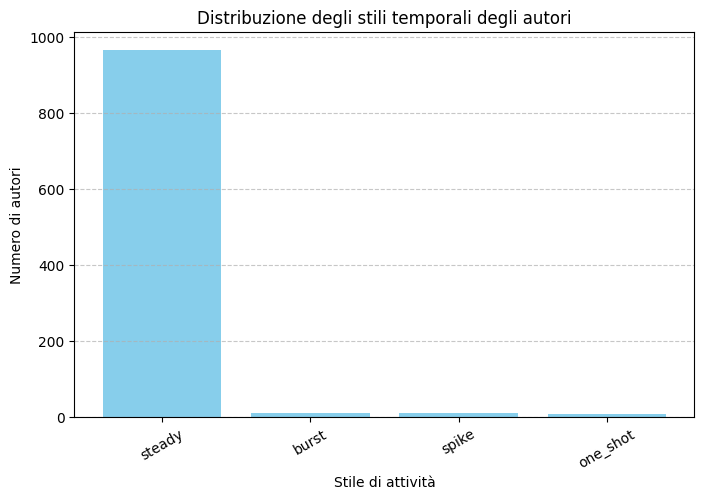

In [ ]:
plt.figure(figsize=(8,5))   #Grafico per visualizzare stili temporali autori
plt.bar(
    style_distribution["activity_style"],
    style_distribution["num_authors"],
    color="skyblue"
)
plt.title("Distribuzione degli stili temporali degli autori")
plt.xlabel("Stile di attività")
plt.ylabel("Numero di autori")
plt.xticks(rotation=30)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [ ]:
df["weekday"] = df["created_at"].dt.day_name()   # Conteggio totale commenti durante i diversi giorni della settimana e in particolare weekend e weekday

activity_by_weekday = (
    df.groupby("weekday", observed=True)
      .size()
      .reset_index(name="num_comments")
)

# ordine naturale dei giorni
weekday_order = [
    "Monday", "Tuesday", "Wednesday",
    "Thursday", "Friday", "Saturday", "Sunday"
]

activity_by_weekday["weekday"] = pd.Categorical(
    activity_by_weekday["weekday"],
    categories=weekday_order,
    ordered=True
)

# weekday / weekend
activity_by_weekday["day_type"] = activity_by_weekday["weekday"].isin(
    ["Saturday", "Sunday"]
).map({True: "weekend", False: "weekday"})

activity_by_weekday = activity_by_weekday.sort_values("weekday")

print("Ciclo settimanale")
display(activity_by_weekday)

Ciclo settimanale


weekday  num_comments day_type
1     Monday          3470  weekday
5    Tuesday          3395  weekday
6  Wednesday          3205  weekday
4   Thursday          3530  weekday
0     Friday          3489  weekday
2   Saturday          2980  weekend
3     Sunday          2953  weekend

In [ ]:
weekday_vs_weekend = (
    activity_by_weekday
    .groupby("day_type")["num_comments"]
    .sum()
    .reset_index()
)

print("Weekday vs Weekend")
display(weekday_vs_weekend)

Weekday vs Weekend


day_type  num_comments
0  weekday         17089
1  weekend          5933

In [ ]:
author_subreddit_time = (                                         # Conteggio dei commenti per autore, subreddit e fascia oraria, ordinati dal più alto al più basso, per evidenziare in quali momenti della giornata ciascun autore è più attivo nei diversi subreddit.

    df.groupby(["author", "subreddit", "time_band"], observed=True)
      .size()
      .reset_index(name="num_comments")
)
author_subreddit_time = author_subreddit_time.sort_values(
    "num_comments", ascending=False
)

print("Autore, subreddit e tempo:")
display(author_subreddit_time.head(15))

Autore, subreddit e tempo:


author        subreddit   time_band  num_comments
2192  FonsoTheWhitesican        MLPLounge       notte            26
4667    PokemonMaster999           Twitch        sera            24
6146           TheSean85   TACSdiscussion  pomeriggio            24
3169             JunkyGS  leagueoflegends        sera            23
7331         ardent_wolf            ffxiv        sera            23
8693  equalityNOTfascism        AskReddit       notte            23
680    Benevolent_Tyrant        AskReddit       notte            23
3976          Moprollems      Catholicism     mattina            21
1943        Eve_CoeurlNA            ffxiv        sera            21
3240           KayleighM       APLang2014        sera            21
6412        Twinkle-Tits     SubSanctuary  pomeriggio            20
2194  Format137_BossMode          OkCupid       notte            19
1600               Derse        teenagers       notte            19
7956     chopperhead2011    Documentaries       notte            19
7200            amuredem        AskReddit        sera            19

In [ ]:
WINDOW_DAYS = 1              # durata minima finestra evento
BASELINE_DAYS = 10
VOLUME_MULTIPLIER = 1.3      # soglia incremento commenti
DOMINANCE_THRESHOLD = 0.40   # minimo % subreddit dominante

df["date"] = pd.to_datetime(df["date"])

daily_counts = (
    df.groupby("date")
      .size()
      .reset_index(name="num_comments")
      .sort_values("date")
      .reset_index(drop=True)
)


candidate_windows = []

for i in range(BASELINE_DAYS, len(daily_counts) - WINDOW_DAYS + 1):
    baseline_mean = daily_counts.iloc[i-BASELINE_DAYS:i]["num_comments"].mean()
    window_df = daily_counts.iloc[i:i+WINDOW_DAYS]

    window_total = window_df["num_comments"].sum()
    expected_total = baseline_mean * WINDOW_DAYS

    if window_total >= expected_total * VOLUME_MULTIPLIER:
        candidate_windows.append({
            "start_date": window_df["date"].iloc[0],
            "end_date": window_df["date"].iloc[-1]
        })

candidate_df = pd.DataFrame(candidate_windows)
print("Finestre candidate rilevate:", len(candidate_df))

if candidate_df.empty:
    print("Nessun evento discorsivo rilevato.")
    events_df = pd.DataFrame()
else:



    candidate_df = candidate_df.sort_values("start_date").reset_index(drop=True)
    merged_windows = []
    current_start = candidate_df.loc[0, "start_date"]
    current_end = candidate_df.loc[0, "end_date"]

    for i in range(1, len(candidate_df)):
        next_start = candidate_df.loc[i, "start_date"]
        next_end = candidate_df.loc[i, "end_date"]

        # sovrapposizione o consecutiva (max 1 giorno di gap)
        if next_start <= current_end + pd.Timedelta(days=1):
            current_end = max(current_end, next_end)
        else:
            merged_windows.append({"start_date": current_start, "end_date": current_end})
            current_start = next_start
            current_end = next_end

    merged_windows.append({"start_date": current_start, "end_date": current_end})
    merged_df = pd.DataFrame(merged_windows)
    print(f"Finestre dopo merge: {len(merged_df)}")

    final_events = []

    for event_id, row in merged_df.iterrows():
        start = row["start_date"]
        end = row["end_date"]

        event_df = df[(df["date"] >= start) & (df["date"] <= end)]
        total_comments = len(event_df)
        if total_comments == 0:
            continue

        breakdown = (
            event_df.groupby("subreddit")
            .size()
            .reset_index(name="count")
            .sort_values("count", ascending=False)
            .reset_index(drop=True)
        )

        top = breakdown.loc[0]
        dominant_comments = top["count"]
        dominance = dominant_comments / total_comments

        if dominance < DOMINANCE_THRESHOLD:
            continue

        final_events.append({
            "event_id": event_id + 1,
            "start_date": start,
            "end_date": end,
            "days": (end - start).days + 1,
            "total_comments": total_comments,          # tutti i commenti
            "dominant_subreddit": top["subreddit"],
            "dominant_comments": dominant_comments,   # solo del subreddit dominante
            "dominance_pct": round(dominance * 100, 1)
        })

    events_df = pd.DataFrame(final_events)

    print("\nEVENTI DISCORSIVI FINALI")
    if events_df.empty:
        print("Nessun evento soddisfa i criteri di dominance.")
    else:
        # ordinamento: prima dominance, poi volume totale
        events_df_sorted = events_df.sort_values(
            by=["dominance_pct", "total_comments"],
            ascending=[False, False]
        ).reset_index(drop=True)
        display(events_df_sorted)

        print("\nNumero eventi:", len(events_df_sorted))
        print("Durata media in giorni:", round(events_df_sorted["days"].mean(), 2))

Finestre candidate rilevate: 360
Finestre dopo merge: 226

EVENTI DISCORSIVI FINALI


event_id start_date   end_date  days  total_comments  \
0        164 2018-01-06 2018-01-06     1              16   
1        221 2019-01-21 2019-01-22     2               9   
2        224 2019-02-26 2019-02-26     1               8   
3        184 2018-05-07 2018-05-07     1               6   
4        203 2018-08-31 2018-08-31     1               6   
5        216 2018-12-04 2018-12-04     1               5   
6        226 2019-03-24 2019-03-24     1               5   
7        219 2019-01-13 2019-01-14     2               4   
8        209 2018-10-15 2018-10-15     1               3   
9        217 2018-12-20 2018-12-20     1               3   
10       222 2019-02-04 2019-02-04     1               3   
11       210 2018-10-20 2018-10-20     1               2   
12       211 2018-10-24 2018-10-24     1               2   
13       218 2019-01-10 2019-01-10     1               2   
14       207 2018-09-26 2018-09-26     1              10   
15       205 2018-09-14 2018-09-14     1              12   
16       225 2019-03-19 2019-03-20     2              12   
17       206 2018-09-17 2018-09-17     1               5   
18       214 2018-11-18 2018-11-18     1               5   
19       179 2018-04-01 2018-04-01     1               9   
20       213 2018-10-30 2018-10-31     2               8   
21       215 2018-11-20 2018-11-20     1               4   
22        74 2016-06-20 2016-06-20     1              38   
23       103 2016-12-02 2016-12-02     1              15   
24       202 2018-08-29 2018-08-29     1               7   
25       144 2017-09-01 2017-09-02     2              55   
26       157 2017-11-15 2017-11-15     1              20   
27       111 2017-01-24 2017-01-24     1              13   
28       110 2017-01-20 2017-01-20     1              29   
29       153 2017-10-15 2017-10-15     1              19   
30        59 2016-03-10 2016-03-10     1              22   
31       146 2017-09-18 2017-09-18     1              25   
32       201 2018-08-17 2018-08-17     1               6   
33       192 2018-06-26 2018-06-26     1              28   
34       141 2017-08-17 2017-08-17     1              14   
35        56 2016-02-25 2016-02-25     1              25   
36       208 2018-09-29 2018-09-29     1               8   
37       181 2018-04-12 2018-04-12     1              13   
38       191 2018-06-20 2018-06-20     1              23   
39        99 2016-10-31 2016-10-31     1              33   
40        39 2015-11-24 2015-11-24     1              25   
41       189 2018-06-02 2018-06-04     3              39   
42       137 2017-07-27 2017-07-27     1              23   
43        75 2016-06-24 2016-06-24     1              16   
44       162 2017-12-19 2017-12-19     1              25   
45       129 2017-06-02 2017-06-02     1              18   
46       194 2018-07-09 2018-07-10     2              20   
47       168 2018-01-22 2018-01-22     1              22   
48       142 2017-08-22 2017-08-22     1              26   
49       169 2018-01-27 2018-01-27     1              15   
50       163 2018-01-02 2018-01-03     2              23   
51       165 2018-01-08 2018-01-08     1              23   
52        45 2016-01-01 2016-01-01     1              18   
53        38 2015-11-21 2015-11-21     1              14   
54       195 2018-07-19 2018-07-19     1              14   
55        64 2016-04-16 2016-04-16     1              12   
56       188 2018-05-31 2018-05-31     1              12   
57       196 2018-07-25 2018-07-25     1               8   
58       212 2018-10-28 2018-10-28     1               8   
59       223 2019-02-11 2019-02-11     1               4   
60         3 2015-03-16 2015-03-16     1              49   
61        40 2015-11-27 2015-11-27     1              31   
62       115 2017-02-19 2017-02-20     2              54   
63        73 2016-06-17 2016-06-17     1              23   
64       139 2017-08-04 2017-08-04     1              21   
65       138 2017-07-31 2017-07-31     1    


Numero eventi: 89
Durata media in giorni: 1.18


Questa procedura è finalizzata all’individuazione di eventi discorsivi rilevanti, intesi come intervalli temporali in cui si osserva un aumento significativo dell’attività comunicativa rispetto a un andamento di base. L’analisi si basa sul volume giornaliero dei commenti e utilizza una finestra temporale mobile, confrontando l’attività osservata in ciascuna finestra con la media dei giorni precedenti, al fine di identificare picchi anomali di partecipazione.

Le finestre temporali candidate vengono successivamente aggregate quando risultano adiacenti o sovrapposte, così da ricostruire eventi discorsivi continui nel tempo. Per ciascun evento individuato, viene poi analizzata la distribuzione dei commenti nei diversi subreddit, al fine di verificare la presenza di un contesto discorsivo dominante.

Un evento viene considerato rilevante solo se una quota significativa dei commenti è concentrata in un singolo subreddit, condizione che consente di distinguere picchi di attività generalizzata da eventi riconducibili a specifici ambienti di discussione. Il risultato finale è un insieme di eventi caratterizzati da un incremento temporale dell’attività comunicativa e da una chiara dominanza contestuale, utili per l’analisi dei fenomeni discorsivi emergenti.

In [ ]:
MIN_COMMENTS = 30        # dimensione minima evento
MIN_DOMINANCE = 0.40     # almeno il 50% dei commenti in un subreddit


if "events_df" not in globals() or events_df.empty:
    raise ValueError("events_df non esiste o è vuoto. Eseguire prima la detection degli eventi.")


events = events_df.copy()


events["dominance_pct"] = (
    events["dominant_comments"] / events["total_comments"]
).round(3)


events_discursive = events[
    (events["total_comments"] >= MIN_COMMENTS) &
    (events["dominance_pct"] >= MIN_DOMINANCE)
].copy()


events_discursive = (
    events_discursive
    .sort_values(
        by=["dominance_pct", "total_comments"],
        ascending=[False, False]
    )
    .reset_index(drop=True)
)


print("EVENTI DISCORSIVI SELEZIONATI")

display(
    events_discursive[
        [
            "event_id",
            "start_date",
            "end_date",
            "days",
            "total_comments",
            "dominant_subreddit",
            "dominant_comments",
            "dominance_pct"
        ]
    ]
)

print(f"\nNumero eventi discorsivi selezionati: {len(events_discursive)}")
print("Durata media in giorni:", round(events_discursive["days"].mean(), 2))
print("Dominanza media:", round(events_discursive["dominance_pct"].mean(), 2))

EVENTI DISCORSIVI SELEZIONATI


event_id start_date   end_date  days  total_comments dominant_subreddit  \
0         74 2016-06-20 2016-06-20     1              38          AskReddit   
1        144 2017-09-01 2017-09-02     2              55     JordanPeterson   
2         99 2016-10-31 2016-10-31     1              33         The_Donald   
3        189 2018-06-02 2018-06-04     3              39               intj   
4          3 2015-03-16 2015-03-16     1              49             Twitch   
5         40 2015-11-27 2015-11-27     1              31          AskReddit   
6        115 2017-02-19 2017-02-20     2              54          AskReddit   
7        170 2018-01-30 2018-01-30     1              51            OkCupid   
8         85 2016-08-03 2016-08-03     1              30               mbti   
9         98 2016-10-25 2016-10-26     2              63               IAmA   
10       113 2017-02-05 2017-02-06     2              50          samharris   
11        67 2016-05-02 2016-05-03     2              34        Philippines   
12         6 2015-04-09 2015-04-09     1              40         APLang2014   
13         5 2015-04-04 2015-04-04     1              43     KotakuInAction   
14        83 2016-07-28 2016-07-28     1              35          AskReddit   

    dominant_comments  dominance_pct  
0                  28          0.737  
1                  39          0.709  
2                  20          0.606  
3                  23          0.590  
4                  24          0.490  
5                  15          0.484  
6                  26          0.481  
7                  24          0.471  
8                  14          0.467  
9                  29          0.460  
10                 23          0.460  
11                 15          0.441  
12                 17          0.425  
13                 18          0.419  
14                 14          0.400


Numero eventi discorsivi selezionati: 15
Durata media in giorni: 1.47
Dominanza media: 0.51


A partire dall’insieme degli eventi individuati nella fase di detection, viene applicato un ulteriore filtraggio per selezionare esclusivamente gli eventi discorsivi più significativi. In questa fase vengono mantenuti solo gli eventi caratterizzati da un volume minimo di commenti e da una chiara concentrazione dell’attività all’interno di un singolo subreddit. Tale selezione consente di escludere fluttuazioni marginali o aumenti di attività non riconducibili a un contesto discorsivo dominante, focalizzando l’analisi su fenomeni comunicativi strutturati e interpretabili.

In [ ]:
events_discursive = (
    events_discursive
    .sort_values(
        by=["total_comments", "dominance_pct"],
        ascending=[False, False]
    )
    .reset_index(drop=True)
)

print("EVENTI DISCORSIVI ORDINATI PER NUMERO TOTALE COMMENTI")

display(
    events_discursive[
        [
            "event_id",
            "start_date",
            "end_date",
            "days",
            "total_comments",
            "dominant_subreddit",
            "dominant_comments",
            "dominance_pct"
        ]
    ]
)

EVENTI DISCORSIVI ORDINATI PER NUMERO TOTALE COMMENTI


event_id start_date   end_date  days  total_comments dominant_subreddit  \
0         98 2016-10-25 2016-10-26     2              63               IAmA   
1        144 2017-09-01 2017-09-02     2              55     JordanPeterson   
2        115 2017-02-19 2017-02-20     2              54          AskReddit   
3        170 2018-01-30 2018-01-30     1              51            OkCupid   
4        113 2017-02-05 2017-02-06     2              50          samharris   
5          3 2015-03-16 2015-03-16     1              49             Twitch   
6          5 2015-04-04 2015-04-04     1              43     KotakuInAction   
7          6 2015-04-09 2015-04-09     1              40         APLang2014   
8        189 2018-06-02 2018-06-04     3              39               intj   
9         74 2016-06-20 2016-06-20     1              38          AskReddit   
10        83 2016-07-28 2016-07-28     1              35          AskReddit   
11        67 2016-05-02 2016-05-03     2              34        Philippines   
12        99 2016-10-31 2016-10-31     1              33         The_Donald   
13        40 2015-11-27 2015-11-27     1              31          AskReddit   
14        85 2016-08-03 2016-08-03     1              30               mbti   

    dominant_comments  dominance_pct  
0                  29          0.460  
1                  39          0.709  
2                  26          0.481  
3                  24          0.471  
4                  23          0.460  
5                  24          0.490  
6                  18          0.419  
7                  17          0.425  
8                  23          0.590  
9                  28          0.737  
10                 14          0.400  
11                 15          0.441  
12                 20          0.606  
13                 15          0.484  
14                 14          0.467

Gli eventi discorsivi selezionati vengono successivamente ordinati in base alla loro rilevanza quantitativa, considerando il numero totale di commenti e il grado di dominanza del subreddit principale. Questo ordinamento permette di confrontare gli eventi tra loro e di individuare quelli caratterizzati da una maggiore intensità discorsiva, facilitando l’analisi comparativa dei fenomeni emergenti.

In [ ]:
SUBREDDIT = "jordanpeterson"
EVENT_START = pd.Timestamp("2017-09-01")
EVENT_END   = pd.Timestamp("2017-09-02")
BASELINE_DAYS = 10       # giorni precedenti per la baseline
MIN_GROUPS = 1          # numero minimo di gruppi da matchare
N_EXAMPLES = 5          # quanti esempi visualizzare


JORDAN_PETERSON_FRAME = {
    "peterson_reference": {"peterson", "jordan"},
    "ideas_discourse": {"free speech", "speech", "argument", "point", "ideas", "discussion", "debate"},
    "controversy": {"controversy", "criticized", "attacked", "misunderstood", "taken out of context", "backlash"},
    "culture_conflict": {"political correctness", "pc", "sjw", "woke", "identity politics", "anti"},
    "epistemic_distrust": {"media", "journalists", "mainstream", "fake", "misrepresented"}
}

df["date"] = pd.to_datetime(df["date"])
df["subreddit_lower"] = df["subreddit"].str.lower()


event_df = df[
    (df["subreddit_lower"] == SUBREDDIT) &
    (df["date"] >= EVENT_START) &
    (df["date"] <= EVENT_END)
].copy()

BASELINE_START = EVENT_START - pd.Timedelta(days=BASELINE_DAYS)
BASELINE_END = EVENT_START - pd.Timedelta(days=1)

baseline_df = df[
    (df["subreddit_lower"] == SUBREDDIT) &
    (df["date"] >= BASELINE_START) &
    (df["date"] <= BASELINE_END)
].copy()

print(f"Evento: {EVENT_START.date()} → {EVENT_END.date()} ({len(event_df)} commenti)")
print(f"Baseline: {BASELINE_START.date()} → {BASELINE_END.date()} ({len(baseline_df)} commenti)")

def normalize(text):
    if not isinstance(text, str):
        return ""
    return re.sub(r"\s+", " ", text.lower())

def detect_groups(text, frame):
    t = normalize(text)
    matched = []
    for group, terms in frame.items():
        for term in terms:
            pattern = r"\b" + re.escape(term.lower()) + r"\b"
            if re.search(pattern, t):
                matched.append(group)
                break
    return matched

def detect_frame_bool(text, frame, min_groups=1):
    return len(detect_groups(text, frame)) >= min_groups

event_df["matched_groups"] = event_df["body"].apply(lambda x: detect_groups(x, JORDAN_PETERSON_FRAME))
event_df["jp_frame"] = event_df["matched_groups"].apply(lambda x: len(x) >= MIN_GROUPS)

baseline_df["matched_groups"] = baseline_df["body"].apply(lambda x: detect_groups(x, JORDAN_PETERSON_FRAME))
baseline_df["jp_frame"] = baseline_df["matched_groups"].apply(lambda x: len(x) >= MIN_GROUPS)

event_frame_count = int(event_df["jp_frame"].sum())
baseline_frame_count = int(baseline_df["jp_frame"].sum())

event_pct = round(event_frame_count / max(len(event_df), 1) * 100, 2)
baseline_pct = round(baseline_frame_count / max(len(baseline_df), 1) * 100, 2)
relative_increase = round(event_pct / max(baseline_pct, 0.1), 2)


final_events = [{
    "frame": "jordan_peterson_discourse",
    "event_count": event_frame_count,
    "baseline_count": baseline_frame_count,
    "event_pct": event_pct,
    "baseline_pct": baseline_pct,
    "relative_increase": relative_increase
}]


print("\n CONFRONTO FRAME: EVENTO / BASELINE")
display(pd.DataFrame(final_events))


examples = event_df[event_df["jp_frame"]][["date", "matched_groups", "body"]].head(N_EXAMPLES)
examples["body"] = examples["body"].str.slice(0, 400) + "..."
print("\nESEMPI FRAME 'JORDAN PETERSON'")
display(examples)

Evento: 2017-09-01 → 2017-09-02 (39 commenti)
Baseline: 2017-08-22 → 2017-08-31 (7 commenti)

 CONFRONTO FRAME: EVENTO / BASELINE


frame  event_count  baseline_count  event_pct  \
0  jordan_peterson_discourse           18               3      46.15   

   baseline_pct  relative_increase  
0         42.86               1.08


ESEMPI FRAME 'JORDAN PETERSON'


date                                           matched_groups  \
19485 2017-09-01                    [peterson_reference, ideas_discourse]   
19486 2017-09-01                                        [ideas_discourse]   
19488 2017-09-01  [peterson_reference, ideas_discourse, culture_conflict]   
19489 2017-09-01                                        [ideas_discourse]   
19491 2017-09-01                                     [peterson_reference]   

                                                                                                                                                                                                                                                                                                                                                                                                                      body  
19485  It's obvious Peterson's ideas resonate with men, or if not his ideas then his delivery, and in his speculation as to why he posits that women simply don't need to be searching for meaning, cause they have enough to do. Primarily, find a good man, start a family, take care of children, and balance a career, in a very *short* time span. Men on the other hand have decades to fuck around.That's intere...  
19486  I'm not entirely sure what *exactly* your question is, but having been through University in the U.S., albeit, and planning on going back for a PhD in psychology, I have a few recommendations. First: I agree with JP, if you want to be a psychologist, reading the works of great clinicians is important. Jung, Freud, Rogers, Winnicott, Perls, etc. You need to read them at the very minimum two levels ...  
19488  I know I need some sorting out about this specific pet peeve of mine. So I'm sorry if I come across dumb and reactive, I probably am! This is actually my first time posting on a public forum like reddit because I'm so conflict avoidant, and just articulating my views and getting clarification on it, I think is going to help me become a better more defined person.I think anytime something really bo...  
19489  Dang I'm looking forward to seeing those 2 lectures for the emotional/maniulation aspect, but I'm watching the bible lectures in order and I'm only at #3 or #4 right now. I haven't come to a regret about my manipulation yet. So have you come to the point where you're completely repenting and turning away from it?I feel like there are two kinds of people in the world, those you can trust, and those...  
19491  Love grof. I haven't read that much of him, but most of what I've read has been great. I really need to get my hands on spiritual emergency, because I had a situation in 2012 a lot like what peterson explains in his latest Q/A--- where he has a vision and feeling enlightened and tempted to stay there and leave the body , and I think that book would help a lot with processing that.A few months ago ...

Tra gli eventi discorsivi individuati e ordinati in base al numero totale di commenti emergono due casi principali, associati ai subreddit IAmA e JordanPeterson. Il subreddit IAmA è una piattaforma generalista di domande e risposte, utilizzata da utenti eterogenei per interagire con ospiti di natura molto diversa. Tale contesto, pur presentando un’elevata attività comunicativa, risulta poco adatto a un’analisi psicografica, in quanto i contenuti non sono riconducibili a un sistema coerente di temi, valori o frame cognitivi.

Il subreddit JordanPeterson, invece, è dedicato alla discussione delle idee, delle posizioni e delle controversie legate alla figura di Jordan Peterson, psicologo e intellettuale pubblico frequentemente al centro di dibattiti su temi quali identità, libertà di espressione, conflitto culturale e rapporto con i media. Il contesto discorsivo associato a questo subreddit è caratterizzato da una forte connotazione ideologica e valoriale, rendendolo particolarmente rilevante per l’analisi di dinamiche psicografiche e cognitive.

L’evento verificatosi nel periodo 1–2 settembre 2017 all’interno del subreddit JordanPeterson, pur presentando un volume di commenti leggermente inferiore rispetto a IAmA, mostra una marcata dominanza contestuale, indicando una concentrazione dell’attività comunicativa su un ambiente discorsivo tematicamente definito. Questa combinazione di elevata intensità partecipativa e coerenza semantica rende l’evento particolarmente adatto a un’analisi approfondita dei frame discorsivi e delle strutture linguistiche emergenti. Per questo motivo, l’episodio associato al subreddit JordanPeterson è stato selezionato come caso di studio, con l’obiettivo di esaminare come specifiche narrazioni, configurazioni valoriali e modelli cognitivi si manifestino e si sviluppino durante un evento discorsivo rilevante, permettendo di osservare la dinamica della partecipazione e la concentrazione dei temi trattati.

In [ ]:
EVENT_START = pd.Timestamp("2017-09-01")
EVENT_END   = pd.Timestamp("2017-09-02")

df["date"] = pd.to_datetime(df["date"])

event_df = df[
    (df["date"] >= EVENT_START) &
    (df["date"] <= EVENT_END) &
    (df["subreddit"].str.lower() == "jordanpeterson")
].copy()

print("Commenti r/JordanPeterson nell’evento:", len(event_df))


WORD_RE = re.compile(r"\b[a-z]{3,}\b")

def tokenize(text):
    if not isinstance(text, str):
        return []
    tokens = WORD_RE.findall(text.lower())
    return [t for t in tokens if t not in STOPWORDS]

def extract_ngrams(tokens, n):
    return [" ".join(tokens[i:i+n]) for i in range(len(tokens)-n+1)]


ngrams_all = []

for text in event_df["body"]:
    tokens = tokenize(text)
    ngrams_all.extend(extract_ngrams(tokens, 2))
    ngrams_all.extend(extract_ngrams(tokens, 3))

ngram_counts = Counter(ngrams_all)

ngram_df = (
    pd.DataFrame(ngram_counts.items(), columns=["ngram", "count"])
    .query("count >= 2")
    .sort_values("count", ascending=False)
    .reset_index(drop=True)
)

print("\n BIGRAMMI & TRIGRAMMI PIÙ FREQUENTI:")
display(ngram_df.head(20))

Commenti r/JordanPeterson nell’evento: 39

 BIGRAMMI & TRIGRAMMI PIÙ FREQUENTI:


ngram  count
0                    ray croc     10
1             white privilege      9
2         dominance hierarchy      6
3                white people      5
4                   feel like      5
5                   hard work      4
6   collective responsibility      4
7                hard working      4
8                said believe      3
9           privilege concept      3
10           cruel oppressive      3
11                right wrong      3
12              like peterson      3
13               bible series      3
14          explained science      3
15                   far tell      3
16    white privilege concept      3
17          realize potential      3
18                sub optimal      3
19              moral failing      3

A supporto dell’analisi del frame discorsivo, viene condotta un’analisi lessicale sui commenti pubblicati nel periodo dell’evento selezionato. In particolare, vengono estratti bigrammi e trigrammi ricorrenti dai testi, al fine di individuare pattern linguistici e combinazioni di termini che caratterizzano il discorso emergente durante l’evento.

Questa analisi consente di integrare l’approccio basato su frame cognitivi con una lettura bottom-up del linguaggio utilizzato dagli utenti, evidenziando espressioni ricorrenti e temi discorsivi dominanti.

In [ ]:
MIN_GROUPS = 1
TOP_NGRAMS = 15

top_ngrams = ngram_df.head(TOP_NGRAMS)["ngram"].tolist()
print(f"N-grammi usati come rinforzo: {len(top_ngrams)}")

def contains_ngram(text, ngrams):
    if not isinstance(text, str):
        return False
    t = text.lower()
    return any(ng in t for ng in ngrams)

def detect_frame_groups(text, frame_dict):
    if not isinstance(text, str):
        return []
    t = text.lower()
    matched = []
    for group, terms in frame_dict.items():
        if any(term in t for term in terms):
            matched.append(group)
    return matched

def detect_frame_bool(text, frame_dict, min_groups=1):
    return len(detect_frame_groups(text, frame_dict)) >= min_groups


event_df["jp_frame_before"] = event_df["body"].apply(
    lambda x: detect_frame_bool(x, JORDAN_PETERSON_FRAME, MIN_GROUPS)
)

before_count = int(event_df["jp_frame_before"].sum())
print(f" MATCH PRIMA: {before_count} / {len(event_df)} "
      f"({before_count/len(event_df)*100:.2f}%)")

event_df["jp_frame_after"] = event_df["body"].apply(
    lambda x: (
        detect_frame_bool(x, JORDAN_PETERSON_FRAME, MIN_GROUPS)
        or
        contains_ngram(x, top_ngrams)
    )
)

after_count = int(event_df["jp_frame_after"].sum())
print(f" MATCH DOPO: {after_count} / {len(event_df)} "
      f"({after_count/len(event_df)*100:.2f}%)")

print(f" AUMENTO MATCH: +{after_count - before_count}")


new_hits = event_df[
    (~event_df["jp_frame_before"]) & (event_df["jp_frame_after"])
].copy()

print(f"\nNuovi commenti catturati grazie agli n-grammi: {len(new_hits)}")

if len(new_hits) > 0:
    new_hits["matched_ngrams"] = new_hits["body"].apply(
        lambda x: ", ".join([ng for ng in top_ngrams if ng in x.lower()])
    )
    display(
        new_hits[["date", "matched_ngrams", "body"]]
        .head(5)
        .assign(body=lambda d: d["body"].str.slice(0, 400) + "...")
    )

old_hits = event_df[
    (event_df["jp_frame_before"]) & (event_df["jp_frame_after"])
].copy()

print(f"\nCommenti GIÀ catturati dal frame base: {len(old_hits)}")

if len(old_hits) > 0:
    old_hits["matched_groups"] = old_hits["body"].apply(
        lambda x: ", ".join(detect_frame_groups(x, JORDAN_PETERSON_FRAME))
    )
    old_hits["matched_ngrams"] = old_hits["body"].apply(
        lambda x: ", ".join([ng for ng in top_ngrams if isinstance(x, str) and ng in x.lower()])
    )
    display(
        old_hits[["date", "subreddit", "matched_groups", "matched_ngrams", "body"]]
        .head(5)
        .assign(body=lambda d: d["body"].str.slice(0, 400) + "...")
    )


N-grammi usati come rinforzo: 15
 MATCH PRIMA: 20 / 39 (51.28%)
 MATCH DOPO: 23 / 39 (58.97%)
 AUMENTO MATCH: +3

Nuovi commenti catturati grazie agli n-grammi: 3


date                 matched_ngrams  \
19483 2017-09-01                white privilege   
19484 2017-09-01  white privilege, white people   
19518 2017-09-02            dominance hierarchy   

                                                                                                                                                                                                                                                                                                                                                                                                                      body  
19483  Here is the clip in question. As far as I can tell, it's equally applicable as a defence of White Privilege. the degree that you're participating in processes that have effects that you can't understand that go beyond your individual sphere of action, you are responsible in some indeterminate way for the action of the whole ... but that doesn't mean I should blame your group.""I said that blame wa...  
19484                                                                                                                                                                                                                                                                               That seems to imply white people acknowledge their responsibility, which is basically accepting the concept of white privilege, no?...  
19518                                                                                                                                                                                                                                         The thinking about who I respect exercise does sound really fascinating and a great idea to get more insight into the female dominance hierarchy, thank you for the idea....


Commenti GIÀ catturati dal frame base: 20


date       subreddit  \
19481 2017-09-01  JordanPeterson   
19485 2017-09-01  JordanPeterson   
19486 2017-09-01  JordanPeterson   
19488 2017-09-01  JordanPeterson   
19489 2017-09-01  JordanPeterson   

                                              matched_groups  \
19481                                        ideas_discourse   
19485                    peterson_reference, ideas_discourse   
19486                                        ideas_discourse   
19488  peterson_reference, ideas_discourse, culture_conflict   
19489                                        ideas_discourse   

                    matched_ngrams  \
19481              white privilege   
19485                                
19486                                
19488  like peterson, bible series   
19489                    feel like   

                                                                                                                                                                                                                                                                                                                                                                                                                      body  
19481  I wouldn't say I disagree but there's some things that leave me quizzical.He appeared on The Agenda in an episode called Tribal Responsibility and discussed the different between blame and responsibility, and how one must assess one's own responsibility for a historical event that occurs in a community one is a part of. I thought it was a brilliant and complex notion. He was specifically talking a...  
19485  It's obvious Peterson's ideas resonate with men, or if not his ideas then his delivery, and in his speculation as to why he posits that women simply don't need to be searching for meaning, cause they have enough to do. Primarily, find a good man, start a family, take care of children, and balance a career, in a very *short* time span. Men on the other hand have decades to fuck around.That's intere...  
19486  I'm not entirely sure what *exactly* your question is, but having been through University in the U.S., albeit, and planning on going back for a PhD in psychology, I have a few recommendations. First: I agree with JP, if you want to be a psychologist, reading the works of great clinicians is important. Jung, Freud, Rogers, Winnicott, Perls, etc. You need to read them at the very minimum two levels ...  
19488  I know I need some sorting out about this specific pet peeve of mine. So I'm sorry if I come across dumb and reactive, I probably am! This is actually my first time posting on a public forum like reddit because I'm so conflict avoidant, and just articulating my views and getting clarification on it, I think is going to help me become a better more defined person.I think anytime something really bo...  
19489  Dang I'm looking forward to seeing those 2 lectures for the emotional/maniulation aspect, but I'm watching the bible lectures in order and I'm only at #3 or #4 right now. I haven't come to a regret about my manipulation yet. So have you come to the point where you're completely repenting and turning away from it?I feel like there are two kinds of people in the world, those you can trust, and those...

Dopo la definizione iniziale del frame discorsivo basato su gruppi semantici predefiniti, viene introdotta una fase di rafforzamento del processo di individuazione dei contenuti rilevanti. In questa fase, i bigrammi e trigrammi più frequenti emersi durante l’evento vengono utilizzati come segnali aggiuntivi per intercettare commenti che, pur non contenendo esplicitamente i termini del frame, presentano strutture linguistiche tipiche del discorso analizzato.

L’obiettivo non è ridefinire il frame ma aumentarne la copertura. Il confronto tra la rilevazione prima e dopo l’introduzione degli n-grammi consente di valutare in che misura tali elementi permettano di catturare ulteriori commenti coerenti con il frame discorsivo, migliorando la sensibilità dell’analisi senza comprometterne la coerenza semantica.

In [ ]:
EVENT_START = pd.Timestamp("2017-09-01")
EVENT_END   = pd.Timestamp("2017-09-02")
dominant_subreddit = "JordanPeterson"

print(" Evento analizzato:")
print(f"- Periodo: {EVENT_START.strftime('%Y-%m-%d')} → {EVENT_END.strftime('%Y-%m-%d')}")
print(f"- Subreddit dominante: {dominant_subreddit}")



event_df = df[
    (df["date"] >= EVENT_START) &
    (df["date"] <= EVENT_END)
].copy()

print("\nTotale commenti evento:", len(event_df))


dominant_df = event_df[
    event_df["subreddit"] == dominant_subreddit
].copy()

print("Commenti subreddit dominante:", len(dominant_df))
print("Quota %:", round(len(dominant_df) / len(event_df) * 100, 1))


dominant_emotions = (
    dominant_df
    .explode("predicted_all")
    .rename(columns={"predicted_all": "emotion"})
)

dominant_emotions = dominant_emotions[
    dominant_emotions["emotion"].notna()
]


emotion_dist_dominant = (
    dominant_emotions
    .groupby("emotion")
    .size()
    .sort_values(ascending=False)
    .reset_index(name="count")
)

emotion_dist_dominant["pct"] = (
    emotion_dist_dominant["count"] / dominant_emotions.shape[0]
).round(3)

print("\n Emozioni nel subreddit dominante:")
display(emotion_dist_dominant)


rest_df = event_df[
    event_df["subreddit"] != dominant_subreddit
].copy()

rest_emotions = (
    rest_df
    .explode("predicted_all")
    .rename(columns={"predicted_all": "emotion"})
)

rest_emotions = rest_emotions[
    rest_emotions["emotion"].notna()
]

 Evento analizzato:
- Periodo: 2017-09-01 → 2017-09-02
- Subreddit dominante: JordanPeterson

Totale commenti evento: 55
Commenti subreddit dominante: 39
Quota %: 70.9

 Emozioni nel subreddit dominante:


emotion  count    pct
0          disgust     14  0.156
1        annoyance     10  0.111
2      disapproval     10  0.111
3         approval      9  0.100
4             love      8  0.089
5       admiration      5  0.056
6        gratitude      5  0.056
7   disappointment      4  0.044
8              joy      4  0.044
9        curiosity      3  0.033
10            fear      3  0.033
11       confusion      3  0.033
12         remorse      3  0.033
13     realization      2  0.022
14          caring      2  0.022
15       amusement      1  0.011
16      excitement      1  0.011
17          relief      1  0.011
18         sadness      1  0.011
19        surprise      1  0.011

In questa fase l’analisi si concentra esclusivamente sull’evento discorsivo selezionato, isolando il contributo del subreddit dominante individuato nella fase precedente. L’obiettivo è osservare quali emozioni caratterizzano il nucleo principale dell’evento, ossia il contesto in cui si concentra la maggior parte dell’attività comunicativa.

I commenti pubblicati all’interno del subreddit dominante vengono quindi analizzati separatamente, al fine di ricostruire la distribuzione delle emozioni espresse in questo specifico ambiente discorsivo. In parallelo, i commenti provenienti dagli altri subreddit coinvolti nello stesso intervallo temporale vengono mantenuti come termine di riferimento, senza essere utilizzati per la caratterizzazione principale dell’evento..

In [ ]:
top_emotions = emotion_dist_dominant.head(3)["emotion"].tolist()

for emotion in top_emotions:
    print(f"\n Emozione: {emotion}")

    emotion_comments = dominant_emotions[
        dominant_emotions["emotion"] == emotion
    ][["author", "body"]]

    display(emotion_comments.head(3))


 Emozione: disgust


author  \
19485     antoineks   
19486  hoodoowoodoo   
19487     buckarina   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   body  
19485                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      It's obvious Peterson's ideas resonate with men, or if not his ideas then his delivery, and in his speculation as to why he posits that women simply don't need to be searching for meaning, cause they have enough to do. Primarily, find a good man, start a family, take care of children, and balance a career, in a very *short* time span. Men on the other hand have decades to fuck around.That's interesting. It seems like women are doing quite well in modern society. Why is it confusing?How has the culture betrayed females?  
19486  I'm not entirely sure what *exactly* your question is, but having been through University in the U.S., albeit, and planning on going back for a PhD in psychology, I have a few recom


 Emozione: annoyance


author  \
19481  antoineks   
19483  antoineks   
19484  antoineks   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           body  
19481  I wouldn't say I disagree but there's some things that leave me quizzical.He appeared on The Agenda in an episode called Tribal Responsibility and discussed the different between blame and responsibility, and how one must assess one's own responsibility for a historical event that occurs in a community one is a part of. I thought it was a brilliant and complex notion. He was specifically talking about Muslims and acts of terrorism. But he also discussed things like Native American genocide by Canada. His opponent argued out she wasn't responsible for anything beyond her own actions, and it was inappropriate to hold her to blame for actions of her community.Then he went on Joe Rogan, quite a bit later, and denounced the notion of White Privilege as collective guilt and racism, and drew no distinction between blame and responsibility. He used the words interchangeably. I found that an odd contradiction and wondered why he changed his viewpoint to what was seemingly a more simplistic one.  
19483                                                                                                                                                                                                                                                                                                                                                                   Here is the clip in question. As far as I can tell, it's equally applicable as a defence of White Privilege. the degree that you're participating in processes that have effects that you can't understand that go beyond your individual sphere of action, you are responsible in some indeterminate way for the action of the whole ... but that doesn't mean I should blame your group.""I said that blame wasn't appropriate, but that doesn't mean that every Canadian isn't responsible for taking on the weight of the historical past. I didn't say that everyone should be blamed, I said that people should take responsibility, that is not the same thing."  
19484                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       That seems to imply whi


 Emozione: disapproval


author  \
19483  antoineks   
19488  buckarina   
19504  antoineks   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            body  
19483                                                                 

L’osservazione qualitativa dei commenti associati alle principali emozioni emerse durante l’evento discorsivo analizzato evidenzia come le etichette emotive individuate non debbano essere interpretate in modo rigido o strettamente prototipico ma comprese all’interno del contesto comunicativo in cui vengono prodotte.

* Nel caso del subreddit JordanPeterson, l’ambiente discorsivo è caratterizzato
da un’elevata densità argomentativa, da riferimenti espliciti a concetti ideologici, morali e identitari e da una forte componente riflessiva. In tale contesto, le emozioni non si manifestano prevalentemente come reazioni impulsive o viscerali, bensì come posizioni cognitive ed evaluative articolate attraverso il linguaggio.


1.   In particolare, l’emozione etichettata come "Disgust" emerge spesso in forma attenuata e mediata, assumendo il significato di rifiuto intellettuale o morale nei confronti di narrazioni percepite come incoerenti, contraddittorie o culturalmente problematiche. Non si tratta quindi di un disgusto immediato o fisiologico, ma di una risposta emotiva che segnala distanza, disapprovazione o conflitto valoriale.
2. Analogamente, l’emozione "Love" non si configura come affetto in senso stretto, bensì come adesione simbolica e identificazione con idee, percorsi di auto-miglioramento o figure percepite come fonti di significato e orientamento. In questo caso, l’emozione funge da indicatore di coinvolgimento positivo, appartenenza e riconoscimento valoriale.
3. L’emozione "Disapproval", infine, si manifesta prevalentemente come critica argomentata e razionalizzata, spesso accompagnata da riferimenti a concetti quali responsabilità collettiva, coerenza ideologica e ruolo dei media, confermando ulteriormente la natura deliberativa del contesto discorsivo.

Nel complesso, queste osservazioni mostrano come il contesto ambientale influenzi non solo la distribuzione quantitativa delle emozioni, ma anche la loro forma espressiva e la loro funzione comunicativa. In ambienti discorsivi come quello analizzato, le emozioni operano come strumenti di posizionamento cognitivo e sociale, contribuendo alla costruzione di frame interpretativi condivisi e alla negoziazione dei significati. In questa prospettiva, l’analisi di eventi discorsivi caratterizzati da emozioni valutative e da un’elevata densità argomentativa risulta particolarmente rilevante per comprendere come specifici ambienti comunicativi possano rendere visibili configurazioni psicografiche potenzialmente sensibili a strategie di influenza mirata, fornendo un criterio metodologico per l’individuazione di contesti e soggetti di interesse in scenari di persuasione avanzata.

**PROFILAZIONE PSICOGRAFICA**

Questa sezione sviluppa nella sua interezza la Profilazione Psicografica dei soggetti presenti nel campione utilizzato. L’obiettivo non è produrre profili reali di vulnerabilità – il dataset non riguarda individui coinvolti in operazioni di influenza – ma mostrare, in modo dimostrativo, come una pipeline di analisi linguistica possa essere strutturata per generare indicatori psicografici coerenti.

Per questa ragione, le funzioni riportate di seguito simulano il comportamento di un modello di profilazione psicografica reale: integrano componenti tratte dalla letteratura PSYOP (emozioni dominanti, cluster emotivi, tratti di personalità e possibili leve persuasive), ma lo fanno unicamente a scopo illustrativo, per mostrare come tali elementi potrebbero essere combinati in un contesto operativo autentico.
L’utilizzo di dataset generici come GoEmotions e PANDORA non ha lo scopo di rappresentare un contesto PSYOP reale: serve unicamente a mostrare come la pipeline funzionerebbe dal punto di vista tecnico.
I dati sono quindi usati come materiale di prova, utile per verificare la coerenza del metodo e visualizzare il tipo di output che un sistema di profilazione psicografica potrebbe produrre in uno scenario applicativo autentico.
Per questo motivo, l’analisi che segue va letta come una simulazione strutturata, non come la profilazione di individui reali.


In [ ]:
df_psyop = df_emotions_ocean.merge(
    df_full[['pct_social','pct_cognitive','pct_fun','pct_outrage','pct_fearsad']],
    left_on='author',
    right_index=True,
    how='left'
)

In [ ]:
df_psyop = df_psyop[df_psyop['author'].isin(df['author'])]

print(f"Autori totali in df: {len(df['author'].unique())}")
print(f"Autori presenti in df_psyop dopo il filtraggio: {len(df_psyop)}")

Autori totali in df: 997
Autori presenti in df_psyop dopo il filtraggio: 997


In [ ]:
all_cluster_totals = []                 # Calcolo di soglie dinamiche per i cluster emotivi, pesando le emozioni forti/moderate/deboli

for _, r in df_psyop.iterrows():
    top_emos = [e.lower() for e in r['top_emotions']]
    top_emos_pct = r['top_emos_pct'] if 'top_emos_pct' in r else r['top_emotions_pct']

    strong_set   = set(r.get('strong_emotions', []) or [])
    moderate_set = set(r.get('moderate_emotions', []) or [])
    weak_set     = set(r.get('weak_emotions', []) or [])

    def get_intensity(emo):
        if emo in strong_set:   return "forte"
        if emo in moderate_set: return "moderata"
        if emo in weak_set:     return "debole"
        return "non classificata"

    all_info = [(e, p, get_intensity(e)) for e, p in zip(top_emos, top_emos_pct)]

    cluster_lists = [
        social_list,
        cognitive_list,
        fun_list,
        fear_list + sad_list,
        anger_list + embarrassment_list
    ]

    for elist in cluster_lists:
        v = sum(
            p * (1 if i == "forte" else 0.5 if i == "moderata" else 0.3)
            for e, p, i in all_info if e in elist
        )
        all_cluster_totals.append(v)

s = pd.Series(all_cluster_totals)
nonzero = s[s > 0]

TH_CLUSTER_STRONG   = nonzero.quantile(0.70).round(2)
TH_CLUSTER_MODERATE = nonzero.quantile(0.40).round(2)

print("Soglie cluster dinamiche (solo >0):")
print(" Forte   =", TH_CLUSTER_STRONG)
print(" Moderato=", TH_CLUSTER_MODERATE)

Soglie cluster dinamiche (solo >0):
 Forte   = 18.18
 Moderato= 10.38


In [ ]:
def oce_level(score):
    if score >= 66:
        return "alto"
    elif score <= 33:
        return "basso"
    else:
        return "medio"

def describe_author_narrative(row):
    author   = row['author']
    emotions = row['top_emotions']
    percents = row['top_emotions_pct']

    traits = {
        'openness':         row['openness'],
        'conscientiousness': row['conscientiousness'],
        'extraversion':     row['extraversion'],
        'agreeableness':    row['agreeableness'],
        'neuroticism':      row['neuroticism']
    }

    trait_levels = {name: oce_level(score) for name, score in traits.items()}

    emotion_to_ocean = {
        'love': ['agreeableness'],
        'gratitude': ['agreeableness'],
        'caring': ['agreeableness'],
        'approval': ['agreeableness'],
        'admiration': ['agreeableness'],
        'curiosity': ['openness'],
        'realization': ['openness'],
        'surprise': ['openness'],
        'confusion': ['openness'],
        'desire': ['openness'],
        'joy': ['extraversion'],
        'amusement': ['extraversion'],
        'excitement': ['extraversion'],
        'pride': ['extraversion'],
        'optimism': ['extraversion'],
        'relief': ['extraversion'],
        'fear': ['neuroticism'],
        'nervousness': ['neuroticism'],
        'sadness': ['neuroticism'],
        'grief': ['neuroticism'],
        'remorse': ['neuroticism'],
        'anger': ['neuroticism'],
        'annoyance': ['neuroticism'],
        'disapproval': ['neuroticism'],
        'embarrassment': ['neuroticism'],
        'disappointment': ['neuroticism'],
        'disgust': ['neuroticism'],
    }

    strong   = set(row.get('strong_emotions', [])   or [])
    moderate = set(row.get('moderate_emotions', []) or [])
    weak     = set(row.get('weak_emotions', [])     or [])

    print(f"\n=== PROFILO PSICOLOGICO — AUTORE: {author} ===\n")

    if not emotions or len(percents) == 0:
        print(" Nessuna emozione predominante disponibile per questo autore.\n")
        print(" Tratti di personalità OCEAN:")
        for trait, score in traits.items():
            print(f"- {trait.capitalize()}: {score} → {trait_levels[trait]}")
        print("="*70)
        return

    print("\n Analisi delle emozioni e collegamento ai tratti OCEAN:")

    summary_parts = []
    for emo, pct in zip(emotions, percents):
        if pct < 1.0:
            continue

        if emo in strong:
            intensity = "forte"
        elif emo in moderate:
            intensity = "moderata"
        elif emo in weak:
            intensity = "debole"
        else:
            intensity = "non classificata"

        if emo in emotion_to_ocean:
            trait = emotion_to_ocean[emo][0]
            score = traits[trait]
            level = trait_levels[trait]

            if level == "alto":
                note = f"il punteggio di {trait.capitalize()} è alto ({score}), quindi l’emozione {intensity} è coerente con il tratto"
            elif level == "medio":
                note = f"il punteggio di {trait.capitalize()} è medio ({score}), quindi l’emozione {intensity} è compatibile con il tratto"
            else:
                note = f"il punteggio di {trait.capitalize()} è basso ({score}); l’emozione {intensity} è presente nonostante il tratto sia basso"

            print(f"- {emo.capitalize()} ({pct:.2f}% delle frasi, intensità {intensity}): associata a {trait.capitalize()}; {note}.")
            summary_parts.append(f"{emo.capitalize()} ({pct:.2f}%, {intensity}) ↔ {trait.capitalize()} {level}")
        else:
            print(f"- {emo.capitalize()} ({pct:.2f}% delle frasi, intensità {intensity}): nessuna associazione OCEAN definita.")

    print("\n Tratti di personalità OCEAN (valori globali):")
    for trait, score in traits.items():
        print(f"- {trait.capitalize()}: {score} → {trait_levels[trait]}")

    if summary_parts:
        summary = "; ".join(summary_parts)
        print(f"\nSintesi: {summary}.\n")
    print("="*70)

Le funzioni seguenti servono a trasformare i risultati del modello in una vera interpretazione psicologica degli autori.

La prima funzione, oce_level(), converte i punteggi OCEAN (0–100) in una scala qualitativa (alto/medio/basso).
È importante chiarire che questi valori non corrispondono ai percentili psicologici standard normalmente utilizzati nei test di personalità, dove soglie come il 30° e il 70° percentile derivano da norme ufficiali applicate alla popolazione generale.

Nel dataset PANDORA questo non è possibile, perché:

1. i punteggi non provengono da un'unica fonte psicometrica ma hanno diverse origini (test commerciali come Truity, scale HEXACO, test Big Five generici, autovalutazioni degli utenti);
2. le forme originarie dei punteggi sono eterogenee: alcuni utenti riportano raw scores, altri percentuali, altri descrizioni testuali (ad es. “alto”, “molto basso”);

Per uniformare tutti i formati, gli autori del dataset hanno quindi riportato ogni valore su una scala comune 0–100, come dichiarato nel paper:

“[...] We heuristically mapped score descriptions from various tests to numeric values in the 0–100 range. Scores may refer to raw scores, percentiles, or descriptions. Raw scores and percentages from Truity and HEXACO were converted to percentiles based on distribution parameters.”
(Gjurković et al., PANDORA Talks, 2021)

Di conseguenza, i valori OCEAN presenti nel dataset non rappresentano percentili reali e non possono essere interpretati usando le soglie classiche del 30°–70° percentile tipiche della psicometria clinica.

Per questo motivo, nel progetto si adotta una suddivisione coerente con la natura dei dati:

*   0–33 → basso

*   34–66 → medio

*   67–100 → alto

Questa interpretazione si basa sul fatto che i punteggi sono già stati normalizzati sull’intero intervallo 0–100 dagli autori del dataset, e che la suddivisione in tre terzili è la modalità più corretta e metodologicamente trasparente per lavorare con valori normalizzati ma non normativi.


E' importante sottolineare che la mappatura emotion → tratto utilizzata nella funzione si basa su risultati empirici osservati negli studi linguistici sui Big Five. In particolare:

• Neuroticism correla con parole di emozione negativa (paura/ansia, tristezza, rabbia).
Nel documento di Yarkoni, Neuroticism mostra correlazioni positive con numerosi termini negativi, tra cui awful, depressing, terrible, stressful.
In Schwartz et al. del 2013, la colonna Neuroticism in Figura 2 presenta coefficienti positivi nelle categorie LIWC Negative emotion, Anxiety, Anger e Sadness.

• Extraversion è associato a linguaggio positivo e sociale.
Gli studi evidenziano correlazioni con parole riferite a interazioni sociali e contesti energetici (bar, restaurant, drinking, dancing), con categorie LIWC di Positive Emotion, Social Processes, Friends, Family, e con word clouds che includono termini tipicamente sociali (party, guys, girls).

• Agreeableness mostra associazioni con emozioni prosociali (love, gratitude, caring, approval, admiration) e correlazioni positive con categorie sociali e relazionali (Family, Friends, Humans, Positive Emotion), mentre risulta negativamente correlato con termini ostili come Anger e Swear Words. A livello di singole parole, alcune forme affettive (love, loves, loved, loving) seguono lo stesso pattern.

• Openness presenta correlazioni con linguaggio astratto, concettuale e culturalmente ricco. Openness è, secondo Yarkoni, il tratto con più correlazioni significative, legate a termini come poet, narrative, literature, art, e ad elevato quantitativo di elementi linguistici legati a riflessione e astrazione (Articles, Prepositions).

Nel paper di Schwartz et al. (2013), il tratto Conscientiousness non mostra alcuna correlazione significativa con categorie emotive: nella matrice LIWC × Big Five, tutte le categorie affettive (Positive Emotion, Negative Emotion, Anxiety, Anger, Sadness, ecc.) risultano infatti non significative.
Le correlazioni rilevanti riguardano invece categorie legate a achievement, lavoro e orientamento al compito (es. Achievement, Work, Money), nonché ad aspetti formali del linguaggio (es. Conjunctions, Articles, Prepositions).
Per questo motivo, coerentemente con la letteratura, nel modello non vengono associate emozioni specifiche al tratto Conscientiousness, poiché non emergono evidenze empiriche che colleghino questo tratto a pattern emotivi nel linguaggio.

In [ ]:
for _, row in df_psyop.head(20).iterrows():
    describe_author_narrative(row)


=== PROFILO PSICOLOGICO — AUTORE: -BigSexy- ===


 Analisi delle emozioni e collegamento ai tratti OCEAN:
- Approval (36.00% delle frasi, intensità moderata): associata a Agreeableness; il punteggio di Agreeableness è medio (39.0), quindi l’emozione moderata è compatibile con il tratto.
- Curiosity (28.00% delle frasi, intensità moderata): associata a Openness; il punteggio di Openness è alto (92.0), quindi l’emozione moderata è coerente con il tratto.
- Realization (20.00% delle frasi, intensità debole): associata a Openness; il punteggio di Openness è alto (92.0), quindi l’emozione debole è coerente con il tratto.

 Tratti di personalità OCEAN (valori globali):
- Openness: 92.0 → alto
- Conscientiousness: 1.0 → basso
- Extraversion: 18.0 → basso
- Agreeableness: 39.0 → medio
- Neuroticism: 4.0 → basso

Sintesi: Approval (36.00%, moderata) ↔ Agreeableness medio; Curiosity (28.00%, moderata) ↔ Openness alto; Realization (20.00%, debole) ↔ Openness alto.


=== PROFILO PSICOLOGICO — AUT

In [ ]:
thresholds = df_full[pct_cols].quantile(0.70).round(2)

In [ ]:
TH_SOCIAL    = thresholds["pct_social"]
TH_COGNITIVE = thresholds["pct_cognitive"]
TH_FUN       = thresholds["pct_fun"]
TH_OUTRAGE   = thresholds["pct_outrage"]
TH_FEARSAD   = thresholds["pct_fearsad"]

In [ ]:
def psyop_profile(row, df_full):

    author = str(row['author']).strip()

    top_emos = [str(e).lower().strip() for e in row.get('top_emotions', [])]
    top_emos_pct = row.get('top_emotions_pct', [])

    strong_set   = set([str(x).lower().strip() for x in (row.get('strong_emotions', []) or [])])
    moderate_set = set([str(x).lower().strip() for x in (row.get('moderate_emotions', []) or [])])
    weak_set     = set([str(x).lower().strip() for x in (row.get('weak_emotions', []) or [])])

    def get_intensity(emo):
        if emo in strong_set:
            return "forte"
        elif emo in moderate_set:
            return "moderata"
        elif emo in weak_set:
            return "debole"
        else:
            return "non classificata"

    top_info = [(e, p, get_intensity(e)) for e, p in zip(top_emos, top_emos_pct)]


    author_ctx = author_emotion_subs.get(author, {})

    ctx_lines = []
    found_any_context = False
    for emo in top_emos:
        subs = author_ctx.get(emo)
        if subs is not None and len(subs) > 0:
            subs_str = ", ".join(sorted(subs))
            ctx_lines.append(f"- {emo}: {subs_str}")
            found_any_context = True
    if not found_any_context:
        ctx_lines.append("- Nessuna informazione contestuale disponibile per le emozioni dominanti")

    df_author = df_full[df_full['author'].astype(str).str.strip() == author]
    num_phrases = len(df_author)


    # TRATTI OCEAN
    traits = {
        'openness':          row.get('openness', 50),
        'conscientiousness': row.get('conscientiousness', 50),
        'extraversion':      row.get('extraversion', 50),
        'agreeableness':     row.get('agreeableness', 50),
        'neuroticism':       row.get('neuroticism', 50)
    }

    def oce_level(score):
        if score >= 66:
            return "alto"
        elif score <= 33:
            return "basso"
        else:
            return "medio"

    trait_levels = {t: oce_level(v) for t, v in traits.items()}


    # LISTE EMOZIONI PER CLUSTER
    social_list        = ['love', 'gratitude', 'caring', 'approval', 'admiration', 'pride']
    cognitive_list     = ['curiosity', 'realization', 'confusion', 'surprise', 'desire']
    fun_list           = ['amusement', 'joy', 'excitement', 'optimism', 'relief']
    fear_list          = ['fear', 'nervousness']
    sad_list           = ['sadness', 'grief', 'remorse', 'disappointment']
    anger_list         = ['anger', 'annoyance', 'disapproval', 'disgust']
    embarrassment_list = ['embarrassment']


    print("\n" + "="*70)
    print(f"=== PROFILO PSYOP — AUTORE: {author} ===")
    print("="*70 + "\n")
    print(f" Frasi / unità collegate a questo autore in df_full: {num_phrases}\n")

    print(" Emozioni prevalenti (TOP):")
    for e, p, i in top_info:
        print(f"- {e} ({p:.2f}%, intensità {i})")

    print("\n Tratti OCEAN:")
    for t, v in traits.items():
        print(f"- {t.capitalize()}: {v} ({trait_levels[t]})")

    print("\nContesto osservato (autore):")
    for line in ctx_lines:
        print(line)


    # VULNERABILITÀ COGNITIVE
    has_social_strong    = any(e in strong_set for e in social_list)
    has_social_moderate  = any(e in moderate_set for e in social_list)
    has_social_weak      = any(e in weak_set for e in social_list)

    has_cognitive_strong   = any(e in strong_set for e in cognitive_list)
    has_cognitive_moderate = any(e in moderate_set for e in cognitive_list)
    has_cognitive_weak     = any(e in weak_set for e in cognitive_list)

    has_fun_strong     = any(e in strong_set for e in fun_list)
    has_fun_moderate   = any(e in moderate_set for e in fun_list)
    has_fun_weak       = any(e in weak_set for e in fun_list)

    has_fear_like  = any(e in top_emos for e in fear_list)
    has_sad_like   = any(e in top_emos for e in sad_list)
    has_anger_like = any(e in top_emos for e in anger_list + embarrassment_list)

    cognitive_lines = []

    if trait_levels['openness'] == "alto":
        if has_cognitive_strong:
            cognitive_lines.append("- Alta Openness + emozioni cognitive forti → facilmente coinvolgibile da narrative complesse.")
        elif has_cognitive_moderate:
            cognitive_lines.append("- Alta Openness + emozioni cognitive moderate → sensibilità media a contenuti analitici.")
        elif has_cognitive_weak:
            cognitive_lines.append("- Alta Openness + emozioni cognitive deboli → sensibilità limitata a contenuti analitici.")

    if trait_levels['conscientiousness'] == "basso":
        if has_fun_strong:
            cognitive_lines.append("- Conscientiousness basso + emozioni positive forti → rischio di decisioni impulsive.")
        elif has_fun_moderate:
            cognitive_lines.append("- Conscientiousness basso + emozioni positive moderate → rischio moderato di reazioni impulsive.")
        elif has_fun_weak:
            cognitive_lines.append("- Conscientiousness basso + emozioni positive deboli → possibile sottovalutazione dei rischi.")

    if trait_levels['extraversion'] == "alto":
        if has_social_strong:
            cognitive_lines.append("- Extraversion alta + emozioni sociali forti → forte sensibilità al consenso sociale.")
        elif has_social_moderate:
            cognitive_lines.append("- Extraversion alta + emozioni sociali moderate → sensibilità media a messaggi sociali.")
        elif has_social_weak:
            cognitive_lines.append("- Extraversion alta + emozioni sociali deboli → preferenza per messaggi sociali più discreti.")

    if trait_levels['neuroticism'] == "alto" and (has_fear_like or has_sad_like or has_anger_like):
        cognitive_lines.append("- Neuroticism alto + emozioni negative → risposte difensive o ansiose.")

    if not cognitive_lines:
        cognitive_lines.append("- Nessun pattern cognitivo estremo visibile.")

    print("\n Vulnerabilità cognitive:")
    for line in cognitive_lines:
        print(line)

    all_info = [(e, p, get_intensity(e)) for e, p in zip(top_emos, top_emos_pct)]

    cluster_map = {
        "social/affettiva": (social_list, "→ legato a messaggi di appartenenza e riconoscimento."),
        "indignazione/conflitto": (anger_list + embarrassment_list, "→ legato a narrative polarizzanti o di ingiustizia."),
        "cognitiva": (cognitive_list, "→ legato a contenuti pseudo-analitici o 'verità nascoste'."),
        "ludico-positiva": (fun_list, "→ legato a humour, meme e contesti giocosi."),
        "ansioso-difensiva": (fear_list, "→ legato a messaggi di minaccia e rischio."),
        "depressiva/perdita": (sad_list, "→ legato a narrative di perdita, salvezza o supporto.")
    }

    print("\nVulnerabilità emotive (cluster su TOP emozioni con intensità):")
    found_cluster = False
    cluster_scores = {}
    cluster_strengths = {}

    for cname, (elist, desc) in cluster_map.items():
        vals = [(e, p, i) for e, p, i in all_info if e in elist]
        if not vals:
            continue
        found_cluster = True

        cluster_total = sum(
            p * (1 if i == 'forte' else 0.5 if i == 'moderata' else 0.3)
            for _, p, i in vals
        )
        cluster_scores[cname] = cluster_total

        if cluster_total >= TH_CLUSTER_STRONG:
            cluster_strength = "forte"
            cluster_desc = (
                "→ componente emotiva forte; molto sensibile a questo tipo di messaggi. "
                f"{desc}"
            )
        elif cluster_total >= TH_CLUSTER_MODERATE:
            cluster_strength = "moderato"
            cluster_desc = (
                "→ componente emotiva moderata; una certa sensibilità a questo tipo di messaggi. "
                f"{desc}"
            )
        else:
            cluster_strength = "debole"
            cluster_desc = (
                "→ componente presente ma debole/episodica; "
                "non emergono segnali chiari di vulnerabilità specifica a questo tipo di messaggi."
            )

        cluster_strengths[cname] = cluster_strength

        names = ", ".join(f"{e} ({p:.1f}%, {i})" for e, p, i in vals)
        print(f"- {cname}: {names}")
        print(f"  (Totale cluster pesato ≈ {cluster_total:.1f}%) → intensità cluster: {cluster_strength}; {cluster_desc}")

    if not found_cluster:
        print("- Nessun cluster emotivo dominante.")

    pct_social    = row.get('pct_social', 0)
    pct_outrage   = row.get('pct_outrage', 0)
    pct_cognitive = row.get('pct_cognitive', 0)
    pct_fun       = row.get('pct_fun', 0)
    pct_fearsad   = row.get('pct_fearsad', 0)

    persuasion_lines = []
    persuasion_effective = []


    if (
        pct_social >= TH_SOCIAL
        and trait_levels['agreeableness'] in ("medio", "alto")
        and cluster_strengths.get("social/affettiva") in ("moderato", "forte")
    ):
        line = "- Leve sociali (gruppo / inclusione) potenzialmente efficaci."
        persuasion_lines.append(line)
        persuasion_effective.append("sociali")

    if (
        pct_outrage >= TH_OUTRAGE
        and cluster_strengths.get("indignazione/conflitto") in ("moderato", "forte")
    ):
        line = "- Leve di indignazione / ingiustizia potenzialmente efficaci."
        persuasion_lines.append(line)
        persuasion_effective.append("indignazione")

    if (
        pct_cognitive >= TH_COGNITIVE
        and trait_levels['openness'] == "alto"
        and (has_cognitive_strong or has_cognitive_moderate)
    ):
        line = "- Leve pseudo-analitiche (dati, grafici, 'documenti') potenzialmente convincenti."
        persuasion_lines.append(line)
        persuasion_effective.append("pseudo-analitiche")

    if (
        pct_fun >= TH_FUN
        and trait_levels['conscientiousness'] == "basso"
        and cluster_strengths.get("ludico-positiva") in ("moderato", "forte")
    ):
        line = "- Leve positive/impulsive (offerte, premi, meme) potenzialmente efficaci."
        persuasion_lines.append(line)
        persuasion_effective.append("positive")

    if (
        pct_fearsad >= TH_FEARSAD
        and trait_levels['neuroticism'] == "alto"
        and cluster_strengths.get("ansioso-difensiva") in ("moderato", "forte")
    ):
        line = "- Leve di paura/salvezza (rischio + soluzione protettiva) potenzialmente efficaci."
        persuasion_lines.append(line)
        persuasion_effective.append("paura/salvezza")

    if not persuasion_lines:
        persuasion_lines.append(
            "- Nessuna leva di persuasione chiaramente dominante; i segnali emotivi risultano complessivamente deboli."
        )

    print("\nLeve di persuasione più efficaci:")
    for line in persuasion_lines:
        print(line)

    vuln_score = 0


    if trait_levels['conscientiousness'] == "basso":
        vuln_score += 1
    if trait_levels['neuroticism'] == "alto":
        vuln_score += 1

    if "pseudo-analitiche" in persuasion_effective and trait_levels['openness'] == "alto":
        vuln_score += 1

    if "sociali" in persuasion_effective and trait_levels['extraversion'] == "alto":
        vuln_score += 1

    if "indignazione" in persuasion_effective and trait_levels['agreeableness'] == "basso":
        vuln_score += 1

    if "paura/salvezza" in persuasion_effective and trait_levels['neuroticism'] == "alto":
        vuln_score += 1

    if "positive" in persuasion_effective and trait_levels['conscientiousness'] == "basso":
        vuln_score += 1


    if len(persuasion_effective) >= 2:
        vuln_score += 1

    if vuln_score >= 3:
        level = "alta"
    elif vuln_score == 2:
        level = "media"
    elif vuln_score == 1:
        level = "bassa"
    else:
        level = "nessuna"

    print(
        f"\nIn termini teorici, il profilo presenta una vulnerabilità {level} alla persuasione mirata (score {vuln_score})."
    )
    print("="*70)

    return {
        "author": author,
        "num_phrases": num_phrases,
        "trait_levels": trait_levels,
        "cluster_strengths": cluster_strengths,
        "pct_social": pct_social,
        "pct_outrage": pct_outrage,
        "pct_cognitive": pct_cognitive,
        "pct_fun": pct_fun,
        "pct_fearsad": pct_fearsad,
        "persuasion_effective": persuasion_effective,
        "vuln_score": vuln_score,
        "vuln_level": level,
    }

La funzione prende in input una riga relativa a un autore e, usando sia i dati sulle emozioni sia i tratti di personalità OCEAN, costruisce un profilo psicologico orientato alla persuasione mirata (PSYOP). La funzione integra inoltre informazioni di contesto discorsivo, ricostruendo per ciascun autore i subreddit in cui emergono le emozioni dominanti, così da collocare il profilo emotivo all’interno di specifici ambienti comunicativi.

– Per prima cosa recupera tutte le frasi dell’autore in df_full e le sue emozioni prevalenti (top_emotions con relative percentuali e intensità forte/moderata/debole), oltre ai punteggi OCEAN grezzi. Per ciascuna emozione dominante viene inoltre esplicitato il livello di intensità (forte, moderata o debole), consentendo una distinzione tra emozioni strutturalmente rilevanti ed emozioni episodiche.

– I punteggi 0–100 dei tratti OCEAN vengono convertiti in livelli qualitativi basso / medio / alto tramite oce_level(), così da poter ragionare in modo più psicologico che puramente numerico. Questa rappresentazione facilita l’integrazione tra dimensioni disposizionali ed espressive, permettendo di interpretare i tratti di personalità in relazione ai pattern emotivi osservati.

– Le emozioni vengono raggruppate in sei famiglie (social/affettiva, cognitiva, ludico-positiva, indignazione/conflitto, ansioso-difensiva, depressiva/perdita); per ciascun cluster la funzione calcola un “peso” complessivo, combinando la percentuale di frasi e l’intensità (forte=1, moderata=0.5, debole=0.3), Il contributo dell’intensità consente di evitare che emozioni marginali incidano quanto quelle dominanti, rafforzando la robustezza interpretativa dei cluster emotivi.

– Questi pesi vengono confrontati con soglie dinamiche (TH_CLUSTER_STRONG, TH_CLUSTER_MODERATE), derivate dai quantili della distribuzione su tutti gli autori: in questo modo ogni cluster viene classificato come forte, moderato o debole in termini di vulnerabilità emotiva.

A partire da questa struttura, la funzione integra:

– Vulnerabilità cognitive: combina livelli OCEAN e pattern emotivi (es. alta Openness + emozioni cognitive forti → sensibilità a narrative complesse, bassa Conscientiousness + emozioni positive → rischio di impulsività). L’identificazione delle vulnerabilità cognitive avviene solo quando i segnali emotivi risultano coerenti per intensità e continuità con i tratti di personalità, evitando inferenze automatiche basate su singoli indicatori isolati.

– Cluster emotivi: per ciascun cluster (es. social/affettiva, indignazione/conflitto, ansioso-difensiva…) stampa le emozioni che lo compongono, il totale pesato e l’interpretazione testuale (contenuti sociali, di ingiustizia, di minaccia, di perdita, ecc.)

– Leve di persuasione: usa le percentuali pct_social, pct_cognitive, pct_fun, pct_outrage, pct_fearsad (calcolate a livello autore) e le confronta con soglie derivate dal 70° percentile (TH_SOCIAL, TH_COGNITIVE, ecc.).

Una leva viene considerata “potenzialmente efficace” solo quando:
– La percentuale corrispondente supera la soglia

– Il cluster emotivo associato è almeno moderato

– Il profilo di personalità è coerente (es. leve sociali solo se agreeableness non è bassa, leve di paura solo se neuroticism è alto, leve pseudo-analitiche se openness è alta, ecc.)

Infine, la funzione calcola uno score di vulnerabilità (vuln_score) sommando punti quando certe combinazioni “leva + tratto” sono soddisfatte (es. leva di indignazione + bassa agreeableness, leve positive + bassa conscientiousness, ecc.) e aggiunge un ulteriore punto se sono presenti almeno due leve efficaci contemporaneamente. Lo score viene poi mappato in quattro livelli (nessuna, bassa, media, alta vulnerabilità), che rappresentano la sintesi del profilo PSYOP dell’autore.

L’identificazione delle “vulnerabilità cognitive” ed “emotive” non si basa su regole arbitrarie ma estende le relazioni osservate nei due studi precedentemente menzionati.
Entrambi mostrano che i tratti OCEAN sono associati a pattern linguistici coerenti e che possono essere riassunti in quattro assi principali:

* Neuroticism → uso più frequente di parole legate a paura, tristezza, rabbia e
ansia.
Yarkoni, 2010: correlazioni positive tra Neuroticism e parole di emozione negativa (awful, depressing, terrible, stressful ecc.);
Schwartz et al., 2013: lonferma che chi ha punteggi più alti in Neuroticism utilizza più parole delle categorie LIWC Negative emotion, Anxiety, Anger, Sadness (cioè mostra un’associazione positiva con questi tipi di linguaggio)

* Extraversion → linguaggio sociale, positivo, energico.
(Yarkoni, 2010: correla con parole che descrivono contesti sociali ed esperienze positive (bar, restaurant, drinking, dancing ecc.);
Schwartz et al., 2013: mostra che Extraversion è associato all’uso più frequente di categorie come Positive emotion, Social processes, Friends, Family, e pronomi “noi”; nei word cloud compaiono parole tipicamente sociali (party, love you, guys, girls)

* Agreeableness → linguaggio affiliativo, empatico, non ostile.
Yarkoni, 2010: correlazioni positive con parole di comunalità;
(Schwartz et al., 2013: mostra che le persone con punteggi più alti in Agreeableness usano più categorie sociali (Family, Friends, Humans) e meno parole legate alla rabbia o a espressioni ostili (Anger, Swear words). Inoltre, la categoria Anger risulta più frequente in soggetti low in agreeableness e high in neuroticism)

* Openness → termini astratti, cognitivi, legati a curiosità e scoperta.
Yarkoni, 2010: evidenzia robusti legami tra Openness e parole legate all’esperienza intellettuale o culturale (poet, culture, narrative, art, universe, literature);
Schwartz et al., 2013: evidenzia che Openness è associato a categorie come Articles, Prepositions, Insight, Causation, interpretate come indicatori di uno stile linguistico più articolato, riflessivo e concettuale.

Poiché ognuna di queste famiglie lessicali ha una chiara corrispondenza nei cluster emotivi usati nel modello (sociale, ludico-positivo, indignazione, cognitivo, ansioso/triste), la combinazione tratti OCEAN + emozioni prevalenti consente di individuare quali modalità comunicative risultano più salienti per ogni autore.
Le “leve persuasive” non rappresentano categorie cliniche, ma traducono direttamente la probabilità, osservabile nei due studi, che individui con certi profili rispondano più spesso a:

* Segnali sociali e approvazione (Extraversion + emozioni sociali)

* Contenuti di indignazione/conflitto (Agreeableness bassa + rabbia)

* Narrazioni complesse (Openness alta + emozioni cognitive)

* Stimoli positivi e ludici (Extraversion + emozioni di gioia)

* Contenuti ansiosi o di vulnerabilità (Neuroticism + emozioni negative)

Queste categorie derivano direttamente dalle associazioni empiriche tra tratti di personalità e linguaggio emotivo documentate nei due articoli, e vengono utilizzate nel modello in modo strettamente descrittivo e non clinico: non misurano “debolezze” ma riflettono semplicemente i pattern emotivi e linguistici che, secondo i diversi autori, caratterizzano ciascun tratto di personalità.

In [ ]:
for _, row in df_psyop.head(10).iterrows():
    psyop_profile(row, df_classified_filtered)


=== PROFILO PSYOP — AUTORE: -BigSexy- ===

 Frasi / unità collegate a questo autore in df_full: 26

 Emozioni prevalenti (TOP):
- approval (36.00%, intensità moderata)
- curiosity (28.00%, intensità moderata)
- realization (20.00%, intensità debole)

 Tratti OCEAN:
- Openness: 92.0 (alto)
- Conscientiousness: 1.0 (basso)
- Extraversion: 18.0 (basso)
- Agreeableness: 39.0 (medio)
- Neuroticism: 4.0 (basso)

Contesto osservato (autore):
- approval: AskReddit, beermoney, geopolitics, worldnews
- curiosity: AskReddit, IRstudies, blackmirror

 Vulnerabilità cognitive:
- Alta Openness + emozioni cognitive moderate → sensibilità media a contenuti analitici.

Vulnerabilità emotive (cluster su TOP emozioni con intensità):
- social/affettiva: approval (36.0%, moderata)
  (Totale cluster pesato ≈ 18.0%) → intensità cluster: moderato; → componente emotiva moderata; una certa sensibilità a questo tipo di messaggi. → legato a messaggi di appartenenza e riconoscimento.
- cognitiva: curiosity (28.0%,

In [ ]:
results = []

for _, r in df_psyop.iterrows():
    buf = io.StringIO()
    with contextlib.redirect_stdout(buf):
        res = psyop_profile(r, df_classified_filtered)
    results.append(res)

df_vuln = pd.DataFrame(results)


total_authors = len(df_vuln)
alta    = (df_vuln['vuln_level'] == 'alta').sum()
media   = (df_vuln['vuln_level'] == 'media').sum()
bassa   = (df_vuln['vuln_level'] == 'bassa').sum()
nessuna = (df_vuln['vuln_level'] == 'nessuna').sum()

print("\n=== CONTEGGIO AUTORI PER LIVELLO DI VULNERABILITÀ ===")
print(f"Totale autori: {total_authors}")
print(f"Alta vulnerabilità:   {alta}")
print(f"Media vulnerabilità:  {media}")
print(f"Bassa vulnerabilità:  {bassa}")
print(f"Nessuna:              {nessuna}")


=== CONTEGGIO AUTORI PER LIVELLO DI VULNERABILITÀ ===
Totale autori: 997
Alta vulnerabilità:   60
Media vulnerabilità:  279
Bassa vulnerabilità:  389
Nessuna:              269


In [ ]:
def stampa_top5(df, livello):

    df_liv = df[df['vuln_level'] == livello]

    if df_liv.empty:
        print(f" Nessun autore classificato come '{livello}'.")
        return

    top5 = df_liv.sort_values(by='vuln_score', ascending=False).head(5)

    for _, row in top5.iterrows():
        author = str(row['author']).strip()

        print("\n----------------------------------------------")
        print(f"Autore: {author}")
        print(f"Vulnerabilità (score): {row['vuln_score']}")
        print(f"Leve attive: {row['persuasion_effective']}")
        print(f"Tratti OCEAN: {row['trait_levels']}")
        print(f"Cluster emotivi: {row['cluster_strengths']}")
        ctx = author_emotion_subs.get(author, {})

        print("Contesto autore:")

        if not ctx:
            print("- Nessuna informazione disponibile")
        else:
            for emo, subs in ctx.items():
                subs_str = ", ".join(sorted(subs))
                print(f"- {emo}: {subs_str}")

        print(f"Frasi analizzate: {row['num_phrases']}")
        print("----------------------------------------------")

In [ ]:
# Lista dei livelli di vulnerabilità
vuln_levels = ["alta", "media", "bassa", "nessuna"]

# Ciclo per stampare i top 15 per ciascun livello
for level in vuln_levels:
    print(f"\n=== TOP 5 autori con vulnerabilità '{level}' ===\n")
    stampa_top5(df_vuln, level)


=== TOP 5 autori con vulnerabilità 'alta' ===


----------------------------------------------
Autore: ErraticPragmatic
Vulnerabilità (score): 5
Leve attive: ['indignazione', 'pseudo-analitiche']
Tratti OCEAN: {'openness': 'alto', 'conscientiousness': 'basso', 'extraversion': 'alto', 'agreeableness': 'basso', 'neuroticism': 'alto'}
Cluster emotivi: {'indignazione/conflitto': 'moderato', 'cognitiva': 'moderato'}
Contesto autore:
- annoyance: entp
- approval: Gunners, entp
- curiosity: Gunners, entp, mbti
Frasi analizzate: 27
----------------------------------------------

----------------------------------------------
Autore: babalu32
Vulnerabilità (score): 5
Leve attive: ['indignazione', 'pseudo-analitiche']
Tratti OCEAN: {'openness': 'alto', 'conscientiousness': 'basso', 'extraversion': 'basso', 'agreeableness': 'basso', 'neuroticism': 'alto'}
Cluster emotivi: {'indignazione/conflitto': 'moderato', 'cognitiva': 'forte'}
Contesto autore:
- annoyance: Feminism, TheRedPill, brasil, braz

In [ ]:
all_subreddits = []

for ctx in author_emotion_subs.values():
    seen_subs = set()  # deduplica PER AUTORE

    for subs in ctx.values():
        if subs is not None and len(subs) > 0:
            seen_subs.update(s.lower() for s in subs)

    all_subreddits.extend(seen_subs)




subreddit_counts = Counter(all_subreddits)

total_authors = len(author_emotion_subs)

print("AUTORI TOTALI:", total_authors)
print("SUBREDDIT DISTINTI:", len(subreddit_counts), "\n")

top_sub, top_count = subreddit_counts.most_common(1)[0]

print("SUBREDDIT PIÙ PRESENTE")
print(f" {top_sub}")
print(f" - Presente in {top_count} autori ({top_count/total_authors:.1%})\n")



MIN_AUTHORS = 30   # 3% Degli autori, valore utilizzato in letteratura scientifica per stimare una distribuzione, calcolare una media stabile, parlare di pattern e non di rumore

selected_subs = [
    (sub, count)
    for sub, count in subreddit_counts.items()
    if count >= MIN_AUTHORS
]

selected_subs.sort(key=lambda x: x[1], reverse=True)

print(f" SUBREDDIT CON ALMENO {MIN_AUTHORS} AUTORI:")
print(f" - Numero subreddit selezionati: {len(selected_subs)}\n")

for sub, count in selected_subs:
    print(f" - {sub:25s} {count:4d} autori ({count/total_authors:.1%})")

AUTORI TOTALI: 997
SUBREDDIT DISTINTI: 1966 

SUBREDDIT PIÙ PRESENTE
 askreddit
 - Presente in 282 autori (28.3%)

 SUBREDDIT CON ALMENO 30 AUTORI:
 - Numero subreddit selezionati: 15

 - askreddit                  282 autori (28.3%)
 - mbti                        63 autori (6.3%)
 - pics                        62 autori (6.2%)
 - jordanpeterson              60 autori (6.0%)
 - funny                       58 autori (5.8%)
 - intp                        49 autori (4.9%)
 - todayilearned               46 autori (4.6%)
 - worldnews                   41 autori (4.1%)
 - leagueoflegends             41 autori (4.1%)
 - showerthoughts              39 autori (3.9%)
 - infj                        38 autori (3.8%)
 - intj                        35 autori (3.5%)
 - adviceanimals               31 autori (3.1%)
 - gaming                      30 autori (3.0%)
 - teenagers                   30 autori (3.0%)


Nelle fasi precedenti dell’analisi, i subreddit non sono stati utilizzati come criterio di selezione o filtraggio del dataset, al fine di evitare l’introduzione di bias. In particolare, l’analisi dell’ambiente discorsivo ha evidenziato come i subreddit più popolati tendano a essere contesti generalisti, mentre quelli più specifici risultano frammentati e scarsamente rappresentati, rendendo problematica una riduzione preventiva basata su criteri puramente quantitativi o semantici.

La selezione dei subreddit introdotta in questa fase risponde a un obiettivo differente e non ha finalità di riduzione del contesto discorsivo, bensì di identificazione di ambienti sufficientemente condivisi da un numero significativo di autori, da utilizzare come segnali contestuali a supporto della costruzione del profilo psicografico. In questo senso, il subreddit non viene interpretato come unità tematica autonoma ma come indicatore ambientale ricorrente, utile a descrivere in quali spazi comunicativi emergono determinate configurazioni emotive e comportamentali.

Il criterio adottato si basa esclusivamente sulla presenza trasversale del subreddit tra gli autori, imponendo una soglia minima di partecipazione che consenta di distinguere pattern stabili da rumore.

In [ ]:
def caratteristiche_gruppo(df_vuln, df_psyop, livello,
                           soglia_prop=0.5,
                           soglia_pct_alta=20,
                           verbose=True):

    oce_cols = ['openness', 'conscientiousness', 'extraversion',
                'agreeableness', 'neuroticism']

    df_group = df_vuln[df_vuln["vuln_level"] == livello].merge(
        df_psyop[['author',
                  'strong_emotions', 'moderate_emotions', 'weak_emotions',
                  'top_emotions', 'top_emotions_pct'] + oce_cols],
        on='author',
        how='left'
    )

    n = len(df_group)

    summary = {
        "livello": livello,
        "n": n,
        "traits": {},
        "pct": {},
        "levers": {},
        "clusters": {},
        "context": {
            "subreddits": [],
            "macros": {},
            "macro_weight": {}
        }
    }

    if verbose:
        print("\n\n==============================")
        print(f"GRUPPO: {livello.upper()}  (n = {n})")
        print("==============================")

    if n == 0:
        if verbose:
            print(" Nessun autore in questo gruppo.")
        return summary


    # TRATTI OCEAN

    trait_counts_alto = Counter()
    trait_counts_medio = Counter()

    for _, row in df_group.iterrows():
        tl = row['trait_levels']
        for tname, tlevel in tl.items():
            if tlevel == "alto":
                trait_counts_alto[tname] += 1
            elif tlevel == "medio":
                trait_counts_medio[tname] += 1

    if verbose:
        print("\n>>> TRATTI OCEAN 'ALTI' / 'MEDI' RICORRENTI")

    found_trait = False

    for tname in sorted(set(trait_counts_alto) | set(trait_counts_medio)):
        c_alto = trait_counts_alto.get(tname, 0)
        c_medio = trait_counts_medio.get(tname, 0)
        p_alto = c_alto / n
        p_medio = c_medio / n
        mean_val = df_group[tname].mean() if tname in df_group.columns else None

        summary["traits"][tname] = {
            "alto_pct": p_alto,
            "medio_pct": p_medio,
            "mean": mean_val
        }

        if p_alto >= soglia_prop or p_medio >= soglia_prop:
            found_trait = True
            if verbose:
                parts = []
                if p_alto >= soglia_prop:
                    parts.append(f"ALTO in {c_alto}/{n} ({p_alto:.0%})")
                if p_medio >= soglia_prop:
                    parts.append(f"MEDIO in {c_medio}/{n} ({p_medio:.0%})")
                if mean_val is not None:
                    parts.append(f"valore medio ≈ {mean_val:.1f}")
                print(f" - {tname}: " + " | ".join(parts))

    if verbose and not found_trait:
        print(" Nessun tratto OCEAN 'alto/medio' condiviso da almeno "
              f"{int(soglia_prop*100)}% del gruppo.")


    # EMOZIONI

    MIN_SOG, HIGH_SOG = 0.30, 0.50
    strong_counter = Counter()
    moderate_counter = Counter()
    weak_counter = Counter()

    for _, row in df_group.iterrows():
        for e in set(row.get('strong_emotions') or []):
            strong_counter[e] += 1
        for e in set(row.get('moderate_emotions') or []):
            moderate_counter[e] += 1
        for e in set(row.get('weak_emotions') or []):
            weak_counter[e] += 1

    # LEVE PERSUASIVE

    if verbose:
        print("\n>>> LEVE PERSUASIVE RICORRENTI (>= soglia)")

    lever_counter = Counter()
    for _, row in df_group.iterrows():
        for lev in set(row.get('persuasion_effective') or []):
            lever_counter[lev] += 1

    for lev, count in lever_counter.items():
        prop = count / n
        if prop >= soglia_prop:
            summary["levers"][lev] = prop
            if verbose:
                print(f" - {lev}: presente in {count}/{n} autori ({prop:.0%})")


    # CLUSTER EMOTIVI

    if verbose:
        print("\n>>> CLUSTER EMOTIVI FORTI / MODERATI RICORRENTI")

    cluster_counter = Counter()
    for _, row in df_group.iterrows():
        for cname, strength in row['cluster_strengths'].items():
            if strength in ("moderato", "forte"):
                cluster_counter[cname] += 1

    for cname, count in cluster_counter.items():
        prop = count / n
        if prop >= soglia_prop:
            summary["clusters"][cname] = prop
            if verbose:
                print(f" - {cname}: moderato/forte in {count}/{n} autori ({prop:.0%})")

    # CONTESTO DISCORSIVO

    subreddit_counter = Counter()

    for _, row in df_group.iterrows():
        author = str(row["author"]).strip()
        top_emos = {str(e).lower() for e in (row.get("top_emotions") or []) if isinstance(e, str)}
        ctx = author_emotion_subs.get(author, {})
        for emo in top_emos:
            for sub in ctx.get(emo, []):
                subreddit_counter[sub] += 1

    relevant_subreddits = {
        sub for sub, count in subreddit_counter.items()
        if count / n >= 0.25
    }

    summary["context"]["subreddits"] = sorted(relevant_subreddits)

    if verbose:
        print("\n>>> CONTESTO DISCORSIVO DOMINANTE (subreddit)")
        for sub, count in subreddit_counter.most_common():
            if sub in relevant_subreddits:
                print(f" - {sub}: {count}/{n} ({count/n:.0%})")

    # MACRO-CONTEXT

    CONTEXT_MAP = {
        "generalista": {"askreddit", "pics", "funny", "todayilearned",
                        "showerthoughts", "videos", "iama", "adviceanimals"},
        "identitario": {"mbti", "intp", "infj", "intj"},
        "ideologico": {"jordanpeterson", "worldnews"},
        "ludico": {"gaming", "leagueoflegends"}
    }

    CONTEXT_EXPLANATION = {
        "generalista": "Spazi discorsivi ampi e non specializzati, orientati alla conversazione quotidiana, all’intrattenimento e alla condivisione di esperienze generali. Indica un contesto comunicativo mainstream e poco strutturato.",
        "identitario": "Spazi focalizzati sull’identità personale e sull’autodefinizione psicologica o sociale. Indica dinamiche di auto-riflessione e costruzione del sé.",
        "ideologico": " Ambienti legati a visioni del mondo, posizioni politiche o valoriali, spesso caratterizzati da opinioni polarizzate e dibattito normativo.",
        "ludico": " Spazi orientati al gioco e all’intrattenimento strutturato, come videogiochi o attività ricreative. Indica una dimensione 'comunicativa playful'."
    }

    macro_weight = {m: 0.0 for m in CONTEXT_MAP}

    for sub, count in subreddit_counter.items():
        if sub not in relevant_subreddits:
            continue
        prop = count / n
        for macro, subs in CONTEXT_MAP.items():
            if sub.lower() in subs:
                macro_weight[macro] += prop

    summary["context"]["macro_weight"] = macro_weight

    for macro, weight in macro_weight.items():
        if weight >= 0.25:
            livello_macro = "ALTO" if weight >= 0.50 else "MEDIO"
            summary["context"]["macros"][macro] = {
                "livello": livello_macro,
                "descrizione": CONTEXT_EXPLANATION.get(macro, "")
            }
            if verbose:
                print(f" - {macro} ({livello_macro})")

    return summary


La funzione sintetizza le caratteristiche comuni degli autori che appartengono a uno stesso livello di vulnerabilità (vuln_level = bassa / media / alta), mettendo insieme tratti OCEAN, pattern emotivi e leve persuasive.

– Seleziona tutti gli autori del gruppo richiesto (livello) da df_vuln e li unisce con df_psyop per recuperare: emozioni forti/moderate/deboli, top emozioni con percentuali, cluster e punteggi OCEAN

– Per i tratti di personalità, conta quante volte ogni tratto è “alto” o “medio” all’interno del gruppo e stampa solo quelli che superano una certa proporzione (soglia_prop, es. 50%), riportando anche il valore medio del punteggio numerico (es. neuroticism alto nel 70% del gruppo, valore medio ≈ 72)

Per le emozioni, costruisce tre conteggi separati (STRONG / MODERATE / WEAK) e distingue tra emozioni:
– caratterizzanti (presenti almeno nel 50% del gruppo)

– frequenti (presenti nel 30–49% del gruppo) ignorando quelle troppo rare

– Per le percentuali aggregate pct_* (social, cognitive, fun, outrage, fearsad) calcola la media nel gruppo e segnala solo le dimensioni che superano una soglia (soglia_pct_alta, es. 20%), evidenziando quali macro-aree emotive sono davvero dominanti a livello collettivo

– Per le leve persuasive, conta in quanti autori ogni leva risulta “efficace” (secondo l’analisi individuale) e mostra solo quelle attive almeno nel soglia_prop del gruppo (es. leve sociali presenti nel 60% degli autori ad alta vulnerabilità)

– L'analisi della frequenza dei cluster emotivi moderati/forti (social/affettivo, indignazione, ansioso-difensivo, ecc.) riporta solo quelli che ricorrono in almeno metà del gruppo, permettendo di capire se, ad esempio, gli autori ad alta vulnerabilità condividono una forte componente di

– Oltre alle dimensioni emotive e disposizionali, l’analisi include una componente di contesto discorsivo, ottenuta recuperando per ciascun autore i subreddit associati alle sue emozioni dominanti e aggregandoli a livello di gruppo. I subreddit vengono considerati solo se ricorrenti in una quota significativa degli autori, così da descrivere l’ambiente discorsivo condiviso ed evitare segnali sporadici.

–  Per ridurre la frammentazione interpretativa, i subreddit selezionati vengono ricondotti a macro-contesti (generalista, identitario, ideologico, ludico), che rappresentano tipologie di ambiente comunicativo piuttosto che temi specifici. A ciascun macro-contesto viene infine assegnato un livello qualitativo (alto/medio/basso) in base alla quota di autori del gruppo che vi ricadono (>=25 / >=50), fornendo una sintesi dell’importanza relativa del contesto nel profilo collettivo.

In [ ]:
res_alta    = caratteristiche_gruppo(df_vuln, df_psyop, 'alta', soglia_prop=0.5, soglia_pct_alta=20, verbose=False)
res_media   = caratteristiche_gruppo(df_vuln, df_psyop, 'media', soglia_prop=0.5, soglia_pct_alta=20, verbose=False)
res_bassa   = caratteristiche_gruppo(df_vuln, df_psyop, 'bassa', soglia_prop=0.5, soglia_pct_alta=20, verbose=False)
res_nessuna = caratteristiche_gruppo(df_vuln, df_psyop, 'nessuna', soglia_prop=0.5, soglia_pct_alta=20, verbose=False)

In [ ]:
def fmt_pct(p):
    return f"{p*100:.0f}%" if p is not None else "—"

def fmt_mean(x):
    return f"{x:.1f}" if x is not None else "—"

def lista_tratti(res, soglia=0.50):
    items = []
    for t, v in res.get("traits", {}).items():
        alto = v.get("alto_pct", 0) or 0
        medio = v.get("medio_pct", 0) or 0
        p = max(alto, medio)
        if p >= soglia:
            meanv = v.get("mean", None)
            items.append((t, p, meanv))
    items.sort(key=lambda x: x[1], reverse=True)
    if not items:
        return "Nessun tratto dominante."
    return "; ".join([f"{t} ({fmt_pct(p)}, media ≈ {fmt_mean(m)})" for t,p,m in items])

def lista_diz(res, key, label_singolare, soglia=0.50):

    d = res.get(key, {}) or {}
    items = [(k, v) for k, v in d.items() if v is not None and v >= soglia]
    items.sort(key=lambda x: x[1], reverse=True)
    if not items:
        return f"Nessun {label_singolare} dominante."
    return "; ".join([f"{k} ({fmt_pct(v)})" for k, v in items])

def lista_subreddit(res):
    subs = res.get("context", {}).get("subreddits", [])
    if not subs:
        return "Nessun subreddit ricorrente (≥25%)."
    return ", ".join(sorted(subs))


def lista_macro(res):
    macros = res.get("context", {}).get("macros", {})
    if not macros:
        return "Nessun macro-contesto rilevante."

    righe = []
    for macro, info in macros.items():
        livello = info.get("livello", "—")
        descrizione = info.get("descrizione", "").strip()

        riga = f"{macro} ({livello})"
        if descrizione:
            riga += f"\n  - {descrizione}"
        righe.append(riga)

    return "\n".join(righe)


def testo_gruppo(res, nome_gruppo, soglia=0.50):
    return f"""
**Gruppo {nome_gruppo.upper()} (n = {res['n']})**

* Tratti di personalità: {lista_tratti(res, soglia=soglia)}

Emozioni e cluster
- Cluster emotivi moderato/forte: {lista_diz(res, "clusters", "cluster", soglia=soglia)}

Leve persuasive
- Leve ricorrenti: {lista_diz(res, "levers", "leva", soglia=soglia)}

Contesto discorsivo
- Subreddit ricorrenti (≥25%): {lista_subreddit(res)}
- Macro-contesti: {lista_macro(res)}

"""

testo = f"""
## **Confronto tra i gruppi di vulnerabilità**

{testo_gruppo(res_alta, "ALTA")}
{testo_gruppo(res_media, "MEDIA")}
{testo_gruppo(res_bassa, "BASSA")}
{testo_gruppo(res_nessuna, "NESSUNA")}

Le emozioni/cluster di superficie possono risultare simili tra i gruppi, mentre le differenze più informative tendono a emergere nei tratti OCEAN e nelle leve emotive dominanti (quando presenti).

Per ciascun gruppo di vulnerabilità è stato analizzato anche il contesto discorsivo considerando i subreddit di pubblicazione; nei gruppi analizzati il contesto maggiormente rappresentato risulta essere di tipo generalista, riflettendo la natura del dataset.
Al di sotto di questo contesto dominante, nessun altro subreddit raggiunge soglie significative di presenza (alta, media o bassa), indicando che non emergono pattern discorsivi ricorrenti in altri contesti.
"""

display(Markdown(testo))



## **Confronto tra i gruppi di vulnerabilità**


**Gruppo ALTA (n = 60)**

* Tratti di personalità: neuroticism (90%, media ≈ 80.6); openness (75%, media ≈ 72.3)

Emozioni e cluster
- Cluster emotivi moderato/forte: social/affettiva (68%); indignazione/conflitto (62%)

Leve persuasive
- Leve ricorrenti: indignazione (53%)

Contesto discorsivo
- Subreddit ricorrenti (≥25%): AskReddit
- Macro-contesti: generalista (MEDIO)
  - Spazi discorsivi ampi e non specializzati, orientati alla conversazione quotidiana, all’intrattenimento e alla condivisione di esperienze generali. Indica un contesto comunicativo mainstream e poco strutturato.



**Gruppo MEDIA (n = 279)**

* Tratti di personalità: neuroticism (73%, media ≈ 70.3); openness (51%, media ≈ 62.4)

Emozioni e cluster
- Cluster emotivi moderato/forte: social/affettiva (67%)

Leve persuasive
- Leve ricorrenti: Nessun leva dominante.

Contesto discorsivo
- Subreddit ricorrenti (≥25%): AskReddit
- Macro-contesti: generalista (ALTO)
  - Spazi discorsivi ampi e non specializzati, orientati alla conversazione quotidiana, all’intrattenimento e alla condivisione di esperienze generali. Indica un contesto comunicativo mainstream e poco strutturato.



**Gruppo BASSA (n = 389)**

* Tratti di personalità: openness (54%, media ≈ 63.3)

Emozioni e cluster
- Cluster emotivi moderato/forte: social/affettiva (72%)

Leve persuasive
- Leve ricorrenti: Nessun leva dominante.

Contesto discorsivo
- Subreddit ricorrenti (≥25%): AskReddit
- Macro-contesti: generalista (MEDIO)
  - Spazi discorsivi ampi e non specializzati, orientati alla conversazione quotidiana, all’intrattenimento e alla condivisione di esperienze generali. Indica un contesto comunicativo mainstream e poco strutturato.



**Gruppo NESSUNA (n = 269)**

* Tratti di personalità: conscientiousness (52%, media ≈ 66.4)

Emozioni e cluster
- Cluster emotivi moderato/forte: social/affettiva (72%)

Leve persuasive
- Leve ricorrenti: Nessun leva dominante.

Contesto discorsivo
- Subreddit ricorrenti (≥25%): AskReddit
- Macro-contesti: generalista (MEDIO)
  - Spazi discorsivi ampi e non specializzati, orientati alla conversazione quotidiana, all’intrattenimento e alla condivisione di esperienze generali. Indica un contesto comunicativo mainstream e poco strutturato.



Le emozioni/cluster di superficie possono risultare simili tra i gruppi, mentre le differenze più informative tendono a emergere nei tratti OCEAN e nelle leve emotive dominanti (quando presenti).

Per ciascun gruppo di vulnerabilità è stato analizzato anche il contesto discorsivo considerando i subreddit di pubblicazione; nei gruppi analizzati il contesto maggiormente rappresentato risulta essere di tipo generalista, riflettendo la natura del dataset.
Al di sotto di questo contesto dominante, nessun altro subreddit raggiunge soglie significative di presenza (alta, media o bassa), indicando che non emergono pattern discorsivi ricorrenti in altri contesti.


**Confronto tra i gruppi di vulnerabilità**

I profili di vulnerabilità individuati possono essere interpretati alla luce della letteratura sul linguaggio psicologico e sulla personalità, evidenziando come l’esposizione alla persuasione mirata non sia riconducibile al solo contesto discorsivo o alla piattaforma di pubblicazione, ma emerga dalla combinazione tra tratti di personalità, configurazioni emotive e modalità di elaborazione cognitiva. I gruppi analizzati condividono ambienti comunicativi prevalentemente generalisti, riflettendo la natura del dataset, ma si differenziano in modo significativo per il modo in cui reagiscono ed elaborano gli stimoli emotivi.

In particolare, come evidenziato da Yarkoni, livelli elevati di Neuroticism risultano associati a una maggiore reattività emotiva e a una più intensa sensibilità agli stimoli ambientali, rendendo alcuni individui più esposti a contenuti emotivamente carichi o polarizzanti. Parallelamente, come mostrato da Schwartz e collaboratori, livelli più elevati di Openness sono collegati a un linguaggio più articolato, riflessivo e cognitivamente complesso, indicando una maggiore propensione all’elaborazione concettuale e al confronto con contenuti ambigui o strutturalmente complessi. La co-occorrenza di questi tratti delinea quindi una configurazione psicografica caratterizzata da elevata sensibilità emotiva e capacità di elaborazione cognitiva, che nei risultati emerge come maggiormente esposta a dinamiche di influenza.

Nei profili caratterizzati da una vulnerabilità più bassa, l’assenza di tratti fortemente marcati e di pattern emotivi stabili risulta coerente con la presenza di stili linguistici più neutri e meno distintivi, difficilmente riconducibili a profili psicografici netti. In questi casi, la comunicazione tende a mantenersi su registri più convenzionali e meno polarizzati, riducendo l’attivazione di specifiche leve persuasive. Un caso emblematico è rappresentato dai profili con livelli medi di Conscientiousness, tratto associato a maggiore autocontrollo, regolazione emotiva e minore impulsività, che la letteratura riconduce a una maggiore stabilità comportamentale e a una minore suscettibilità a stimoli emotivamente intensi.

Nel complesso, le differenze tra i gruppi di vulnerabilità non risiedono tanto nelle emozioni di superficie, che possono apparire simili in contesti comunicativi analoghi, quanto nella combinazione tra tratti di personalità, stili cognitivi ed esposizione emotiva. È questa interazione a delineare profili psicografici più o meno esposti, fornendo una base teorica coerente per interpretare i risultati empirici.

Infine, il progetto dimostra la fattibilità di un approccio computazionale alla profilazione psicografica che integra analisi emotiva, tratti di personalità e contesto discorsivo, offrendo una base metodologica per lo studio delle vulnerabilità cognitive rilevanti nel dominio informativo. I risultati ottenuti mantengono tuttavia un valore principalmente esplorativo e metodologico e non devono essere interpretati come rappresentativi di scenari reali di cyber psychological operations, ma come una dimostrazione di come tali tecniche potrebbero essere applicate in contesti mirati e progettati ad hoc.

**DOCUMENTI CHE COLLEGANO LA PROFILAZIONE UTILIZZANDO TRATTI PSICOLOGICI ALLE PSYOP**

La possibilità di inferire tratti psicologici a partire dai comportamenti online rappresenta uno dei passaggi chiave che ha reso possibile l’evoluzione delle tecniche di profilazione psicografica nel contesto digitale. Un contributo fondamentale in questa direzione è fornito dal lavoro di Park et al. (2014), che stabilisce in modo esplicito la rilevanza psicologica del linguaggio prodotto nei contesti digitali. Gli autori affermano infatti che “language use is a psychologically rich, stable individual difference with well-established correlations to personality”, chiarendo come il linguaggio non debba essere interpretato come un semplice mezzo di comunicazione contingente, ma come un segnale solido e significativo delle differenze individuali nella personalità. Questa affermazione è cruciale perché consente di trattare le tracce linguistiche generate online come segnali psicologicamente significativi, legittimando l’uso dei dati digitali come base per l’inferenza dei tratti psicologici.

Su questa base concettuale, Park et al. descrivono “[...] a method for assessing personality using an open-vocabulary analysis of language from social media”, introducendo un approccio computazionale che permette di valutare automaticamente la personalità a partire dal linguaggio prodotto spontaneamente dagli individui online. L’elemento innovativo di questo metodo risiede, quindi, nel superamento dell’esclusivo ricorso alle tradizionali misurazioni psicometriche basate su questionari, a favore di un’analisi indiretta dei comportamenti linguistici osservabili in ambienti digitali. In questo senso, la personalità non viene più misurata attraverso l’autovalutazione consapevole del soggetto, ma inferita a partire da pattern linguistici emergenti.

I risultati presentati nello studio indicano inoltre che “[...] language-based assessments can constitute valid personality measures”, fornendo una chiara legittimazione metodologica all’uso della profilazione psicografica automatica. Questa validità non soltanto teorica, viene dimostrata empiricamente attraverso la correlazione tra le misure linguistiche e i tratti di personalità, mostrando come le inferenze ottenute dai dati digitali siano comparabili, in termini di accuratezza, a quelle ottenute tramite osservatori umani o strumenti psicometrici tradizionali.
Quanto emerso rafforza quindi l’idea che la profilazione psicologica online non sia una pratica speculativa, bensì un processo scientificamente fondato.

Un ulteriore elemento di rilievo, particolarmente significativo in relazione agli scenari analizzati nel presente lavoro, riguarda la scalabilità dell’approccio. Park et al. sottolineano infatti che questo metodo consente di
"[…] quickly and cheaply assess large groups of participants with minimal burden", evidenziando come la valutazione automatica della personalità possa essere applicata a gruppi numerosi con costi ridotti e senza la necessità di coinvolgere attivamente i soggetti analizzati, rendendo così possibile la profilazione psicografica di massa in ambienti digitali complessi e dinamici.


Su questo fondamento metodologico si innesta il passaggio dalla semplice inferenza dei tratti psicologici al loro utilizzo operativo in contesti persuasivi, già introdotto nel paragrafo 2.3 attraverso il lavoro "Psychological Targeting as an Effective Approach to Digital Mass Persuasion" di Matz et al. (2017). Riprendendo tale contributo, è possibile osservare come le informazioni psicologiche inferite a partire da tracce digitali non rimangano confinate a una funzione descrittiva, ma possano essere impiegate operativamente per adattare i messaggi persuasivi e influenzare il comportamento umano su larga scala, trasformando la conoscenza psicologica in una vera e propria leva di intervento comunicativo. Gli autori affermano infatti che “recent research, however, shows that people’s psychological characteristics can be accurately predicted from their digital footprints, such as their Facebook Likes or Tweets”, stabilendo un collegamento diretto tra la profilazione psicologica online e la possibilità di intervenire sui processi decisionali degli individui.

Nel lavoro sviluppato, la profilazione psicografica viene integrata in strategie di comunicazione persuasiva mirata, mostrando empiricamente che “[...] matching the content of persuasive appeals to individuals’ psychological characteristics significantly altered their behavior as measured by clicks and purchases”. Questo risultato rappresenta un punto di svolta concettuale, poiché dimostra che l’inferenza dei tratti psicologici può essere tradotta in un’azione persuasiva concreta, capace di produrre cambiamenti comportamentali osservabili in contesti reali, misurabili attraverso indicatori quantitativi oggettivi. Come già discusso nel paragrafo 2.3, tale efficacia non dipende da un targeting individuale diretto, ma dalla segmentazione di ampi gruppi di utenti sulla base di profili psicologici omogenei, introducendo un modello di influenza probabilistico piuttosto che deterministico.

Un aspetto particolarmente rilevante, anche in continuità con quanto già evidenziato, riguarda la scala e la natura di questo tipo di persuasione. Gli autori sottolineano che “this form of psychological assessment from digital footprints makes it paramount to establish the extent to which behaviors of large groups of people can be influenced through the application of psychological mass persuasion – both in their own interest (e.g., by persuading them to eat healthier) and against their best interest (e.g., by persuading them to gamble)”, introducendo esplicitamente il concetto di persuasione psicologica di massa come fenomeno strutturalmente ambivalente. Tale modello risulta ulteriormente rafforzato dal fatto che, come precisato, “our empirical experiments were performed without collecting any individual-level information whatsoever on our subjects yet revealed personal information that many would consider deeply private”, evidenziando come l’influenza possa essere esercitata anche in assenza di un accesso diretto ai dati personali dei singoli individui, attraverso meccanismi di inferenza indiretta e opaca.

Nella sezione di discussione, vengono poi esplicitamente riconosciute le implicazioni critiche ed etiche associate alle pratiche di persuasione psicologica mirata, osservando che tali tecniche "could be used to exploit ‘weaknesses’ in a person’s character” e che forme di persuasione psicologica di mass "could be used to manipulate people to behave in ways that are neither in their best interest nor in the best interest of society”. Queste considerazioni, già richiamate nel paragrafo 2.3, mettono in evidenza come la combinazione tra profilazione psicologica online, personalizzazione persuasiva e opacità del processo decisionale produca uno squilibrio informativo strutturale tra chi esercita l’influenza e chi ne è oggetto, riducendo la capacità del soggetto di riconoscere la natura strategica del messaggio ricevuto.

Alla luce di tali elementi, il modello di targeting psicografico discusso non può essere interpretato esclusivamente come una strategia di comunicazione persuasiva digitale, ma come uno schema teorico-operativo estendibile a contesti informativi complessi. La possibilità di inferire tratti psicologici stabili, segmentare ampie popolazioni sulla base di vulnerabilità cognitive ed emotive e adattare i messaggi in funzione di tali caratteristiche consente di superare una logica comunicativa lineare, trasformando la conoscenza psicologica in una risorsa informativa strategica. Nel contesto delle cyber psychological operations, le informazioni psicologiche inferite dalle tracce digitali permettono di mappare la suscettibilità di gruppi sociali a specifiche narrazioni, selezionare e prioritizzare i bersagli in base al loro profilo cognitivo ed emotivo e modulare contenuti e intensità dell’influenza in funzione degli obiettivi strategici, facendo della persuasione mirata non il fine ultimo dell’operazione, ma il mezzo attraverso cui l’informazione psicologica viene convertita in capacità operativa nel dominio informativo.